Python modelling for FPSO power plant cogeneration system performance over expected lifespan in the pre-salt brazilian coast

Importação de biblioteca para cálculo de propriedades termodicâmicas



In [8]:
#installing library for thermodynamics properties calculations
#Documentation: http://www.coolprop.org/coolprop/index.html
#Functions: http://www.coolprop.org/coolprop/HighLevelAPI.html#table-of-string-inputs-to-propssi-function
!pip install coolprop

In [2]:
#importing demanded libraries for modelling
import matplotlib.pyplot as plt
import pandas as pd
import CoolProp.CoolProp as cp
import numpy as np
import math
import sqlite3

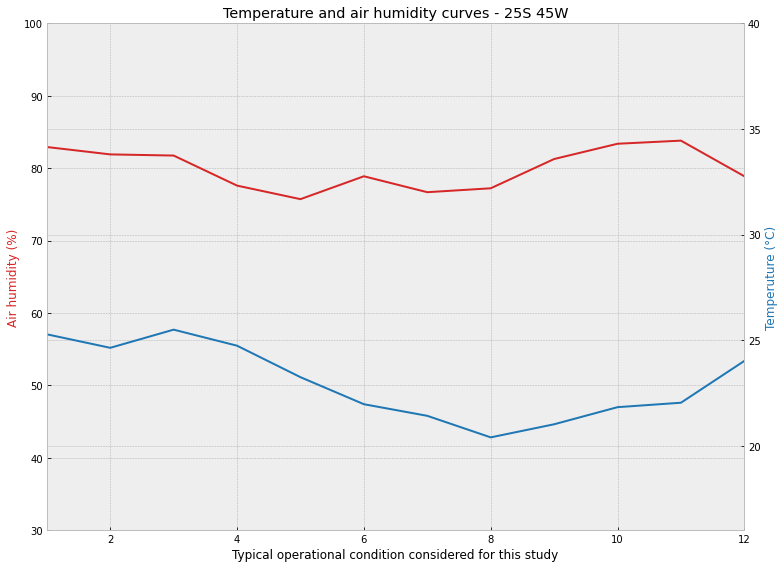

Dia  Temperatura  Umidade
0    1        25.28    82.93
1    2        24.64    81.91
2    3        25.50    81.75
3    4        24.74    77.60
4    5        23.25    75.73

In [4]:
#real humidity and temperature data (environmental conditions) in platform region collected from meterological software
ambiente = pd.read_csv('ambiental_mes.csv')
ambiente.columns = ["Dia", "Temperatura", "Umidade"]
%matplotlib inline
plt.rcParams['figure.figsize'] = (11,8)
plt.style.use('bmh')
fig,ax1 = plt.subplots()
color1 = 'tab:red'
color2 = 'tab:blue'
ax1.set_xlabel('Typical operational condition considered for this study')
ax1.set_xlim(1,12)
ax1.set_ylabel('Air humidity (%)',color=color1)
ax1.set_ylim(30,100)
ax1.plot(ambiente["Dia"], ambiente["Umidade"],color=color1)
ax2 = ax1.twinx()
ax2.set_ylabel('Temperuture (°C)',color=color2)
ax2.set_ylim(16,40)
ax2.plot(ambiente['Dia'], ambiente['Temperatura'],color=color2)
plt.title('Temperature and air humidity curves - 25S 45W')
fig.tight_layout()
plt.savefig('TempProfile.jpg')
plt.show()
ambiente.head()

Dados de produção de óleo, gás natural e água e demandas térmica e elétrica do FPSO

<Figure size 1440x504 with 0 Axes>

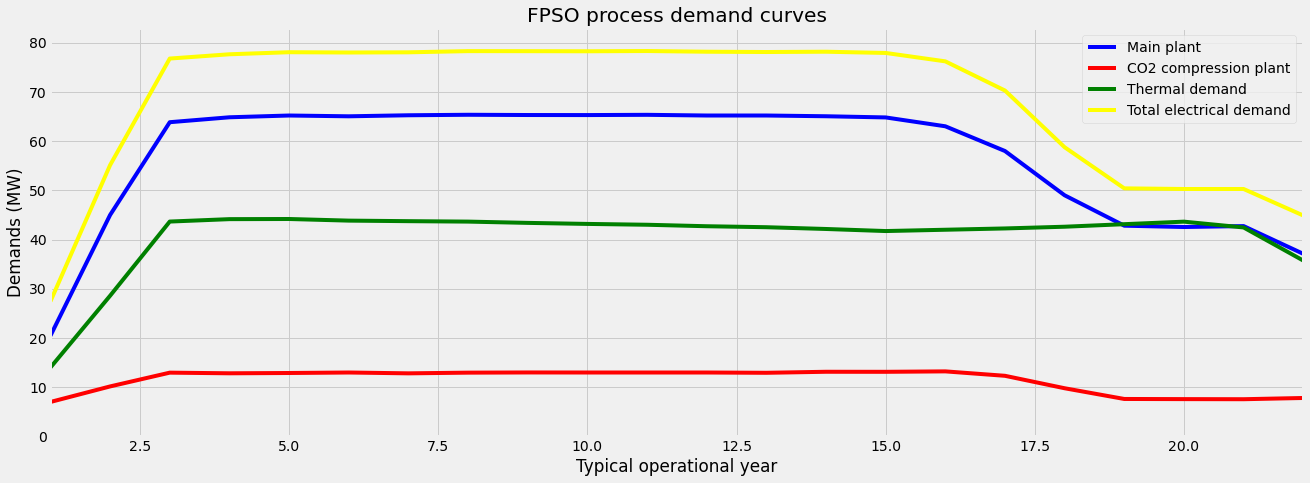

ano     oleo     gas   agua  principal    co2  total  termico
0    1   82.608  27.590  0.205      20.45   6.98  27.43    13.99
1    2  200.509  53.923  0.219      45.00  10.14  55.14    28.58
2    3  205.680  59.061  0.246      63.86  12.94  76.80    43.66
3    4  204.880  59.751  0.246      64.86  12.81  77.67    44.15
4    5  204.654  60.510  0.657      65.22  12.87  78.09    44.18

In [5]:
#Oil, natural gas, water, thermal and electricla demands operational data of FPSO
demandas = pd.read_csv('demanda.csv')
demandas.columns = ['ano','oleo','gas','agua','principal','co2','total','termico']
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,7)
plt.style.use('fivethirtyeight')
fig = plt.figure()
fig, ax = plt.subplots()
color = 'tab:red'
ax.set_xlabel('Typical operational year')
ax.set_xlim(1,22)
ax.set_ylabel('Demands (MW)')
ax.set_ylim(0,90)
ax.set_title('FPSO process demand curves')
ax.plot(demandas["ano"], demandas['principal'], color = 'blue', label='Main plant')
ax.plot(demandas["ano"], demandas['co2'], color='red', label = 'CO2 compression plant')
ax.plot(demandas["ano"], demandas['termico'], color = 'green', label = 'Thermal demand')
ax.plot(demandas["ano"], demandas['total'], color = 'yellow', label = 'Total electrical demand')
ax.set_ylim(0,83)
plt.legend()
plt.savefig('DemandCurves.jpg', dpi=400)
plt.show()
demandas.head()

<Figure size 1440x504 with 0 Axes>

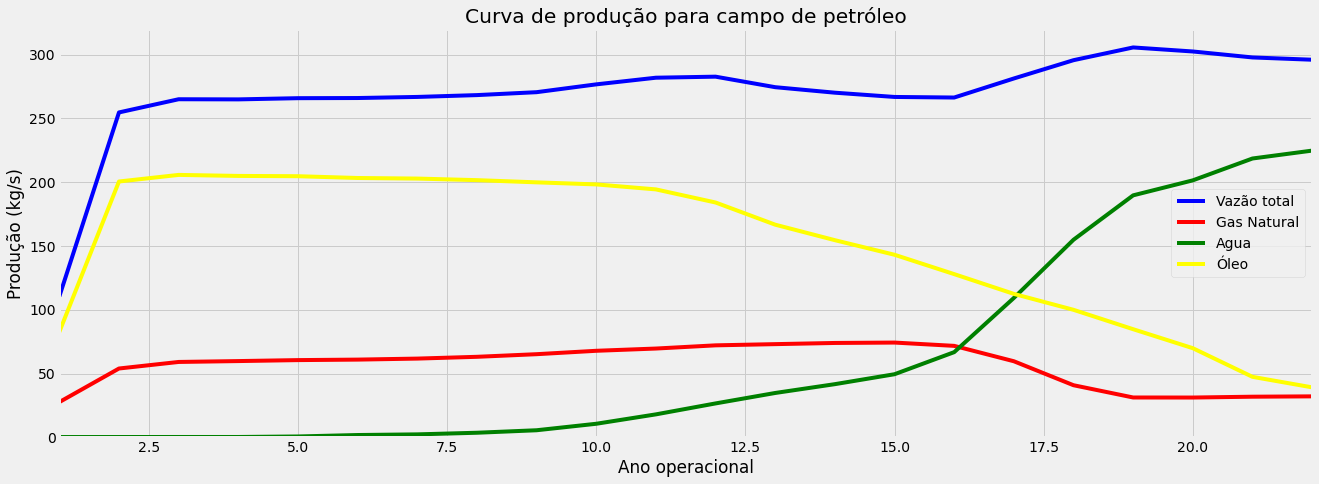

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,7)
plt.style.use('fivethirtyeight')
fig = plt.figure()
fig, ax = plt.subplots()
color = 'tab:red'
ax.set_xlabel('Ano operacional')
ax.set_xlim(1,22)
ax.set_ylabel('Produção (kg/s)')
ax.set_ylim(0,320)
ax.set_title('Curva de produção para campo de petróleo')
ax.plot(demandas["ano"], demandas['oleo']+demandas['agua']+demandas['gas'], color = 'blue', label='Vazão total')
ax.plot(demandas["ano"], demandas['gas'], color='red', label = 'Gas Natural')
ax.plot(demandas["ano"], demandas['agua'], color = 'green', label = 'Agua')
ax.plot(demandas['ano'], demandas['oleo'], color = 'yellow', label = 'Óleo')
plt.legend()
plt.savefig('ProductionCurves.jpg', dpi=400)
plt.show()

In [5]:
#Manufacturer design conditions of gas turbines. Namely LM2500+, LM2500, RB211 and LM2000.
def tgprojeto(TG,PCI_GN_m,Perc_ar_resf):
    TurbProj = dict()
    if (TG == 1):
    #"!Turbinas a gás LM2500+ Condição de projeto: "
        TurbProj = {'rpm':3600,'rp':23.3,'WT_iso':30900,'HR_iso':9227,'eta_iso':38,'m_gas_exaust_iso':83.48,'T_gas_exaust_iso':501}
    elif (TG == 2):
    #"!Turbinas a gás LM2500 Condição de projeto: "
        TurbProj = {'rpm':3600,'rp':18,'WT_iso':25060,'HR_iso':9705,'eta_iso':36,'m_gas_exaust_iso':70.5,'T_gas_exaust_iso':566}
    elif (TG == 3):
    #"!Turbinas a gás RR RB211: "
        TurbProj = {'rpm':4800,'rp':20.8,'WT_iso':20800,'HR_iso':9062.96,'eta_iso':39.72,'m_gas_exaust_iso':90,'T_gas_exaust_iso':492}
    elif(TG == 4):
    #"!Turbinas a gás LM2000:"
        TurbProj = {'rpm':3600,'rp':15.6,'WT_iso':17558,'HR_iso':10140.84,'eta_iso':35.5,'m_gas_exaust_iso':62,'T_gas_exaust_iso':474}
    elif (TG > 4):
        print('Somente 4 modelos de turbinas estão disponíveis')
#Fuel consumption on design condition operation
    Q_T_iso = TurbProj['WT_iso']/(TurbProj['eta_iso']/100)
    TurbProj['m_comb_iso'] = Q_T_iso/PCI_GN_m
#Air flow on design condition
    TurbProj['m_ar_iso'] = TurbProj['m_gas_exaust_iso'] - TurbProj['m_comb_iso']
    TurbProj['m_ar_resf'] = TurbProj['m_ar_iso']*Perc_ar_resf/100
    TurbProj['m_ar_comb'] = TurbProj['m_ar_iso']-TurbProj['m_ar_resf']
    TurbProj['A/C'] = TurbProj['m_ar_comb']/TurbProj['m_comb_iso']
    return TurbProj

In [6]:
#Offdesign condition for turbogenerator operation
def turboffdesign(ElectricalDemand,TG,Ponto2,PCI_comb_ISO,PCI_comb,eta_ger,DELTAP_entrada,DELTAP_HRSG):
    Perc_ar_resf = 10
    TurbProj = tgprojeto(TG,PCI_comb_ISO,Perc_ar_resf)
#Correcting factor due fuel composition change
#According to Gas turbine World 2014-15 Handbook, vol 31, p 60 - Simple Cycle Peformance Specs
#Fuel: 2 to 3 % loss power and 1 to 2 % higher HR when fuel isn't pure natural gas
    if PCI_comb < PCI_comb_ISO:
        f_corr_comb_WT = 0
        f_corr_comb_HR = 0
        #f_corr_comb_WT = 0.025
        #f_corr_comb_HR = 0.025
    else:
        f_corr_comb_WT = 1
        f_corr_comb_HR = 1
#Correção devido a perda de carga na entrada: Para cada polegada de coluna de água acrescida na entrada é esperado uma redução de 0,4 % na potência e 0,1% de acréscimo no HR
    #DELTAP_entrada_in =DELTAP_entrada*0.03937
    f_corr_PerdCargE_WT = (0.4/100)*DELTAP_entrada
    f_corr_PerdCargE_HR = (0.1/100)*DELTAP_entrada
#Correção devido a temperatura de entrada do ar
    f_corr_Tamb_WT=0.00000000790662*(Ponto2['T']-273.15)**4+0.00000167982*(Ponto2['T']-273.15)**3-0.000174248*(Ponto2['T']-273.15)**2-0.00298783*(Ponto2['T']-273.15)+1.07795
    f_corr_Tamb_HR=-0.000000000372697*(Ponto2['T']-273.15)**4+0.000000323539*(Ponto2['T']-273.15)**3+0.0000143292*(Ponto2['T']-273.15)**2+0.000700538*(Ponto2['T']-273.15)+0.985211
#Correção devido a umidade do ar
    #print('p2', Ponto2['P'])
    omega = cp.HAPropsSI('HumRat','T',Ponto2['T'],'P',Ponto2['P'],'R',Ponto2['UR'])
    #print('omega',omega)
    f_corr_Umidade_HR = -0.1955*omega**2 + 0.3784*omega + 0.9976
    f_corr_Umidade_WT = 0.177*omega**2-0.1464*omega+1.0011
#Correção devido à perda de carga na exaustão. Para cada polegada de coluna de água acrescida na saída é esperado uma redução de 0,15% na potência e 0,1% de acrescimo no HR
    #DELTAP_HRSG_in =DELTAP_HRSG*0.03937
    f_corr_Pexaust_WT=0.15/100*DELTAP_HRSG
    f_corr_Pexaust_HR=0.10/100*DELTAP_HRSG
#Condição de operação condição de operação da turbina considerando variação de temperatura, perda de carga e mudança de combustível"
    fator_corrHR= f_corr_Tamb_HR*(1/(1-(f_corr_comb_HR+f_corr_Pexaust_HR+f_corr_PerdCargE_HR)))*f_corr_Umidade_HR
    #print('fator_corrHR', fator_corrHR)
    HR_oper=TurbProj['HR_iso']*fator_corrHR
#Determinação da potência líquida máxima em função da temperatura de admissão, pressão de exaustão e eficiência do gerador"
    fator_cor_PerdCarga = (f_corr_comb_WT+f_corr_Pexaust_WT+f_corr_PerdCargE_WT)
    fator_corrWT = (eta_ger/100)*f_corr_Tamb_WT*(1-(f_corr_comb_WT+f_corr_Pexaust_WT+f_corr_PerdCargE_WT))*f_corr_Umidade_WT
    WTmaximo=TurbProj['WT_iso']*fator_corrWT
    #print('WTmaximo', WTmaximo)
    #print('fator_corrWT', fator_corrWT)
#Cálculo do número de turbinas requeridas
    W_turbinas = (ElectricalDemand*1000)/(eta_ger/100)
    n_turb = math.ceil(W_turbinas/(WTmaximo))
#Demanda elétrica por turbina
    WT_real=(W_turbinas)/(n_turb)
    #print('WT Real:', WT_real, 'N Turb:', n_turb, 'W total:', WT_real*n_turb, 'Demanda:', ElectricalDemand)
#Potência disponível pela turbina
    WT_disp_ind = WTmaximo-WT_real
    WT_disp_total = WT_disp_ind*n_turb
#Determinação da carga operacional por turbina acionada
    Carga_Oper_Turb = WT_real/WTmaximo*100
#Influência da carga operacional por turbina nos parametros
#Massa de gases de combustão
    f_corr_gas_exaust=(-2.014*(Carga_Oper_Turb/100)**4 + 5.9971*(Carga_Oper_Turb/100)**3 - 6.555*(Carga_Oper_Turb/100)**2 + 3.7095*(Carga_Oper_Turb/100)-0.1377)
    m_exaust=TurbProj['m_gas_exaust_iso']*f_corr_gas_exaust
#Temperatura de exaustao dos gases
    f_corr_temp_exaust=(-0.000000000241268*Carga_Oper_Turb**6-0.000000519875*Carga_Oper_Turb**5+0.000214876*Carga_Oper_Turb**4-0.0321505*Carga_Oper_Turb**3+2.29043*Carga_Oper_Turb**2-78.3054*Carga_Oper_Turb+1129.22-0.062)/100
    T_gas_exaust=TurbProj['T_gas_exaust_iso']*f_corr_temp_exaust
#Eficiência energetica da turbina
    f_corr_eta=(-0.000011814*Carga_Oper_Turb**4+0.0031939*Carga_Oper_Turb**3-0.31474*Carga_Oper_Turb**2+13.888*Carga_Oper_Turb-154.54+0.64)/100
#Eficiencia energetica da turbina
    eta_oper=((3600/HR_oper)*100)*f_corr_eta
#Consumo de combustivel
    m_comb_real=WT_real/((eta_oper/100)*PCI_comb)
#Determinação do ar de combustão
    m_ar_real = m_exaust-m_comb_real 
    TurbOffDesign = dict()
    TurbOffDesign = {'m_comb_real':m_comb_real,'n_turb_real': n_turb,'Carga_Oper_Turb':Carga_Oper_Turb,'WT_real':WT_real,'m_exaust':m_exaust,'T_gas_exaust':T_gas_exaust,'m_comb_real':m_comb_real,'WT_disp_total':WT_disp_total,'WT_disp_ind':WT_disp_ind,'eta_oper':eta_oper,'m_ar_real':m_ar_real,'WTmaximo':WTmaximo}
    return TurbOffDesign

Thermodynamics modelling for: simple gas turbine power system + ORC(Configurations 1 and 2)

In [7]:
def TurbORC(ORC,ElectricalDemand,ThermalDemand,Ponto,TG,Ponto2,PCI_comb_ISO,PCI_comb,eta_ger,DELTAP_inlet,DELTAP_exaust):
    Perc_ar_resf = 10
    TurbProj = tgprojeto(TG,PCI_comb_ISO,Perc_ar_resf)
#"!Correção devido a mudança da composição do combustível"
#"Conforme Gas turbine World 2014-15 Handbook, vol 31, p 60 - Simple Cycle Peformance Specs"
#"Combustível: 2 a 3 % menos na potência e 1 a 2 % de aumento no HR quando o combustível de operação não é o gás natural"
    if PCI_comb < PCI_comb_ISO:
        f_corr_comb_WT = 0.025
        f_corr_comb_HR = 0.025
    else:
        f_corr_comb_WT = 1
        f_corr_comb_HR = 1
#"!Correção devido a temperatura de entrada do ar"
    f_corr_Tamb_WT=0.00000000790662*(Ponto2['T']-273.15)**4+0.00000167982*(Ponto2['T']-273.15)**3-0.000174248*(Ponto2['T']-273.15)**2-0.00298783*(Ponto2['T']-273.15)+1.07795
    f_corr_Tamb_HR=-0.000000000372697*(Ponto2['T']-273.15)**4+0.000000323539*(Ponto2['T']-273.15)**3+0.0000143292*(Ponto2['T']-273.15)**2+0.000700538*(Ponto2['T']-273.15)+0.985211
#"!Correção devido a umidade do ar"
    omega = cp.HAPropsSI('HumRat','T',Ponto2['T'],'P',Ponto2['P'],'R',Ponto2['UR'])
    f_corr_Umidade_HR = -0.1955*omega**2 + 0.3784*omega + 0.9976
    f_corr_Umidade_WT = 0.177*omega**2-0.1464*omega+1.0011
#"!Correção devido a perda de carga na entrada: Para cada polegada de coluna de água acrecida na entrada é esperado uma redução de 0,4 % na potência e 0,1 de acréscimo no HR."
    f_corr_PerdCargE_WT = (0.4/100)*DELTAP_inlet
    f_corr_PerdCargE_HR = (0.1/100)*DELTAP_inlet
#"!correção devido à perda de carga na exaustão. Para cada polegada de coluna de água acrescida na saída é esperado uma redução de 0,15% na potência e 0,1% de acrescimo no HR."
    f_corr_Pexaust_WT=0.15/100*DELTAP_exaust
    f_corr_Pexaust_HR=0.10/100*DELTAP_exaust
#"!Condição de operação condição de operação da turbina considerando variação de temperatura, perda de carga e mudança de combustível"
    fator_corrHR= f_corr_Tamb_HR*(1/(1-(f_corr_comb_HR+f_corr_Pexaust_HR+f_corr_PerdCargE_HR)))*f_corr_Umidade_HR
    HR_oper=TurbProj['HR_iso']*fator_corrHR
#"determinação da potência líquida máxima em função da temperatura de admissão, pressão de exaustão e eficiência do gerador"
    fator_cor_PerdCarga = (f_corr_comb_WT+f_corr_Pexaust_WT+f_corr_PerdCargE_WT)
    fator_corrWT = (eta_ger/100)*f_corr_Tamb_WT*(1-(f_corr_comb_WT+f_corr_Pexaust_WT+f_corr_PerdCargE_WT))*f_corr_Umidade_WT
    WTmaximo=TurbProj['WT_iso']*fator_corrWT
#     print('WTmaximo', WTmaximo)
    W_ORC_total = None
#Recalculando parêmtros anteriores com a inserção do ORC:
    while True:
        if W_ORC_total == None:
            #"cálculo do número de turbinas requeridas"
            W_turbinas = (ElectricalDemand*1000)/(eta_ger/100)
#             print('W_turbinas era:', W_turbinas)
            n_turb = math.ceil(W_turbinas/(WTmaximo))
#             print('n_turb era:', n_turb)
            #"demanda elétrica por turbina"
            WT_real=(W_turbinas)/(n_turb)
            #"Potência disponível pela turbina"
            WT_disp_ind = WTmaximo-WT_real
            WT_disp_total = WT_disp_ind*n_turb
            #"determinação da carga operacional por turbina acionada"
            Carga_Oper_Turb = WT_real/WTmaximo*100
            #Parâmetros devido a carga de operação
            #Massa de gases de combustão
            f_corr_gas_exaust=(-2.014*(Carga_Oper_Turb/100)**4 + 5.9971*(Carga_Oper_Turb/100)**3 - 6.555*(Carga_Oper_Turb/100)**2 + 3.7095*(Carga_Oper_Turb/100)-0.1377)
            m_exaust=TurbProj['m_gas_exaust_iso']*f_corr_gas_exaust
            #Temperatura de exaustao dos gases
            f_corr_temp_exaust=(-0.000000000241268*Carga_Oper_Turb**6-0.000000519875*Carga_Oper_Turb**5+0.000214876*Carga_Oper_Turb**4-0.0321505*Carga_Oper_Turb**3+2.29043*Carga_Oper_Turb**2-78.3054*Carga_Oper_Turb+1129.22-0.062)/100
            T_gas_exaust=TurbProj['T_gas_exaust_iso']*f_corr_temp_exaust
            #Calculo do calor total por turbina
            Q_total = m_exaust * Ponto['cp']/1000 * (T_gas_exaust - 150)
            #print('Q_total', Q_total)
            #print('m_exaust', m_exaust)
            #print('Ponto cp', Ponto['cp'])
            #print('T_gas_exaust', T_gas_exaust)
#             calculo do calor disponível por turbina
            Q_disponível = Q_total - ThermalDemand*1000/n_turb
            #print('ThermalDemand', ThermalDemand)
            #print('Q_disponível', Q_disponível)
#             print('n_turb', n_turb)
#             print('Q_total', Q_total)
#             print('Q_disponível', Q_disponível)
            #Organic Rankine Cycle Tecnology- ENERTIME CORDIAL 3000
            #Thermal Power: 13000kW, Nominal Power: 3000kW, Gross Efficiency: 23%
            if ORC == 1:
                Overall_Thermal_Proj = 4500
            elif ORC == 2:
                Overall_Thermal_Proj = 13000
            eta_ORC_proj = 23
            if Q_disponível > Overall_Thermal_Proj:
                Overall_Thermal = Overall_Thermal_Proj 
                W_ORC = Overall_Thermal * eta_ORC_proj/100
                #print('W_ORC é o maximo', W_ORC)
            elif Q_disponível > 0:
                Overall_Thermal = Q_disponível
                ORC_carga_parcial = Overall_Thermal/Overall_Thermal_Proj
                f_corr_efic_ORC = (535.6551*ORC_carga_parcial**5-1750.6779*ORC_carga_parcial**4+2256.7118*ORC_carga_parcial**3-1486.7525*ORC_carga_parcial**2+541.8019*ORC_carga_parcial+3.1861)/100
                eta_ORC = eta_ORC_proj*f_corr_efic_ORC
                W_ORC = eta_ORC/100*Overall_Thermal
                #print('W_ORC', W_ORC)
                #print('eta_ORC', eta_ORC)
            else:
                W_ORC = 0
            W_ORC_total = W_ORC * n_turb
            continue
        else:
            #"cálculo do número de turbinas requeridas"
            W_turbinas = (ElectricalDemand*1000-W_ORC_total)/(eta_ger/100)
#             print('W_turbinas passou a ser:', W_turbinas)
            n_turb1 = math.ceil(W_turbinas/(WTmaximo))
#             print('n_turb1', n_turb1)
            if n_turb1 < n_turb:
                W_turbinas = (ElectricalDemand*1000 - W_ORC * n_turb1)/(eta_ger/100)
#                 print('W_turbinas agora é:', W_turbinas)
                n_turb = math.ceil(W_turbinas/(WTmaximo))
#                 print('n_turb final:', n_turb)
                W_turbinas_int = (ElectricalDemand*1000 - W_ORC * n_turb)/(eta_ger/100)
                if(W_turbinas_int/n_turb <= WTmaximo):
                        n_turb1 = n_turb
                else:
                        n_turb1 = n_turb1
#                 if W_ORC * n_turb1 + W_turbinas*(eta_ger/100) < ElectricalDemand*1000:
#                     W_ORC_total = W_ORC*n_turb1
#                     W_turbinas_int = (ElectricalDemand*1000 - W_ORC_total)/(eta_ger/100)
            Q_total = m_exaust * Ponto['cp']/1000 * (T_gas_exaust - 150)
            Q_disponível = Q_total - ThermalDemand*1000/n_turb1
            if Q_disponível > Overall_Thermal_Proj:
                Overall_Thermal = Overall_Thermal_Proj 
                W_ORC = Overall_Thermal * eta_ORC_proj/100
                #print('W_ORC é o maximo', W_ORC)
            elif Q_disponível > 0:
                Overall_Thermal = Q_disponível
                ORC_carga_parcial = Overall_Thermal/Overall_Thermal_Proj
                f_corr_efic_ORC = (535.6551*ORC_carga_parcial**5-1750.6779*ORC_carga_parcial**4+2256.7118*ORC_carga_parcial**3-1486.7525*ORC_carga_parcial**2+541.8019*ORC_carga_parcial+3.1861)/100
                eta_ORC = eta_ORC_proj*f_corr_efic_ORC
                W_ORC = eta_ORC/100*Overall_Thermal
                #print('W_ORC', W_ORC)
                #print('eta_ORC', eta_ORC)
            else:
                W_ORC = 0
            W_ORC_total = W_ORC * n_turb1
            W_turbinas = (ElectricalDemand*1000-W_ORC_total)/(eta_ger/100)
#             print(W_turbinas)
#             n_turb = math.ceil(W_turbinas/(WTmaximo))
#             print(n_turb)
            #"demanda elétrica por turbina"
            WT_real=(W_turbinas)/(n_turb1)
            #"Potência disponível pela turbina"
            WT_disp_ind = WTmaximo-WT_real
            WT_disp_total = WT_disp_ind*n_turb1
            #"determinação da carga operacional por turbina acionada"
            Carga_Oper_Turb = WT_real/WTmaximo*100
            #Parâmetros devido a carga de operação
            #Massa de gases de combustão
            f_corr_gas_exaust=(-2.014*(Carga_Oper_Turb/100)**4 + 5.9971*(Carga_Oper_Turb/100)**3 - 6.555*(Carga_Oper_Turb/100)**2 + 3.7095*(Carga_Oper_Turb/100)-0.1377)
            m_exaust=TurbProj['m_gas_exaust_iso']*f_corr_gas_exaust
            #Temperatura de exaustao dos gases
            f_corr_temp_exaust=(-0.000000000241268*Carga_Oper_Turb**6-0.000000519875*Carga_Oper_Turb**5+0.000214876*Carga_Oper_Turb**4-0.0321505*Carga_Oper_Turb**3+2.29043*Carga_Oper_Turb**2-78.3054*Carga_Oper_Turb+1129.22-0.062)/100
            T_gas_exaust=TurbProj['T_gas_exaust_iso']*f_corr_temp_exaust
            #Q_disponível = m_exaust*1.079*(T_gas_exaust-150)
            #if Q_disponível > Overall_Thermal_Proj:
            #    Overall_Thermal = Overall_Thermal_Proj 
            #    W_ORC = Overall_Thermal * eta_ORC_proj/100
            #else:
            #    Overall_Thermal = Q_disponível
            #    ORC_carga_parcial = Overall_Thermal/Overall_Thermal_Proj
            #    f_corr_efic_ORC = (535.6551*ORC_carga_parcial**5-1750.6779*ORC_carga_parcial**4+2256.7118*ORC_carga_parcial**3-1486.7525*ORC_carga_parcial**2+541.8019*ORC_carga_parcial+3.1861)/100
            #    eta_ORC = eta_ORC_proj*f_corr_efic_ORC
            #    W_ORC = eta_ORC/100 * Overall_Thermal
            break
    #"Eficiência energetica da turbina"
    f_corr_eta=(-0.000011814*Carga_Oper_Turb**4+0.0031939*Carga_Oper_Turb**3-0.31474*Carga_Oper_Turb**2+13.888*Carga_Oper_Turb-154.54+0.64)/100
    #"eficiencia energetica da turbina"
    eta_oper=((3600/HR_oper)*100)*f_corr_eta
    #"consumo de combustivel"
    m_comb_real=WT_real/((eta_oper/100)*PCI_comb)
    #"Determinação do ar de combustão"
    m_ar_real = m_exaust-m_comb_real 
    TurbOffDesign = dict()
    TurbOffDesign = {'Q_ORC':Overall_Thermal,'m_comb_real':m_comb_real,'Carga_Oper_Turb':Carga_Oper_Turb,'WT_real':WT_real,'m_exaust':m_exaust,'T_gas_exaust':T_gas_exaust,'m_comb_real':m_comb_real,'n_turb_real':n_turb1,'WT_disp_total':WT_disp_total,'WT_disp_ind':WT_disp_ind,'eta_oper':eta_oper,'m_ar_real':m_ar_real,'WTmaximo':WTmaximo,'W_ORC':W_ORC}
    return TurbOffDesign

Thermodynamics modelling for air cooling systems

Humidy air thermodynamic properties: http://www.coolprop.org/fluid_properties/HumidAir.html

In [8]:
# http://www.coolprop.org/fluid_properties/HumidAir.html
def SistResfriamento(m_ar_off,T_amb,P_amb,UR_amb, Sistema):
#Condições de projeto para resfriador de ar
    m_ar_iso=79.38
    T_inlet_air_iso=25.28+273.15
    T_outlet_air_iso=15+273.15
    m_water_iso=81.7
    T_inlet_water_iso=6.67+273.15
    T_outlet_water_iso=12.2+273.15
    P_inlet_water=300000
    P_outlet_water=290000
    U0=113.67                                             #"coeficiente global de transferencia de calor - W/m**2-k"
    A=1747.77                                             #"Area total de troca térmica- m**2"
    DELTA_P_iso=1194.2                               #unidade: Pa "queda de pressão do ar"
    DELTA_P_Off = DELTA_P_iso 
    #DELTA_P_Off = (0.0008*(m_ar_off/m_ar_iso)**2+0.0125*(m_ar_off/m_ar_iso))*100000
    #print('deltapoff sistresf', DELTA_P_Off)
    DTML = ((T_inlet_air_iso - T_outlet_water_iso) - (T_outlet_air_iso - T_inlet_water_iso)) / (np.log((T_inlet_air_iso - T_outlet_water_iso)/( T_outlet_air_iso - T_inlet_water_iso)))
    Q_maximo = U0 * A * DTML / 1000  #"Troca térmica máxima - condição de projeto"
    #troca de calor na condição limite:
    h_inferior = cp.PropsSI('H', 'T', 6.67+273.15,'P', 2000000, 'water')/1000
    h_superior = cp.HAPropsSI('H','T',T_amb,'P',P_amb,'R',UR_amb)/1000
    Q_limite = m_ar_off * (h_superior - h_inferior)
    #Propriedades termodinâmicas do ar nas condições de referência
    t0 = 25 + 273.15
    p0 = 101325
    UR = 0.6
    h0 = cp.HAPropsSI('H','T',t0,'P',p0,'R',UR)/1000
    s0 = cp.HAPropsSI('S','T',t0,'P',p0,'R',UR)/1000
#Propriedades termodinâmicas do ar nas condições de operação. Ponto 1 - entrada do resfriador. Ponto 2 - saída do resfriador
    h_inlet=cp.HAPropsSI('H','T',T_amb,'P',P_amb,'R',UR_amb)/1000
    s_inlet=cp.HAPropsSI('S','T',T_amb,'P',P_amb,'R',UR_amb)/1000
    ex_inlet = h_inlet-h0-(t0)*(s_inlet-s0)
    omega_inlet = cp.HAPropsSI('HumRat','T',T_amb,'P',P_amb,'R',UR_amb)
#Metodologia: equação da linha reta. Determinação da umidade relativa do ar resfriado
#Considerações para as condições da superfície dos tubos:
    T_s = (T_inlet_water_iso + T_outlet_water_iso ) / 2       #"Consideração: temperatura do tubo é igual à temperatura média entre os fluxos de entrada e saída de água de resfriamento + 1 °C"
    UR_s = 0.99      #"Consideração: há condensação de água na superfície do tubo, portanto umidade relativa é 1"
    P_s = P_amb
    omega_s = cp.HAPropsSI('HumRat','T',T_s,'P',P_s,'R',UR_s)
#Temperatura e pressão do ar na saída
    t_outlet = 15 +273.15              #"temperatura de saída do ar. Considerada fixa em 15°C"
    p_outlet = P_amb - DELTA_P_Off
#     print('p_outlet',p_outlet)
#Equação da linha reta
#( t[2] - t_s) / ( (t[3] - t_s) ) = (omega[2] - omega_s) / (omega[3] - omega_s) 
    omega_outlet = omega_s + (omega_inlet - omega_s) * (t_outlet - T_s) / ( T_amb - T_s)
#Propriedades termodinamicas do ar na saida
    try:
        ur_outlet = cp.HAPropsSI('RelHum','T',t_outlet,'P',p_outlet,'W',omega_outlet)
    except:
        ur_outlet = 1
    h_outlet=cp.HAPropsSI('H','T',t_outlet,'P',p_outlet,'W',omega_outlet)/1000
    s_outlet=cp.HAPropsSI('S','T',t_outlet,'P',p_outlet,'W',omega_outlet)/1000
    ex_outlet = h_outlet-h0-(t0)*(s_outlet-s0)
#Propriedades termodinamicas da agua na saida
    h0_water=cp.PropsSI('H','T',t0,'P',p0,'Water')
    s0_water=cp.PropsSI('S','T',t0,'P',p0,'Water')
    t_outlet_water = 135 + 273.15
    t_inlet_water = 105 + 273.15
    p_outlet_water = 1700000
    p_inlet_water = 1650000
    h_outlet_water=cp.PropsSI('H','T',t_outlet_water,'P',p_outlet_water,'Water')/1000
    h_inlet_water=cp.PropsSI('H','T',t_inlet_water,'P',p_inlet_water,'Water')/1000
    s_outlet_water=cp.PropsSI('S','T',t_outlet_water,'P',p_outlet_water,'Water')
    s_inlet_water=cp.PropsSI('S','T',t_inlet_water,'P',p_inlet_water,'Water')
    ex_outlet_water = h_outlet_water - h0_water - (t0)*(s_outlet_water-s0_water)
    ex_inlet_water = h_inlet_water - h0_water - (t0)*(s_inlet_water-s0_water)
    if Sistema == 'Absorção':
#sistema de refrigeração por absorção: Trane Classic Absorption Series, Single Stage Hot Water or Steam-Fired Absorption Water Chillers 112-465 Tons Modelo 256
        Q_MaqRefAbsorcao_proj=246.8
        COP_MaqRefAbsorcao_proj=0.64
        Q_gerador_proj=(Q_MaqRefAbsorcao_proj*3.5168525)/COP_MaqRefAbsorcao_proj
        Q_ref=m_ar_off*(h_inlet-h_outlet)
        Q_ref_TR=Q_ref/3.5168525
        n_MaqRef = math.ceil(Q_ref_TR/Q_MaqRefAbsorcao_proj)
        PLR_RefAbsorcao=(Q_ref_TR/n_MaqRef)/Q_MaqRefAbsorcao_proj
        COP_Refr_oper_Absorcao=COP_MaqRefAbsorcao_proj*(0.000000021051*(PLR_RefAbsorcao*100)**3-0.000035055*(PLR_RefAbsorcao*100)**2+0.001382*(PLR_RefAbsorcao*100)+1.1884)
        Q_gerador=Q_ref/COP_Refr_oper_Absorcao
        Q_gerador_TR=Q_gerador/3.5168525
        m_gerador=Q_gerador/(h_outlet_water-h_inlet_water)
        COP_Off = COP_Refr_oper_Absorcao
#Análise termodinamica no chiller+resfriador
        Ex_dest_ResfAr=Q_gerador+m_ar_off*(ex_inlet-ex_outlet)
        eta_carnot_evap = (1-298.15/(10+273.15))
        eta_carnot_ger = (1-273.15/(125+273.15))
        psi_Chiller= -Q_ref * eta_carnot_evap/(eta_carnot_ger * Q_gerador) * 100
#//k[3] * ex[3] * m_ar_off = k[2] * ex[2] * m_ar_off + k[16] * WT_chiller	"balanço de custo exergetico em volume de controle resfriador + chiller"
        Epsilon_resfriador = Q_ref/Q_limite
        ResfComp = dict()
        ResfComp = {'COP_Off':COP_Off,'n_MaqRef':n_MaqRef,'DELTA_P_Off':DELTA_P_Off,'m_gerador':m_gerador,'Ex_dest_ResfAr':Ex_dest_ResfAr,'psi_Chiller':psi_Chiller,'Epsilon_resfriador':Epsilon_resfriador}
        Ponto2 = dict()
        Ponto2 = {'T':t_outlet,'P':p_outlet,'UR':ur_outlet,'H':h_outlet,'S':s_outlet,'W':omega_outlet,'E':ex_outlet}
    elif Sistema == 'Compressão':
#Sistema de refrigeração por compressão: 30HXC WATER-COOLED CHILLER AHRI RATINGS (60 Hz ONLY) UNII Size 30HXC 260
        Q_Maq_referencia=899     #[kW]
        W_comp_proj=206          #[kW]
        COP_proj=5.07 
        Q_ref=m_ar_off*(h_inlet-h_outlet)
        n_MaqRef = math.ceil(Q_ref/Q_Maq_referencia)
        PLR_refComp=(Q_ref/n_MaqRef)/(Q_Maq_referencia)
        EIRFPLR_RefComp=0.16102213+0.58578139*PLR_refComp+0.25319648*PLR_refComp**2
        WT_ref=W_comp_proj*EIRFPLR_RefComp
        WT_chiller=WT_ref*n_MaqRef
        #print('WT_ref', WT_ref)
        #print('n_MaqRef', n_MaqRef)
        COP_Off=(Q_ref)/WT_chiller
#"Análise termodinamica no chiller+resfriador"
        Ex_dest_ResfAr=WT_chiller+m_ar_off*(ex_inlet-ex_outlet)
        eta_carnot = (1-298.15/273.15)
        #print('eta_carnot', eta_carnot)
        psi_Chiller= Q_ref * eta_carnot/(-WT_chiller) * 100
        #print('ex_inlet', ex_inlet)
        #print('ex_outlet', ex_outlet)
        Epsilon_resfriador = (Q_ref/Q_limite)
        ResfComp = dict()
        ResfComp = {'COP_Off':COP_Off,'n_MaqRef':n_MaqRef,'DELTA_P_Off':DELTA_P_Off,'WT_chiller':WT_chiller,'Ex_dest_ResfAr':Ex_dest_ResfAr,'psi_Chiller':psi_Chiller,'Epsilon_resfriador':Epsilon_resfriador}
        Ponto2 = dict()
        Ponto2 = {'T':t_outlet,'P':p_outlet,'UR':ur_outlet,'H':h_outlet,'S':s_outlet,'W':omega_outlet,'E':ex_outlet}
    return ResfComp,Ponto2
m_ar_off = 80
T_amb = 22 + 273.15
P_amb = 101325
UR_amb = 0.85
Sistema = 'Absorção'
ResfComp, Ponto2 = SistResfriamento(m_ar_off,T_amb,P_amb,UR_amb, Sistema)
print('ResfComp', ResfComp)
print('Ponto2', Ponto2)

ResfComp {'COP_Off': 0.6996884565630381, 'n_MaqRef': 2, 'DELTA_P_Off': 1194.2, 'm_gerador': 15.187990465973487, 'Ex_dest_ResfAr': 1980.221422315646, 'psi_Chiller': 11.806362379540463, 'Epsilon_resfriador': 0.601005162350075}
Ponto2 {'T': 288.15, 'P': 100130.8, 'UR': 0.9565128918576108, 'H': 41.236436787019244, 'S': 0.1529510862303796, 'W': 0.010344620669719886, 'E': -0.7192754660924319}


Thermodynamic modelling of combustion chamber

In [9]:
def combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffDesign):
    #Determinação das propriedades do ar, após o compressor, visando determinar as propriedades do ar na entrada da câmara de combustão. Destaca-se que as propriedades abaixo são realizadas utilizando as propriedades do ar seco e fornecendo a umidade do ar para o processo de combustão" 
    s_ar_comp_ent = cp.PropsSI('S','T', Ponto2['T'],'P', Ponto2['P'],'Air')
    h_ar_comp_ent = cp.PropsSI('H','T', Ponto2['T'],'P', Ponto2['P'],'Air')
    P_ar_comp_sai = TurbProj['rp'] * P_amb
    h_ar_comp_ent = cp.PropsSI('H','T', Ponto2['T'],'P', Ponto2['P'],'Air') 
    s_ar_comp_sai_iso = s_ar_comp_ent
    T_ar_iso_sai_iso = cp.PropsSI('T','S',s_ar_comp_sai_iso,'P',P_ar_comp_sai,'Air')
    h_ar_comp_sai_iso = cp.PropsSI('H','T',T_ar_iso_sai_iso,'P',P_ar_comp_sai,'Air')
    eta_comp = 0.87
    h_ar_comp_sai = h_ar_comp_ent - (h_ar_comp_ent - h_ar_comp_sai_iso)/eta_comp
    T_ar_comp_sai= cp.PropsSI('T','P',P_ar_comp_sai,'H',h_ar_comp_sai,'Air')
    #Combustível"
    AC_massa_seco = TurbProj['m_ar_comb']/TurbOffDesign['m_comb_real']
    omega_mass = cp.HAPropsSI('W','T', Ponto2['T'],'R', Ponto2['UR'],'P', Ponto2['P'])
#     print('omega_mass',omega_mass)
    #"Engineering ToolBox: https://www.engineeringtoolbox.com/air-composition-d_212.html"
    air_composition_molar = {'Nitrogen':0.78084, 'Oxygen':0.20946, 'Argon':0.00934, 'CarbonDioxide': 0.00036}
    #"Relação em função da quantidade de mols de oxigênio"
    rel_O2 = dict()
    Molar_mass_air = list()
    for value in air_composition_molar:
        rel_O2.update({value:air_composition_molar[value]/air_composition_molar['Oxygen']})
        Molar_mass_air.append(air_composition_molar[value]*cp.PropsSI('MOLARMASS', 'T', Ponto2['T'], 'P', Ponto2['P'], value)*1000)
    omega_mol = omega_mass*(sum(Molar_mass_air)/(1000*cp.PropsSI('MOLARMASS', 'T', 300, 'P', 101325, 'Water')))
#     print('omega_mol', omega_mol)
#     print('Molar_mass_air', sum(Molar_mass_air))
    air_composition_mass = dict()
    for k1,v1 in air_composition_molar.items():
        air_composition_mass.update({k1:v1*cp.PropsSI('MOLARMASS', 'T', Ponto2['T'], 'P', Ponto2['P'], k1)*1000/sum(Molar_mass_air)})
    #"Dado de entrada"
    #"Quantidade de combustível de referência-molar"
    n_comb = 1
    P_ref = 101325
    #"!Combustível"
    P_camara = P_ar_comp_sai * TurbProj['rp']
    T_comb = T_comb+273.15
    H_comb = list()
    S_comb = list()
    H_ref = list()
    S_ref = list()
    molar_mass_comb = list()
    for k in fuel_mol:
        molar_mass_comb.append(fuel_mol[k]*1000*cp.PropsSI('MOLARMASS', 'T', 300, 'P', 101325, k))
    #print('Molar mass comb', sum(molar_mass_comb))
    m_comb = n_comb*sum(molar_mass_comb)
    frm_comb = dict()
    rho_comb = list()
    #determinação da fração massica do combustivel
    for (k1,v1) in fuel_mol.items():
        frm_comb.update({k1:v1*1000*cp.PropsSI('MOLARMASS', 'T', 273.15, 'P', 101325, k1)/sum(molar_mass_comb)})
    #print('frm_comb', frm_comb)
    for (k1,v1) in fuel_mol.items():
        rho_comb.append(v1*cp.PropsSI('DMASS','T', T_comb, 'P', v1*P_camara, k1))
    #print('rho_comb', sum(rho_comb))
    for (k,v) in fuel_mol.items():
        H_comb.append(v*cp.PropsSI('Hmolar', 'T', T_comb, 'P', v*20000000, k)/(1000*sum(molar_mass_comb)))
        S_comb.append(v*cp.PropsSI('Smolar', 'T', T_comb, 'P', v*20000000, k)/(1000*sum(molar_mass_comb)))
        H_ref.append(v*cp.PropsSI('Hmolar', 'T', 25+273.15, 'P', v*101325, k)/(1000*sum(molar_mass_comb)))
        S_ref.append(v*cp.PropsSI('Smolar', 'T', 25+273.15, 'P', v*101325, k)/(1000*sum(molar_mass_comb)))
    #print('H_comb', sum(H_comb), 'S_comb', sum(S_comb), 'H_ref', sum(H_ref), 'S_ref', sum(S_ref))
#Exergia do combustível
    n_C_comb = (1*fuel_mol['Methane']+2*fuel_mol['Ethane']+3*fuel_mol['n-Propane']+4*fuel_mol['n-Butane']+6*fuel_mol['n-Hexane'])
    n_H_comb = (4*fuel_mol['Methane']+6*fuel_mol['Ethane']+8*fuel_mol['n-Propane']+10*fuel_mol['n-Butane']+14*fuel_mol['n-Hexane'])
    BETHA = 1.0334+0.0183*(n_H_comb/n_C_comb)-0.0698*(1/n_C_comb)
    Ponto4 = {'T':T_comb,'P':P_ar_comp_sai,'m':TurbOffDesign['m_comb_real'],'H': sum(H_comb), 'S':sum(S_comb), 'E':BETHA * PCI_fuel()}
    #"!####################################################################################################"
    #"!Reagentes"
    #"!Combustível"	
    #"n_comb (aCH4 + bC2H6 + cC3H8 + dC4H10 + eC6H14 + fCO2 + gCO + m H2 + o N2)"
    #"Carbono"
    x= (1*fuel_mol['Methane']+2*fuel_mol['Ethane']+3*fuel_mol['n-Propane']+4*fuel_mol['n-Butane']+6*fuel_mol['n-Hexane']+1*fuel_mol['CarbonDioxide']+1)
    #"Hidrogênio"
    y=(4*fuel_mol['Methane']+6*fuel_mol['Ethane']+8*fuel_mol['n-Propane']+10*fuel_mol['n-Butane']+14*fuel_mol['n-Hexane'])
    #"Oxigênio"
    z=(2*fuel_mol['CarbonDioxide'])
    #"Nitrogênio"
    w=(2*fuel_mol['Nitrogen'])
    #"!Estequimétrico"
    MatrixA = np.array([[rel_O2['CarbonDioxide'],-1,0,0,0,0],
                [0,0,2*omega_mol,-2,0,0],
                [2*rel_O2['Oxygen'],-2,omega_mol,-1,0,0],
                [2*rel_O2['Nitrogen'],0,0,0,-2,0],
                [rel_O2['Argon'],0,0,0,0,-1],
                [-(rel_O2['Oxygen']+rel_O2['Argon']+rel_O2['CarbonDioxide']+rel_O2['Nitrogen']),0,1,0,0,0]])
    MatrixB = np.array([-x*n_comb,-y*n_comb,-z*n_comb,-w*n_comb,0,0])
    a_air_e_seco,n_CO2_e,n_air_e_seco,n_H2O_e,n_N2_p_e,n_Ar_p_e = np.linalg.solve(MatrixA,MatrixB)
    #Relação ar combustível estequiométrico
    n_air_e = n_air_e_seco+n_air_e_seco*omega_mol
    A_C_molar_e_seco= n_air_e_seco/n_comb
    A_C_massa_e_seco= A_C_molar_e_seco*(sum(Molar_mass_air)/sum(molar_mass_comb))
    m_air_e_seco =  n_air_e_seco*sum(Molar_mass_air)
    #"Relação ar combustível"
    m_air_seco = AC_massa_seco * (n_comb * sum(molar_mass_comb))
    #print('AC_massa_seco',AC_massa_seco)
    n_air_seco = m_air_seco / sum(Molar_mass_air)
    #print('m_air_seco',m_air_seco)
    a_air_seco = n_air_seco / (rel_O2['Oxygen']+rel_O2['Argon']+rel_O2['CarbonDioxide']+rel_O2['Nitrogen'])
    A_C_molar_seco = n_air_seco/n_comb
    #"!Reação Real"
    n_CO2 = x * n_comb + a_air_seco * rel_O2['CarbonDioxide']
    n_H2O = 1/2 * (y * n_comb + 2 * n_air_seco * omega_mol)
    n_O2 = 1/2 * (z * n_comb + a_air_seco * 2 * rel_O2['Oxygen'] + n_air_e_seco * omega_mol - 2*n_CO2 - n_H2O)
    #print('n_O2',n_O2,'z',z,'n_comb',n_comb,'a_air_seco',a_air_seco,'oxygen',rel_O2['Oxygen'],'n_air_e_seco',n_air_e_seco,'omega_mol',omega_mol,'n_CO2',n_CO2,'n_H2O',n_H2O)
    n_N2 = 1/2 * (w * n_comb + a_air_seco * 2 * rel_O2['Nitrogen'])
    n_Ar = a_air_seco * rel_O2['Argon']
    excesso = (m_air_seco/m_air_e_seco - 1)*100   
    n_air_agua = n_air_e_seco*omega_mol
    m_air_agua = n_air_agua*cp.PropsSI('MOLARMASS', 'T', 300, 'P', 101325, 'Water')
    #"Relação de equivalência"
    phi = A_C_molar_seco/A_C_molar_e_seco
    #print('phi', phi)
    #"Fração molar"
    n_tot_prod = n_CO2+n_H2O+n_O2+n_N2+n_Ar
    molar_fraction_prod = dict()
    molar_fraction_prod = {'CarbonDioxide':n_CO2/n_tot_prod,'Water': n_H2O/n_tot_prod,'Oxygen':n_O2/n_tot_prod,'Nitrogen':n_N2/n_tot_prod,'Argon':n_Ar/n_tot_prod }
    #print(molar_fraction_prod)
    molar_mass_prod = list()
    for element in molar_fraction_prod:
        molar_mass_prod.append(molar_fraction_prod[element]*cp.PropsSI('MOLARMASS','P',P_camara,'T',300,element)*1000)
    #"Fração mássica"
    #M_mol_prod =y_CO2_prod*molarmass(CO2)+y_H2O_prod*molarmass(H2O)+y_O2_prod*molarmass(O2)+y_N2_prod*molarmass(N2)+y_Ar_prod*molarmass(Ar)
    mass_fraction_prod = dict()
    for (k,v) in molar_fraction_prod.items():
        mass_fraction_prod.update({k:v*1000*cp.PropsSI('MOLARMASS','P',P_camara,'T',1500,k)/sum(molar_mass_prod)})
    #!Balanço de energia da combustão - Entalpia dos reagentes = Entalpia dos produtos
    #"Reagentes"
    H_air_seco = list()
    for k,v in air_composition_molar.items():
        H_air_seco.append(m_air_seco*v*cp.PropsSI('Hmolar', 'T', T_ar_comp_sai, 'P', v*P_camara, k)/(1000*sum(Molar_mass_air)))
    H_air_agua = m_air_agua*cp.PropsSI('H', 'T', T_ar_comp_sai, 'P', P_ref, 'Water')/1000
    H_reagentes = (sum(H_comb) + sum(H_air_seco) + H_air_agua)
    #"Produtos"
    m_prod = m_comb + m_air_seco + m_air_agua
    T_chute = 1900
#     print(molar_fraction_prod)
    while True:
        H_prod = list()
        for (k,v) in molar_fraction_prod.items():
            H_prod.append(m_prod*v*cp.PropsSI('Hmolar', 'T', T_chute, 'P', P_camara*v, k)/(1000*sum(molar_mass_prod)))
        if (sum(H_prod) - H_reagentes > 10):
            T_chute = T_chute - 3
        else: break
    T_chama = T_chute
    S_prod = list()
    CP_prod = list()
    for (k,v) in molar_fraction_prod.items():
        S_prod.append(m_prod*v*cp.PropsSI('Smolar', 'T', T_chama, 'P', P_camara*v, k)/(sum(molar_mass_prod)))
        CP_prod.append(m_prod*v*cp.PropsSI('C','P',P_camara*v,'T',T_chama,k)/1000)
    return excesso,T_chama,molar_fraction_prod,Ponto4

CO2 emissions by purely stoichiometric combustion

In [10]:
def co2emissao(fuel_mol):
    m_comb = 1
#Converter fração molar em fração mássica de combustível
    molar_mass_comb = list()
    fuel_mass = dict()
    for (k1,v1) in fuel_mol.items():
        molar_mass_comb.append(v1*1000*cp.PropsSI('MOLARMASS', 'T', 300, 'P', 101325, k1))
    for (k1,v1) in fuel_mol.items():
        fuel_mass.update({k1:v1*1000*cp.PropsSI('MOLARMASS', 'T', 273.15, 'P', 101325, k1)/sum(molar_mass_comb)})
#"Determinação da massa de carbono do combustível"
    mC_CH4 = fuel_mass['Methane']*(12/(12+4))
    mC_C2H6 = fuel_mass['Ethane']*((2*12)/(2*12+6*1))
    mC_C3H8 = fuel_mass['n-Propane']*((3*12)/(3*12+8*1))
    mC_C4H10 = fuel_mass['n-Butane']*((4*12)/(4*12+10*1))
    mC_CO2 = fuel_mass['CarbonDioxide']*((1*12)/(1*12+16*2))
    mC_C6H14 = fuel_mass['n-Hexane']*((6*12)/(6*12+14*1))
    mC_N2 = fuel_mass['Nitrogen']*0
    mCtot=mC_CH4+mC_C2H6+mC_C3H8+mC_C4H10+mC_CO2+mC_C6H14+mC_N2
    RelCmcomb=mCtot/m_comb
#"Determinação da massa de CO2"
    r = cp.PropsSI('MOLARMASS', 'T', 300, 'P', 101325, 'CarbonDioxide')*1000/12
    CO2_Mass = dict()
    for (k1,v1) in fuel_mass.items():
        CO2_Mass.update({k1:v1 * r})
    M_CO2_total = list()
    for (k1,v1) in CO2_Mass.items():
        M_CO2_total.append(v1)
#     print(CO2_Mass)
    RelCO2mcomb = sum(M_CO2_total)/m_comb
    return RelCO2mcomb, RelCmcomb
def PCI_fuel():
    return 44377
# RelCO2mcomb, RelCmcomb = co2emissao(fuel_mol)
# print('RelCO2mcomb',RelCO2mcomb,'RelCmcomb',RelCmcomb)

Energy recovering system calculations

In [11]:
def HeatRecoverySystem(Configuração, n_turb_real, molar_fraction_prod, Thermal_Proc, Ponto):
    molar_mass_prod = list()
    mass_fraction_prod = dict()
    for element in molar_fraction_prod:
        molar_mass_prod.append(molar_fraction_prod[element]*cp.PropsSI('MOLARMASS','P',2300000,'T',300,element)*1000)
    for (k,v) in molar_fraction_prod.items():
        mass_fraction_prod.update({k:v*1000*cp.PropsSI('MOLARMASS','P',Ponto['P'],'T',1500,k)/sum(molar_mass_prod)})
    #Determinação da carga térmica de processo de cada caldeira de recuperação de energia acoplada nas turbinas"
    #A carga térmica foi determinada na máxima demanda térmica observada durante o período de operação, sendo que durante este período havia a necessidade duas turbinas operando"
    Thermal_Proc_max = 45.44 #[MW]
    n_turb_Thermal_Proc_max = 2
    Q_Proc_proj = Thermal_Proc_max/n_turb_Thermal_Proc_max
    Fluid='water'
    T1_cold = 105 + 273.15
    P1_cold = 101325*20
    h1_cold=cp.PropsSI('H', 'T',T1_cold,'P',P1_cold,Fluid)
    s1_cold=cp.PropsSI('S', 'T',T1_cold,'P',P1_cold,Fluid)
    ex1_cold = (h1_cold-cp.PropsSI('H', 'T',25+273.15,'P',101325,Fluid))-(25+273.15)*(s1_cold-cp.PropsSI('S', 'T',25+273.15,'P',101325,Fluid))
    T2_cold = 135 + 273.15
    P2_cold = P1_cold
    h2_cold=cp.PropsSI('H', 'T',T2_cold,'P',P2_cold,Fluid)
    s2_cold=cp.PropsSI('S', 'T',T2_cold,'P',P2_cold,Fluid)
    ex2_cold = (h2_cold-cp.PropsSI('H', 'T',25+273.15,'P',101325,Fluid))-(25+273.15)*(s2_cold-cp.PropsSI('S', 'T',25+273.15,'P',101325,Fluid))
    T_bar_prod = (T2_cold+T1_cold)/2
    cp_bar_cold=cp.PropsSI('C', 'T',T_bar_prod,'P',P1_cold,Fluid)/1000
    m_cold_proj = (Q_Proc_proj*1000) / (cp_bar_cold*(T2_cold-T1_cold))
    #Parâmetros dimensionais e termodinâmicos do Recuperador de calor em condição de projeto
    if Configuração == 'Caso Base' or Configuração == 'ResfriamentoSRC':
        At=37726.66 #[ft^2]
        DELTAP=9.12 #[inH2O]
        t2_hot=418.2 #[F]
        U0=6.21
        T_agua_s=135 #[C]
        T_agua_e=105 #[C]
        T_gas_e=486 #[C]
        Q_prog = 82071807 #[Btu/h]
        W_prog = 582549.58 #[lbm/h]
        #Conversão para unidades do código
        DELTAP_HRSG_Projeto = DELTAP*24.5
        T_prod_projeto = T_gas_e
        m_exaust_projeto = W_prog*0.000125998
        At_HRSG = At*0.092903
    elif Configuração == 'ResfriamentoSRA':
        At=43298.16 #[ft^2]
        DELTAP=10.83 #[inH2O]
        t2_hot=357.44 #[F]
        U0=6.11 #[BTU/hr-ft^2-F]
        T_agua_s=135 #[C]
        T_agua_e=105 #[C]
        T_gas_e=489.91 #[C]
        Q_prog = 86164778 #[Btu/h]
        W_prog = 582549.58 #[lbm/h]
        #Conversão para unidades do código
        DELTAP_HRSG_Projeto = DELTAP*24.5
        T_prod_projeto = T_gas_e
        m_exaust_projeto = W_prog*0.000125998
        At_HRSG = At*0.092903
    elif Configuração == 'ORC1':
        At=54339.37 #[ft^2]
        DELTAP=11.63 #[inH2O]
        t2_hot=294.44 #[F]
        U0=5.80 #[BTU/hr-ft^2-F]
        T_agua_s=135 #[C]
        T_agua_e=105 #[C]
        T_gas_e=433.5 #[C]
        Q_prog = 73562710 #[Btu/h]
        W_prog = 580803.52 #[lbm/h]
        #Conversão para unidades do código
        DELTAP_HRSG_Projeto = DELTAP*24.5
        T_prod_projeto = T_gas_e
        m_exaust_projeto = W_prog*0.000125998
        At_HRSG = At*0.092903
    elif Configuração == 'ORC2' or 'SRC_ORC':
        At=53138.83 #[ft^2]
        DELTAP=11.48 #[inH2O]
        t2_hot=302 #[F]
        U0=5.83 #[BTU/hr-ft^2-F]
        T_agua_s=135 #[C]
        T_agua_e=105 #[C]
        T_gas_e=442.98 #[C]
        Q_prog = 76375905.54 #[Btu/h]
        W_prog = 580803.52 #[lbm/h]
        #Conversão para unidades do código
        DELTAP_HRSG_Projeto = DELTAP*24.5
        T_prod_projeto = T_gas_e
        m_exaust_projeto = W_prog*0.000125998
        At_HRSG = At*0.092903
        
    #Condição de operação offdesign
    Q_off = (Thermal_Proc/n_turb_real)*1000
    m_cold_off = Q_off / (cp_bar_cold*(T2_cold-T1_cold))
    #Determinação da exergia total do processo
    Ex_proc_off_tot = m_cold_off*(ex2_cold-ex1_cold)*n_turb_real
    #Propriedades dos gases de combustão na saída do recuperador
    T2_hot_off = Ponto['T'] - Q_off / (Ponto['m'] * (Ponto['cp']))
    #print('t2 hot off', T2_hot_off)
    cp_prod_exit = list()
    for k1,v1 in molar_fraction_prod.items():
        cp_prod_exit.append(v1 * cp.PropsSI('CPMOLAR', 'T', T2_hot_off,'P', v1 * 101325, k1)/sum(molar_mass_prod))
    T_gas_exaust = T_gas_e
    
    hprodcomb = list()
    sprodcomb = list()        
    for (k,v) in molar_fraction_prod.items():
        hprodcomb.append(v*cp.PropsSI('Hmolar', 'T',T2_hot_off , 'P', 101325*v, k)/(sum(molar_mass_prod)))
        sprodcomb.append(v*cp.PropsSI('Smolar', 'T',T2_hot_off , 'P', 101325*v, k)/(sum(molar_mass_prod)))
#     Propriedades termodinamicas da condição de referencia: T=25C e p=101325
    href = list()
    sref = list()
    for (k,v) in molar_fraction_prod.items():
        href.append(v*cp.PropsSI('Hmolar', 'T',25+273.15 , 'P', 101325*v, k)/(sum(molar_mass_prod)))
        sref.append(v*cp.PropsSI('Smolar', 'T',25+273.15 , 'P', 101325*v, k)/(sum(molar_mass_prod)))
    #print('massa molar produtos', sum(molar_mass_prod))
    Ponto6 = {
        'T': T2_hot_off,
        'P': 101325,
        'H': sum(hprodcomb),
        'S': sum(sprodcomb),
        'E': (sum(hprodcomb) - sum(href) - (25+273.15)*(sum(sprodcomb)-sum(sref)))
    }
    #Determinação da diferença média logaritmica
    DELTAT_off=((T_gas_e-T2_cold)-(T2_hot_off-T1_cold))/(math.log((T_gas_e-T2_cold)/(T2_hot_off-T1_cold)))
    
    #Determinação do coeficiente global
    U_off = Q_off / (At_HRSG*DELTAT_off)
    #Perda de carga dos gases fora de projeto: Correção devido à perda de carga na exaustão. Para cada polegada de coluna de água acrescida na saída é esperado uma redução de 0,15% na potência e 0,1% de acrescimo no HR
    #Table 1: Influence exponent of the pressure loss for heating surface. (Guoqiang Zhang, Jiongzhi Zheng, Yongping Yang ?, Wenyi Liu: Thermodynamic performance simulation and concise formulas for triple-pressure reheat HRSG of gas-steam combined cycle under off-design condition)
    x_dp = 1.48
    y_dp = 1.00
    z_dp = -1
    a_dp = 0
    p1_hot_off= 1 #[bar]
    p1_hot = 1 #[bar]
    DELTAP_HRSG2 = DELTAP_HRSG_Projeto*(Ponto['m']/m_exaust_projeto)**x_dp*(Ponto['T']/T_prod_projeto)**y_dp*(p1_hot_off/p1_hot)**z_dp
    #Determinação da quantidade de energia nos gases de combustão
    h_min = list()
    s_min = list()
    Tmin=150+273.15
    for (k,v) in molar_fraction_prod.items():
        h_min.append(v*cp.PropsSI('Hmolar', 'T',Tmin , 'P', 101325*v, k)/(sum(molar_mass_prod)))
        s_min.append(v*cp.PropsSI('Smolar', 'T',Tmin , 'P', 101325*v, k)/(sum(molar_mass_prod))) 
    Q_gasprod_off_disp_ind = Ponto['m']*(sum(hprodcomb) - sum(h_min))
    #print(Q_gasprod_off_disp_ind)
    Ponto7 = {'T':T1_cold,
          'P':P1_cold,
          'H':h1_cold/1000,
          'S':s1_cold/1000,
          'm':m_cold_off,
          'E':ex1_cold/1000}
    Ponto8 = {'T':T2_cold,
          'P':P2_cold,
          'H':h2_cold/1000,
          'S':s2_cold/1000,
          'm':m_cold_off,
          'E':ex2_cold/1000}
    Q_gasprod_off_disp_total= Q_gasprod_off_disp_ind*n_turb_real
    Q_maximo = Ponto5['m'] * Ponto5['cp'] * (Ponto5['T'] - Ponto7['T']) / 1000
    Epsilon_HRSG = Q_off / Q_maximo
    eta_carnot_hrsg = (1-(25+273.15)/((Ponto5['T'] + Ponto6['T'])/2 + 273.15))
    #print('eta_carnot_hrsg', eta_carnot_hrsg)
    EtaExergHRSG = 100 * (Ponto7['m'] * (Ponto8['E'] - Ponto7['E'])) / ( eta_carnot_hrsg * Ponto5['m'] * (Ponto5['H'] - Ponto6['H']))
    #print('eta exerg hrsg', EtaExergHRSG)
    return Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG

Configuração = 'Caso Base'
n_turb_real = 2
molar_fraction_prod = {'CarbonDioxide':0.08,'Oxygen':0.09,'Nitrogen':0.8,'Argon':0.03}
Thermal_proc = 45
Ponto5 = dict()
Ponto5.update({'P':104000, 'm': 80, 'cp': 1.079, 'T': 750, 'E':250})
Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, n_turb_real, molar_fraction_prod, Thermal_proc, Ponto5)
print('Ponto6:',Ponto6)
print('Ponto8:',Ponto8)
print('Ponto7:',Ponto7)
print('Epsilon_HRSG:', Epsilon_HRSG)
print('EtaExergHRSG:', EtaExergHRSG)
print('Q_gasprod_off_disp_total:',Q_gasprod_off_disp_total)

KeyError: 'H'

Thermodynamic properties of combustion gases on ORC thermal oil heat exchanger.

In [12]:
def HeatExchangerORC(Ponto5,molar_fraction_prod,Q_ORC):
    Ponto9 = dict()
    Ponto9['m'] = Ponto5['m']
    Ponto9['P'] = Ponto5['P']
#     Primeira lei
    Ponto9['H'] = Ponto5['H'] - Q_ORC/Ponto5['m']
    molar_mass_prod = list()
    for element in molar_fraction_prod:
        molar_mass_prod.append(molar_fraction_prod[element]*cp.PropsSI('MOLARMASS','P',101325,'T',300,element)*1000)
    mass_fraction_prod = dict()
    for (k,v) in molar_fraction_prod.items():
        mass_fraction_prod.update({k:v*1000*cp.PropsSI('MOLARMASS','P',Ponto5['P'],'T',Ponto5['T'],k)/sum(molar_mass_prod)})
    Tinterm = Ponto5['T']
    while True:
        enthalpy = list()
        for (k,v) in molar_fraction_prod.items():
            enthalpy.append(v*cp.PropsSI('Hmolar', 'T',Tinterm , 'P', Ponto9['P']*v, k)/(sum(molar_mass_prod))) 
        error = abs((Ponto9['H'] - sum(enthalpy)) / sum(enthalpy))
        if error > 0.03:
            Tinterm -=7
            continue
        else:
            Ponto9['T'] = Tinterm
            break
    entropy = list()
    CP = list()
    for (k,v) in molar_fraction_prod.items():
        entropy.append(v*cp.PropsSI('Smolar', 'T',Ponto9['T'] , 'P', Ponto9['P']*v, k)/(sum(molar_mass_prod)))
        CP.append(v*cp.PropsSI('C','P', Ponto9['P']* v,'T', Ponto9['T'], k))
    Ponto9['S'] = sum(entropy)
    Ponto9['cp'] = sum(CP)
#     propriedades do estado de referencia
    enthalpy0 = list()
    entropy0 = list()
    for (k,v) in molar_fraction_prod.items():
        enthalpy0.append(v*cp.PropsSI('Hmolar', 'T',25+273.15 , 'P', 101325*v, k)/(sum(molar_mass_prod)))
        entropy0.append(v*cp.PropsSI('Smolar', 'T',25+273.15 , 'P', 101325*v, k)/(sum(molar_mass_prod))) 
    Q_maximo = Ponto5['m'] * Ponto5['cp'] * (Ponto5['T'] - (160+273.15))
    Ponto9['E'] = Ponto9['H'] - sum(enthalpy0) - (25+273.15) * (Ponto9['S'] - sum(entropy0))
    #print('Q_maximo', Q_maximo)
    #print('Q_ORC', Q_ORC)
    Epsilon_HE_ORC = Q_ORC * 1000 / (Q_maximo)
    print('Epsilon_HE_ORC', Epsilon_HE_ORC)
    Eta_carnot = (1-298/((310+273.15+160+273.15)/2))
    Eta_carnot_gases = (1-298.15/((Ponto5['T']+Ponto9['T'])/2)+273.15)
    EtaExerg_HE_ORC = 100 * (Q_ORC * Eta_carnot  )  / (Ponto5['m'] * (Ponto5['E']-Ponto9['E']))
    print('eta exerg', EtaExerg_HE_ORC)
    #print('epsilon',Epsilon_HE_ORC)
    
    return Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC

#Q_maximo = Ponto5['m'] * Ponto5['cp'] * (Ponto5['T'] - Ponto7['T']) 
#Epsilon_HRSG = 100 * Q_off / Q_maximo
#EtaExergHRSG = 100 * (Ponto7['m'] * (Ponto8['E'] - Ponto7['E'])) / (Ponto5['m'] * Ponto5['E'])
molar_fraction_prod = {'CarbonDioxide':0.08,'Oxygen':0.09,'Nitrogen':0.8,'Argon':0.03}
Ponto5 = dict()
Ponto5.update({'P':104000, 'm': 80, 'cp': 1079, 'T': 500+273.15, 'H': 767.6, 'E': 250})
Q_ORC = 4500
Ponto9 = HeatExchangerORC(Ponto5,molar_fraction_prod, Q_ORC)
print(Ponto9)

Epsilon_HE_ORC 0.15332824510712534
eta exerg 19.97561373884761
({'m': 80, 'P': 104000, 'H': 711.35, 'T': 696.15, 'S': 7.245883378503999, 'cp': 1075.9567986592585, 'E': 133.54453882340437}, 0.15332824510712534, 19.97561373884761)


Exergetic analysis

In [13]:
def AnaliseGlobal(PlantaCO2, fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demanda_termica, demanda_co2, demanda_principal, demanda_total, Ponto4, Ponto7, Ponto8):
    molar_mass_prod = list()
    mass_fraction_prod = dict()
    for element in molar_fraction_prod:
        molar_mass_prod.append(molar_fraction_prod[element]*cp.PropsSI('MOLARMASS','P',101325,'T',300,element)*1000)
    for (k,v) in molar_fraction_prod.items():
        mass_fraction_prod.update({k:v*1000*cp.PropsSI('MOLARMASS','P',101325,'T',1500,k)/sum(molar_mass_prod)})
    # #"Cálculo do fator de emissão por tipo de combustível (tCO2/1000·t·comb): Fonte Cálculo dos fatores de emissão de CO2 pela geração de energia elétrica no Sistema Interligado Nacional do Brasil, tabela 2 "
    #     [TJ/unidade]
    CE_comb = 36.84 
    #     [tC/TJ]
    FE_comb = 15.30 
    OX_comb = 0.995
        #kg CO2/t comb
    FC_CO2_comb = CE_comb*FE_comb*OX_comb*(44/12)
    m_comb_real_tot_hora = (TurbOffdesign['m_comb_real']*TurbOffdesign['n_turb_real'])*3600
    CO2_emit_1 = (FC_CO2_comb/1000)*(m_comb_real_tot_hora)/1000
    RelCO2mcomb, RelCmcomb = co2emissao(fuel_mol)
    CO2_emit_2 =(RelCO2mcomb*m_comb_real_tot_hora)/1000

#Manual de Cálculo para o Inventário de Emissões Atmosféricas de Gases de Efeito Estufa (GEE)- Odebrecht-Referência: 0121278
#ECO = Ccombustível × PCI combustível × Fccombustíve l × FOcombustíve l × (44/12)
#ECO Emissão total de dióxido de carbono (t);
#    C combustíve l = Consumo de combustível (m3);
#    PCI combustíve l = Poder calorífico inferior do combustível (TJ/m3);
#    Fccombustível = Teor de carbono do combustível por energia (tC/TJ);
#    FO combustíve l = Fator de oxidação de carbono para dióxido de carbono;
#    44 = Massa molecular do dióxido de carbono (kg/kmol);
#    12 = Massa atômica do carbono (kg/kmol).
#    Os valores padrão utilizados para o PCI dos combustíveis são os referenciados no BEN 2010, Tabela VIII.9 (Densidades e Poderes Caloríficos Inferiores - 2009), com exceção do biodiesel, em que utiliza-se o PCI apresentado no documento Biodiesel Handling and Use Guidelines, US Department of Energy, 2004. Os valores padrão para os teor de carbono do combustível (Fc) dos combustíveis são os referenciados pelo IPCC 2006, Guidelines for National Greenhouse Gas Inventories - Volume 2, Chapter 1 Table 1.3 - Default Values of Carbon Content."
    Fccombustível =FE_comb
    rho_comb = list()
    for (k1,v1) in fuel_mol.items():
        rho_comb.append(v1*cp.PropsSI('DMASS','T', Ponto4['T'], 'P', Ponto4['P'], k1))    
    V_comb_real_tot_hora = m_comb_real_tot_hora/sum(rho_comb)
    CO2_emit_3 = (V_comb_real_tot_hora*((PCI_fuel()*sum(rho_comb))/1000000000)*Fccombustível*OX_comb*(44/12))*24
    CO2_emit_TWh=CO2_emit_3/((m_comb_real_tot_hora*PCI_fuel()/1000000000)*24)
    Ex_proc_off_tot = Ponto7['m'] * (Ponto8['E'] - Ponto7['E']) * TurbOffdesign['n_turb_real']
    En_proc_off_tot = Ponto7['m'] * (Ponto8['H'] - Ponto7['H']) * TurbOffdesign['n_turb_real']
    
    if (PlantaCO2 == True):
        #Análise térmica e ambiental - Configuração original do FPSO
        m_CO2 = ((mass_fraction_prod['CarbonDioxide']*TurbOffdesign['m_exaust']*3600*24)*TurbOffdesign['n_turb_real'])/1000
        Power_dia = demanda_principal * 24
        CO2_emit = (m_CO2 * 1000 * 1000) / (Power_dia * 1000)
        FA_coger = (demanda_principal*1000 + En_proc_off_tot)/ ((TurbOffdesign['m_comb_real']*PCI_fuel()*TurbOffdesign['n_turb_real']))*100
        eta_exerg = (demanda_principal*1000 + Ex_proc_off_tot)/(TurbOffdesign['m_comb_real']*Ponto4['E']*TurbOffdesign['n_turb_real'])*100
        #Análise térrmica e ambiental planta de CO2
        molar_mass_prod_CO2 = list()
        mass_fraction_prod_CO2 = dict()
        for element in molar_fraction_prod_CO2:
            molar_mass_prod_CO2.append(molar_fraction_prod_CO2[element]*cp.PropsSI('MOLARMASS','P',101325,'T',300,element)*1000)
        for (k,v) in molar_fraction_prod.items():
            mass_fraction_prod_CO2.update({k:v*1000*cp.PropsSI('MOLARMASS','P',101325,'T',1500,k)/sum(molar_mass_prod_CO2)})
        m_CO2_CO2 = ((mass_fraction_prod_CO2['CarbonDioxide']*TurbOffdesign_CO2['m_exaust']*3600*24)*TurbOffdesign_CO2['n_turb_real'])/1000
        Power_dia_CO2 = demanda_co2 * 24
        CO2_emit_CO2 = (m_CO2_CO2 * 1000 * 1000) / (Power_dia_CO2 * 1000)
        eta_exerg_CO2 = (demanda_co2 * 1000) / (TurbOffdesign_CO2['m_comb_real'] * Ponto4['E'] * TurbOffdesign_CO2['n_turb_real'])*100
#       Analise térmica e ambiental global da planta
        m_CO2_total = m_CO2_CO2+m_CO2
        Power_dia_total = Power_dia_CO2+Power_dia
        CO2_emit_total =  (m_CO2_total*1000*1000)/(Power_dia_total*1000) 
        eta_exerg_total = (demanda_principal*1000+Ex_proc_off_tot+demanda_co2*1000)/((TurbOffdesign['m_comb_real']* Ponto4['E'] *TurbOffdesign['n_turb_real'])+(TurbOffdesign_CO2['m_comb_real']*Ponto4['E']*TurbOffdesign_CO2['n_turb_real']))*100
        Rel_m_CO2_CO2_m_CO2_total  =  m_CO2_CO2/m_CO2_total
        Rel_m_CO2_m_CO2_total  =  m_CO2/m_CO2_total
        return Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total
    else:
        #Análise térmica e ambiental - Configuração: Sem compressor de co2"
        # [ton/dia]
        m_CO2_global = ((mass_fraction_prod['CarbonDioxide']*TurbOffdesign['m_exaust']*3600*24)*TurbOffdesign['n_turb_real'])/1000 
        Power_dia_global = (demanda_principal + demanda_co2)*24
        CO2_emit = (m_CO2_global*1000*1000)/(Power_dia_global*1000)
        FA_coger = (demanda_total * 1000 + En_proc_off_tot) / ((TurbOffdesign['m_comb_real'] * PCI_fuel() * TurbOffdesign['n_turb_real']))*100
        eta_exerg = (demanda_total * 1000 + Ex_proc_off_tot) / ( TurbOffdesign['m_comb_real'] * Ponto4['E'] * TurbOffdesign['n_turb_real'] ) * 100
        return CO2_emit, FA_coger, eta_exerg

Enthalpy, entropy and cp calculations given Temperature and pressure

In [14]:
def Prop(molar_fraction_prod, Ponto):
    Prop = dict()
    H_prod = list()
    S_prod = list()
    CP_prod = list()
    H0 = list()
    S0 = list()
    molar_mass_prod = list()
    for element in molar_fraction_prod:
        molar_mass_prod.append(molar_fraction_prod[element]*cp.PropsSI('MOLARMASS','P',101325,'T',300,element)*1000)
#     print(sum(molar_mass_prod))
    for (k,v) in molar_fraction_prod.items():
        H_prod.append(v*cp.PropsSI('Hmolar', 'T', Ponto['T'], 'P', Ponto['P'] * v, k)/(sum(molar_mass_prod)))
        S_prod.append(v*cp.PropsSI('Smolar', 'T', Ponto['T'], 'P', Ponto['P'] * v, k)/(sum(molar_mass_prod)))
        CP_prod.append(v*cp.PropsSI('C','P', Ponto['P']* v,'T', Ponto['T'], k))
    for (k,v) in molar_fraction_prod.items():
        H0.append(v*cp.PropsSI('Hmolar', 'T', 25+273.15, 'P', 101325 * v, k)/(sum(molar_mass_prod)))
        S0.append(v*cp.PropsSI('Smolar', 'T', 25+273.15, 'P', 101325 * v, k)/(sum(molar_mass_prod)))
    exergy = sum(H_prod) - sum(H0) - ((25+273.15) * (sum(S_prod)-sum(S0)))
    #print(sum(H0))
    #print(sum(S0))
    Prop.update({'H':sum(H_prod), 'S': sum(S_prod), 'cp': sum(CP_prod), 'E': exergy})
    
    return Prop
Ponto = dict()
Ponto['m'] = 70
Ponto['T'] = 500 + 273.15
Ponto['P'] = 104000
molar_fraction_prod = {'CarbonDioxide': 0.1, 'Oxygen':0.1, 'Nitrogen': 0.75, 'Water':0.05}
MinhaPropriedade = Prop(molar_fraction_prod, Ponto)
print(MinhaPropriedade)

{'H': 916.0865324572826, 'S': 7.427590687043629, 'cp': 1164.0317473477978, 'E': 213.13192085051872}


Global variables initial definition

In [15]:
#Composição do combustível na base molar: Tabela 3.6- Tese rodrigo
fuel_mol = dict()
fuel_mol = {'Methane':0.7466,'Ethane':0.10969,'n-Propane':0.06653,'n-Butane':0.02472,'n-Hexane':0.00107,'CarbonDioxide':0.02998,'Nitrogen':0.02141}
#Queda de pressão do ar na passagem pelo sistema de filtros
DELTAP_filtro = 2
#Temperatura do combustível na entrada da câmara de combustão
T_comb = 40
#Valores universais para os calculos de todos os cenarios
TG = 1 
PCI_GN_m = 50000 
Perc_ar_resf = 10
eta_ger = 95
TG_CO2 = 4
eta_ger_CO2 = 100
DELTAP_HRSG_CO2 = 0
DELTAP_entrada_CO2 = DELTAP_filtro
P_amb = 101325
Prod_Gas_seg = list()

Base Case + CO2 compression system


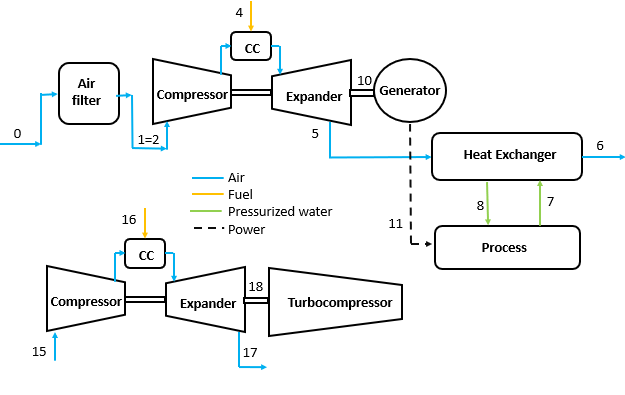

In [7]:
from IPython.display import Image
print("Base Case + CO2 compression system")
Image(filename='Base_Case.png')

In [17]:
# Base case
DELTAP_HRSG_Projeto = 9.12
DELTAP_entrada = DELTAP_filtro
DELTAP_HRSG = DELTAP_HRSG_Projeto
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS BaseCase')
cur.execute('DROP TABLE IF EXISTS BaseCaseWithoutCO2')
cur.execute('CREATE TABLE BaseCase (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, CO2EmitCO2 REAL, EtaExergCO2 REAL, EtaExergTotal REAL, CO2EmitTotal REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, RelmCO2CO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL)')
cur.execute('CREATE TABLE BaseCaseWithoutCO2 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, WTDispTotal REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL)')
conn.commit()
cur.close()

for i in range(22):
    NTurb1 = list()
    CargaOperTurb1 = list()
    QGasProdOffDispInd1 = list()
    QGasProdOffDisTotal1 = list()
    FACogeração1 = list()
    CO2Emit1 = list()
    EtaExerg1 = list()
    CO2EmitCo21 = list()
    EtaExergCO21 = list()
    EtaExergTotal1 = list()
    CO2EmitTotal1 = list()
    DeltaWOper1 = list()
    RelMCO2MCO2Total1 = list()
    RelMCO2CO2MCO2Total1 = list()
    EtaOperTurb1 = list()
    Epsilon_HRSG1 = list()
    EtaExergHRSG1 = list()
    NTurb2 = list()
    CargaOperTurb2 = list()
    QGasProdOffDispInd2 = list()
    QGasProdOffDispTotal2 = list()
    FACogeração2 = list()
    CO2Emit2 = list()
    EtaExerg2 = list()
    DeltaWOper2 = list()
    EtaOperTurb2 = list()
    Epsilon_HRSG2 = list()
    EtaExergHRSG2 = list()
    for j in range(12):
        #print('mes', j)
        Ponto0 = {'T': (ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':P_amb,
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto1 = {'T':(ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':(P_amb-DELTAP_entrada*248.84),
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_entrada*248.84)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_entrada*248.84)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_entrada*248.84)}
        Ponto2 = Ponto1
        Ponto3 = {}
        PlantaCO2 = True
#             Planta principal
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
        TurbOffdesign = turboffdesign(demandas['principal'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_HRSG) 
        #print('Ponto 2', Ponto2)
        excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_HRSG * 248.84,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Configuração = 'Caso Base'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto5)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        DELTAW_Oper = TurbOffdesign['WT_disp_total']/1000
        #DELTAW_oper1 = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['principal'][i]   
        #print('DELTAW_Oper', DELTAW_Oper, 'DELTAW_oper1', DELTAW_oper1)
#             Planta de CO2
        Ponto14 = Ponto0
        Ponto15 = Ponto1
        TurbProj_CO2 = tgprojeto(TG_CO2,PCI_GN_m,Perc_ar_resf)
        TurbOffdesign_CO2 = turboffdesign(demandas['co2'][i],TG_CO2,Ponto15,PCI_GN_m,PCI_fuel(),eta_ger_CO2,DELTAP_entrada_CO2,DELTAP_HRSG_CO2) 
        excesso_CO2, T_chama_CO2, molar_fraction_prod_CO2,Ponto16 = combustor(T_comb,fuel_mol,Ponto15,TurbProj_CO2,TurbOffdesign_CO2)
        Ponto17 = {'T':TurbOffdesign_CO2['T_gas_exaust']+273.15,'P':101325,'m':TurbOffdesign_CO2['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto17)
        Ponto17.update({'H':props['H'],'S':props['S'],'cp':props['cp']})
        DELTAW_oper_CO2 = TurbOffdesign_CO2['n_turb_real']*TurbOffdesign_CO2['WTmaximo']/1000-demandas['co2'][i]
        Ponto18 = {'E':TurbOffdesign_CO2['WT_real']*eta_ger_CO2/100}
        Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb1.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb1.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd1.append(Q_gasprod_off_disp_ind)
        QGasProdOffDisTotal1.append(Q_gasprod_off_disp_total)
        FACogeração1.append(FA_coger)
        CO2Emit1.append(CO2_emit)
        EtaExerg1.append(eta_exerg)
        CO2EmitCo21.append(CO2_emit_CO2)
        EtaExergCO21.append(eta_exerg_CO2)
        EtaExergTotal1.append(eta_exerg_total)
        CO2EmitTotal1.append(CO2_emit_total)
        DeltaWOper1.append(DELTAW_Oper)
        RelMCO2MCO2Total1.append(Rel_m_CO2_m_CO2_total)
        RelMCO2CO2MCO2Total1.append(Rel_m_CO2_CO2_m_CO2_total)
        EtaOperTurb1.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG1.append(Epsilon_HRSG/100)
        EtaExergHRSG1.append(EtaExergHRSG)
        PlantaCO2 = False
#           Planta principal suprindo demanda principal e de CO2
        TurbOffdesign = turboffdesign(demandas['total'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_HRSG) 
        excesso, T_chama, molar_fraction_prod, Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_HRSG * 9.806650,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Configuração = 'Caso Base'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto5)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['total'][i]    
        molar_fraction_prod_CO2 = {}
        TurbOffdesign_CO2 = {}
        CO2_emit, FA_coger, eta_exerg = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb2.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb2.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd2.append(Q_gasprod_off_disp_ind)
        QGasProdOffDispTotal2.append(Q_gasprod_off_disp_total)
        FACogeração2.append(FA_coger)
        CO2Emit2.append(CO2_emit)
        EtaExerg2.append(eta_exerg)
        DeltaWOper2.append(DELTAW_oper)
        EtaOperTurb2.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG2.append(Epsilon_HRSG/100)
        EtaExergHRSG2.append(EtaExergHRSG)
#         Inserir valores no banco de dados
    conn = sqlite3.connect('FPSO2.sqlite')
    cur = conn.cursor()
    cur.execute(''' INSERT INTO BaseCase (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,CO2EmitCO2,EtaExergCO2,EtaExergTotal,CO2EmitTotal,WTDispTotal,RelmCO2mCO2Total,RelmCO2CO2mCO2Total,EtaOperTurb, Epsilon_HRSG, EtaExergHRSG) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb1),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb1),np.mean(QGasProdOffDispInd1),np.mean(QGasProdOffDisTotal1),np.mean(FACogeração1),np.mean(CO2Emit1),np.mean(EtaExerg1),np.mean(CO2EmitCo21),np.mean(EtaExergCO21),np.mean(EtaExergTotal1),np.mean(CO2EmitTotal1),np.mean(DeltaWOper1),np.mean(RelMCO2MCO2Total1),np.mean(RelMCO2CO2MCO2Total1), np.mean(EtaOperTurb1), np.mean(Epsilon_HRSG1), np.mean(EtaExergHRSG1)))
    cur.execute(''' INSERT INTO BaseCaseWithoutCO2 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,WTDispTotal, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb2),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb2),np.mean(QGasProdOffDispInd2),np.mean(QGasProdOffDispTotal2),np.mean(FACogeração2),np.mean(CO2Emit2),np.mean(EtaExerg2),np.mean(DeltaWOper2), np.mean(EtaOperTurb2), np.mean(Epsilon_HRSG2), np.mean(EtaExergHRSG2)))
    conn.commit()
    cur.close()
    print('Ponto0', Ponto0)
    print('Ponto1', Ponto1)
    print('Ponto2', Ponto2)
    print('Ponto3', Ponto3)
    print('Ponto4', Ponto4)
    print('Ponto5', Ponto5)
    print('Ponto6', Ponto6)
    print('Ponto7', Ponto7)
    print('Ponto8', Ponto8)
    print('Ponto10', Ponto10)
    print('Ponto11', Ponto11)
    print('Ponto15', Ponto15)
    print('Ponto16', Ponto16)
    print('Ponto17', Ponto17)
    print('Ponto18', Ponto18)
    


KeyboardInterrupt: 

In [ ]:
TurbOffdesign['WTmaximo']

Base Case + Compression cooling system and CO2 compression system


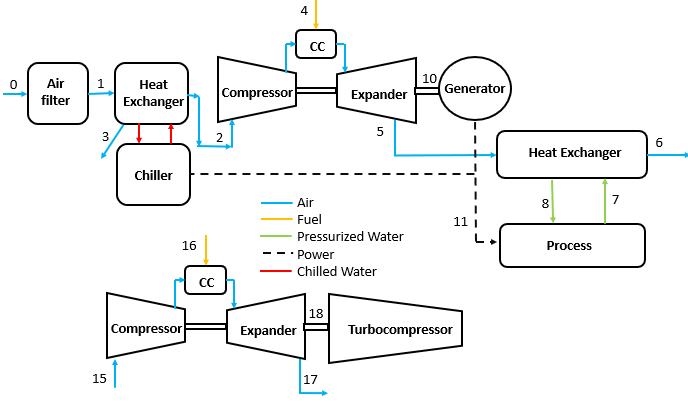

In [8]:
from IPython.display import Image
print("Base Case + Compression cooling system and CO2 compression system")
Image(filename='SRC.png')

In [60]:
# Compression cooling system
DELTAP_HRSG_Projeto = 9.12
DELTAP_AirCooler_Projeto = 4.799
DELTAP_HRSG = DELTAP_HRSG_Projeto
DELTAP_entrada = DELTAP_filtro + DELTAP_AirCooler_Projeto

conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS SRC')
cur.execute('DROP TABLE IF EXISTS SRCWithoutCO2')
cur.execute('CREATE TABLE SRC (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, CO2EmitCO2 REAL, EtaExergCO2 REAL, EtaExergTotal REAL, CO2EmitTotal REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, RelmCO2CO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, Psi_chiller REAL, Epsilon_chiller REAL)')
cur.execute('CREATE TABLE SRCWithoutCO2 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, WTDispTotal REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, Psi_chiller REAL, Epsilon_chiller REAL)')
conn.commit()
cur.close()

for i in range(22):
    NTurb1 = list()
    CargaOperTurb1 = list()
    QGasProdOffDispInd1 = list()
    QGasProdOffDisTotal1 = list()
    FACogeração1 = list()
    CO2Emit1 = list()
    EtaExerg1 = list()
    CO2EmitCo21 = list()
    EtaExergCO21 = list()
    EtaExergTotal1 = list()
    CO2EmitTotal1 = list()
    DeltaWOper1 = list()
    RelMCO2MCO2Total1 = list()
    RelMCO2CO2MCO2Total1 = list()
    EtaOperTurb1 = list()
    Epsilon_HRSG1 = list()
    EtaExergHRSG1 = list()
    Psi_Chiller1 = list()
    Epsilon_Resfriador1 = list()
    
    NTurb2 = list()
    CargaOperTurb2 = list()
    QGasProdOffDispInd2 = list()
    QGasProdOffDispTotal2 = list()
    FACogeração2 = list()
    CO2Emit2 = list()
    EtaExerg2 = list()
    DeltaWOper2 = list()
    EtaOperTurb2 = list()
    Epsilon_HRSG2 = list()
    EtaExergHRSG2 = list()
    Psi_Chiller2 = list()
    Epsilon_Resfriador2 = list()
    for j in range(12):
        print('mes', j)
        Ponto0 = {'T': (ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':P_amb,
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto1 = {'T':(ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':(P_amb-DELTAP_filtro*249),
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_filtro*249)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_filtro*249)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_filtro*249)}
        PlantaCO2 = True
#             Planta principal
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
        Sistema = 'Compressão'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['principal'][i]
        while True:
            ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
            TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_HRSG)
            DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401474
            #print('DELTA_P_Off', ResfComp['DELTA_P_Off'])
            Potencia = demandas['principal'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
            #print('WT chiller',ResfComp['WT_chiller'], 'potencia', Potencia)
            #print('DELTAP_entrada', DELTAP_entrada, 'm ar off', m_ar_off)
            if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.01):
                m_ar_off = TurbOffdesign['m_ar_real']
            else: break
        excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto3 = dict()
        Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
        Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_HRSG * 249,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Configuração = 'ResfriamentoSRC'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto5)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        Psi_Chiller = ResfComp['psi_Chiller']
        Epsilon_Resfriador = ResfComp['Epsilon_resfriador']
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000 - demandas['principal'][i] - ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
#             Planta de CO2
        Ponto14 = Ponto0
        Ponto15 = Ponto1
        TurbProj_CO2 = tgprojeto(TG_CO2,PCI_GN_m,Perc_ar_resf)
        TurbOffdesign_CO2 = turboffdesign(demandas['co2'][i],TG_CO2,Ponto15,PCI_GN_m,PCI_fuel(),eta_ger_CO2,DELTAP_entrada_CO2,DELTAP_HRSG_CO2) 
        excesso_CO2, T_chama_CO2, molar_fraction_prod_CO2,Ponto16 = combustor(T_comb,fuel_mol,Ponto15,TurbProj_CO2,TurbOffdesign_CO2)
        Ponto17 = {'T':TurbOffdesign_CO2['T_gas_exaust']+273.15,'P':101325,'m':TurbOffdesign_CO2['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto17)
        Ponto17.update({'H':props['H'],'S':props['S'],'cp':props['cp']})
        Ponto18 = {'E':TurbOffdesign_CO2['WT_real']*eta_ger_CO2/100}
        DELTAW_oper_CO2 = TurbOffdesign_CO2['n_turb_real']*TurbOffdesign_CO2['WTmaximo']/1000-demandas['co2'][i]
        Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb1.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb1.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd1.append(Q_gasprod_off_disp_ind)
        QGasProdOffDisTotal1.append(Q_gasprod_off_disp_total)
        FACogeração1.append(FA_coger)
        CO2Emit1.append(CO2_emit)
        EtaExerg1.append(eta_exerg)
        CO2EmitCo21.append(CO2_emit_CO2)
        EtaExergCO21.append(eta_exerg_CO2)
        EtaExergTotal1.append(eta_exerg_total)
        CO2EmitTotal1.append(CO2_emit_total)
        DeltaWOper1.append(DELTAW_oper)
        RelMCO2MCO2Total1.append(Rel_m_CO2_m_CO2_total)
        RelMCO2CO2MCO2Total1.append(Rel_m_CO2_CO2_m_CO2_total)
        EtaOperTurb1.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG1.append(Epsilon_HRSG/100)
        EtaExergHRSG1.append(EtaExergHRSG)
        Psi_Chiller1.append(Psi_Chiller)
        Epsilon_Resfriador1.append(Epsilon_Resfriador)
#           Planta principal suprindo demanda principal e de CO2
        PlantaCO2 = False
        DELTAP_entrada = DELTAP_filtro + DELTAP_AirCooler_Projeto
        Sistema = 'Compressão'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['total'][i]
        while True:
            ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
            TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_HRSG)
            DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
            Potencia = demandas['total'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
            if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.02):
                m_ar_off = TurbOffdesign['m_ar_real']
            else: break
        excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto3 = dict()
        Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
        Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_HRSG * 9.806650,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Configuração = 'ResfriamentoSRC'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto5)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000 - demandas['total'][i] - ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        Psi_Chiller = ResfComp['psi_Chiller']
        Epsilon_Resfriador = ResfComp['Epsilon_resfriador']
        molar_fraction_prod_CO2 = {}
        TurbOffdesign_CO2 = {}
        CO2_emit, FA_coger, eta_exerg = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb2.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb2.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd2.append(Q_gasprod_off_disp_ind)
        QGasProdOffDispTotal2.append(Q_gasprod_off_disp_total)
        FACogeração2.append(FA_coger)
        CO2Emit2.append(CO2_emit)
        EtaExerg2.append(eta_exerg)
        DeltaWOper2.append(DELTAW_oper)
        EtaOperTurb2.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG2.append(Epsilon_HRSG/100)
        EtaExergHRSG2.append(EtaExergHRSG)
        Psi_Chiller2.append(Psi_Chiller)
        Epsilon_Resfriador2.append(Epsilon_Resfriador)
#         Inserir valores no banco de dados
    conn = sqlite3.connect('FPSO2.sqlite')
    cur = conn.cursor()
    cur.execute(''' INSERT INTO SRC (year, day, nturb, ThermalProc, PowerPrincipal, PowerCompCO2, CargaOper, QGasProdDispInd, QGasProdDispTot, FACoger, CO2Emit, EtaExerg, CO2EmitCO2, EtaExergCO2, EtaExergTotal, CO2EmitTotal, WTDispTotal, RelmCO2mCO2Total, RelmCO2CO2mCO2Total, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, Psi_chiller, Epsilon_chiller) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb1),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb1),np.mean(QGasProdOffDispInd1),np.mean(QGasProdOffDisTotal1),np.mean(FACogeração1),np.mean(CO2Emit1),np.mean(EtaExerg1),np.mean(CO2EmitCo21),np.mean(EtaExergCO21),np.mean(EtaExergTotal1),np.mean(CO2EmitTotal1),np.mean(DeltaWOper1),np.mean(RelMCO2MCO2Total1),np.mean(RelMCO2CO2MCO2Total1), np.mean(EtaOperTurb1), np.mean(Epsilon_HRSG1), np.mean(EtaExergHRSG1), np.mean(Psi_Chiller1), np.mean(Epsilon_Resfriador1)))
    cur.execute(''' INSERT INTO SRCWithoutCO2 (year, day, nturb, ThermalProc, PowerPrincipal, PowerCompCO2, CargaOper, QGasProdDispInd, QGasProdDispTot, FACoger, CO2Emit, EtaExerg, WTDispTotal, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, Psi_chiller, Epsilon_chiller) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb2),demandas['termico'][i],demandas['total'][i],demandas['co2'][i],np.mean(CargaOperTurb2),np.mean(QGasProdOffDispInd2),np.mean(QGasProdOffDispTotal2),np.mean(FACogeração2),np.mean(CO2Emit2),np.mean(EtaExerg2),np.mean(DeltaWOper2), np.mean(EtaOperTurb2), np.mean(Epsilon_HRSG2), np.mean(EtaExergHRSG2), np.mean(Psi_Chiller2), np.mean(Epsilon_Resfriador2)))
    conn.commit()
    cur.close()

mes 0
t2 hot off 761.6975360738545
eta exerg hrsg 34676.86878582445
t2 hot off 769.5068586959429
eta exerg hrsg 34529.420799746236
mes 1
t2 hot off 761.9328586221408
eta exerg hrsg 34670.500499232825
t2 hot off 769.1789220025352
eta exerg hrsg 34530.16451503636
mes 2
t2 hot off 761.67014217263
eta exerg hrsg 34676.44448132512
t2 hot off 769.5485140755628
eta exerg hrsg 34528.13679158192
mes 3
t2 hot off 762.0533820696958
eta exerg hrsg 34663.8428700221
t2 hot off 769.0295446968037
eta exerg hrsg 34526.964339145896
mes 4
t2 hot off 762.2584307446821
eta exerg hrsg 34654.87334060665
t2 hot off 768.3398823876573
eta exerg hrsg 34528.440505867926
mes 5
t2 hot off 762.5634872568934
eta exerg hrsg 34650.71625851144
t2 hot off 767.9777522640446
eta exerg hrsg 34532.8275003142
mes 6
t2 hot off 762.7807635600188
eta exerg hrsg 34643.30574461273
t2 hot off 767.72406453593
eta exerg hrsg 34531.461054051746
mes 7
t2 hot off 763.0809063692506
eta exerg hrsg 34636.610547408025
t2 hot off 767.3753829

t2 hot off 755.88939680955
eta exerg hrsg 34765.43223680847
t2 hot off 768.5867075791916
eta exerg hrsg 34714.458530498225
mes 4
t2 hot off 756.0476130155523
eta exerg hrsg 34756.976172163726
t2 hot off 768.5759272133054
eta exerg hrsg 34709.17877011588
mes 5
t2 hot off 756.2228481808517
eta exerg hrsg 34754.59894845785
t2 hot off 768.5770038658964
eta exerg hrsg 34709.70644552494
mes 6
t2 hot off 756.3510103828464
eta exerg hrsg 34748.417996729
t2 hot off 768.5694753238647
eta exerg hrsg 34706.01489611539
mes 7
t2 hot off 756.5321777298466
eta exerg hrsg 34743.355339919566
t2 hot off 768.5656647958695
eta exerg hrsg 34704.144877895094
mes 8
t2 hot off 756.3506635716884
eta exerg hrsg 34752.95071770283
t2 hot off 768.5779258701314
eta exerg hrsg 34710.15826006872
mes 9
t2 hot off 756.174894788728
eta exerg hrsg 34760.43047072678
t2 hot off 768.5863927618396
eta exerg hrsg 34714.30446542244
mes 10
t2 hot off 756.1284807118766
eta exerg hrsg 34762.22863971476
t2 hot off 768.5882928624044

t2 hot off 755.994263473611
eta exerg hrsg 34753.176161611016
t2 hot off 769.3572359619546
eta exerg hrsg 34697.99296572349
mes 7
t2 hot off 756.1617048895547
eta exerg hrsg 34748.3018296587
t2 hot off 769.3534310372006
eta exerg hrsg 34696.12439973277
mes 8
t2 hot off 755.9939330118968
eta exerg hrsg 34757.712167915466
t2 hot off 769.3656737890103
eta exerg hrsg 34702.13311382569
mes 9
t2 hot off 755.83222054451
eta exerg hrsg 34765.000775246546
t2 hot off 769.3741275313915
eta exerg hrsg 34706.276103910954
mes 10
t2 hot off 755.789652053964
eta exerg hrsg 34766.746443768694
t2 hot off 769.3760246252732
eta exerg hrsg 34707.20514476306
mes 11
t2 hot off 755.6632387530558
eta exerg hrsg 34767.855033550244
t2 hot off 769.3740388021906
eta exerg hrsg 34706.232645471486
mes 0
t2 hot off 755.5338130654015
eta exerg hrsg 34777.33911503182
t2 hot off 769.0236916362072
eta exerg hrsg 34716.913784801734
mes 1
t2 hot off 755.6513968080627
eta exerg hrsg 34772.59927343274
t2 hot off 769.01864255

t2 hot off 759.2289108259902
eta exerg hrsg 34708.0244236863
t2 hot off 766.2280042706702
eta exerg hrsg 34738.65771395418
mes 10
t2 hot off 759.1604874065663
eta exerg hrsg 34710.129002161666
t2 hot off 766.3291720906478
eta exerg hrsg 34738.54342621191
mes 11
t2 hot off 758.9918770752245
eta exerg hrsg 34711.74220939153
t2 hot off 766.9973043850781
eta exerg hrsg 34730.53676376351
mes 0
t2 hot off 769.0747412934993
eta exerg hrsg 34563.77620519329
t2 hot off 755.6107895275837
eta exerg hrsg 34859.63460349071
mes 1
t2 hot off 769.3345473985652
eta exerg hrsg 34557.091825736774
t2 hot off 755.4679745456109
eta exerg hrsg 34858.44362734511
mes 2
t2 hot off 769.0457478463899
eta exerg hrsg 34563.36931278044
t2 hot off 755.6291261141166
eta exerg hrsg 34858.650206087055
mes 3
t2 hot off 769.4598473891451
eta exerg hrsg 34550.389359650064
t2 hot off 755.4044793420994
eta exerg hrsg 34854.50997485104
mes 4
t2 hot off 769.6063481869871
eta exerg hrsg 34542.36181387517
t2 hot off 755.13617680

t2 hot off 774.0584373888671
eta exerg hrsg 34501.86226328167
t2 hot off 754.1612542297746
eta exerg hrsg 34868.07976943152
mes 1
t2 hot off 774.2918335352028
eta exerg hrsg 34495.55297062152
t2 hot off 754.1836817419604
eta exerg hrsg 34864.6926046044
mes 2
t2 hot off 774.0288694946336
eta exerg hrsg 34501.47618377455
t2 hot off 754.1589448033696
eta exerg hrsg 34867.36459441947
mes 3
t2 hot off 774.3978686792043
eta exerg hrsg 34489.15553377936
t2 hot off 754.1964250875243
eta exerg hrsg 34859.73023048781
mes 4
t2 hot off 774.481143608952
eta exerg hrsg 34482.117449023106
t2 hot off 754.2741286652672
eta exerg hrsg 34852.10066826447
mes 5
t2 hot off 774.7619887844911
eta exerg hrsg 34478.31350949677
t2 hot off 754.3273293208982
eta exerg hrsg 34851.37499265934
mes 6
t2 hot off 774.9573578433428
eta exerg hrsg 34471.247149578645
t2 hot off 754.370107184388
eta exerg hrsg 34846.54718179073
mes 7
t2 hot off 775.2219970336445
eta exerg hrsg 34465.06999716579
t2 hot off 754.4356271309566


Caso Base + Absorption cooling system and CO2 compression system


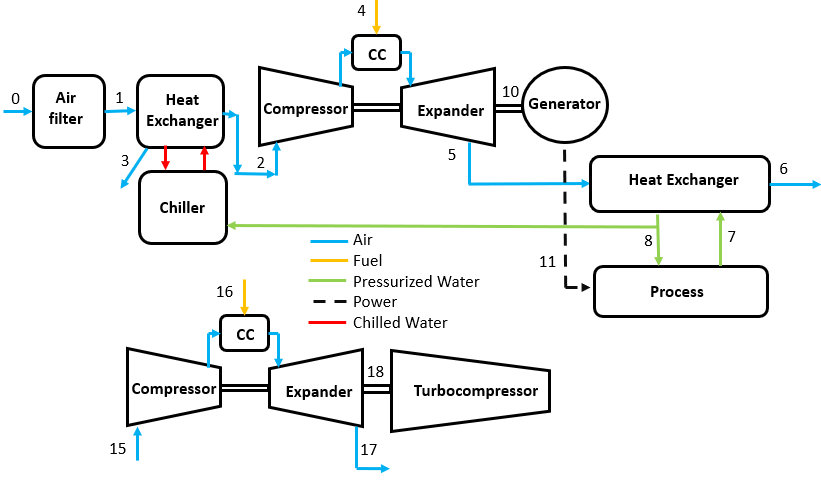

In [9]:
from IPython.display import Image
print("Caso Base + Absorption cooling system and CO2 compression system")
Image(filename='SRA.png')

In [61]:
# Absorption cooling system
DELTAP_HRSG_Projeto = 10.832
DELTAP_AirCooler_Projeto = 4.799
DELTAP_HRSG = DELTAP_HRSG_Projeto
DELTAP_entrada = DELTAP_filtro + DELTAP_AirCooler_Projeto

conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS SRA')
cur.execute('DROP TABLE IF EXISTS SRAWithoutCO2')
cur.execute('CREATE TABLE SRA (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, CO2EmitCO2 REAL, EtaExergCO2 REAL, EtaExergTotal REAL, CO2EmitTotal REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, RelmCO2CO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, Psi_Chiller REAL, Epsilon_Resfriador REAL)')
cur.execute('CREATE TABLE SRAWithoutCO2 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, Psi_Chiller REAL, Epsilon_Resfriador REAL)')
conn.commit()
cur.close()

for i in range(22):
    NTurb1 = list()
    CargaOperTurb1 = list()
    QGasProdOffDispInd1 = list()
    QGasProdOffDisTotal1 = list()
    FACogeração1 = list()
    CO2Emit1 = list()
    EtaExerg1 = list()
    CO2EmitCo21 = list()
    EtaExergCO21 = list()
    EtaExergTotal1 = list()
    CO2EmitTotal1 = list()
    DeltaWOper1 = list()
    RelMCO2MCO2Total1 = list()
    RelMCO2CO2MCO2Total1 = list()
    EtaOperTurb1 = list()
    Epsilon_HRSG1 = list()
    EtaExergHRSG1 = list()
    Psi_Chiller1 = list()
    Epsilon_Resfriador1 = list()
    NTurb2 = list()
    CargaOperTurb2 = list()
    QGasProdOffDispInd2 = list()
    QGasProdOffDispTotal2 = list()
    FACogeração2 = list()
    CO2Emit2 = list()
    EtaExerg2 = list()
    DeltaWOper2 = list()
    EtaOperTurb2 = list()
    Epsilon_HRSG2 = list()
    EtaExergHRSG2 = list()
    Psi_Chiller2 = list()
    Epsilon_Resfriador2 = list()
    for j in range(12):
        Ponto0 = {'T': (ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':P_amb,
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto1 = {'T':(ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':(P_amb-DELTAP_filtro*248.84),
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_filtro*248.84)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_filtro*248.84)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb-DELTAP_filtro*248.84)}
        PlantaCO2 = True
#             Planta principal
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
        DELTAP_entrada = DELTAP_filtro + DELTAP_AirCooler_Projeto
        Sistema = 'Absorção'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['principal'][i]
        while True:
            ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
            TurbOffdesign = turboffdesign(demandas['principal'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_HRSG)
            DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
            if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.02):
                m_ar_off = TurbOffdesign['m_ar_real']
            else: break
        excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto3 = dict()
        Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
        Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_HRSG * 9.806650,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Configuração = 'ResfriamentoSRA'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto5)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000 - demandas['principal'][i]
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        Psi_Chiller = ResfComp['psi_Chiller']
        Epsilon_Resfriador = ResfComp['Epsilon_resfriador']
#             Planta de CO2
        Ponto14 = Ponto0
        Ponto15 = Ponto1
        TurbProj_CO2 = tgprojeto(TG_CO2,PCI_GN_m,Perc_ar_resf)
        TurbOffdesign_CO2 = turboffdesign(demandas['co2'][i],TG_CO2,Ponto15,PCI_GN_m,PCI_fuel(),eta_ger_CO2,DELTAP_entrada_CO2,DELTAP_HRSG_CO2) 
        excesso_CO2, T_chama_CO2, molar_fraction_prod_CO2,Ponto16 = combustor(T_comb,fuel_mol,Ponto15,TurbProj_CO2,TurbOffdesign_CO2)
        Ponto17 = {'T':TurbOffdesign_CO2['T_gas_exaust']+273.15,'P':101325,'m':TurbOffdesign_CO2['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto17)
        Ponto17.update({'H':props['H'],'S':props['S'],'cp':props['cp']})
        Ponto18 = {'E':TurbOffdesign_CO2['WT_real']*eta_ger_CO2/100}
        DELTAW_oper_CO2 = TurbOffdesign_CO2['n_turb_real']*TurbOffdesign_CO2['WTmaximo']/1000-demandas['co2'][i]
        Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb1.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb1.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd1.append(Q_gasprod_off_disp_ind)
        QGasProdOffDisTotal1.append(Q_gasprod_off_disp_total)
        FACogeração1.append(FA_coger)
        CO2Emit1.append(CO2_emit)
        EtaExerg1.append(eta_exerg)
        CO2EmitCo21.append(CO2_emit_CO2)
        EtaExergCO21.append(eta_exerg_CO2)
        EtaExergTotal1.append(eta_exerg_total)
        CO2EmitTotal1.append(CO2_emit_total)
        DeltaWOper1.append(DELTAW_oper)
        RelMCO2MCO2Total1.append(Rel_m_CO2_m_CO2_total)
        RelMCO2CO2MCO2Total1.append(Rel_m_CO2_CO2_m_CO2_total)
        EtaOperTurb1.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG1.append(Epsilon_HRSG/100)
        EtaExergHRSG1.append(EtaExergHRSG)
        Psi_Chiller1.append(Psi_Chiller)
        Epsilon_Resfriador1.append(Epsilon_Resfriador)
#           Planta principal suprindo demanda principal e de CO2
        PlantaCO2 = False
        DELTAP_entrada = DELTAP_filtro + DELTAP_AirCooler_Projeto
        Sistema = 'Absorção'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['total'][i]
        while True:
            ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
            TurbOffdesign = turboffdesign(demandas['total'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_HRSG)
            DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
            if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.02):
                m_ar_off = TurbOffdesign['m_ar_real']
            else: break
        excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto3 = dict()
        Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
        Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_HRSG * 9.806650,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Configuração = 'ResfriamentoSRC'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto5)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000 - demandas['total'][i]
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        Psi_Chiller = ResfComp['psi_Chiller']
        Epsilon_Resfriador = ResfComp['Epsilon_resfriador']
        molar_fraction_prod_CO2 = {}
        TurbOffdesign_CO2 = {}
        CO2_emit, FA_coger, eta_exerg = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb2.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb2.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd2.append(Q_gasprod_off_disp_ind)
        QGasProdOffDispTotal2.append(Q_gasprod_off_disp_total)
        FACogeração2.append(FA_coger)
        CO2Emit2.append(CO2_emit)
        EtaExerg2.append(eta_exerg)
        DeltaWOper2.append(DELTAW_oper)
        EtaOperTurb2.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG2.append(Epsilon_HRSG/100)
        EtaExergHRSG2.append(EtaExergHRSG)
        Psi_Chiller2.append(Psi_Chiller)
        Epsilon_Resfriador2.append(Epsilon_Resfriador)
#         Inserir valores no banco de dados
    conn = sqlite3.connect('FPSO2.sqlite')
    cur = conn.cursor()
    cur.execute(''' INSERT INTO SRA (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,CO2EmitCO2,EtaExergCO2,EtaExergTotal,CO2EmitTotal,WTDispTotal,RelmCO2mCO2Total,RelmCO2CO2mCO2Total, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, Psi_chiller, Epsilon_Resfriador) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb1),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb1),np.mean(QGasProdOffDispInd1),np.mean(QGasProdOffDisTotal1),np.mean(FACogeração1),np.mean(CO2Emit1),np.mean(EtaExerg1),np.mean(CO2EmitCo21),np.mean(EtaExergCO21),np.mean(EtaExergTotal1),np.mean(CO2EmitTotal1),np.mean(DeltaWOper1),np.mean(RelMCO2MCO2Total1),np.mean(RelMCO2CO2MCO2Total1), np.mean(EtaOperTurb1), np.mean(Epsilon_HRSG1), np.mean(EtaExergHRSG1), np.mean(Psi_Chiller1), np.mean(Epsilon_Resfriador1)))
    cur.execute(''' INSERT INTO SRAWithoutCO2 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,WTDispTotal, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, Psi_chiller, Epsilon_Resfriador) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb2),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb2),np.mean(QGasProdOffDispInd2),np.mean(QGasProdOffDispTotal2),np.mean(FACogeração2),np.mean(CO2Emit2),np.mean(EtaExerg2),np.mean(DeltaWOper2), np.mean(EtaOperTurb2), np.mean(Epsilon_HRSG2), np.mean(EtaExergHRSG2), np.mean(Psi_Chiller2), np.mean(Epsilon_Resfriador2)))
    conn.commit()
    cur.close()

t2 hot off 764.0232838307162
eta exerg hrsg 34706.20039530417
t2 hot off 766.1617482313865
eta exerg hrsg 34563.36737862978
t2 hot off 764.0265093938476
eta exerg hrsg 34703.55501039462
t2 hot off 766.1592879747279
eta exerg hrsg 34560.686837514244
t2 hot off 764.0242988349108
eta exerg hrsg 34705.368146194065
t2 hot off 766.1609740220047
eta exerg hrsg 34562.52406993265
t2 hot off 764.0322092664145
eta exerg hrsg 34698.87611491393
t2 hot off 766.1549411060378
eta exerg hrsg 34555.945743327946
t2 hot off 764.0390941428847
eta exerg hrsg 34693.217229092836
t2 hot off 766.14969160487
eta exerg hrsg 34550.211601131385
t2 hot off 764.0384065131378
eta exerg hrsg 34693.782769240046
t2 hot off 766.1502158476695
eta exerg hrsg 34550.784663666
t2 hot off 764.0432149144997
eta exerg hrsg 34689.82644710988
t2 hot off 766.146550212389
eta exerg hrsg 34546.77571041991
t2 hot off 764.0456487661504
eta exerg hrsg 34687.82241294437
t2 hot off 766.1446950104769
eta exerg hrsg 34544.74501054689
t2 hot 

t2 hot off 769.1179836687958
eta exerg hrsg 34699.38493143121
t2 hot off 757.1317750369583
eta exerg hrsg 34795.10783255952
t2 hot off 769.114174896891
eta exerg hrsg 34697.514890798644
t2 hot off 757.1263296998168
eta exerg hrsg 34801.500264732495
t2 hot off 769.1264301181354
eta exerg hrsg 34703.52835474718
t2 hot off 757.1225717640616
eta exerg hrsg 34805.90819384475
t2 hot off 769.1348926238219
eta exerg hrsg 34707.67463274198
t2 hot off 757.1217286886668
eta exerg hrsg 34806.89668674783
t2 hot off 769.1367917014521
eta exerg hrsg 34708.60441230921
t2 hot off 757.1226111980098
eta exerg hrsg 34805.861954527136
t2 hot off 769.1348038014867
eta exerg hrsg 34707.63113948645
t2 hot off 756.8235218699847
eta exerg hrsg 34818.0773395282
t2 hot off 769.2543328303517
eta exerg hrsg 34713.591670752015
t2 hot off 756.8256684623981
eta exerg hrsg 34815.455216898896
t2 hot off 769.2492864211625
eta exerg hrsg 34711.124103412294
t2 hot off 756.8241972811991
eta exerg hrsg 34817.25241118429
t2 h

t2 hot off 756.8982237537633
eta exerg hrsg 34814.22269800939
t2 hot off 769.5665424847409
eta exerg hrsg 34707.8514259977
t2 hot off 756.8967364710376
eta exerg hrsg 34816.02027844346
t2 hot off 769.5699948886098
eta exerg hrsg 34709.54229084792
t2 hot off 756.902060022056
eta exerg hrsg 34809.583898888464
t2 hot off 769.5576405793148
eta exerg hrsg 34703.487809424296
t2 hot off 756.9066964362316
eta exerg hrsg 34803.973421221104
t2 hot off 769.546888036161
eta exerg hrsg 34698.209760973215
t2 hot off 756.9062332454436
eta exerg hrsg 34804.53412774166
t2 hot off 769.5479619470882
eta exerg hrsg 34698.73726414664
t2 hot off 756.9094727993044
eta exerg hrsg 34800.61159995959
t2 hot off 769.5404524071773
eta exerg hrsg 34695.046925616654
t2 hot off 756.9111130784615
eta exerg hrsg 34798.62466639843
t2 hot off 769.5366513452185
eta exerg hrsg 34693.177525625935
t2 hot off 756.9058366120046
eta exerg hrsg 34805.014228514505
t2 hot off 769.5488815969238
eta exerg hrsg 34699.18893153195
t2 h

t2 hot off 771.4685673812658
eta exerg hrsg 34575.73711107928
t2 hot off 754.5421802224602
eta exerg hrsg 34850.00358613762
t2 hot off 771.4612374817202
eta exerg hrsg 34582.19478801766
t2 hot off 754.5445799791389
eta exerg hrsg 34856.251272435766
t2 hot off 771.4561747822595
eta exerg hrsg 34586.64778974892
t2 hot off 754.5462414526266
eta exerg hrsg 34860.55922603569
t2 hot off 771.4550385185596
eta exerg hrsg 34587.64639967962
t2 hot off 754.5466147978518
eta exerg hrsg 34861.52528058253
t2 hot off 771.4562279255333
eta exerg hrsg 34586.601077234154
t2 hot off 754.5462239952024
eta exerg hrsg 34860.514036213186
t2 hot off 758.3411723795725
eta exerg hrsg 34831.269544898925
t2 hot off 769.7626810296595
eta exerg hrsg 34619.628352269894
t2 hot off 758.3378403969996
eta exerg hrsg 34828.75330282959
t2 hot off 769.7658349257606
eta exerg hrsg 34616.97795804917
t2 hot off 758.3401237478305
eta exerg hrsg 34830.47793623567
t2 hot off 769.7636735184233
eta exerg hrsg 34618.794526757105
t2

Base Case + ORC (Config. 1) and CO2 compression system


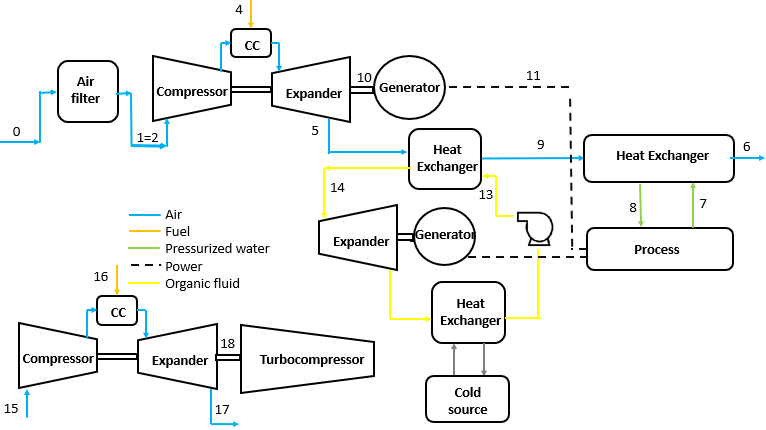

In [10]:
from IPython.display import Image
print("Base Case + ORC (Config. 1) and CO2 compression system")
Image(filename='ORC.png')

In [56]:
# Organic Rankine System - Configuration 1 - ORC 1 MWe full charge
DELTAP_HRSG_Projeto = 11.63
DELTAP_ORC_Projeto = 0.7484
DELTAP_entrada = DELTAP_filtro
DELTAP_exhaust = DELTAP_HRSG_Projeto + DELTAP_ORC_Projeto
Power_ORC = 1000

conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS ORC')
cur.execute('DROP TABLE IF EXISTS ORCWithoutCO2')
cur.execute('CREATE TABLE ORC (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, CO2EmitCO2 REAL, EtaExergCO2 REAL, EtaExergTotal REAL, CO2EmitTotal REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, RelmCO2CO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL)')
cur.execute('CREATE TABLE ORCWithoutCO2 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL)')
conn.commit()
cur.close()

for i in range(22):
    NTurb1 = list()
    CargaOperTurb1 = list()
    QGasProdOffDispInd1 = list()
    QGasProdOffDisTotal1 = list()
    FACogeração1 = list()
    CO2Emit1 = list()
    EtaExerg1 = list()
    CO2EmitCo21 = list()
    EtaExergCO21 = list()
    EtaExergTotal1 = list()
    CO2EmitTotal1 = list()
    DeltaWOper1 = list()
    RelMCO2MCO2Total1 = list()
    RelMCO2CO2MCO2Total1 = list()
    EtaOperTurb1 = list()
    Epsilon_HRSG1 = list()
    EtaExergHRSG1 = list()
    EtaExergHEORC1 = list()
    Epsilon_HE_ORC1 = list()
    EtaExergORC1 = list()
    
    NTurb2 = list()
    CargaOperTurb2 = list()
    QGasProdOffDispInd2 = list()
    QGasProdOffDispTotal2 = list()
    FACogeração2 = list()
    CO2Emit2 = list()
    EtaExerg2 = list()
    DeltaWOper2 = list()
    EtaOperTurb2 = list()
    Epsilon_HRSG2 = list()
    EtaExergHRSG2 = list()
    EtaExergHEORC2 = list()
    Epsilon_HE_ORC2 = list()
    EtaExergORC2 = list()
    for j in range(12):
        Ponto0 = {'T': (ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':P_amb,
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto1 = {'T':(ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':(P_amb-DELTAP_filtro*9.80665),
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto2 = Ponto1
        Ponto3 = {}
        PlantaCO2 = True
#             Planta principal
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
#         calculo inicial
        TurbOffdesign = turboffdesign(demandas['principal'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust) 
#         determinação da potencia com base no numero de turbinas determinado acima
        Potencia = demandas['principal'][i] - Power_ORC * TurbOffdesign['n_turb_real']/1000
        TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust) 
        excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Q_ORC = 4500
        Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,Q_ORC)
        Configuração = 'ORC1'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        Eta_carnot_ORC = (1- ((Ponto5['T'] - Ponto9['T'])/2 + 273.15)/(25+273.15))
        EtaExergORC = 100 * Power_ORC / (Ponto5['m'] * (Ponto5['E'] - Ponto9['E']))
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['principal'][i]-Power_ORC * TurbOffdesign['n_turb_real']/1000
#             Planta de CO2
        Ponto14 = Ponto0
        Ponto15 = Ponto1
        TurbProj_CO2 = tgprojeto(TG_CO2,PCI_GN_m,Perc_ar_resf)
        TurbOffdesign_CO2 = turboffdesign(demandas['co2'][i],TG_CO2,Ponto15,PCI_GN_m,PCI_fuel(),eta_ger_CO2,DELTAP_entrada_CO2,DELTAP_HRSG_CO2) 
        excesso_CO2, T_chama_CO2, molar_fraction_prod_CO2,Ponto16 = combustor(T_comb,fuel_mol,Ponto15,TurbProj_CO2,TurbOffdesign_CO2)
        Ponto17 = {'T':TurbOffdesign_CO2['T_gas_exaust']+273.15,'P':101325,'m':TurbOffdesign_CO2['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto17)
        Ponto17.update({'H':props['H'],'S':props['S'],'cp':props['cp']})
        DELTAW_oper_CO2 = TurbOffdesign_CO2['n_turb_real']*TurbOffdesign_CO2['WTmaximo']/1000-demandas['co2'][i]
        Ponto18 = {'E':TurbOffdesign_CO2['WT_real']*eta_ger_CO2/100}
        Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb1.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb1.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd1.append(Q_gasprod_off_disp_ind)
        QGasProdOffDisTotal1.append(Q_gasprod_off_disp_total)
        FACogeração1.append(FA_coger)
        CO2Emit1.append(CO2_emit)
        EtaExerg1.append(eta_exerg)
        CO2EmitCo21.append(CO2_emit_CO2)
        EtaExergCO21.append(eta_exerg_CO2)
        EtaExergTotal1.append(eta_exerg_total)
        CO2EmitTotal1.append(CO2_emit_total)
        DeltaWOper1.append(DELTAW_oper)
        RelMCO2MCO2Total1.append(Rel_m_CO2_m_CO2_total)
        RelMCO2CO2MCO2Total1.append(Rel_m_CO2_CO2_m_CO2_total)
        EtaOperTurb1.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG1.append(Epsilon_HRSG)
        EtaExergHRSG1.append(EtaExergHRSG/100)
        EtaExergHEORC1.append(EtaExerg_HE_ORC)
        Epsilon_HE_ORC1.append(Epsilon_HE_ORC)
        EtaExergORC1.append(EtaExergORC)
        
#           Planta principal suprindo demanda principal e de CO2
        PlantaCO2 = False
#         calculo inicial
        TurbOffdesign = turboffdesign(demandas['total'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust) 
#         determinação da potencia com base no numero de turbinas determinado acima
        Potencia = demandas['total'][i] - Power_ORC * TurbOffdesign['n_turb_real']/1000
        TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust) 
        excesso, T_chama, molar_fraction_prod, Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        Q_ORC = 4500
        Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,Q_ORC)
        Configuração = 'ORC1'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['total'][i]-Power_ORC * TurbOffdesign['n_turb_real']/1000
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        molar_fraction_prod_CO2 = {}
        TurbOffdesign_CO2 = {}
        CO2_emit, FA_coger, eta_exerg = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        Eta_carnot_ORC = (1- ((Ponto5['T'] - Ponto9['T'])/2 + 273.15)/(25+273.15))
        EtaExergORC = 100 * Power_ORC / (Ponto5['m'] * (Ponto5['E'] - Ponto9['E']))
        NTurb2.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb2.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd2.append(Q_gasprod_off_disp_ind)
        QGasProdOffDispTotal2.append(Q_gasprod_off_disp_total)
        FACogeração2.append(FA_coger)
        CO2Emit2.append(CO2_emit)
        EtaExerg2.append(eta_exerg)
        DeltaWOper2.append(DELTAW_oper)
        EtaOperTurb2.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG2.append(Epsilon_HRSG)
        EtaExergHRSG2.append(EtaExergHRSG/100)
        EtaExergHEORC2.append(EtaExerg_HE_ORC)
        Epsilon_HE_ORC2.append(Epsilon_HE_ORC)
        EtaExergORC2.append(EtaExergORC)
#         Inserir valores no banco de dados
    conn = sqlite3.connect('FPSO2.sqlite')
    cur = conn.cursor()
    cur.execute(''' INSERT INTO ORC (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,CO2EmitCO2,EtaExergCO2,EtaExergTotal,CO2EmitTotal,WTDispTotal,RelmCO2mCO2Total,RelmCO2CO2mCO2Total, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb1),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb1),Power_ORC,np.mean(QGasProdOffDispInd1),np.mean(QGasProdOffDisTotal1),np.mean(FACogeração1),np.mean(CO2Emit1),np.mean(EtaExerg1),np.mean(CO2EmitCo21),np.mean(EtaExergCO21),np.mean(EtaExergTotal1),np.mean(CO2EmitTotal1),np.mean(DeltaWOper1),np.mean(RelMCO2MCO2Total1),np.mean(RelMCO2CO2MCO2Total1), np.mean(EtaOperTurb1), np.mean(Epsilon_HRSG1), np.mean(EtaExergHRSG1), np.mean(EtaExergHEORC1), np.mean(Epsilon_HE_ORC1), np.mean(EtaExergORC1)))
    cur.execute(''' INSERT INTO ORCWithoutCO2 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,WTDispTotal, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb2),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb2),Power_ORC,np.mean(QGasProdOffDispInd2),np.mean(QGasProdOffDispTotal2),np.mean(FACogeração2),np.mean(CO2Emit2),np.mean(EtaExerg2),np.mean(DeltaWOper2), np.mean(EtaOperTurb2), np.mean(Epsilon_HRSG2), np.mean(EtaExergHRSG2), np.mean(EtaExergHEORC2), np.mean(Epsilon_HE_ORC2), np.mean(EtaExergORC2)))
    conn.commit()
    cur.close()


Epsilon_HE_ORC 0.16007778652525162
eta exerg 55.73953864237063
t2 hot off 727.0509494146339
eta exerg hrsg 163.91887161393456
Epsilon_HE_ORC 0.19644563719967847
eta exerg 58.55898228299849
t2 hot off 716.1368657269599
eta exerg hrsg 72.69681711387234
Epsilon_HE_ORC 0.1603515311574991
eta exerg 55.650843731910996
t2 hot off 727.7867364770565
eta exerg hrsg 164.45846215793753
Epsilon_HE_ORC 0.19752767230917245
eta exerg 58.49180456734326
t2 hot off 715.5977544930553
eta exerg hrsg 72.96675756710084
Epsilon_HE_ORC 0.1600481024252721
eta exerg 55.76436500041865
t2 hot off 726.8055019477677
eta exerg hrsg 163.78042852742726
Epsilon_HE_ORC 0.19616162524046762
eta exerg 58.5748559444362
t2 hot off 716.3219179168716
eta exerg hrsg 72.62595471898034
Epsilon_HE_ORC 0.16050101990874976
eta exerg 55.64765163895789
t2 hot off 727.6877395904437
eta exerg hrsg 164.51372208452423
Epsilon_HE_ORC 0.19761924207250442
eta exerg 58.481463674206886
t2 hot off 715.668682619797
eta exerg hrsg 72.9886728575084

Epsilon_HE_ORC 0.16024822966771252
eta exerg 55.868163777086515
t2 hot off 725.5185953025396
eta exerg hrsg 169.8229206181112
Epsilon_HE_ORC 0.14054289937603975
eta exerg 53.782264501423754
t2 hot off 737.0314560995048
eta exerg hrsg 188.17070105113467
Epsilon_HE_ORC 0.16015622413706382
eta exerg 55.895996807859824
t2 hot off 725.3040099887548
eta exerg hrsg 169.6472184060453
Epsilon_HE_ORC 0.14019238356823213
eta exerg 53.79631526384934
t2 hot off 737.3807726910353
eta exerg hrsg 187.89509211487754
Epsilon_HE_ORC 0.15953707416806306
eta exerg 56.13499999267148
t2 hot off 723.3874969593644
eta exerg hrsg 168.19135237072203
Epsilon_HE_ORC 0.13956062925156593
eta exerg 53.82081764187043
t2 hot off 738.0239205767742
eta exerg hrsg 187.40517022594506
Epsilon_HE_ORC 0.15795823886397037
eta exerg 56.546753998764395
t2 hot off 720.8771353611653
eta exerg hrsg 167.42790517431303
Epsilon_HE_ORC 0.1352149703080926
eta exerg 53.9894257097289
t2 hot off 742.7172486516038
eta exerg hrsg 186.0607291

Epsilon_HE_ORC 0.16003426017666028
eta exerg 56.064459835380255
t2 hot off 723.6798438713804
eta exerg hrsg 169.42574615884683
Epsilon_HE_ORC 0.14086813009987223
eta exerg 53.760759004937334
t2 hot off 736.9372090711342
eta exerg hrsg 189.26564175401893
Epsilon_HE_ORC 0.16039922222974554
eta exerg 55.941625611325584
t2 hot off 724.6237421574306
eta exerg hrsg 170.19103579937007
Epsilon_HE_ORC 0.14004794702084397
eta exerg 53.78747270625818
t2 hot off 737.9269160822249
eta exerg hrsg 188.63233553733258
Epsilon_HE_ORC 0.1600335598820487
eta exerg 56.02936148701685
t2 hot off 724.0343700704767
eta exerg hrsg 169.61792428900264
Epsilon_HE_ORC 0.14133921882824196
eta exerg 53.74771169034947
t2 hot off 736.3156961098114
eta exerg hrsg 189.62155210824832
Epsilon_HE_ORC 0.15962620208915743
eta exerg 56.13743525953345
t2 hot off 723.29553975762
eta exerg hrsg 168.92617669536952
Epsilon_HE_ORC 0.13999146112528218
eta exerg 53.8021180445497
t2 hot off 737.6431944207683
eta exerg hrsg 188.55554622

Epsilon_HE_ORC 0.1581264811186837
eta exerg 56.55407161764961
t2 hot off 720.7012243190966
eta exerg hrsg 164.5528399817702
Epsilon_HE_ORC 0.13485838292030453
eta exerg 53.99147078877589
t2 hot off 743.4352671196435
eta exerg hrsg 182.62802926433238
Epsilon_HE_ORC 0.15906279285574204
eta exerg 56.35095303972934
t2 hot off 721.737299446161
eta exerg hrsg 165.8714287553572
Epsilon_HE_ORC 0.1373338781871757
eta exerg 53.89196411938433
t2 hot off 740.7910759379811
eta exerg hrsg 184.56485576329402
Epsilon_HE_ORC 0.15956646904512112
eta exerg 56.19822699868301
t2 hot off 722.7571159826932
eta exerg hrsg 166.81845748619426
Epsilon_HE_ORC 0.13927668998231382
eta exerg 53.82238538748339
t2 hot off 738.5863222774124
eta exerg hrsg 186.05403526901944
Epsilon_HE_ORC 0.15988394914132567
eta exerg 56.12222776201634
t2 hot off 723.2348941291882
eta exerg hrsg 167.30650166435544
Epsilon_HE_ORC 0.1402217904853398
eta exerg 53.78396779711436
t2 hot off 737.654580181634
eta exerg hrsg 186.79259311643258

Epsilon_HE_ORC 0.15763178031237787
eta exerg 56.62681288594464
t2 hot off 720.4769237709241
eta exerg hrsg 161.48933955147362
Epsilon_HE_ORC 0.1340269201122036
eta exerg 54.034339357066486
t2 hot off 744.1188764259118
eta exerg hrsg 179.10964672446732
Epsilon_HE_ORC 0.15809365167345638
eta exerg 56.53590118736697
t2 hot off 720.8748392249115
eta exerg hrsg 162.07832277788125
Epsilon_HE_ORC 0.13510166426698567
eta exerg 53.98860561567134
t2 hot off 742.9902780568148
eta exerg hrsg 179.94938564823997
Epsilon_HE_ORC 0.15753335865591783
eta exerg 56.65180943413688
t2 hot off 720.3531375152027
eta exerg hrsg 161.33271371312532
Epsilon_HE_ORC 0.13372264377420198
eta exerg 54.045498329341264
t2 hot off 744.4920172417491
eta exerg hrsg 178.87585743948696
Epsilon_HE_ORC 0.1582154876622651
eta exerg 56.53194069402363
t2 hot off 720.8189528763837
eta exerg hrsg 162.12481215172932
Epsilon_HE_ORC 0.13510998399830632
eta exerg 53.9820397185085
t2 hot off 743.142242901544
eta exerg hrsg 179.973634467

Epsilon_HE_ORC 0.15962028750297255
eta exerg 56.13966662051757
t2 hot off 723.2851574432798
eta exerg hrsg 162.39412747718373
Epsilon_HE_ORC 0.13960829115987503
eta exerg 53.81582597099013
t2 hot off 738.078669116421
eta exerg hrsg 180.99674441846014
Epsilon_HE_ORC 0.159512047594325
eta exerg 56.16780605880183
t2 hot off 723.0993289488074
eta exerg hrsg 162.22092427080736
Epsilon_HE_ORC 0.13925731189719162
eta exerg 53.82977357869927
t2 hot off 738.4353832636634
eta exerg hrsg 180.7311245721788
Epsilon_HE_ORC 0.15871061875056375
eta exerg 56.40788532917556
t2 hot off 721.5058594986265
eta exerg hrsg 160.7747379173037
Epsilon_HE_ORC 0.13622650473355716
eta exerg 53.93968602574017
t2 hot off 741.8745237219827
eta exerg hrsg 178.46836561534516
Epsilon_HE_ORC 0.15798434050047905
eta exerg 56.540047567771886
t2 hot off 720.9224328338619
eta exerg hrsg 158.33250751979494
Epsilon_HE_ORC 0.1345928992581928
eta exerg 54.012685186830254
t2 hot off 743.457652254535
eta exerg hrsg 175.447236575090

Epsilon_HE_ORC 0.16282342567096522
eta exerg 54.522571617749854
t2 hot off 738.987952855031
eta exerg hrsg 172.70500689876235
Epsilon_HE_ORC 0.15479994010233258
eta exerg 53.042892894563515
t2 hot off 726.2303718202978
eta exerg hrsg 194.60164802320386
Epsilon_HE_ORC 0.1631681223632749
eta exerg 54.42323368595884
t2 hot off 739.9065401836524
eta exerg hrsg 173.42281730368043
Epsilon_HE_ORC 0.1557012616824802
eta exerg 57.0453689358925
t2 hot off 719.1792984751941
eta exerg hrsg 157.0553046896872
Epsilon_HE_ORC 0.16280410639988357
eta exerg 54.49480570295765
t2 hot off 739.3457243038731
eta exerg hrsg 172.87474797914368
Epsilon_HE_ORC 0.15501444075144946
eta exerg 53.02162046668871
t2 hot off 726.1943843830345
eta exerg hrsg 194.88923655322742
Epsilon_HE_ORC 0.16243501756680082
eta exerg 54.58356865709164
t2 hot off 738.5806894793267
eta exerg hrsg 172.2246224212327
Epsilon_HE_ORC 0.15416109075624684
eta exerg 53.09161011701168
t2 hot off 726.2958226399397
eta exerg hrsg 193.95384025103

Epsilon_HE_ORC 0.1592744611147336
eta exerg 56.21793962063904
t2 hot off 722.7126261480952
eta exerg hrsg 250.8065420318595
Epsilon_HE_ORC 0.14300806626347715
eta exerg 53.69476604515954
t2 hot off 734.1775475022946
eta exerg hrsg 284.25594474847924
Epsilon_HE_ORC 0.16001227557247732
eta exerg 56.01500656167206
t2 hot off 724.1066297424993
eta exerg hrsg 252.72273455777704
Epsilon_HE_ORC 0.14186965234883647
eta exerg 53.72943282211372
t2 hot off 735.6174412537031
eta exerg hrsg 282.94229835688384
Epsilon_HE_ORC 0.16037600810891947
eta exerg 55.863313629382745
t2 hot off 725.3729555269726
eta exerg hrsg 254.09595430469014
Epsilon_HE_ORC 0.1437752745168265
eta exerg 53.65616895685806
t2 hot off 733.6611903425386
eta exerg hrsg 285.19002715687975
Epsilon_HE_ORC 0.16064160105725964
eta exerg 55.78838116526508
t2 hot off 725.9425650541004
eta exerg hrsg 254.81127441098351
Epsilon_HE_ORC 0.14468864021516448
eta exerg 53.615741034518294
t2 hot off 732.8733094162532
eta exerg hrsg 286.29808478

Base Case + ORC (Config. 2) and CO2 compression system


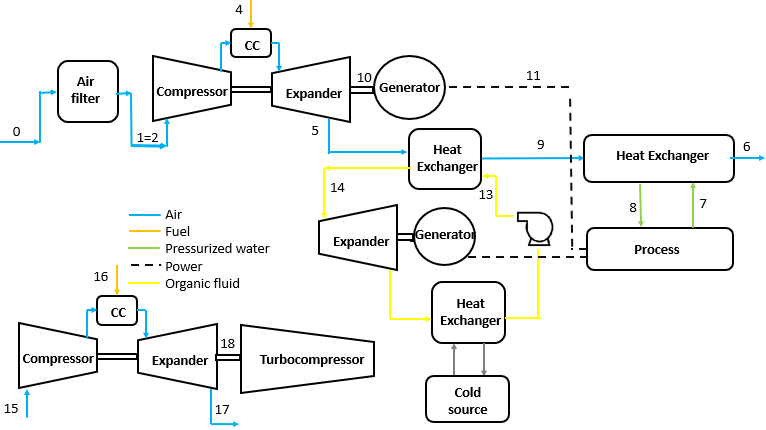

In [11]:
from IPython.display import Image
print("Base Case + ORC (Config. 2) and CO2 compression system")
Image(filename='ORC.png')

In [52]:
# ORC - Configuration 2 - ORC 3MWw offdesign condition
DELTAP_HRSG_Projeto = 11.48
DELTAP_ORC_Projeto = 3
DELTAP_exhaust = DELTAP_HRSG_Projeto + DELTAP_ORC_Projeto
DELTAP_entrada = DELTAP_filtro
# conectando com o banco de dados
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS ORC2')
cur.execute('DROP TABLE IF EXISTS ORC2WithoutCO2')
cur.execute('CREATE TABLE ORC2 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, CO2EmitCO2 REAL, EtaExergCO2 REAL, EtaExergTotal REAL, CO2EmitTotal REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, RelmCO2CO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL)')
cur.execute('CREATE TABLE ORC2WithoutCO2 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL)')
conn.commit()
cur.close()

for i in range(22):
#     print('ano', i+1)
    NTurb1 = list()
    CargaOperTurb1 = list()
    QGasProdOffDispInd1 = list()
    QGasProdOffDisTotal1 = list()
    FACogeração1 = list()
    CO2Emit1 = list()
    EtaExerg1 = list()
    CO2EmitCo21 = list()
    EtaExergCO21 = list()
    EtaExergTotal1 = list()
    CO2EmitTotal1 = list()
    DeltaWOper1 = list()
    RelMCO2MCO2Total1 = list()
    RelMCO2CO2MCO2Total1 = list()
    EtaOperTurb1 = list()
    Epsilon_HRSG1 = list()
    EtaExergHRSG1 = list()
    EtaExergHEORC1 = list()
    Epsilon_HE_ORC1 = list()
    EtaExergORC1 = list()
    
    NTurb2 = list()
    CargaOperTurb2 = list()
    QGasProdOffDispInd2 = list()
    QGasProdOffDispTotal2 = list()
    FACogeração2 = list()
    CO2Emit2 = list()
    EtaExerg2 = list()
    DeltaWOper2 = list()
    EtaOperTurb2 = list()
    Epsilon_HRSG2 = list()
    EtaExergHRSG2 = list()
    EtaExergHEORC2 = list()
    Epsilon_HE_ORC2 = list()
    EtaExergORC2 = list()
    for j in range(12):
        Ponto0 = {'T': (ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':P_amb,
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto1 = {'T':(ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':(P_amb-DELTAP_filtro*9.80665),
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto2 = Ponto1
        Ponto3 = {}
        PlantaCO2 = True
#             Planta principal
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
#         calculo inicial para recuperar propriedades do ponto5
        TurbOffdesign = turboffdesign(demandas['principal'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust) 
        excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':104000,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
#         print('planta principal')
        ORC = 2
        TurbOffdesign = TurbORC(ORC,demandas['principal'][i], demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
        print('q orc', TurbOffdesign['Q_ORC'])
        print('ponto5', Ponto5)
        #print('ponto9', Ponto9)
        Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
        Configuração = 'ORC2'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        #Eta_carnot_ORC = (1- ( 25 + 273.15)/((Ponto5['T'] + Ponto9['T'])/2+273.15))
        EtaExergORC = 100 * TurbOffdesign['W_ORC'] / (Ponto5['m'] * (Ponto5['E'] - Ponto9['E']))
        #print('EtaExergORC', EtaExergORC)
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['principal'][i]+TurbOffdesign['W_ORC']* TurbOffdesign['n_turb_real']/1000
#             Planta de CO2
        Ponto14 = Ponto0
        Ponto15 = Ponto1
        TurbProj_CO2 = tgprojeto(TG_CO2,PCI_GN_m,Perc_ar_resf)
        TurbOffdesign_CO2 = turboffdesign(demandas['co2'][i],TG_CO2,Ponto15,PCI_GN_m,PCI_fuel(),eta_ger_CO2,DELTAP_entrada_CO2,DELTAP_HRSG_CO2) 
        excesso_CO2, T_chama_CO2, molar_fraction_prod_CO2,Ponto16 = combustor(T_comb,fuel_mol,Ponto15,TurbProj_CO2,TurbOffdesign_CO2)
        Ponto17 = {'T':TurbOffdesign_CO2['T_gas_exaust']+273.15,'P':101325,'m':TurbOffdesign_CO2['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto17)
        Ponto17.update({'H':props['H'],'S':props['S'],'cp':props['cp']})
        DELTAW_oper_CO2 = TurbOffdesign_CO2['n_turb_real']*TurbOffdesign_CO2['WTmaximo']/1000-demandas['co2'][i]
        Ponto18 = {'E':TurbOffdesign_CO2['WT_real']*eta_ger_CO2/100}
        Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb1.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb1.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd1.append(Q_gasprod_off_disp_ind)
        QGasProdOffDisTotal1.append(Q_gasprod_off_disp_total)
        FACogeração1.append(FA_coger)
        CO2Emit1.append(CO2_emit)
        EtaExerg1.append(eta_exerg)
        CO2EmitCo21.append(CO2_emit_CO2)
        EtaExergCO21.append(eta_exerg_CO2)
        EtaExergTotal1.append(eta_exerg_total)
        CO2EmitTotal1.append(CO2_emit_total)
        DeltaWOper1.append(DELTAW_oper)
        RelMCO2MCO2Total1.append(Rel_m_CO2_m_CO2_total)
        RelMCO2CO2MCO2Total1.append(Rel_m_CO2_CO2_m_CO2_total)
        EtaOperTurb1.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG1.append(Epsilon_HRSG)
        EtaExergHRSG1.append(EtaExergHRSG)
        EtaExergHEORC1.append(EtaExerg_HE_ORC*100/1000)
        Epsilon_HE_ORC1.append(Epsilon_HE_ORC)
        EtaExergORC1.append(EtaExergORC)
#           Planta principal suprindo demanda principal e de CO2
#         print('principal + co2')
        PlantaCO2 = False
#         calculo inicial
        TurbOffdesign = turboffdesign(demandas['total'][i],TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust) 
        excesso, T_chama, molar_fraction_prod, Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
        Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
        Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
        Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
        Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto5)
        Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
        TurbOffdesign = TurbORC(ORC,demandas['total'][i], demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
        Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
        Configuração = 'ORC2'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        #DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['total'][i]-TurbOffdesign['W_ORC']* TurbOffdesign['n_turb_real']/1000
        #Eta_carnot_ORC = (1- ( 25 + 273.15)/((Ponto5['T'] + Ponto9['T'])/2+273.15))
        EtaExergORC = 100 * TurbOffdesign['W_ORC'] / (Ponto5['m'] * (Ponto5['E'] - Ponto9['E']))
        print('Eta_carnot_ORC', Eta_carnot_ORC)
        print('ponto 5 h', Ponto5['H'])
        print('ponto 9 h', Ponto9['H'])
        print('EtaExergORC', EtaExergORC)
        molar_fraction_prod_CO2 = {}
        TurbOffdesign_CO2 = {}
        CO2_emit, FA_coger, eta_exerg = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb2.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb2.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd2.append(Q_gasprod_off_disp_ind)
        QGasProdOffDispTotal2.append(Q_gasprod_off_disp_total)
        FACogeração2.append(FA_coger)
        CO2Emit2.append(CO2_emit)
        EtaExerg2.append(eta_exerg)
        DeltaWOper2.append(DELTAW_oper)
        EtaOperTurb2.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG2.append(Epsilon_HRSG)
        EtaExergHRSG2.append(EtaExergHRSG)
        EtaExergHEORC2.append(EtaExerg_HE_ORC*100/1000)
        Epsilon_HE_ORC2.append(Epsilon_HE_ORC)
        EtaExergORC2.append(EtaExergORC)
#         Inserir valores no banco de dados
    conn = sqlite3.connect('FPSO2.sqlite')
    cur = conn.cursor()
    cur.execute(''' INSERT INTO ORC2 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,CO2EmitCO2,EtaExergCO2,EtaExergTotal,CO2EmitTotal,WTDispTotal,RelmCO2mCO2Total,RelmCO2CO2mCO2Total, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb1),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb1),TurbOffdesign['W_ORC'],np.mean(QGasProdOffDispInd1),np.mean(QGasProdOffDisTotal1),np.mean(FACogeração1),np.mean(CO2Emit1),np.mean(EtaExerg1),np.mean(CO2EmitCo21),np.mean(EtaExergCO21),np.mean(EtaExergTotal1),np.mean(CO2EmitTotal1),np.mean(DeltaWOper1),np.mean(RelMCO2MCO2Total1),np.mean(RelMCO2CO2MCO2Total1), np.mean(EtaOperTurb1), np.mean(Epsilon_HRSG1), np.mean(EtaExergHRSG1), np.mean(EtaExergHEORC1), np.mean(Epsilon_HE_ORC1), np.mean(EtaExergORC1)))
    cur.execute(''' INSERT INTO ORC2WithoutCO2 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,WTDispTotal, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb2),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb2),TurbOffdesign['W_ORC'],np.mean(QGasProdOffDispInd2),np.mean(QGasProdOffDispTotal2),np.mean(FACogeração2),np.mean(CO2Emit2),np.mean(EtaExerg2),np.mean(DeltaWOper2), np.mean(EtaOperTurb2), np.mean(Epsilon_HRSG2), np.mean(EtaExergHRSG2), np.mean(EtaExergHEORC2), np.mean(Epsilon_HE_ORC2), np.mean(EtaExergORC2)))
    conn.commit()
    cur.close()

q orc 13000
ponto5 {'T': 756.4358594226832, 'P': 104000, 'm': 74.57671673740417, 'H': 928.0969909216458, 'S': 7.659628715071639, 'cp': 1179.6074075109204, 'E': 207.5594557400873}
Epsilon_HE_ORC 0.4571049168367125
eta exerg 68.36204541281242
t2 hot off 616.2713023287134
eta exerg hrsg 41.50899260516333
Epsilon_HE_ORC 0.5324413710703569
eta exerg 69.33908625387515
t2 hot off 598.1872348336395
eta exerg hrsg 20.387014970072862
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 925.4282158360503
ponto 9 h 713.1528371680397
EtaExergORC 38.56279341602917
q orc 13000
ponto5 {'T': 756.9178957487898, 'P': 104000, 'm': 74.33720298544804, 'H': 926.633277496356, 'S': 7.658198527107275, 'cp': 1178.5433654991657, 'E': 207.56415972984405}
Epsilon_HE_ORC 0.4583083670427605
eta exerg 68.16296673911161
t2 hot off 616.7526628611075
eta exerg hrsg 41.656416471404356
Epsilon_HE_ORC 0.535386713419187
eta exerg 69.2165703911052
t2 hot off 597.6168654007529
eta exerg hrsg 20.463115989941276
Eta_carnot_ORC 0.0251551

q orc 13000
ponto5 {'T': 756.1598442543594, 'P': 104000, 'm': 78.58005613117184, 'H': 928.9661105019312, 'S': 7.644034019262322, 'cp': 1180.0293587569765, 'E': 207.43814503900546}
Epsilon_HE_ORC 0.43403269622229745
eta exerg 65.80301740458029
t2 hot off 630.000910963661
eta exerg hrsg 44.476281127781355
Epsilon_HE_ORC 0.4666989545076385
eta exerg 67.20653729493681
t2 hot off 622.8465245292081
eta exerg hrsg 28.495116340854477
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 934.621367629923
ponto 9 h 749.4099156684373
EtaExergORC 37.37678059993858
q orc 13000
ponto5 {'T': 755.1910131226738, 'P': 104000, 'm': 77.9841288717353, 'H': 923.7498884823319, 'S': 7.638623090565113, 'cp': 1177.3150504535427, 'E': 206.09718777376048}
Epsilon_HE_ORC 0.4396764929402406
eta exerg 67.89207108194823
t2 hot off 622.0302277231012
eta exerg hrsg 42.65351249285644
Epsilon_HE_ORC 0.46831234496700386
eta exerg 66.78754160151999
t2 hot off 624.4511720044522
eta exerg hrsg 43.022558664530905
Eta_carnot_ORC 0.0251

q orc 13000
ponto5 {'T': 755.9296681554886, 'P': 104000, 'm': 74.85692452520433, 'H': 918.6524643689147, 'S': 7.642693708308868, 'cp': 1174.0938919210384, 'E': 205.71819179714254}
Epsilon_HE_ORC 0.45824989335487754
eta exerg 68.42344349060068
t2 hot off 615.7583358053384
eta exerg hrsg 43.161486584942544
Epsilon_HE_ORC 0.3868566512526565
eta exerg 64.95668484129824
t2 hot off 653.9455169144663
eta exerg hrsg 44.5606907257755
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 954.493951874104
ponto 9 h 798.2721416112838
EtaExergORC 36.125529681105455
q orc 13000
ponto5 {'T': 756.5818799041776, 'P': 104000, 'm': 74.50178354568745, 'H': 917.9469215828993, 'S': 7.641605064850659, 'cp': 1173.402052411013, 'E': 205.93389017409328}
Epsilon_HE_ORC 0.4597767584162769
eta exerg 68.15473988362218
t2 hot off 616.409631821425
eta exerg hrsg 43.36798015013408
Epsilon_HE_ORC 0.39111047246666136
eta exerg 64.8290462920517
t2 hot off 652.3111992014527
eta exerg hrsg 44.84985272113478
Eta_carnot_ORC 0.0251551

q orc 13000
ponto5 {'T': 754.8305113352875, 'P': 104000, 'm': 75.6786395928045, 'H': 921.7727548408911, 'S': 7.642584305808767, 'cp': 1176.3590666301686, 'E': 205.63921649324067}
Epsilon_HE_ORC 0.45394724135544845
eta exerg 66.62506230707241
t2 hot off 621.6597478173895
eta exerg hrsg 45.29696910118719
Epsilon_HE_ORC 0.4655598045878061
eta exerg 68.08158477519237
t2 hot off 618.7843145144136
eta exerg hrsg 43.44525705974135
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 929.4453189173454
ponto 9 h 747.1273380542633
EtaExergORC 37.86343649682713
q orc 13000
ponto5 {'T': 754.7582163346276, 'P': 104000, 'm': 75.75598823647734, 'H': 922.2879531604312, 'S': 7.643126829918259, 'cp': 1176.6955569477404, 'E': 205.68615044627245}
Epsilon_HE_ORC 0.4534559818318486
eta exerg 66.67849571602778
t2 hot off 621.5876749583052
eta exerg hrsg 45.24401782748394
Epsilon_HE_ORC 0.4653384072427247
eta exerg 68.14508432176126
t2 hot off 618.5445031255019
eta exerg hrsg 43.40272721730625
Eta_carnot_ORC 0.025155

q orc 13000
ponto5 {'T': 754.4368515800616, 'P': 104000, 'm': 77.13377709103506, 'H': 928.7724124249455, 'S': 7.650026919709692, 'cp': 1180.685660266204, 'E': 206.5845097598202}
Epsilon_HE_ORC 0.444295088654491
eta exerg 67.54428505518695
t2 hot off 621.2710460274449
eta exerg hrsg 44.04394325167497
Epsilon_HE_ORC 0.4620365513314238
eta exerg 66.9414363046315
t2 hot off 621.255978283921
eta exerg hrsg 44.39183213546777
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 931.6903414450541
ponto 9 h 752.7358430168908
EtaExergORC 37.22934521715753
q orc 13000
ponto5 {'T': 754.3545192076192, 'P': 104000, 'm': 76.87896389657755, 'H': 926.6225917295018, 'S': 7.647845895253388, 'cp': 1179.4418343634602, 'E': 206.19036950062934}
Epsilon_HE_ORC 0.446352175311359
eta exerg 67.37825499951722
t2 hot off 621.1879918934011
eta exerg hrsg 44.22280564931875
Epsilon_HE_ORC 0.4628551528701567
eta exerg 66.7493581436907
t2 hot off 621.97549281049
eta exerg hrsg 44.53750954917626
Eta_carnot_ORC 0.025155123260103

q orc 13000
ponto5 {'T': 754.4050702574698, 'P': 104000, 'm': 77.05686486731574, 'H': 924.8496525904267, 'S': 7.646003655409305, 'cp': 1178.3667758632075, 'E': 205.925984778967}
Epsilon_HE_ORC 0.44565782581946445
eta exerg 67.44768578065043
t2 hot off 621.2391958735242
eta exerg hrsg 44.03573624772068
Epsilon_HE_ORC 0.46324755778878013
eta exerg 66.75822050078455
t2 hot off 621.8137326157228
eta exerg hrsg 44.43011682809372
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 928.2980707250523
ponto 9 h 748.9104583243861
EtaExergORC 37.127450116197686
q orc 13000
ponto5 {'T': 754.357406743097, 'P': 104000, 'm': 76.47634879215882, 'H': 920.8195720616804, 'S': 7.641694750751434, 'cp': 1175.983724842237, 'E': 205.2466423384475}
Epsilon_HE_ORC 0.4500174398089314
eta exerg 67.07518351898914
t2 hot off 621.1899408262442
eta exerg hrsg 44.43039033732677
Epsilon_HE_ORC 0.46488448184124553
eta exerg 66.33490224367881
t2 hot off 623.5068617098962
eta exerg hrsg 44.75068455601508
Eta_carnot_ORC 0.0251551

q orc 13000
ponto5 {'T': 754.6671920849165, 'P': 104000, 'm': 75.86323358100498, 'H': 918.3764465184121, 'S': 7.638225752424618, 'cp': 1174.3881402786376, 'E': 205.00307866915358}
Epsilon_HE_ORC 0.45383307639418385
eta exerg 66.68839189705989
t2 hot off 621.498495338058
eta exerg hrsg 44.72924063655752
Epsilon_HE_ORC 0.46612602306153245
eta exerg 68.17516146407328
t2 hot off 618.1644437093179
eta exerg hrsg 42.913974933697666
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 925.4870084749349
ponto 9 h 743.6171161030268
EtaExergORC 37.91547898421524
q orc 13000
ponto5 {'T': 755.0200507996879, 'P': 104000, 'm': 75.49863064253009, 'H': 917.3126549275705, 'S': 7.636725954870969, 'cp': 1173.6040237155519, 'E': 205.00859526702044}
Epsilon_HE_ORC 0.4558291758716208
eta exerg 66.45532936027122
t2 hot off 621.8504284267154
eta exerg hrsg 44.95590677271555
Epsilon_HE_ORC 0.46685377551502766
eta exerg 67.89688818815272
t2 hot off 619.2958853175442
eta exerg hrsg 43.09303418822736
Eta_carnot_ORC 0.025

q orc 13000
ponto5 {'T': 754.5758642935878, 'P': 104000, 'm': 75.98659276668678, 'H': 921.8443824330434, 'S': 7.641399294730157, 'cp': 1176.48883657017, 'E': 205.5127045083246}
Epsilon_HE_ORC 0.45241578589227877
eta exerg 66.8087811001402
t2 hot off 621.4087375684305
eta exerg hrsg 44.34069351472137
Epsilon_HE_ORC 0.4651112832211145
eta exerg 68.33650449219303
t2 hot off 617.7009981801853
eta exerg hrsg 42.54202928439633
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 928.5840329138044
ponto 9 h 747.0505765419213
EtaExergORC 38.005209584928934
q orc 13000
ponto5 {'T': 754.5256192950714, 'P': 104000, 'm': 76.06451373795937, 'H': 922.3864383405211, 'S': 7.641971044868876, 'cp': 1176.8323884953045, 'E': 205.57519686959847}
Epsilon_HE_ORC 0.45189102932679137
eta exerg 66.86180811370673
t2 hot off 621.3587115483102
eta exerg hrsg 44.28799078114162
Epsilon_HE_ORC 0.46488634531377665
eta exerg 68.4010454520713
t2 hot off 617.4627390565951
eta exerg hrsg 42.50010699396834
Eta_carnot_ORC 0.0251551

q orc 13000
ponto5 {'T': 754.5520267715791, 'P': 104000, 'm': 77.34036787569879, 'H': 929.1695307158266, 'S': 7.649615958573332, 'cp': 1180.864985338534, 'E': 206.70162814043516}
Epsilon_HE_ORC 0.4428822374137806
eta exerg 67.65676204102155
t2 hot off 621.3898556714881
eta exerg hrsg 43.07865134668492
Epsilon_HE_ORC 0.4617493285293838
eta exerg 67.05501339980455
t2 hot off 620.7847440741918
eta exerg hrsg 43.4632844248236
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 931.3182047197781
ponto 9 h 752.739439563232
EtaExergORC 37.29251089029483
q orc 13000
ponto5 {'T': 754.4158173320407, 'P': 104000, 'm': 77.08454769808766, 'H': 926.9514819112175, 'S': 7.647368038226703, 'cp': 1179.6024241282814, 'E': 206.26896580213958}
Epsilon_HE_ORC 0.44501622807084656
eta exerg 67.49227117740722
t2 hot off 621.2529370420257
eta exerg hrsg 43.25552988865833
Epsilon_HE_ORC 0.4625876591326403
eta exerg 66.86195760024515
t2 hot off 621.4925099176799
eta exerg hrsg 43.606641617728464
Eta_carnot_ORC 0.0251551

q orc 13000
ponto5 {'T': 754.3928375411026, 'P': 104000, 'm': 77.02258024490719, 'H': 924.7922442796608, 'S': 7.64608064204851, 'cp': 1178.3392728766084, 'E': 205.91147558135668}
Epsilon_HE_ORC 0.44588358374757586
eta exerg 67.42878266577084
t2 hot off 621.2307934623881
eta exerg hrsg 43.0200818901745
Epsilon_HE_ORC 0.46314018767608445
eta exerg 66.80323003651215
t2 hot off 621.6232992208387
eta exerg hrsg 43.35378011425887
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 928.1446894815598
ponto 9 h 748.9072771070336
EtaExergORC 37.152482079002326
q orc 13000
ponto5 {'T': 754.364993410525, 'P': 104000, 'm': 76.4424716219659, 'H': 920.7869693893088, 'S': 7.641796882505014, 'cp': 1175.9629527248983, 'E': 205.2462201987015}
Epsilon_HE_ORC 0.4502141938687498
eta exerg 67.05575760340304
t2 hot off 621.2013958000005
eta exerg hrsg 43.40491766661608
Epsilon_HE_ORC 0.4647908712562516
eta exerg 66.37891503777566
t2 hot off 623.3085572421255
eta exerg hrsg 43.66716791606229
Eta_carnot_ORC 0.02515512

q orc 13000
ponto5 {'T': 754.7517808920027, 'P': 104000, 'm': 75.76317506211123, 'H': 918.3547375048208, 'S': 7.638613342202649, 'cp': 1174.3461154032934, 'E': 205.04546561374087}
Epsilon_HE_ORC 0.45432917386946226
eta exerg 66.62877381260768
t2 hot off 621.5872675353304
eta exerg hrsg 43.6189682471786
Epsilon_HE_ORC 0.4662537979794067
eta exerg 68.10281296499492
t2 hot off 618.4788188434836
eta exerg hrsg 41.8381057777352
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 925.731551758
ponto 9 h 743.6382196667405
EtaExergORC 37.8752425119072
q orc 13000
ponto5 {'T': 755.1370181186727, 'P': 104000, 'm': 75.3994701856957, 'H': 917.33020979929, 'S': 7.637157129007025, 'cp': 1173.5722868657415, 'E': 205.0737586868206}
Epsilon_HE_ORC 0.4562751857583936
eta exerg 66.39513818859338
t2 hot off 621.9716044618616
eta exerg hrsg 43.83873185459936
Epsilon_HE_ORC 0.4669789651742149
eta exerg 67.82591821537325
t2 hot off 619.6108488173111
eta exerg hrsg 42.01236024476424
Eta_carnot_ORC 0.0251551232601039

q orc 13000
ponto5 {'T': 754.7032524057663, 'P': 104000, 'm': 75.81921373096696, 'H': 921.792068310954, 'S': 7.642028386211532, 'cp': 1176.4147773638879, 'E': 205.57371543816896}
Epsilon_HE_ORC 0.4532634479123894
eta exerg 66.70931886299147
t2 hot off 621.5405338765103
eta exerg hrsg 43.168879317247075
Epsilon_HE_ORC 0.4651905941615612
eta exerg 68.29183288899054
t2 hot off 617.8946451434764
eta exerg hrsg 41.354077335553505
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 928.7336018515074
ponto 9 h 747.0634925571621
EtaExergORC 37.98036556261872
q orc 13000
ponto5 {'T': 754.640898127233, 'P': 104000, 'm': 75.89682636418263, 'H': 922.3193431796647, 'S': 7.642584138849656, 'cp': 1176.7544327369667, 'E': 205.62765921451967}
Epsilon_HE_ORC 0.45275703925962646
eta exerg 66.76257743515998
t2 hot off 621.4783919695267
eta exerg hrsg 43.11802961930427
Epsilon_HE_ORC 0.4649664531228368
eta exerg 68.35619725534332
t2 hot off 617.6559905657198
eta exerg hrsg 41.31337422348006
Eta_carnot_ORC 0.02515

q orc 13000
ponto5 {'T': 754.7784328553602, 'P': 104000, 'm': 75.73375089171671, 'H': 927.4871680998006, 'S': 7.654256784602782, 'cp': 1179.853888493379, 'E': 206.587452670265}
Epsilon_HE_ORC 0.45234648784995374
eta exerg 66.7371030967695
t2 hot off 621.6165974620797
eta exerg hrsg 42.97499201676495
Epsilon_HE_ORC 0.46353154711845607
eta exerg 66.26413727785578
t2 hot off 624.2933281477275
eta exerg hrsg 42.979518771322816
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 934.1096639842484
ponto 9 h 752.8773752764104
EtaExergORC 36.85266672510471
q orc 13000
ponto5 {'T': 755.0336080654179, 'P': 104000, 'm': 75.48674121775836, 'H': 925.7542163950859, 'S': 7.652514263280794, 'cp': 1178.7214497434773, 'E': 206.43269273982895}
Epsilon_HE_ORC 0.4539025553250524
eta exerg 66.56353870093876
t2 hot off 621.8710903332536
eta exerg hrsg 43.13691903322248
Epsilon_HE_ORC 0.4642725409632622
eta exerg 68.31528589738907
t2 hot off 618.0564314224953
eta exerg hrsg 41.16782327504957
Eta_carnot_ORC 0.0251551

q orc 13000
ponto5 {'T': 763.215663258123, 'P': 104000, 'm': 72.09663988026614, 'H': 929.2702809403476, 'S': 7.6717841167207075, 'cp': 1177.6962716921857, 'E': 211.27488674431487}
Epsilon_HE_ORC 0.4638682850399461
eta exerg 66.48276442751727
t2 hot off 623.0440111623923
eta exerg hrsg 43.118537617814376
Epsilon_HE_ORC 0.41588904698331963
eta exerg 66.53271068854525
t2 hot off 635.2978499985825
eta exerg hrsg 42.61555946321423
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 938.3585963162735
ponto 9 h 776.7861767344336
EtaExergORC 37.00203328750123
q orc 13000
ponto5 {'T': 764.9488328672338, 'P': 104000, 'm': 71.5921584357213, 'H': 927.3156630145754, 'S': 7.669968920302878, 'cp': 1175.8258244647693, 'E': 211.8456005939761}
Epsilon_HE_ORC 0.46543608172575957
eta exerg 68.30054421009486
t2 hot off 617.7754107920758
eta exerg hrsg 41.463265951394774
Epsilon_HE_ORC 0.42281283487078186
eta exerg 66.26832160713622
t2 hot off 633.2455886465234
eta exerg hrsg 43.06346228959455
Eta_carnot_ORC 0.025

q orc 12435.530632297421
ponto5 {'T': 764.3300955868733, 'P': 104000, 'm': 81.20111970690053, 'H': 938.1861262655176, 'S': 7.633695638669632, 'cp': 1181.9641951495914, 'E': 212.95179400673584}
Epsilon_HE_ORC 0.39123144687827227
eta exerg 66.03049849538014
t2 hot off 645.1015531935323
eta exerg hrsg 67.35341371275278
Epsilon_HE_ORC 0.4660903476106716
eta exerg 68.19529100211875
t2 hot off 618.0829157728248
eta exerg hrsg 41.88052159322623
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 925.4192279653765
ponto 9 h 743.6113368164997
EtaExergORC 37.92667398632942
q orc 12067.069118607847
ponto5 {'T': 762.7715974000132, 'P': 104000, 'm': 80.8112490278845, 'H': 934.4962558496098, 'S': 7.630270416798415, 'cp': 1180.4022757849211, 'E': 211.55342251135966}
Epsilon_HE_ORC 0.38378171844736575
eta exerg 64.57530460504395
t2 hot off 650.5420463503453
eta exerg hrsg 71.84769039011104
Epsilon_HE_ORC 0.4668189826022516
eta exerg 67.91663938164153
t2 hot off 619.2141131720894
eta exerg hrsg 42.05536737714

q orc 8200.572524357234
ponto5 {'T': 755.3202507303777, 'P': 104000, 'm': 75.25713379302941, 'H': 921.845183412709, 'S': 7.6444003994648595, 'cp': 1176.226037181204, 'E': 205.91160392234383}
Epsilon_HE_ORC 0.2875545712250347
eta exerg 62.10253466652263
t2 hot off 678.0720504626163
eta exerg hrsg 112.81446589538432
Epsilon_HE_ORC 0.20603605372473136
eta exerg 56.83020759148493
t2 hot off 721.5272864751781
eta exerg hrsg 157.3257415944611
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 953.1999425695602
ponto 9 h 870.5547083974008
EtaExergORC 29.326285226834617
q orc 8237.744998291615
ponto5 {'T': 755.2194989216789, 'P': 104000, 'm': 75.33366488883973, 'H': 922.3261095963921, 'S': 7.644904575529919, 'cp': 1176.5536441444574, 'E': 205.9385077054502}
Epsilon_HE_ORC 0.28857447709026235
eta exerg 62.003508895543554
t2 hot off 677.97161883445
eta exerg hrsg 112.68534012444934
Epsilon_HE_ORC 0.20636807443996044
eta exerg 56.76086201365734
t2 hot off 721.8857372450909
eta exerg hrsg 157.0959457216

q orc 9162.7283309241
ponto5 {'T': 754.3569009489298, 'P': 104000, 'm': 76.47880359555309, 'H': 927.8737643504588, 'S': 7.651690643328573, 'cp': 1180.2162968057082, 'E': 206.41614811625652}
Epsilon_HE_ORC 0.31603650496896823
eta exerg 62.09934608258236
t2 hot off 670.1168207946088
eta exerg hrsg 100.29269200506388
Epsilon_HE_ORC 0.2620738589980571
eta exerg 61.78853736382119
t2 hot off 701.7216739647737
eta exerg hrsg 122.6371981903973
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 944.2519631022554
ponto 9 h 837.2540148694935
EtaExergORC 32.21826422792188
q orc 9011.712868274055
ponto5 {'T': 754.4393771309103, 'P': 104000, 'm': 76.2274417234424, 'H': 925.9297467991506, 'S': 7.649719772342358, 'cp': 1179.0281494155372, 'E': 206.1392761779279}
Epsilon_HE_ORC 0.3120868433506252
eta exerg 62.49503735972994
t2 hot off 670.1982658147309
eta exerg hrsg 100.68565340339781
Epsilon_HE_ORC 0.2603171845165081
eta exerg 61.95834206795203
t2 hot off 702.0872599217204
eta exerg hrsg 123.03388703604125

q orc 10955.840372531376
ponto5 {'T': 768.7542612182096, 'P': 104000, 'm': 70.52753776246867, 'H': 933.6803845881456, 'S': 7.684305507113492, 'cp': 1178.167013346727, 'E': 214.88783828046144}
Epsilon_HE_ORC 0.39287342069385267
eta exerg 65.16176498320137
t2 hot off 649.5329631664351
eta exerg hrsg 65.03614782163355
Epsilon_HE_ORC 0.4349931595887414
eta exerg 65.75505167227551
t2 hot off 629.751043045067
eta exerg hrsg 55.677228522677865
Eta_carnot_ORC 0.02515512326010394
ponto 5 h 928.5561078668318
ponto 9 h 762.8832841769415
EtaExergORC 36.569539789061935
q orc 10856.98388942856
ponto5 {'T': 770.4634122128598, 'P': 104000, 'm': 70.05047384309707, 'H': 931.6315248782532, 'S': 7.682533703177376, 'cp': 1176.2482529471129, 'E': 215.43701773951562}
Epsilon_HE_ORC 0.3906299290722194
eta exerg 65.12154948721283
t2 hot off 651.2402543071835
eta exerg hrsg 65.48965981399982
Epsilon_HE_ORC 0.44054559029427365
eta exerg 67.83502560072561
t2 hot off 621.8489585684672
eta exerg hrsg 53.39328560041

Base Case + ORC (Config. 2) + SRC and CO2 compression system


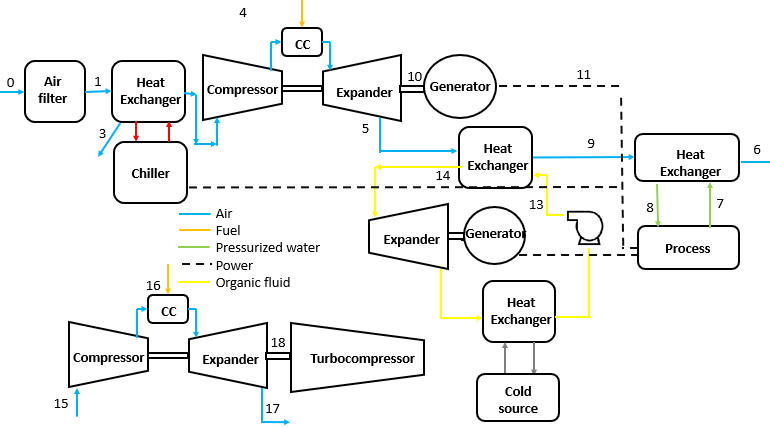

In [12]:
from IPython.display import Image
print("Base Case + ORC (Config. 2) + SRC and CO2 compression system")
Image(filename='ORC_SRC.png')

In [54]:
DELTAP_HRSG_Projeto = 11.48
DELTAP_ORC_Projeto = 3
DELTAP_exhaust = DELTAP_HRSG_Projeto + DELTAP_ORC_Projeto
DELTAP_AirCooler_Projeto = 4.799
DELTAP_entrada = DELTAP_filtro + DELTAP_AirCooler_Projeto

conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS SRC_ORC')
cur.execute('DROP TABLE IF EXISTS SRC_ORCWithoutCO2')
cur.execute('CREATE TABLE SRC_ORC (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, CO2EmitCO2 REAL, EtaExergCO2 REAL, EtaExergTotal REAL, CO2EmitTotal REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, RelmCO2CO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL, Psi_chiller REAL, Epsilon_chiller REAL)')
cur.execute('CREATE TABLE SRC_ORCWithoutCO2 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL, Psi_chiller REAL, Epsilon_chiller REAL)')
conn.commit()
cur.close()

for i in range(22):
    NTurb1 = list()
    CargaOperTurb1 = list()
    QGasProdOffDispInd1 = list()
    QGasProdOffDisTotal1 = list()
    FACogeração1 = list()
    CO2Emit1 = list()
    EtaExerg1 = list()
    CO2EmitCo21 = list()
    EtaExergCO21 = list()
    EtaExergTotal1 = list()
    CO2EmitTotal1 = list()
    DeltaWOper1 = list()
    RelMCO2MCO2Total1 = list()
    RelMCO2CO2MCO2Total1 = list()
    EtaOperTurb1 = list()
    Epsilon_HRSG1 = list()
    EtaExergHRSG1 = list()
    EtaExergHEORC1 = list()
    Epsilon_HE_ORC1 = list()
    EtaExergORC1 = list()
    Psi_Chiller1 = list()
    Epsilon_Resfriador1 = list()
    
    NTurb2 = list()
    CargaOperTurb2 = list()
    QGasProdOffDispInd2 = list()
    QGasProdOffDispTotal2 = list()
    FACogeração2 = list()
    CO2Emit2 = list()
    EtaExerg2 = list()
    DeltaWOper2 = list()
    EtaOperTurb2 = list()
    Epsilon_HRSG2 = list()
    EtaExergHRSG2 = list()
    EtaExergHEORC2 = list()
    Epsilon_HE_ORC2 = list()
    EtaExergORC2 = list()
    Psi_Chiller2 = list()
    Epsilon_Resfriador2 = list()
    for j in range(12):
        Ponto0 = {'T': (ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':P_amb,
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto1 = {'T':(ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':(P_amb-DELTAP_filtro*9.80665),
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        PlantaCO2 = True
#             Planta principal
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
        Sistema = 'Compressão'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['principal'][i]
        while True:
            if m_ar_off == TurbProj['m_ar_iso']:
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['principal'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
#                 print('Potencia',Potencia)
                ORC = 2
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
                m_ar_off = TurbOffdesign['m_ar_real']
            else:
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['principal'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
#                 print('Potencia', Potencia)     
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
                if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.05):
                    m_ar_off = TurbOffdesign['m_ar_real']
                else: break
        Configuração = 'SRC_ORC'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        Psi_Chiller = ResfComp['psi_Chiller']
        Epsilon_Resfriador = ResfComp['Epsilon_resfriador']
        Eta_carnot_ORC = (1- ( 25 + 273.15)/((Ponto5['T'] + Ponto9['T'])/2+273.15))
        EtaExergORC = 100 * TurbOffdesign['W_ORC'] / (Eta_carnot_ORC * Ponto5['m'] * (Ponto5['H'] - Ponto9['H']))
        print('EtaExergORC', EtaExergORC)
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        #             Planta de CO2
        Ponto14 = Ponto0
        Ponto15 = Ponto1
        TurbProj_CO2 = tgprojeto(TG_CO2,PCI_GN_m,Perc_ar_resf)
        TurbOffdesign_CO2 = turboffdesign(demandas['co2'][i],TG_CO2,Ponto15,PCI_GN_m,PCI_fuel(),eta_ger_CO2,DELTAP_entrada_CO2,DELTAP_HRSG_CO2) 
        excesso_CO2, T_chama_CO2, molar_fraction_prod_CO2,Ponto16 = combustor(T_comb,fuel_mol,Ponto15,TurbProj_CO2,TurbOffdesign_CO2)
        Ponto17 = {'T':TurbOffdesign_CO2['T_gas_exaust']+273.15,'P':101325,'m':TurbOffdesign_CO2['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto17)
        Ponto17.update({'H':props['H'],'S':props['S'],'cp':props['cp']})
        DELTAW_oper_CO2 = TurbOffdesign_CO2['n_turb_real']*TurbOffdesign_CO2['WTmaximo']/1000-demandas['co2'][i]
        Ponto18 = {'E':TurbOffdesign_CO2['WT_real']*eta_ger_CO2/100}
        Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb1.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb1.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd1.append(Q_gasprod_off_disp_ind)
        QGasProdOffDisTotal1.append(Q_gasprod_off_disp_total)
        FACogeração1.append(FA_coger)
        CO2Emit1.append(CO2_emit)
        EtaExerg1.append(eta_exerg)
        CO2EmitCo21.append(CO2_emit_CO2)
        EtaExergCO21.append(eta_exerg_CO2)
        EtaExergTotal1.append(eta_exerg_total)
        CO2EmitTotal1.append(CO2_emit_total)
        DeltaWOper1.append(DELTAW_oper)
        RelMCO2MCO2Total1.append(Rel_m_CO2_m_CO2_total)
        RelMCO2CO2MCO2Total1.append(Rel_m_CO2_CO2_m_CO2_total)
        EtaOperTurb1.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG1.append(Epsilon_HRSG)
        EtaExergHRSG1.append(EtaExergHRSG)
        EtaExergHEORC1.append(EtaExerg_HE_ORC)
        Epsilon_HE_ORC1.append(Epsilon_HE_ORC)
        EtaExergORC1.append(EtaExergORC)
        Psi_Chiller1.append(Psi_Chiller)
        Epsilon_Resfriador1.append(Epsilon_Resfriador)
#           Planta principal suprindo demanda principal e de CO2
        PlantaCO2 = False
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
        Sistema = 'Compressão'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['total'][i]
        while True:
            if m_ar_off == TurbProj['m_ar_iso']:
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['total'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
                ORC = 2
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
                m_ar_off = TurbOffdesign['m_ar_real']
#                 print('dia', j)
            else:
#                 print('m_ar_off', m_ar_off)
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['total'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
#                 print('relação', abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']))
                if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.02):
                    m_ar_off = TurbOffdesign['m_ar_real']
#                     print('m_ar_off',m_ar_off)
                else: break
        Configuração = 'SRC_ORC'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        Psi_Chiller = ResfComp['psi_Chiller']
        Epsilon_Resfriador = ResfComp['Epsilon_resfriador']
        Eta_carnot_ORC = (1- ( 25 + 273.15)/((Ponto5['T'] + Ponto9['T'])/2+273.15))
        EtaExergORC = 100 * TurbOffdesign['W_ORC'] / (Eta_carnot_ORC * Ponto5['m'] * (Ponto5['H'] - Ponto9['H']))
        #print('Eta_carnot_ORC', Eta_carnot_ORC)
        #print('EtaExergORC', EtaExergORC)
        DELTAW_oper = TurbOffdesign['WT_disp_total']/1000
        molar_fraction_prod_CO2 = {}
        TurbOffdesign_CO2 = {}
        CO2_emit, FA_coger, eta_exerg = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb2.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb2.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd2.append(Q_gasprod_off_disp_ind)
        QGasProdOffDispTotal2.append(Q_gasprod_off_disp_total)
        FACogeração2.append(FA_coger)
        CO2Emit2.append(CO2_emit)
        EtaExerg2.append(eta_exerg)
        DeltaWOper2.append(DELTAW_oper)
        EtaOperTurb2.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG2.append(Epsilon_HRSG)
        EtaExergHRSG2.append(EtaExergHRSG)
        EtaExergHEORC2.append(EtaExerg_HE_ORC)
        Epsilon_HE_ORC2.append(Epsilon_HE_ORC)
        EtaExergORC2.append(EtaExergORC)
        Psi_Chiller2.append(Psi_Chiller)
        Epsilon_Resfriador2.append(Epsilon_Resfriador)
#         Inserir valores no banco de dados
    conn = sqlite3.connect('FPSO2.sqlite')
    cur = conn.cursor()
    cur.execute(''' INSERT INTO SRC_ORC (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,CO2EmitCO2,EtaExergCO2,EtaExergTotal,CO2EmitTotal,WTDispTotal,RelmCO2mCO2Total,RelmCO2CO2mCO2Total, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC, Psi_chiller, Epsilon_chiller) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb1),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb1),TurbOffdesign['W_ORC'],np.mean(QGasProdOffDispInd1),np.mean(QGasProdOffDisTotal1),np.mean(FACogeração1),np.mean(CO2Emit1),np.mean(EtaExerg1),np.mean(CO2EmitCo21),np.mean(EtaExergCO21),np.mean(EtaExergTotal1),np.mean(CO2EmitTotal1),np.mean(DeltaWOper1),np.mean(RelMCO2MCO2Total1),np.mean(RelMCO2CO2MCO2Total1), np.mean(EtaOperTurb1), np.mean(Epsilon_HRSG1), np.mean(EtaExergHRSG1), np.mean(EtaExergHEORC1), np.mean(Epsilon_HE_ORC1), np.mean(EtaExergORC1), np.mean(Psi_Chiller1), np.mean(Epsilon_Resfriador1)))
    cur.execute(''' INSERT INTO SRC_ORCWithoutCO2 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,WTDispTotal, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC, Psi_chiller, Epsilon_chiller) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb2),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb2),TurbOffdesign['W_ORC'],np.mean(QGasProdOffDispInd2),np.mean(QGasProdOffDispTotal2),np.mean(FACogeração2),np.mean(CO2Emit2),np.mean(EtaExerg2),np.mean(DeltaWOper2), np.mean(EtaOperTurb2), np.mean(Epsilon_HRSG2), np.mean(EtaExergHRSG2), np.mean(EtaExergHEORC2), np.mean(Epsilon_HE_ORC2), np.mean(EtaExergORC2), np.mean(Psi_Chiller2), np.mean(Epsilon_Resfriador2)))
    conn.commit()
    cur.close()

Epsilon_HE_ORC 0.4657201441951776
eta exerg 66.33818895311916
Epsilon_HE_ORC 0.47277309549879143
eta exerg 67.72329991153336
t2 hot off 622.1279210711904
eta exerg hrsg 41.1164260794225
EtaExergORC 33.169593825067565
Epsilon_HE_ORC 0.4720058043957572
eta exerg 67.50605197167525
Epsilon_HE_ORC 0.32816006086973903
eta exerg 63.194933037211996
t2 hot off 676.7725397188622
eta exerg hrsg 51.280966055549435
Epsilon_HE_ORC 0.4658263530944389
eta exerg 66.33153654365113
Epsilon_HE_ORC 0.47314001725830895
eta exerg 67.6495265618018
t2 hot off 622.365545204362
eta exerg hrsg 41.16825040273614
EtaExergORC 33.166007372723584
Epsilon_HE_ORC 0.4693901252863644
eta exerg 67.74868189849533
Epsilon_HE_ORC 0.327977386892425
eta exerg 63.28897854681664
t2 hot off 676.283354816443
eta exerg hrsg 51.39252765678544
Epsilon_HE_ORC 0.4657535556961495
eta exerg 66.33610072825725
Epsilon_HE_ORC 0.47277454791576545
eta exerg 67.7298198890175
t2 hot off 622.0974933298899
eta exerg hrsg 41.112595540571014
EtaExer

Epsilon_HE_ORC 0.47356819383672727
eta exerg 67.61064354795482
Epsilon_HE_ORC 0.40161960384241735
eta exerg 64.53504683306339
t2 hot off 648.2954546031468
eta exerg hrsg 44.727276709711866
Epsilon_HE_ORC 0.4539037060843377
eta exerg 66.72017465324458
Epsilon_HE_ORC 0.4663584413131879
eta exerg 68.41629323232645
t2 hot off 616.9598169942074
eta exerg hrsg 42.01770407832757
EtaExergORC 33.30210735585906
Epsilon_HE_ORC 0.47338352865260647
eta exerg 67.62252340470434
Epsilon_HE_ORC 0.400007451065611
eta exerg 64.5819617292227
t2 hot off 648.8750845296184
eta exerg hrsg 44.62132553060206
Epsilon_HE_ORC 0.4538635198648841
eta exerg 66.72268845303213
Epsilon_HE_ORC 0.4662802637292719
eta exerg 68.43960821323195
t2 hot off 616.8735694880291
eta exerg hrsg 42.00282982811412
EtaExergORC 33.30344354796071
Epsilon_HE_ORC 0.4733421062683232
eta exerg 67.62519064629485
Epsilon_HE_ORC 0.39957940443747325
eta exerg 64.59422956996397
t2 hot off 649.0321131283667
eta exerg hrsg 44.59324249522421
Epsilon

Epsilon_HE_ORC 0.461163313159504
eta exerg 67.95203379929386
Epsilon_HE_ORC 0.4691558234355778
eta exerg 67.00028806834955
t2 hot off 623.1083671632563
eta exerg hrsg 44.19026496478919
EtaExergORC 33.20766908837706
Epsilon_HE_ORC 0.39646240386203324
eta exerg 64.66954689945943
Epsilon_HE_ORC 0.43653597908802266
eta exerg 68.0756422553487
t2 hot off 622.8872360019818
eta exerg hrsg 43.669389917545914
Epsilon_HE_ORC 0.4613221042964816
eta exerg 67.94129009758845
Epsilon_HE_ORC 0.469424724490775
eta exerg 66.9389328754269
t2 hot off 623.3431459172922
eta exerg hrsg 44.23584186658746
EtaExergORC 33.204099406909236
Epsilon_HE_ORC 0.3966110884623456
eta exerg 64.66110351198411
Epsilon_HE_ORC 0.43726681305688553
eta exerg 68.03282802760687
t2 hot off 622.761488841517
eta exerg hrsg 43.722468705064664
Epsilon_HE_ORC 0.46140251127073706
eta exerg 67.93585512472943
Epsilon_HE_ORC 0.4696604901022053
eta exerg 66.86275905722758
t2 hot off 623.6652887170104
eta exerg hrsg 44.2902300547219
EtaExergO

Epsilon_HE_ORC 0.39375926233438663
eta exerg 64.75256373241685
Epsilon_HE_ORC 0.43118807761239675
eta exerg 65.91488263552866
t2 hot off 631.0882353180567
eta exerg hrsg 45.267250446461986
Epsilon_HE_ORC 0.46028142892645124
eta exerg 68.07638238833383
Epsilon_HE_ORC 0.46784831881774913
eta exerg 67.45740333891341
t2 hot off 621.1806607283461
eta exerg hrsg 43.576324680275704
EtaExergORC 33.237087253916776
Epsilon_HE_ORC 0.393691546441981
eta exerg 64.75646536761447
Epsilon_HE_ORC 0.430203209192482
eta exerg 65.95841133052036
t2 hot off 631.331752819757
eta exerg hrsg 45.19610161196046
Epsilon_HE_ORC 0.4605423328200426
eta exerg 68.05860096669613
Epsilon_HE_ORC 0.4683130045365694
eta exerg 67.3325255322585
t2 hot off 621.6697431167916
eta exerg hrsg 43.66383600230004
EtaExergORC 33.22961158660833
Epsilon_HE_ORC 0.3939339757520646
eta exerg 64.74250756474157
Epsilon_HE_ORC 0.43173088064841375
eta exerg 65.8883805421584
t2 hot off 630.9911169474573
eta exerg hrsg 45.30626586140384
Epsilon

Epsilon_HE_ORC 0.4600524750425466
eta exerg 68.15790526952291
Epsilon_HE_ORC 0.46841784646142376
eta exerg 67.26271974147137
t2 hot off 621.9922502505456
eta exerg hrsg 43.5996564514701
EtaExergORC 33.2246961963315
Epsilon_HE_ORC 0.3936456979427611
eta exerg 64.75120255402709
Epsilon_HE_ORC 0.43355027642332444
eta exerg 65.80722896577727
t2 hot off 630.5276852156987
eta exerg hrsg 45.326829822090836
Epsilon_HE_ORC 0.4600944164125929
eta exerg 68.1550381221399
Epsilon_HE_ORC 0.4682082539430058
eta exerg 67.39182922781065
t2 hot off 621.4023455191723
eta exerg hrsg 43.515794085169055
EtaExergORC 33.23370357342098
Epsilon_HE_ORC 0.3936846261340918
eta exerg 64.74896067023627
Epsilon_HE_ORC 0.43206566632371324
eta exerg 65.87352207947369
t2 hot off 630.9074560331586
eta exerg hrsg 45.217162570278305
Epsilon_HE_ORC 0.45956701383081383
eta exerg 68.22188398860153
Epsilon_HE_ORC 0.46753543040237816
eta exerg 67.61213537426092
t2 hot off 620.5020025421163
eta exerg hrsg 43.27738397195921
EtaEx

Epsilon_HE_ORC 0.3925438208188881
eta exerg 64.76977012171574
Epsilon_HE_ORC 0.4336258836978622
eta exerg 65.7988059879725
t2 hot off 630.5980126458513
eta exerg hrsg 44.96836322751573
Epsilon_HE_ORC 0.46041828681496577
eta exerg 68.14834345187424
Epsilon_HE_ORC 0.46916949804082947
eta exerg 67.09499771692573
t2 hot off 622.6219208179932
eta exerg hrsg 43.372321357945694
EtaExergORC 33.21511839165112
Epsilon_HE_ORC 0.3926181387521409
eta exerg 64.76547390143257
Epsilon_HE_ORC 0.43454002376738887
eta exerg 65.75582084963513
t2 hot off 630.3946782103509
eta exerg hrsg 45.03554496652003
Epsilon_HE_ORC 0.46015947079398456
eta exerg 68.16600583807076
Epsilon_HE_ORC 0.4687667727989771
eta exerg 67.18268099081426
t2 hot off 622.2954895064574
eta exerg hrsg 43.30858707413231
EtaExergORC 33.2200930804418
Epsilon_HE_ORC 0.3923790877981091
eta exerg 64.77930291812055
Epsilon_HE_ORC 0.43346232308621374
eta exerg 65.80850820210314
t2 hot off 630.5986587743505
eta exerg hrsg 44.95711573755879
Epsilo

Epsilon_HE_ORC 0.45988416285742817
eta exerg 68.1970881039281
Epsilon_HE_ORC 0.4680221033959741
eta exerg 67.48781963327444
t2 hot off 620.9788678545983
eta exerg hrsg 42.72879466351901
EtaExergORC 33.24022626960458
Epsilon_HE_ORC 0.3920178760249197
eta exerg 64.79441790785484
Epsilon_HE_ORC 0.42989652731148503
eta exerg 65.96709761980091
t2 hot off 631.480880338632
eta exerg hrsg 44.309225229453205
Epsilon_HE_ORC 0.46011154221373146
eta exerg 68.18153391610632
Epsilon_HE_ORC 0.4685196109203436
eta exerg 67.32910463569718
t2 hot off 621.6281666785586
eta exerg hrsg 42.83550398924882
EtaExergORC 33.23029882544818
Epsilon_HE_ORC 0.39222772790146354
eta exerg 64.78224713300744
Epsilon_HE_ORC 0.4318216941442393
eta exerg 65.88106906494188
t2 hot off 631.0235849886885
eta exerg hrsg 44.445223857900444
Epsilon_HE_ORC 0.4600888156675652
eta exerg 68.18308725826489
Epsilon_HE_ORC 0.46864202587813064
eta exerg 67.25501957999006
t2 hot off 621.9667292431315
eta exerg hrsg 42.88299537023242
EtaEx

Epsilon_HE_ORC 0.3929160555827024
eta exerg 64.76970576672693
Epsilon_HE_ORC 0.4313395254932585
eta exerg 65.90533067449029
t2 hot off 631.0990050108677
eta exerg hrsg 44.10200287208636
Epsilon_HE_ORC 0.4599019556036799
eta exerg 68.15268285591003
Epsilon_HE_ORC 0.4676779041358641
eta exerg 67.53383514984398
t2 hot off 620.8545463728565
eta exerg hrsg 42.19738489163454
EtaExergORC 33.24216255017339
Epsilon_HE_ORC 0.3930189044439838
eta exerg 64.77554803868395
Epsilon_HE_ORC 0.42966077493438337
eta exerg 65.98193129121123
t2 hot off 631.4751783025258
eta exerg hrsg 43.77885675871798
Epsilon_HE_ORC 0.4600083209860722
eta exerg 68.14540492287689
Epsilon_HE_ORC 0.4679113459511248
eta exerg 67.45806123579496
t2 hot off 621.1638628087603
eta exerg hrsg 42.24735707924198
EtaExergORC 33.23742913945629
Epsilon_HE_ORC 0.393117504135629
eta exerg 64.7698489363318
Epsilon_HE_ORC 0.43057850731441444
eta exerg 65.94120798626535
t2 hot off 631.2538942565952
eta exerg hrsg 43.842717211000796
Epsilon_H

Epsilon_HE_ORC 0.46070616028457306
eta exerg 68.05063324360702
Epsilon_HE_ORC 0.46902408049743
eta exerg 67.0553740808911
t2 hot off 622.8737692734297
eta exerg hrsg 42.15445290707288
EtaExergORC 33.21136546021073
Epsilon_HE_ORC 0.3930796158249261
eta exerg 64.76025989079426
Epsilon_HE_ORC 0.43411183160430467
eta exerg 65.77870059501979
t2 hot off 630.4456831695384
eta exerg hrsg 43.720441801342425
Epsilon_HE_ORC 0.4605276605362269
eta exerg 68.06277842778415
Epsilon_HE_ORC 0.46869882036518257
eta exerg 67.13829551204242
t2 hot off 622.5475740435378
eta exerg hrsg 42.09706713221168
EtaExergORC 33.21633232162676
Epsilon_HE_ORC 0.3929143063255514
eta exerg 64.76980686091795
Epsilon_HE_ORC 0.4331047317484298
eta exerg 65.82704420641234
t2 hot off 630.6516515151048
eta exerg hrsg 43.64906835186681
Epsilon_HE_ORC 0.46048762042381997
eta exerg 68.06550520297448
Epsilon_HE_ORC 0.4686195298527516
eta exerg 67.160321314405
t2 hot off 622.4590831305582
eta exerg hrsg 42.08204978594053
EtaExergOR

Epsilon_HE_ORC 0.40609997517266994
eta exerg 66.7808197456353
Epsilon_HE_ORC 0.4434460822595024
eta exerg 67.64453134174917
t2 hot off 621.6658430480264
eta exerg hrsg 42.05287614411036
Epsilon_HE_ORC 0.4642470917785444
eta exerg 67.09518353368534
Epsilon_HE_ORC 0.4714668385995048
eta exerg 68.24160234118789
t2 hot off 620.0936040307041
eta exerg hrsg 40.81439426839213
EtaExergORC 33.20038943030623
Epsilon_HE_ORC 0.406078172830319
eta exerg 66.78218428262872
Epsilon_HE_ORC 0.4441467227964729
eta exerg 67.59497014604824
t2 hot off 621.5734043435222
eta exerg hrsg 42.10886812675583
Epsilon_HE_ORC 0.46440562188364365
eta exerg 67.08486717432024
Epsilon_HE_ORC 0.47178463689730094
eta exerg 68.17708747006574
t2 hot off 620.3024492406893
eta exerg hrsg 40.857591535985165
EtaExergORC 33.197218133828535
Epsilon_HE_ORC 0.4062306188161708
eta exerg 66.77264834842298
Epsilon_HE_ORC 0.44479750300936466
eta exerg 67.54926303467207
t2 hot off 621.5137617223724
eta exerg hrsg 42.15860125894811
Epsilo

Epsilon_HE_ORC 0.3880972754980407
eta exerg 64.74019696192254
Epsilon_HE_ORC 0.40626247219096084
eta exerg 66.37768753471461
t2 hot off 635.0940416135218
eta exerg hrsg 72.11179265980837
EtaExergORC 33.02628427127027
Epsilon_HE_ORC 0.4682513127954243
eta exerg 67.2704306029413
Epsilon_HE_ORC 0.479925915368074
eta exerg 66.43535345042459
t2 hot off 625.9068053178984
eta exerg hrsg 42.743703011332954
Epsilon_HE_ORC 0.3907091969113821
eta exerg 64.4941662092571
Epsilon_HE_ORC 0.40845781309653023
eta exerg 66.16045808630273
t2 hot off 635.0920339595102
eta exerg hrsg 72.0446314357724
EtaExergORC 33.02969156476285
Epsilon_HE_ORC 0.4681779480843329
eta exerg 67.27523194930724
Epsilon_HE_ORC 0.4793518345528804
eta exerg 66.50559558279072
t2 hot off 625.7625844555638
eta exerg hrsg 42.68107741139265
Epsilon_HE_ORC 0.38680939604134457
eta exerg 64.86819807316628
Epsilon_HE_ORC 0.4050225898840982
eta exerg 66.50607498433229
t2 hot off 635.0954337997098
eta exerg hrsg 72.15005745203945
EtaExergOR

Epsilon_HE_ORC 0.3962580166458091
eta exerg 65.58552938036689
Epsilon_HE_ORC 0.42262622492986757
eta exerg 67.23718261889962
t2 hot off 628.3583521784461
eta exerg hrsg 68.37874347674472
Epsilon_HE_ORC 0.2788254727292021
eta exerg 62.746376219998076
Epsilon_HE_ORC 0.28034213935181024
eta exerg 61.89959631812896
t2 hot off 685.6010403714072
eta exerg hrsg 117.36041374864102
EtaExergORC 31.26616970943594
Epsilon_HE_ORC 0.3969168443188772
eta exerg 65.52044280456248
Epsilon_HE_ORC 0.4231963391079016
eta exerg 67.17711396884714
t2 hot off 628.3695374855588
eta exerg hrsg 68.36079857653432
Epsilon_HE_ORC 0.2805931124449135
eta exerg 62.54339971878859
Epsilon_HE_ORC 0.28158275854967274
eta exerg 61.8275843487839
t2 hot off 685.1342253166093
eta exerg hrsg 117.16789883932717
EtaExergORC 31.300341208799782
Epsilon_HE_ORC 0.40082080191643105
eta exerg 65.15107207982857
Epsilon_HE_ORC 0.42636765701163754
eta exerg 66.85032290455808
t2 hot off 628.4581529668448
eta exerg hrsg 68.26098979247162
Ep

Epsilon_HE_ORC 0.28809205298768004
eta exerg 61.70137427644416
Epsilon_HE_ORC 0.290164777027324
eta exerg 63.59389874052984
t2 hot off 679.69454622054
eta exerg hrsg 106.67652457889719
EtaExergORC 31.483116130261163
Epsilon_HE_ORC 0.4019492176388602
eta exerg 65.13995903625874
Epsilon_HE_ORC 0.42953405647063575
eta exerg 66.61118774414525
t2 hot off 628.1909985243574
eta exerg hrsg 67.62741655106682
Epsilon_HE_ORC 0.2870286989612693
eta exerg 61.81551573583329
Epsilon_HE_ORC 0.28920079110177277
eta exerg 60.81187409044848
t2 hot off 686.9587105735169
eta exerg hrsg 116.18964098615893
EtaExergORC 31.411518475973008
Epsilon_HE_ORC 0.3995670515066138
eta exerg 65.36679034614647
Epsilon_HE_ORC 0.4272600693941841
eta exerg 66.83557744112036
t2 hot off 628.1673161961062
eta exerg hrsg 67.68726318193069
Epsilon_HE_ORC 0.28837381064030054
eta exerg 61.668479179889005
Epsilon_HE_ORC 0.29046232622225715
eta exerg 63.55171068420322
t2 hot off 679.7138463710916
eta exerg hrsg 106.65714195094682
Et

Base Case + ORC (Config. 2) + SRC e CO2 compression system
Turbine: GE LM2500


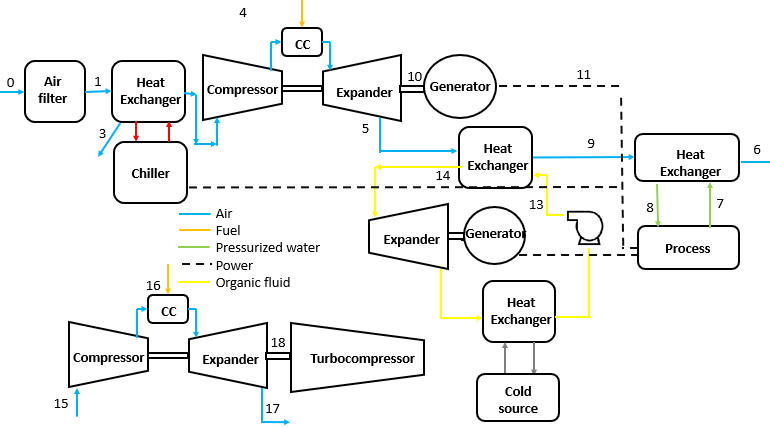

In [13]:
from IPython.display import Image
print("Base Case + ORC (Config. 2) + SRC e CO2 compression system")
print('Turbine: GE LM2500')
Image(filename='ORC_SRC.png')

In [54]:
DELTAP_HRSG_Projeto = 11.48
DELTAP_ORC_Projeto = 3
DELTAP_exhaust = DELTAP_HRSG_Projeto + DELTAP_ORC_Projeto
DELTAP_AirCooler_Projeto = 4.799
DELTAP_entrada = DELTAP_filtro + DELTAP_AirCooler_Projeto

conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS SRC_ORC_2500')
cur.execute('DROP TABLE IF EXISTS SRC_ORCWithoutCO2_2500')
cur.execute('CREATE TABLE SRC_ORC_2500 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, CO2EmitCO2 REAL, EtaExergCO2 REAL, EtaExergTotal REAL, CO2EmitTotal REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, RelmCO2CO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL)')
cur.execute('CREATE TABLE SRC_ORCWithoutCO2_2500 (id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,year REAL, day REAL, nturb REAL, ThermalProc REAL, PowerPrincipal REAL, PowerCompCO2 REAL, CargaOper REAL, W_ORC REAL, QGasProdDispInd REAL, QGasProdDispTot REAL, FACoger REAL, CO2Emit REAL, EtaExerg REAL, WTDispTotal REAL, RelmCO2mCO2Total REAL, EtaOperTurb REAL, Epsilon_HRSG REAL, EtaExergHRSG REAL, EtaExerg_HE_ORC REAL, Epsilon_HE_ORC REAL, EtaExergORC REAL)')
conn.commit()
cur.close()

for i in range(22):
    NTurb1 = list()
    CargaOperTurb1 = list()
    QGasProdOffDispInd1 = list()
    QGasProdOffDisTotal1 = list()
    FACogeração1 = list()
    CO2Emit1 = list()
    EtaExerg1 = list()
    CO2EmitCo21 = list()
    EtaExergCO21 = list()
    EtaExergTotal1 = list()
    CO2EmitTotal1 = list()
    DeltaWOper1 = list()
    RelMCO2MCO2Total1 = list()
    RelMCO2CO2MCO2Total1 = list()
    EtaOperTurb1 = list()
    Epsilon_HRSG1 = list()
    EtaExergHRSG1 = list()
    EtaExergHEORC1 = list()
    Epsilon_HE_ORC1 = list()
    EtaExergORC1 = list()
    
    NTurb2 = list()
    CargaOperTurb2 = list()
    QGasProdOffDispInd2 = list()
    QGasProdOffDispTotal2 = list()
    FACogeração2 = list()
    CO2Emit2 = list()
    EtaExerg2 = list()
    DeltaWOper2 = list()
    EtaOperTurb2 = list()
    Epsilon_HRSG2 = list()
    EtaExergHRSG2 = list()
    EtaExergHEORC2 = list()
    Epsilon_HE_ORC2 = list()
    EtaExergORC2 = list()
    for j in range(12):
        Ponto0 = {'T': (ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':P_amb,
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        Ponto1 = {'T':(ambiente['Temperatura'][j]+273.15),
          'UR':(ambiente['Umidade'][j]/100),
          'P':(P_amb-DELTAP_filtro*9.80665),
          'H':cp.HAPropsSI('H','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'S':cp.HAPropsSI('S','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)/1000,
          'W':cp.HAPropsSI('W','T',(ambiente['Temperatura'][j]+273.15),'R',(ambiente['Umidade'][j]/100),'P',P_amb)}
        PlantaCO2 = True
#             Planta principal - GE LM2500
        TG = 2
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
        Sistema = 'Compressão'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['principal'][i]
        while True:
            if m_ar_off == TurbProj['m_ar_iso']:
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['principal'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
#                 print('Potencia',Potencia)
                ORC = 2
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
                m_ar_off = TurbOffdesign['m_ar_real']
            else:
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['principal'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
#                 print('Potencia', Potencia)
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
#                 print('n_turb', TurbOffdesign['n_turb_real'])
#                 print('carga', TurbOffdesign['Carga_Oper_Turb'])
#                 print('Trabalho real',TurbOffdesign['WT_real'])
#                 print('W_ORC', TurbOffdesign['W_ORC'])
#                 print('W_maximo', TurbOffdesign['WTmaximo'])          
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
                if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.05):
                    m_ar_off = TurbOffdesign['m_ar_real']
                else: break
        Configuração = 'SRC_ORC'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['principal'][i]+TurbOffdesign['W_ORC']* TurbOffdesign['n_turb_real']/1000 - ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
        EtaExergORC = TurbOffdesign['Q_ORC'] / (Ponto5['m'] * Ponto5['E'])
        #             Planta de CO2
        Ponto14 = Ponto0
        Ponto15 = Ponto1
        TG = 2
        TurbProj_CO2 = tgprojeto(TG_CO2,PCI_GN_m,Perc_ar_resf)
        TurbOffdesign_CO2 = turboffdesign(demandas['co2'][i],TG_CO2,Ponto15,PCI_GN_m,PCI_fuel(),eta_ger_CO2,DELTAP_entrada_CO2,DELTAP_HRSG_CO2) 
        excesso_CO2, T_chama_CO2, molar_fraction_prod_CO2,Ponto16 = combustor(T_comb,fuel_mol,Ponto15,TurbProj_CO2,TurbOffdesign_CO2)
        Ponto17 = {'T':TurbOffdesign_CO2['T_gas_exaust']+273.15,'P':101325,'m':TurbOffdesign_CO2['m_exaust']}
        props = Prop(molar_fraction_prod, Ponto17)
        Ponto17.update({'H':props['H'],'S':props['S'],'cp':props['cp']})
        DELTAW_oper_CO2 = TurbOffdesign_CO2['n_turb_real']*TurbOffdesign_CO2['WTmaximo']/1000-demandas['co2'][i]
        Ponto18 = {'E':TurbOffdesign_CO2['WT_real']*eta_ger_CO2/100}
        Rel_m_CO2_CO2_m_CO2_total, Rel_m_CO2_m_CO2_total, CO2_emit, FA_coger, eta_exerg, CO2_emit_CO2, eta_exerg_CO2, CO2_emit_total, eta_exerg_total = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb1.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb1.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd1.append(Q_gasprod_off_disp_ind)
        QGasProdOffDisTotal1.append(Q_gasprod_off_disp_total)
        FACogeração1.append(FA_coger)
        CO2Emit1.append(CO2_emit)
        EtaExerg1.append(eta_exerg)
        CO2EmitCo21.append(CO2_emit_CO2)
        EtaExergCO21.append(eta_exerg_CO2)
        EtaExergTotal1.append(eta_exerg_total)
        CO2EmitTotal1.append(CO2_emit_total)
        DeltaWOper1.append(DELTAW_oper)
        RelMCO2MCO2Total1.append(Rel_m_CO2_m_CO2_total)
        RelMCO2CO2MCO2Total1.append(Rel_m_CO2_CO2_m_CO2_total)
        EtaOperTurb1.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG1.append(Epsilon_HRSG)
        EtaExergHRSG1.append(EtaExergHRSG)
        EtaExergHEORC1.append(Epsilon_HE_ORC)
        Epsilon_HE_ORC1.append(EtaExerg_HE_ORC)
        EtaExergORC1.append(EtaExergORC)
#           Planta principal suprindo demanda principal e de CO2
        PlantaCO2 = False
        TurbProj = tgprojeto(TG,PCI_GN_m,Perc_ar_resf)
        Prod_Gas_seg.append(demandas['gas'][i]*3600*24*cp.PropsSI('V','T',Ponto0['T'],'P',Ponto0['P'],'Methane'))
        Sistema = 'Compressão'
        m_ar_off = TurbProj['m_ar_iso']
        Potencia = demandas['total'][i]
        while True:
            if m_ar_off == TurbProj['m_ar_iso']:
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                TurbOffdesign = turboffdesign(Potencia,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['total'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
                ORC = 2
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
                m_ar_off = TurbOffdesign['m_ar_real']
#                 print('dia', j)
            else:
#                 print('m_ar_off', m_ar_off)
                ResfComp,Ponto2 = SistResfriamento(m_ar_off,Ponto1['T'],Ponto1['P'],Ponto1['UR'], Sistema)
                DELTAP_entrada = DELTAP_filtro + ResfComp['DELTA_P_Off'] * 0.00401865
                Potencia = demandas['total'][i] + ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
                excesso, T_chama, molar_fraction_prod,Ponto4 = combustor(T_comb,fuel_mol,Ponto2,TurbProj,TurbOffdesign)
                Ponto0.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto0['W'])})
                Ponto1.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto1['W'])})
                Ponto2.update({'m':TurbOffdesign['m_ar_real']*(1+Ponto2['W'])})
                Ponto3 = dict()
                Ponto3.update({'m':Ponto1['m']-Ponto2['m'], 'T':Ponto2['T'], 'P':Ponto0['P']})
                Ponto3.update({'H': cp.PropsSI('H','T',Ponto3['T'],'P',Ponto3['P'],'Water'),'S': cp.PropsSI('S','T',Ponto3['T'],'P',Ponto3['P'],'Water')})
                Ponto5 = {'T':TurbOffdesign['T_gas_exaust']+273.15,'P':101325 + DELTAP_exhaust * 9.806650,'m':TurbOffdesign['m_exaust']}
                props = Prop(molar_fraction_prod, Ponto5)
                Ponto5.update({'H':props['H'],'S':props['S'],'cp':props['cp'], 'E': props['E']})
                ORC = 2
                TurbOffdesign = TurbORC(ORC,Potencia, demandas['termico'][i],Ponto5,TG,Ponto2,PCI_GN_m,PCI_fuel(),eta_ger,DELTAP_entrada,DELTAP_exhaust)
                EtaExergORC = TurbOffdesign['Q_ORC'] / (Ponto5['m'] * Ponto5['E'])
                Ponto9, Epsilon_HE_ORC, EtaExerg_HE_ORC = HeatExchangerORC(Ponto5,molar_fraction_prod,TurbOffdesign['Q_ORC'])
#                 print('relação', abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']))
                if(abs((m_ar_off - TurbOffdesign['m_ar_real'])/TurbOffdesign['m_ar_real']) > 0.02):
                    m_ar_off = TurbOffdesign['m_ar_real']
#                     print('m_ar_off',m_ar_off)
                else: break
        Configuração = 'SRC_ORC'
        Q_gasprod_off_disp_total, Q_gasprod_off_disp_ind, Ponto6, Ponto7, Ponto8, Epsilon_HRSG, EtaExergHRSG = HeatRecoverySystem(Configuração, TurbOffdesign['n_turb_real'], molar_fraction_prod, demandas['termico'][i], Ponto9)
        Ponto10 = {'E':TurbOffdesign['WT_real']}
        Ponto11 = {'E':TurbOffdesign['WT_real']*eta_ger/100}
        DELTAW_oper = TurbOffdesign['n_turb_real']*TurbOffdesign['WTmaximo']/1000-demandas['total'][i]+TurbOffdesign['W_ORC']* TurbOffdesign['n_turb_real']/1000 - ResfComp['WT_chiller'] * TurbOffdesign['n_turb_real']/1000
        EtaExergORC = TurbOffdesign['Q_ORC'] / (Ponto5['m'] * Ponto5['E'])
        molar_fraction_prod_CO2 = {}
        TurbOffdesign_CO2 = {}
        CO2_emit, FA_coger, eta_exerg = AnaliseGlobal(PlantaCO2,fuel_mol, molar_fraction_prod, molar_fraction_prod_CO2, TurbOffdesign, TurbOffdesign_CO2, demandas['termico'][i], demandas['co2'][i], demandas['principal'][i], demandas['total'][i], Ponto4, Ponto7, Ponto8)
        NTurb2.append(TurbOffdesign['n_turb_real'])
        CargaOperTurb2.append(TurbOffdesign['Carga_Oper_Turb'])
        QGasProdOffDispInd2.append(Q_gasprod_off_disp_ind)
        QGasProdOffDispTotal2.append(Q_gasprod_off_disp_total)
        FACogeração2.append(FA_coger)
        CO2Emit2.append(CO2_emit)
        EtaExerg2.append(eta_exerg)
        DeltaWOper2.append(DELTAW_oper)
        EtaOperTurb2.append(TurbOffdesign['eta_oper'])
        Epsilon_HRSG2.append(Epsilon_HRSG)
        EtaExergHRSG2.append(EtaExergHRSG)
        EtaExergHEORC2.append(Epsilon_HE_ORC)
        Epsilon_HE_ORC2.append(EtaExerg_HE_ORC)
        EtaExergORC2.append(EtaExergORC)
#         Inserir valores no banco de dados
    conn = sqlite3.connect('FPSO2.sqlite')
    cur = conn.cursor()
    cur.execute(''' INSERT INTO SRC_ORC_2500 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,CO2EmitCO2,EtaExergCO2,EtaExergTotal,CO2EmitTotal,WTDispTotal,RelmCO2mCO2Total,RelmCO2CO2mCO2Total,EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''', 
                (i+1,j+1,np.mean(NTurb1),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb1),TurbOffdesign['W_ORC'],np.mean(QGasProdOffDispInd1),np.mean(QGasProdOffDisTotal1),np.mean(FACogeração1),np.mean(CO2Emit1),np.mean(EtaExerg1),np.mean(CO2EmitCo21),np.mean(EtaExergCO21),np.mean(EtaExergTotal1),np.mean(CO2EmitTotal1),np.mean(DeltaWOper1),np.mean(RelMCO2MCO2Total1),np.mean(RelMCO2CO2MCO2Total1), np.mean(EtaOperTurb1), np.mean(Epsilon_HRSG1), np.mean(EtaExergHRSG1), np.mean(EtaExergHEORC1), np.mean(Epsilon_HE_ORC1), np.mean(EtaExergORC1)))
    cur.execute(''' INSERT INTO SRC_ORCWithoutCO2_2500 (year,day,nturb,ThermalProc,PowerPrincipal,PowerCompCO2,CargaOper,W_ORC,QGasProdDispInd,QGasProdDispTot,FACoger,CO2Emit,EtaExerg,WTDispTotal, EtaOperTurb, Epsilon_HRSG, EtaExergHRSG, EtaExerg_HE_ORC, Epsilon_HE_ORC, EtaExergORC) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)''',
                (i+1,j+1,np.mean(NTurb2),demandas['termico'][i],demandas['principal'][i],demandas['co2'][i],np.mean(CargaOperTurb2),TurbOffdesign['W_ORC'],np.mean(QGasProdOffDispInd2),np.mean(QGasProdOffDispTotal2),np.mean(FACogeração2),np.mean(CO2Emit2),np.mean(EtaExerg2),np.mean(DeltaWOper2), np.mean(EtaOperTurb2), np.mean(Epsilon_HRSG2), np.mean(EtaExergHRSG2), np.mean(EtaExergHEORC2), np.mean(Epsilon_HE_ORC2), np.mean(EtaExergORC2)))
    conn.commit()
    cur.close()

p2 99600.98955213961
312.6127004950654
6.213364693047234
{'T': 836.5985018994076, 'P': 101467.000292, 'm': 70.03830522430353, 'H': 1027.8093873073278, 'S': 7.725708668432346, 'cp': 1205.2852126109583, 'E': 264.2913305511914}
0.18059060121685522
0.17589044655228186
0.17114149469096593
0.16634301043120592
0.16149424347253988
0.15659442800747597
0.1516427822994136
0.14663850824619315
0.14158079092871342
0.1364687981440075
0.13130167992215705
0.1260785680263877
0.12079857543566629
0.11546079580907798
0.11006430293124866
0.10460815013802015
0.09909136972157057
0.09351297231412503
0.08787194624936154
0.08216725690058449
0.0763978459946823
0.07056263090085658
0.06466050389304591
0.05869033138493048
0.052650953136344984
0.0465411814298733
312.92484035803324
6.213334589038586
Q_maximo 34057.562638345575
eta exerg 29.04439074274515
epsilon 38.170670455915825
310.948237410936
6.276719575209716
{'T': 816.770662276364, 'P': 101467.000292, 'm': 64.84621150293071, 'H': 990.7659859061612, 'S': 7.72713

310.96157661356744
6.277003053684638
{'T': 816.772292593892, 'P': 101467.000292, 'm': 64.85761044798635, 'H': 990.6186727821532, 'S': 7.726965945061409, 'cp': 1191.9241026557127, 'E': 247.35066010460133}
0.20233727575086263
0.1976333849068324
0.19287917699904064
0.18807386764889386
0.18321665575075863
0.17830672300254935
0.1733432334199082
0.16832533283330414
0.16325214836734886
0.1581227879015976
0.15293633951206817
0.1476918708926731
0.14238842875572832
0.13702503821065976
0.13160070211998648
0.12611440043162273
0.12056508948648706
0.11495170130036773
0.10927314281893982
0.10352829514477524
0.09771601273513858
0.09183512256929519
0.08588442328400626
0.07986268427581006
0.07376864476863733
0.06760101284521879
0.061358464440683665
0.0550396422966629
0.04864315487412362
311.27267368547666
6.277560822215543
Q_maximo 29656.05526440667
eta exerg 33.51249785016275
epsilon 43.8359042836107
310.96157661356744
6.277003053684638
p2 101295.58005
310.96157661356744
6.277003053684638
p2 99600.9895

311.072644616153
6.284287056277392
p2 99600.98955213961
309.5622180018907
6.341315021061535
{'T': 844.2943973918661, 'P': 101467.000292, 'm': 56.85355276139165, 'H': 1007.102974304289, 'S': 7.790390823455458, 'cp': 1190.5585622289716, 'E': 265.4988058186502}
0.22704495955696793
0.22255785363506086
0.21802340428987554
0.21344088572456124
0.20880955700455067
0.2041286616431706
0.19939742717306772
0.19461506470288514
0.18978076845858585
0.18489371530880055
0.1799530642735482
0.1749579560156421
0.16990751231407356
0.1648008355186171
0.15963700798488506
0.1544150914890058
0.14913412662107264
0.1437931321564696
0.13839110440412972
0.1329270165307506
0.127399817859932
0.12180843314516385
0.11615176181552996
0.11042867719294837
0.10463802567970823
0.09877862591500054
0.09284926789908408
0.08684871208365458
0.08077568842692041
0.0746288954118116
0.06840699902567071
0.06210863169969894
0.05573239120633311
0.04927683951265176
309.8724904240665
6.342563043343385
Q_maximo 27829.329833806267
eta exe

307.8020976039976
6.4103946801675855
{'T': 835.4345572424477, 'P': 101467.000292, 'm': 51.16612051608934, 'H': 980.9893055653163, 'S': 7.807826949660047, 'cp': 1179.266260499341, 'E': 256.5427768121413}
0.2589981070886383
0.25461420516884914
0.2501830559711732
0.24570391776511658
0.24117603295595327
0.2365986276398077
0.23197091114317453
0.22729207554624117
0.22256129518934062
0.2177777261618334
0.212940505772691
0.20804875200200443
0.2031015629326231
0.19809801616107842
0.19303716818691402
0.18791805377949686
0.18273968532134696
0.17750105212696995
0.17220111973613259
0.16683882918046955
0.16141309622225414
0.15592281056411025
0.15036683502838574
0.1447440047048369
0.13905312606521592
0.13329297604328133
0.12746230107866957
0.12155981612300473
0.11558420360652236
0.10953411236341297
0.10340815651398899
0.0972049143016888
0.09092292688282577
0.08456069706688649
0.07811668800506422
0.07158932182459742
0.06497697820635355
0.0582779929029649
0.051490656194680955
0.044613211279949695
308.1

312.69971215998174
6.217163190911115
{'T': 836.2583686104504, 'P': 101467.000292, 'm': 69.98001370369091, 'H': 1025.7901118508812, 'S': 7.724256174481371, 'cp': 1204.230879807215, 'E': 263.7506266394275}
0.18109681852046844
0.1763931876973196
0.17164064834000306
0.16683846234834673
0.16198587643888346
0.15708212173368372
0.1521264133352557
0.14711794988695925
0.1420559131183554
0.13693946737481383
0.1317677591312351
0.12653991648777035
0.1212550486492713
0.11591224538532947
0.11051057647160008
0.10504909111114162
0.09952681733501438
0.09394276138127604
0.08829590705147498
0.0825852150436952
0.07680962226117026
0.07096804109543263
0.06505935868291554
0.05908243613388122
0.05303610773249034
0.046919180106770875
313.01199319705046
6.217227240193472
Q_maximo 33970.786118609845
eta exerg 29.128176224698855
epsilon 38.26817535105069
310.98787601436396
6.282308844414825
{'T': 816.8112266003006, 'P': 101467.000292, 'm': 64.51925306839438, 'H': 988.8047641086724, 'S': 7.727020848217779, 'cp': 1

311.01715210643283
6.281243777905414
{'T': 816.7710221728235, 'P': 101467.000292, 'm': 64.6743818502133, 'H': 988.9868838345404, 'S': 7.726454935964472, 'cp': 1190.9616856315947, 'E': 247.08002495279953}
0.20324531052179595
0.19854157721052101
0.19378746327525728
0.18898218227436198
0.18412493097356739
0.1792148888742004
0.17425121772489652
0.16923306101612962
0.164159543456847
0.15902977043247996
0.1538428274435465
0.14859777952404785
0.143293670638805
0.1379295230588574
0.13250433671399314
0.12701708852144344
0.1214667316897274
0.11585219499658332
0.11017238203987373
0.10442617046030062
0.09861241113471092
0.09272992733870757
0.08677751387723232
0.08075393618171128
0.07465792937229017
0.06848819728361608
0.06224341145254294
0.05592221006606313
0.04952319686767956
311.3283601884318
6.281894418907049
Q_maximo 29548.298299448845
eta exerg 33.64425327768511
epsilon 43.995765401632234
311.01715210643283
6.281243777905414
p2 101295.58005
311.01715210643283
6.281243777905414
p2 99600.989552

312.2319244816953
6.230419884933575
p2 99600.98955213961
310.803878867349
6.284696082030463
{'T': 817.2382340846385, 'P': 101467.000292, 'm': 63.98036883685947, 'H': 989.2824466987838, 'S': 7.730512430528998, 'cp': 1190.9857147411956, 'E': 247.4084235265965}
0.20538858819655564
0.2006988478276823
0.19595888771056394
0.1911679240925012
0.18632515649035505
0.1814297672206595
0.17648092091329637
0.17147776400805684
0.16641942423338885
0.16130501006659317
0.15613361017469826
0.150904292835212
0.14561610533590505
0.14026807335274627
0.1348592003050696
0.12938846668700407
0.12385482937416097
0.11825722090451549
0.11259454873237816
0.10686569445429726
0.10106951300567074
0.09520483182679891
0.08927044999704109
0.08326513733567842
0.07718763346801086
0.07103664685515747
0.06481085378593794
0.05850889732915075
0.052129386244462665
0.04567089385005489
311.1148913635267
6.285338992976868
Q_maximo 29267.410249739427
eta exerg 33.96405968136509
epsilon 44.418005860685064
309.77654553352914
6.323506

309.8316880486943
6.325843345689361
{'T': 839.0195528562483, 'P': 101467.000292, 'm': 58.277835273499434, 'H': 1005.0145993933882, 'S': 7.778192224495068, 'cp': 1191.4709629338593, 'E': 262.1650931287723}
0.2219563478426454
0.2174292844656924
0.21285437131958632
0.20823087319727993
0.20355803950670842
0.1988351038479458
0.19406128357583385
0.1892357793475087
0.18435777465420333
0.17942643533668673
0.1744409090836709
0.16940032491248389
0.16430379263127426
0.15915040228198138
0.15393922356327136
0.14866930523259309
0.1433396744864821
0.13794933631818726
0.13249727285166324
0.12698244265091155
0.12140378000362559
0.11576019417802196
0.11005056865170834
0.10427376031136922
0.09842859862199589
0.09251388476433012
0.08652839073912047
0.08047085843672484
0.07433999867051967
0.06813449017250488
0.061852978549407224
0.05549407519750599
0.04905635617431541
310.1420894612917
6.326902527157974
Q_maximo 28182.099722137176
eta exerg 35.18864465245832
epsilon 46.128571427161745
309.8316880486943
6.3

310.1326440075014
6.323018230709619
{'T': 836.0949288638121, 'P': 101467.000292, 'm': 58.923476920914396, 'H': 1001.2916288009285, 'S': 7.769501583506247, 'cp': 1190.4402014738998, 'E': 259.8899731571124}
0.22034053596330547
0.2157905270626604
0.21119228254493672
0.20654505879310386
0.20184809656948124
0.19710062058473135
0.1923018390519973
0.18745094322558725
0.18254710692357667
0.17758948603366692
0.1725772180016183
0.16750942130153285
0.16238519488723893
0.15720361762398766
0.15196374769963913
0.14666462201447888
0.14130525554875661
0.13588464070701056
0.13040174663818369
0.12485551853049898
0.11924487688000926
0.113568716731684
0.10782590689184665
0.10201528911071091
0.09613567723371302
0.0901858563202662
0.08416458172850343
0.07807057816449697
0.07190253869437924
0.06565912371770238
0.05933895990029525
0.052940639064794744
0.046462717036928884
310.44335016898407
6.324124767833696
Q_maximo 28264.521964117626
eta exerg 35.10774432880283
epsilon 45.99405578662805
312.22059377865963
6

312.15828835263096
6.242039270693226
{'T': 829.5069173766051, 'P': 101467.000292, 'm': 68.8343598748188, 'H': 1011.9659221730149, 'S': 7.724716396157494, 'cp': 1199.0083155974412, 'E': 257.7474488632124}
0.18662601654367567
0.18190683956471987
0.17713805317941733
0.1723188993746743
0.16744860433112996
0.1625263779893652
0.15755141360123526
0.15252288726573923
0.14743995744878927
0.14230176448623524
0.1371074300694581
0.13185605671282072
0.12654672720222873
0.12117850402402346
0.11575042877339047
0.11026152154143042
0.10471078028000312
0.09909718014340778
0.09341967280592549
0.08767718575419985
0.08186862155338967
0.07599285708596927
0.07004874276200682
0.0640351016996926
0.05795072887482908
0.05179439023793573
0.04556482179755889
312.47028371048316
6.242365917113237
Q_maximo 32712.51352703501
eta exerg 30.30268862604354
epsilon 39.74014405605441
312.15828835263096
6.242039270693226
p2 101295.58005
312.15828835263096
6.242039270693226
p2 99600.98955213961
310.92865574663153
6.2887509438

312.1522040422609
6.237113349661183
p2 99600.98955213961
310.8558536624816
6.286368056318644
{'T': 817.2478142436934, 'P': 101467.000292, 'm': 63.972406628621066, 'H': 988.5246392902835, 'S': 7.729879986486912, 'cp': 1190.5295880771234, 'E': 247.285703648133}
0.2055716229174379
0.20088055530325208
0.196139223682872
0.19134684312478173
0.186502611932163
0.1816057111717935
0.17665530418646058
0.1716505360902074
0.16659053324571113
0.16147440272305263
0.1563012317391056
0.15107008707673977
0.1457800144829888
0.14043003804530424
0.1350191595449653
0.12954635778667795
0.12401058790335141
0.11841078063498515
0.1127458415805601
0.10701465042176392
0.10121606011733542
0.09534889606674421
0.08941195524186882
0.08340400528526781
0.07732378357357056
0.0711699962444432
0.06494131718550837
0.058636386983522054
0.05225381183202263
0.04579216239557593
311.16694314319886
6.287057328213664
Q_maximo 29253.290112971124
eta exerg 33.98514431541546
epsilon 44.43944578471775
309.7785660493248
6.327060369494

310.5337261609861
6.292416621276274
{'T': 820.5810136593971, 'P': 101467.000292, 'm': 62.47828939278896, 'H': 991.745527371991, 'S': 7.73978691769616, 'cp': 1191.1228729139368, 'E': 249.67834733341618}
0.20980410021042042
0.20515080108863734
0.20044777396101668
0.1956942446296629
0.19088942242076354
0.18603249972337116
0.1811226515120869
0.17615903485299844
0.17114078839218083
0.1660670318260416
0.16093686535275975
0.1557493691040315
0.1505036025563006
0.14519860392061265
0.1398333895101927
0.1344069530848025
0.12891826517089416
0.12336627235652181
0.11774989655993275
0.11206803427070462
0.10631955576223955
0.1005033042743731
0.09461809516479297
0.08866271502790277
0.08263592077969606
0.0765364387071399
0.0703629634804946
0.06411415712690911
0.057788647963570486
0.051385029488573014
0.04490185922760869
310.8445288018106
6.293109007842575
Q_maximo 28832.352411534914
eta exerg 34.464406603266866
epsilon 45.088239122656915
310.5337261609861
6.292416621276274
p2 99600.98955213961
310.32585

310.3881009516229
6.304848784168948
{'T': 826.4047575129923, 'P': 101467.000292, 'm': 60.974337209054845, 'H': 995.0038040201166, 'S': 7.751005815866166, 'cp': 1190.6869012485922, 'E': 253.44398406796836}
0.21427500946904318
0.20966268794269516
0.20500121254155096
0.20028982064279732
0.19552773346952373
0.19071415564085595
0.1858482747064643
0.18092926066480655
0.17595626546444398
0.17092842248773168
0.16584484601615745
0.1607046306765667
0.15550685086747912
0.1502505601646595
0.14493479070507798
0.13955855254834082
0.13412083301463934
0.12862059599821826
0.12305678125531348
0.11742830366546435
0.11173405246505079
0.1059728904518543
0.10014365315937601
0.09424514799959487
0.08827615337277799
0.08223541774289084
0.07612165867708152
0.06993356184764196
0.06366977999477116
0.0573289318483743
0.050909601007056264
0.04441033477236783
310.6988848353009
6.305714615966747
Q_maximo 28550.824176461654
eta exerg 34.78978473771147
epsilon 45.5328361789208
311.44506016130987
6.264808061626506
{'T':

311.4412747105396
6.269769589130921
{'T': 818.951166159548, 'P': 101467.000292, 'm': 66.4098586817375, 'H': 993.5288775596331, 'S': 7.722459697269897, 'cp': 1192.654055081574, 'E': 248.96804710745795}
0.19702906733566125
0.19230475891063128
0.18753003956850414
0.18270412578551967
0.17782621738649862
0.17289549707918725
0.167911129972369
0.16287226307708894
0.15777802479029626
0.15262752436017812
0.14741985133243612
0.14215407497670593
0.13682924369229885
0.1314443843923972
0.12599850186579659
0.12049057811525067
0.11491957167142022
0.10928441688139631
0.10358402317070098
0.09781727427763212
0.09198302745875968
0.08608011266431931
0.08010733168219669
0.07406345724913287
0.06794723212770529
0.061757368147582675
0.055492545209469724
0.0491514102500808
311.7528156284691
6.270354169241193
Q_maximo 30556.990647144194
eta exerg 32.51656401020442
epsilon 42.54345642251574
311.4412747105396
6.269769589130921
p2 101295.58005
311.4412747105396
6.269769589130921
p2 99600.98955213961
311.8935510228

311.4727974561575
6.274199493551467
p2 99600.98955213961
311.97252918044796
6.255207111566309
{'T': 825.4295632802666, 'P': 101467.000292, 'm': 68.07620678979305, 'H': 1003.6454869381676, 'S': 7.722711346247147, 'cp': 1195.8400494821046, 'E': 254.13657018762768}
0.1902688386671109
0.18554179705947182
0.18076473160324502
0.17593687219030515
0.17105743252192726
0.1661256096608729
0.1611405835680125
0.15610151662285712
0.15100755312734776
0.14585781879221854
0.14065142020521568
0.13538744428043292
0.13006495768797288
0.12468300626312687
0.11924061439421114
0.11373678438816909
0.10817049581300595
0.10254070481607155
0.09684634341717353
0.09108631877544285
0.08525951242883137
0.07936477950506521
0.07340094790282305
0.06736681744184639
0.061261158980632294
0.05508271350029224
0.048830191153089245
312.284480045799
6.255705831742297
Q_maximo 31934.79452112326
eta exerg 31.07551276402815
epsilon 40.70794941674403
310.69459031791905
6.303682417431411
{'T': 822.2919382039959, 'P': 101467.000292, 

310.5790706060679
6.297785256876767
{'T': 821.6631292618762, 'P': 101467.000292, 'm': 62.15402501496316, 'H': 991.0367224317603, 'S': 7.74102217973808, 'cp': 1190.2613422884317, 'E': 250.15656327459214}
0.21104950927708968
0.206402153747078
0.20170510784539225
0.19695759761910253
0.19215883264212277
0.18730800555410798
0.18240429158326144
0.17744684805239874
0.17243481386757997
0.1673673089885906
0.16224343388052045
0.157062268945656
0.15182287393485758
0.14652428733756886
0.14116552574955207
0.13574558321740585
0.1302634305588837
0.12471801465797382
0.1191082577336619
0.11343305658123955
0.10769128178497551
0.1018817769008993
0.09600335760839813
0.09005481082925644
0.08403489381270633
0.07794233318498552
0.07177582396182551
0.06553402852221822
0.05921557554172164
0.05281905888348862
0.04634303644510035
310.8899855355606
6.298587460437463
Q_maximo 28742.019961547154
eta exerg 34.57798301871884
epsilon 45.22994562453231
310.5790706060679
6.297785256876767
p2 99600.98955213961
310.377769

310.3824447473648
6.2981374677787505
{'T': 824.1859403697136, 'P': 101467.000292, 'm': 61.4926724925717, 'H': 994.6744231951203, 'S': 7.747510131996387, 'cp': 1191.3991823001065, 'E': 252.16151861126718}
0.2125391960659921
0.20791394093319285
0.2032393774399934
0.1985147401351242
0.19373924733591846
0.18891210067566913
0.1840324846352453
0.17909956605832492
0.17411249364957454
0.16907039745507418
0.16397238832425465
0.1588175573525775
0.1536049753041588
0.14833369201349444
0.14300273576540964
0.1376111126523123
0.13215780590778897
0.1266417752155333
0.12106195599255402
0.11541725864555644
0.10970656779933803
0.10392874149598878
0.09808261036362069
0.09216697675329785
0.08618061384276847
0.08012226470553638
0.07399064134373232
0.06778442368318022
0.061502258528961774
0.05514275847971228
0.048704500798780165
310.69314530731504
6.298882363666651
Q_maximo 28648.20008737039
eta exerg 34.6719795154618
epsilon 45.37806898985976
311.5691097798248
6.253147821815797
{'T': 822.959070968235, 'P': 

311.58461531921125
6.2533486908912685
{'T': 823.0237180256156, 'P': 101467.000292, 'm': 67.56313998359693, 'H': 1003.0814796782063, 'S': 7.724885670387405, 'cp': 1196.5566827416183, 'E': 252.75811392222204}
0.1918215143617698
0.18709996555632
0.18232842223681514
0.17750611403035135
0.17263225434271623
0.16770603990877417
0.16272665032730313
0.15769324757965802
0.15260497553159283
0.14746095941756354
0.14226030530678596
0.13700209955030004
0.1316854082082528
0.1263092764565792
0.12087272797221833
0.11537476429596871
0.10981436417203866
0.10419048286330373
0.09850205144124939
0.09274797604950695
0.08692713713986121
0.08103838867954133
0.07508055732855966
0.06905244158579162
0.06295281090244402
0.05678040476147883
0.05053393172150116
0.04421206842354288
311.89611862704464
6.2536899737184966
Q_maximo 31518.610365559012
eta exerg 31.482258864901674
epsilon 41.2454732274788
311.58461531921125
6.2533486908912685
p2 101295.58005
311.58461531921125
6.2533486908912685
p2 99600.98955213961
311.87

311.6477731438957
6.262460166373223
p2 99600.98955213961
312.0337057606704
6.24777882883841
{'T': 827.5845018598343, 'P': 101467.000292, 'm': 68.48912334008313, 'H': 1008.3519504024205, 'S': 7.724285726174684, 'cp': 1197.7022540791734, 'E': 256.09771320093995}
0.18823899797610844
0.1835164996194764
0.17874421314650596
0.17392137530773963
0.16904720688037742
0.16412091222832662
0.15914167884712063
0.154108676893097
0.14902105869620044
0.1438779582557388
0.1386784907184004
0.1334217518378012
0.12810681741480565
0.12273274271781913
0.11729856188222366
0.11180328728808533
0.10624590891522386
0.10062539367468545
0.0949406847156326
0.08919070070659284
0.08337433508998733
0.07749045530878465
0.07153790200408673
0.06551548818238973
0.0594219983512073
0.053256187621675756
0.04701678077669941
312.3456342422993
6.248166387311055
Q_maximo 32355.295501247292
eta exerg 30.651625374827802
epsilon 40.17889436212645
310.7310139556819
6.297223126200129
{'T': 820.1514577560562, 'P': 101467.000292, 'm': 6

310.7495329696783
6.299717913112415
{'T': 820.6402994502189, 'P': 101467.000292, 'm': 62.45960414958926, 'H': 988.4966026873594, 'S': 7.73719264368459, 'cp': 1189.1592905658226, 'E': 249.16397879758716}
0.21055664103642432
0.20589756768239145
0.2011885770327688
0.19642888986958273
0.19161771035095435
0.1867542255447458
0.18183760494590365
0.17686699997683283
0.1718415434701063
0.16676034913277762
0.16162251099153363
0.1564271028178909
0.15117317753259835
0.14585976658837518
0.14048587933006484
0.13505050233125054
0.12955259870633196
0.12399110739700595
0.1183649424320594
0.11267299215931934
0.10691411844855177
0.10108715586404857
0.09519091080557301
0.08922416061627948
0.08318565265614482
0.07707410333938812
0.07088819713427442
0.06462658552361968
0.05828788592423841
0.05187068056347294
0.045373515310867606
311.06065949541767
6.300609609017989
Q_maximo 28780.616689130024
eta exerg 34.545885713444484
epsilon 45.16928924914208
310.7495329696783
6.299717913112415
p2 99600.98955213961
310.

310.48186640565183
6.301460581269169
{'T': 824.1861891990752, 'P': 101467.000292, 'm': 61.49261176227427, 'H': 993.1570100315593, 'S': 7.746269558413006, 'cp': 1190.493415953679, 'E': 251.9053470904724}
0.2128641382021723
0.20823605937713915
0.20355858331506568
0.19883094223110762
0.19405235204056495
0.18922201190387397
0.18433910375576149
0.17940279181791452
0.1744122220944919
0.16936652184976975
0.16426479906718383
0.159106141888994
0.15388961803576362
0.14861427420481035
0.14327913544673715
0.13788320451912478
0.13242546121640977
0.1269048616749353
0.12132033765211414
0.1156707957785829
0.10995511678218801
0.10417215468257797
0.0983207359551207
0.09239965866280399
0.08640769155471198
0.08034357312959887
0.07420601066301734
0.06799367919637003
0.0617052204861886
0.05533924191184526
0.048894315339825405
310.7927156683313
6.302296579169587
Q_maximo 28626.4101146093
eta exerg 34.70727296349013
epsilon 45.412610061663074
311.5525990229463
6.2608783878872565
{'T': 821.240679579271, 'P': 1

311.6078843709959
6.258821708974028
p2 99600.98955213961
311.96143680064915
6.245370915222201
{'T': 827.6115017022028, 'P': 101467.000292, 'm': 68.49409955450312, 'H': 1009.4814120120902, 'S': 7.725204434134272, 'cp': 1198.3637403962716, 'E': 256.3076115478069}
0.18801472556550664
0.18329446806521768
0.1785244894500593
0.1737040281952261
0.16883230685245085
0.1639085316117589
0.15893189184815645
0.1539015596526537
0.14881668934698392
0.14367641698135689
0.13847985981455455
0.1332261157756433
0.12791426290654878
0.12254335878469694
0.11711243992489907
0.1116205211596098
0.10606659499665558
0.10044963095348423
0.09476857486694454
0.08902234817755722
0.08320984718718978
0.07732994228900163
0.07138147716845908
0.065363267974184
0.05927410245731933
0.05311273907804575
0.046877906077815924
312.27325721155796
6.24569291929651
Q_maximo 32377.733512701692
eta exerg 30.624298727104637
epsilon 40.15105008786405
310.67402337845107
6.294237768159809
{'T': 819.8755208661979, 'P': 101467.000292, 'm':

310.66111787477143
6.2901010841717335
{'T': 819.0341493690496, 'P': 101467.000292, 'm': 63.02176316644602, 'H': 990.1809468156968, 'S': 7.735552952022762, 'cp': 1190.8113927705454, 'E': 248.55835454114117}
0.20832348763764502
0.20365532164833017
0.19893720479427077
0.19416835825568593
0.18934798660935648
0.18447527736298755
0.17954940047330073
0.17456950784718855
0.16953473282524004
0.16444418964690274
0.1592969728965271
0.15409215692949366
0.1488287952775899
0.14350592003276924
0.138122541208374
0.1326776460768752
0.127170198483125
0.12159913813207514
0.11596337984986987
0.11026181281716227
0.10449329977345269
0.09865667619118892
0.09275074941830909
0.08677429778784218
0.0807260696931163
0.07460478262704892
0.06840912218393257
0.06213774102203076
0.05578925778523372
0.049362255981930364
310.9720350052077
6.29079358913777
Q_maximo 28959.46071225098
eta exerg 34.32115559987098
epsilon 44.890338701992796
310.66111787477143
6.2901010841717335
p2 99600.98955213961
310.42438899328704
6.2973

310.58616289214274
6.302701419486986
{'T': 823.4015508749351, 'P': 101467.000292, 'm': 61.68782598652459, 'H': 991.3978012756274, 'S': 7.743707221918934, 'cp': 1189.7643362847111, 'E': 251.1757583883997}
0.21256704531704626
0.20793110480626828
0.20324561325358523
0.19850979928912973
0.1937228751401157
0.1888840361722296
0.18399246041503695
0.17904730807075034
0.17404772100567908
0.16899282222364462
0.16388171532061185
0.15871348391976647
0.15348719108620623
0.14820187872040327
0.14285656692953824
0.137450253375769
0.13198191260045533
0.12645049532331273
0.12085492771541868
0.11519411064494935
0.1094669188944611
0.10367220034848763
0.09780877515015074
0.09187543482543113
0.08587094137367525
0.07979402632284362
0.07364338974793438
0.06741769925094275
0.06111558890062977
0.054735658130291735
0.04827647059163109
310.8971423695677
6.30359322502577
Q_maximo 28642.1127019768
eta exerg 34.69793502896351
epsilon 45.38771331314109
311.7158763317077
6.259871465332159
{'T': 822.5419196889862, 'P':

311.70414633992687
6.263521218706505
{'T': 821.7025691289175, 'P': 101467.000292, 'm': 67.24428674654061, 'H': 997.6885137339948, 'S': 7.722021754828545, 'cp': 1193.9214049215436, 'E': 251.13243254928176}
0.1937728775396196
0.18904472274447215
0.18426628879299553
0.1794367973121489
0.1745554534613999
0.1696214454742848
0.16463394418405702
0.15959210253277156
0.15449505506313527
0.14934191739241287
0.14413178566764845
0.1388637360014339
0.13353682388741134
0.12815008359466906
0.12270252754013951
0.11719314563808318
0.11162090462568108
0.10598474736372675
0.10028359211135526
0.09451633177369763
0.08868183312129739
0.08277893598007012
0.07680645239052551
0.07076316573492242
0.06464782983094375
0.05845916799042741
0.052195872041611864
0.04585660131327782
312.01590217374127
6.264080178149769
Q_maximo 31194.70727976066
eta exerg 31.836302450331143
epsilon 41.67373613547093
311.70414633992687
6.263521218706505
p2 101295.58005
311.70414633992687
6.263521218706505
p2 99600.98955213961
312.15527

311.64294695759565
6.261650647444441
p2 99600.98955213961
312.0962820519823
6.244401560778325
{'T': 828.7501998390808, 'P': 101467.000292, 'm': 68.70047933036047, 'H': 1010.5637023118758, 'S': 7.724746972925755, 'cp': 1198.5085241032045, 'E': 257.10243562813736}
0.187249165134205
0.18252868281966264
0.17775852162563457
0.17293792150470635
0.1680661065382745
0.1631422845003599
0.15816564640644942
0.15313536604676353
0.14805059950331892
0.14291048465012712
0.13771414063584447
0.13246066734815
0.1271491448591055
0.1217786328507043
0.11634817001979278
0.1108567734615034
0.10530343803029851
0.0996871356776833
0.09400681476560992
0.088261399354531
0.08244978846503306
0.0765708553119185
0.07062344650955034
0.06460638124722393
0.05851845043326804
0.052358415806514486
0.04612500901371446
312.40823821590226
6.244749821194413
Q_maximo 32572.972804952828
eta exerg 30.43791210849034
epsilon 39.91038852316024
310.7267421585664
6.296394283391377
{'T': 819.9800962195841, 'P': 101467.000292, 'm': 62.67

310.67451639438605
6.293232902513302
{'T': 819.632290225601, 'P': 101467.000292, 'm': 62.7965758047621, 'H': 989.7846747574135, 'S': 7.736423771305653, 'cp': 1190.3352579221205, 'E': 248.82280083258797}
0.209154235691153
0.20449018076629558
0.19977620429578918
0.19501152772101504
0.19019535588395464
0.1853268765616848
0.1804052599846038
0.17542965833772686
0.1703992052443539
0.1653130152313835
0.16017018317551007
0.15496978372951029
0.14971087072778477
0.14439247657028498
0.13901361158391268
0.13357326336043573
0.1280703960699256
0.12250394974866434
0.11687283956043179
0.11117595503001701
0.10541215924776133
0.0995802880438636
0.09367914913113272
0.0877075212148032
0.08166415306795867
0.07554776257104352
0.06935703571386961
0.0630906255584371
0.05674715116081453
0.05032519645023791
0.04382330906348559
310.98548464374176
6.29398522180605
Q_maximo 28889.156308861475
eta exerg 34.40762365933259
epsilon 44.999583445821756
310.67451639438605
6.293232902513302
p2 99600.98955213961
310.514192

310.433927756141
6.298694758690247
{'T': 823.7076543597227, 'P': 101467.000292, 'm': 61.61074788444019, 'H': 993.7182901437171, 'S': 7.746113882841322, 'cp': 1191.0252428485135, 'E': 251.7363505219331}
0.21233597868093018
0.20770617866037028
0.20302698391077226
0.19829762698864822
0.1935173241619847
0.1886852749556044
0.18380066168070508
0.17886264894792966
0.17387038316329412
0.16882299200626588
0.16371958388925956
0.1585592473977702
0.15334105071034607
0.14806404099754794
0.14272724379901966
0.137329662377734
0.13187027705045742
0.12634804449340895
0.12076189702205986
0.11511074184395718
0.10939346028340631
0.10360890697679499
0.09775590903727852
0.09183326518748093
0.0858397448588165
0.07977408725594863
0.07363500038484347
0.06742116004280081
0.061131208768757106
0.05476375475207462
0.04831737069794803
310.7446919322488
6.299466171719514
Q_maximo 28659.103477204124
eta exerg 34.66397830564403
epsilon 45.36080484981114
311.61391914710936
6.253955444188672
{'T': 823.097389228372, 'P':

311.6643412278248
6.256474896828171
{'T': 822.9082413462359, 'P': 101467.000292, 'm': 67.5365578279452, 'H': 1001.5821622611968, 'S': 7.723785696024518, 'cp': 1195.713972472996, 'E': 252.43910625298093}
0.19218427469092517
0.18746003666563482
0.18268571699476335
0.17786054300508217
0.17298372573418624
0.16805445947852543
0.16307192132578818
0.15803527067100986
0.15294364871573918
0.1477961779495706
0.14259196161331975
0.13733008314308276
0.13200960559438873
0.1266295710456166
0.12118899997981072
0.11568689064398585
0.11012221838497835
0.10449393496084443
0.09880096782677132
0.09304221939441021
0.08721656626349437
0.08132285842454508
0.07535991843142295
0.06932654054240601
0.0632214898284318
0.05704350124705794
0.05079127868063906
0.04446349393713493
311.97596931026567
6.25689680364603
Q_maximo 31474.69520412254
eta exerg 31.53445000880919
epsilon 41.30302109580799
311.6643412278248
6.256474896828171
p2 101295.58005
311.6643412278248
6.256474896828171
p2 99600.98955213961
312.0430238003

311.6497405719252
6.261850509596627
p2 99600.98955213961
312.1101833651204
6.244330662199901
{'T': 828.8610524152261, 'P': 101467.000292, 'm': 68.72023931018617, 'H': 1010.6580708509595, 'S': 7.724692703730779, 'cp': 1198.5160374366103, 'E': 257.17794480340785}
0.18717784401111737
0.18245732420011054
0.1776871290307701
0.17286649858352462
0.16799465707222705
0.16307081240815494
0.15809415574904365
0.153063861032555
0.14797908449354893
0.1428389641645009
0.13764261935838193
0.13238915013327374
0.12707763673797795
0.1217071390378257
0.11627669591987196
0.11078532467661087
0.10523202036731884
0.09961575515607646
0.09393547762549784
0.08819011206512234
0.08237855773340455
0.0764996880921657
0.07055235001232683
0.06453536294968643
0.05844751808944514
0.052287577458122195
0.04605427300143293
312.4221538676607
6.244682140776591
Q_maximo 32591.675938021137
eta exerg 30.420225713268785
epsilon 39.887485457089745
310.751088606634
6.29593001486771
{'T': 819.6762024321772, 'P': 101467.000292, 'm':

310.8037473007714
6.299553754980706
{'T': 820.1378677116553, 'P': 101467.000292, 'm': 62.62209275150592, 'H': 987.7411414951418, 'S': 7.735670335515099, 'cp': 1188.9111703004696, 'E': 248.75923570804116}
0.21017092313272048
0.20550678718455964
0.20079264902068203
0.1960277275608235
0.19121122504833626
0.18634232658200944
0.18142019963150868
0.17644399353577425
0.1714128389836659
0.16632584747613224
0.16118211076912606
0.1559807002964728
0.15072066657184896
0.14540103856898842
0.1400208230792035
0.13457900404525328
0.12907454187055484
0.12350637270267699
0.1178734076900192
0.1121745322105088
0.10640860507110905
0.10057445767686754
0.09467089316816586
0.08869668552478185
0.08265057863529314
0.07653128533028974
0.07033748637778407
0.06406782943912431
0.05772092798364133
0.051295360160165476
0.04478966762345578
311.11493211131443
6.300460096511999
Q_maximo 28812.061584992072
eta exerg 34.512309768350825
epsilon 45.11999240891383
310.8037473007714
6.299553754980706
p2 99600.98955213961
310.

310.48589770566144
6.300366876607559
{'T': 823.7372888941279, 'P': 101467.000292, 'm': 61.603350830167116, 'H': 992.9810739728279, 'S': 7.745502783450789, 'cp': 1190.5724813317684, 'E': 251.62790564185764}
0.21251913797156793
0.20788813366105452
0.20320769324359936
0.19847704817255665
0.19369541358031406
0.18886198782253458
0.18397595200652928
0.1790364695031129
0.174042685441272
0.16899372618492495
0.1638886987910478
0.15872669044838109
0.15350676789591364
0.14822797682029182
0.14288934123127042
0.13748986281427544
0.13202852025910558
0.1265042685637583
0.12091603831231221
0.1152627349257495
0.10954323788455095
0.10375639992183791
0.09790104618577664
0.09197597336990077
0.0859799488099401
0.07991170954567757
0.07376996134628132
0.06755337769748716
0.0612605987489206
0.054890230219769263
0.04844084226092392
310.7967388689293
6.301184761754406
Q_maximo 28646.942838611052
eta exerg 34.68308163979444
epsilon 45.38006052945476
311.5830944101008
6.258775320639986
{'T': 821.8704242825017, 'P

311.65191915885333
6.249998472279557
{'T': 824.2219002611299, 'P': 101467.000292, 'm': 67.82736988828422, 'H': 1005.3003863914346, 'S': 7.7253332104296515, 'cp': 1197.3541283154711, 'E': 253.77741505313065}
0.19065250939022282
0.18593200075683555
0.18116159802691448
0.17634053393882168
0.1714680251113778
0.16654327159805135
0.161565456425768
0.15653374511770773
0.1514472851994435
0.14630520568774255
0.14110661656131762
0.13585060821278822
0.13053625088107282
0.1251625940634018
0.11972866590610091
0.11423347257325758
0.1086759975923391
0.10305520117579088
0.09737001951759476
0.09161936406372759
0.08580212075539285
0.07991714924387007
0.07396328207574779
0.06793932384726321
0.061844050326406004
0.05567620754137285
0.04943451083390671
311.96345623906876
6.250302466637896
Q_maximo 31760.27137059658
eta exerg 31.233659424445328
epsilon 40.93164018754356
311.65191915885333
6.249998472279557
p2 101295.58005
311.65191915885333
6.249998472279557
p2 99600.98955213961
311.95348868299817
6.2385185

311.667659684611
6.2501903372978305
p2 99600.98955213961
311.96462514897274
6.238885546475108
{'T': 829.0749936077367, 'P': 101467.000292, 'm': 68.75822706913034, 'H': 1013.316307557166, 'S': 7.7267179571767945, 'cp': 1200.006667212169, 'E': 257.75444915748534}
0.18658367831309033
0.18186812698394925
0.17710305434161389
0.17228770446932734
0.16742130570042624
0.1625030701863468
0.15753219344982797
0.1525078539227186
0.1474292124677635
0.1422954118837231
0.13710557639314538
0.13185881111207956
0.1265542015009943
0.12119081279611897
0.11576768942040372
0.11028385437324327
0.10473830859808529
0.09913003032698786
0.09345797440115977
0.08772107156646654
0.08191822774283873
0.07604832326646609
0.0701102121036186
0.06410272103486621
0.05802464880842225
0.0518747652612737
0.045651810406688274
312.27637083847816
6.2390947156048835
Q_maximo 32667.902237577375
eta exerg 30.335417497008354
epsilon 39.79441319940741
310.65960402701677
6.288441684882038
{'T': 818.7078004922738, 'P': 101467.000292, '

310.77538212346474
6.295544329055038
{'T': 819.4039767727411, 'P': 101467.000292, 'm': 62.87979197793677, 'H': 988.3337700758738, 'S': 7.734773433405945, 'cp': 1189.5607943355674, 'E': 248.45223049018625}
0.20918407602946482
0.20451542153120733
0.19979673862860295
0.19502724614165756
0.19020614621510684
0.1853326238502765
0.18040584642057012
0.17542496316991243
0.1703891046934473
0.16529738239975927
0.16014888795384907
0.15494269270006206
0.14967784706413276
0.14435337993346484
0.13896829801472732
0.13352158516780713
0.12801220171510966
0.12243908372515161
0.11680114226934409
0.11109726265080597
0.10532630360399818
0.0994870964639071
0.09357844430344374
0.0875991210376691
0.08154787049337314
0.07542340544248313
0.06922440659768186
0.06294952156855402
0.0565973637764857
0.050166511326452404
0.043655505833754604
311.0864890169218
6.296370264974423
Q_maximo 28891.54071685174
eta exerg 34.41333961756027
epsilon 44.99586964712274
310.77538212346474
6.295544329055038
p2 99600.98955213961
310

310.66283899217063
6.304882934542586
{'T': 823.3261998239919, 'P': 101467.000292, 'm': 61.70699465896264, 'H': 990.266504817124, 'S': 7.742615266226161, 'cp': 1189.1186315962238, 'E': 250.94377113349543}
0.21274377804200087
0.2081052672334423
0.20341713360931352
0.19867860395678708
0.19388888860615863
0.1890471809703687
0.1841526570684584
0.17920447503231143
0.1742017745959899
0.16914367656695029
0.16402928227838465
0.15885767302190756
0.1536279094597613
0.14833903101568305
0.14299005524353384
0.13757997717274575
0.1321077686296051
0.12657237753333425
0.12097272716589309
0.11530771541437179
0.1095762139847766
0.10377706758598014
0.0979090930825213
0.0919710786148919
0.08596178268588295
0.07987993321147975
0.07372422653473641
0.06749332640097659
0.06118586289258135
0.05480043132154973
0.048335591077917094
310.9739288409989
6.3058383849017705
Q_maximo 28629.934452417718
eta exerg 34.719223313621626
epsilon 45.407019780662424
311.7125449392393
6.265093682838713
{'T': 821.437867618833, 'P'

311.62927632444473
6.257963993865956
{'T': 822.3517541917827, 'P': 101467.000292, 'm': 67.4052171427418, 'H': 1000.5900384591332, 'S': 7.723627224809502, 'cp': 1195.3665416045164, 'E': 251.97326982887023}
0.19274967983173968
0.188025202483476
0.18325060061660256
0.1784251001858762
0.1735479108113373
0.16861822532462076
0.16363521929954786
0.1585980505663666
0.15350585870896685
0.14835776454438127
0.14315286958383877
0.13789025547460862
0.1325689834218439
0.1271880935895858
0.12174660448006035
0.11624351229035433
0.11067779024551906
0.10504838790709947
0.09935423045604823
0.09359421794892399
0.08776722454623669
0.08187209771173036
0.0759076573813537
0.06987269510059751
0.06376597312881899
0.05758622350910834
0.05133214710217862
0.045002412582690596
311.94088368725227
6.258400852737646
Q_maximo 31359.519296892206
eta exerg 31.654308659945155
epsilon 41.45471707306536
311.62927632444473
6.257963993865956
p2 101295.58005
311.62927632444473
6.257963993865956
p2 99600.98955213961
312.0524547

311.68739664627674
6.255798727932233
p2 99600.98955213961
312.0534860716332
6.24186508788888
{'T': 829.0299083852938, 'P': 101467.000292, 'm': 68.75023754558575, 'H': 1011.9070737068423, 'S': 7.725576303494818, 'cp': 1199.1867459189666, 'E': 257.48508870229875}
0.18686523758744614
0.1821469135691371
0.17737898539088592
0.17256069500791948
0.16769126856414437
0.16276991595805912
0.15779583039378386
0.15276818791660057
0.14768614693238657
0.14254884771028126
0.13735541186790584
0.13210494183841923
0.1267965203186695
0.12142920969765063
0.1160020514644586
0.11051406559488486
0.10496424991575912
0.09935157944610502
0.0936750057141302
0.0879334560490303
0.08212583284653303
0.07625101280706142
0.07030784614534585
0.06429515577024807
0.0582117364335174
0.05205635384612367
0.045827743760756316
312.3653648237843
6.242155038345983
Q_maximo 32638.071084850704
eta exerg 30.370680994673503
epsilon 39.83078523912549
310.7184316041335
6.292557306534012
{'T': 819.1571283946828, 'P': 101467.000292, 'm'

310.6896820964392
6.289019933366727
{'T': 818.6290970324017, 'P': 101467.000292, 'm': 63.18993335625422, 'H': 989.948134762855, 'S': 7.734480488627015, 'cp': 1190.8338916193418, 'E': 248.29438811556105}
0.20781792934278884
0.2031457281674587
0.19842352317652154
0.1936505345374182
0.1888259657872267
0.18394900336610284
0.17901881613441506
0.17403455487290534
0.16899535176517508
0.16390031986177214
0.15874855252511072
0.15353912285443166
0.14827108308996378
0.14294346399541394
0.13755527421787633
0.13210549962419418
0.1265931026127843
0.12101702139986523
0.11537616927899677
0.10966943385277843
0.10389567623550242
0.098053730225494
0.09214240144582364
0.08616046645199552
0.08010667180516245
0.07397973310934099
0.06777833401102466
0.061501125159520775
0.055146723126245974
0.048713709281133645
311.00061835420536
6.289702515971232
Q_maximo 29006.806421860223
eta exerg 34.26620553587772
epsilon 44.81706745284062
310.6896820964392
6.289019933366727
p2 99600.98955213961
310.43747114933416
6.296

310.5992556660591
6.302206409772179
{'T': 823.0840278158299, 'P': 101467.000292, 'm': 61.769153216404604, 'H': 991.1383062902605, 'S': 7.743032543342666, 'cp': 1189.739321485558, 'E': 250.9567389001606}
0.2123427527803662
0.2077044313771836
0.20301652278639132
0.19827825487786593
0.19348883909718417
0.18864747000626023
0.1837533248079693
0.17880556285409943
0.17380332513595073
0.168745733756865
0.16363189138593653
0.15846088069212683
0.15323176375795544
0.14794358147192135
0.14259535289874573
0.13718607462651142
0.13171472008970295
0.12618023886712873
0.12058155595364367
0.114917571004543
0.10918715755144716
0.10338916218843781
0.09752240372714754
0.0915856723194402
0.08557772854625836
0.07949730247113804
0.07334309265682531
0.06711376514334498
0.060807952385793534
0.0544242521500493
0.0479612263644859
310.91024399245197
6.303093657979236
Q_maximo 28655.93602779887
eta exerg 34.682492961867915
epsilon 45.36581875178956
311.74516142833323
6.25875802952476
{'T': 822.9805258466799, 'P': 1

311.73236471774777
6.262448651900854
{'T': 822.1134465038668, 'P': 101467.000292, 'm': 67.34718343850805, 'H': 998.402125228548, 'S': 7.722107491515392, 'cp': 1194.1665609376657, 'E': 251.47247747972574}
0.19333853254142133
0.1886104017611792
0.1838320213358727
0.17900261386675967
0.1741213855203763
0.16918752557134722
0.16420020592933066
0.15915858064946212
0.15406178542561733
0.148908937065794
0.14369913294887476
0.13843145046200309
0.133104946417763
0.1277186564503271
0.12227159438968628
0.11676275161304248
0.11119109637239907
0.1055555730973386
0.09985510167193112
0.0940885766846685
0.08825486665026154
0.08235281320208963
0.0763812302540305
0.07033890313033633
0.06422458766215985
0.0580370092492688
0.051774861885411715
0.045436807145726996
312.04413876216034
6.262997770524019
Q_maximo 31281.900706052125
eta exerg 31.74467745317709
epsilon 41.557577086372135
311.73236471774777
6.262448651900854
p2 101295.58005
311.73236471774777
6.262448651900854
p2 99600.98955213961
312.21608080605

311.6711275392061
6.260579517087269
p2 99600.98955213961
312.15708958049777
6.242084947847953
{'T': 829.664030404583, 'P': 101467.000292, 'm': 68.86187937003884, 'H': 1012.1394357948526, 'S': 7.724958842600267, 'cp': 1199.0459032357799, 'E': 257.86349449395254}
0.18651945360206282
0.18180031883241127
0.17703158201470226
0.172212485371355
0.16734225532648142
0.16242010207239624
0.1574452191212733
0.15241678284134158
0.14733395197700552
0.14219586715222732
0.1370016503564993
0.13175040441268687
0.1264412124260003
0.12107313721331556
0.11564522071203065
0.11015648336760266
0.10460592349887853
0.09899251664028605
0.09331521485990567
0.08757294605240894
0.08176461320578823
0.07588909364076708
0.06994523822170835
0.0639318705378055
0.0578477860532667
0.05169175122514132
0.045462502587386155
312.4690841816428
6.2424120121464695
Q_maximo 32739.590269110777
eta exerg 30.27694707522479
epsilon 39.707277620591576
310.75513745809707
6.295319853860606
{'T': 819.5036846479891, 'P': 101467.000292, 'm

310.7029509541326
6.292156867809727
{'T': 819.18018641047, 'P': 101467.000292, 'm': 62.96454130013674, 'H': 989.4963662006924, 'S': 7.735288112847612, 'cp': 1190.344539942398, 'E': 248.52383453851434}
0.20865707007430423
0.20398881743894198
0.1992705862559803
0.19450159684907053
0.18968105291226808
0.1848081410434843
0.17988203026162894
0.17490187150677827
0.16986679712266947
0.1647759203207908
0.15962833462531012
0.15442311329803485
0.14915930874257555
0.14383595188683693
0.13845205154292006
0.1330065937434823
0.1274985410535478
0.12192683185672606
0.1162903796147303
0.11058807209905681
0.10481877059360624
0.09898130906699276
0.09307449331321214
0.08709710005928296
0.08104787603840334
0.07492553702709646
0.06872876684474838
0.06245621631385208
0.05610650217920005
0.04967820598417431
311.01393827463545
6.292899301785145
Q_maximo 28932.76866369536
eta exerg 34.35711804447934
epsilon 44.93175247453007
310.7029509541326
6.292156867809727
p2 99600.98955213961
310.5272830047497
6.2997879810

310.4569842476177
6.297823065874177
{'T': 823.1625010280193, 'P': 101467.000292, 'm': 61.74891713940199, 'H': 993.2770221181812, 'S': 7.744944446719754, 'cp': 1190.9846189940256, 'E': 251.36079817145492}
0.21195497630427518
0.20732113575085132
0.20263783926696288
0.19790431812424997
0.1931197872697315
0.18828344486989698
0.18339447183892083
0.17845203135035737
0.17345526833163483
0.16840330894064034
0.1632952600236601
0.15813020855389376
0.15290722104973786
0.14762534297198765
0.1422835980990719
0.13688098787939107
0.13141649075978623
0.12588906148912338
0.12029763039592523
0.11464110263893484
0.10891835742944153
0.1031282472241449
0.09726959688727316
0.09134120282060654
0.08534183206000133
0.07927022133692993
0.0731250761034875
0.06690506951923707
0.06060884139818754
0.05423499711411143
0.04778210646231812
310.7677640129509
6.29858647177675
Q_maximo 28682.303466234604
eta exerg 34.63808901728407
epsilon 45.32411427591186
311.666243610681
6.251965538484602
{'T': 823.8942244425623, 'P':

311.71625753833104
6.25450064564594
{'T': 823.6957265648474, 'P': 101467.000292, 'm': 67.71376720444292, 'H': 1002.9328992072684, 'S': 7.723985198467059, 'cp': 1196.1740183316404, 'E': 253.08982224532105}
0.19142316759352468
0.1866993255670203
0.1819254609398326
0.17710080291673813
0.1722245644756175
0.16729594191783606
0.16231411440308102
0.15727824346802508
0.15218747252815765
0.14704092636209887
0.14183771057767683
0.13657691105901196
0.13125759339383153
0.12587880228018442
0.1204395609116987
0.1149388703404841
0.10937570881673736
0.10374903110406475
0.09805776776949014
0.09230082444707197
0.08647708107399703
0.0805853910979669
0.07462458065463914
0.06859344771382482
0.06249076119307784
0.05631526003725558
0.0500656522625519
0.04374061396343725
312.02791898702276
6.25490448102036
Q_maximo 31633.20757480302
eta exerg 31.371057577290234
epsilon 41.0960537885983
311.71625753833104
6.25450064564594
p2 101295.58005
311.71625753833104
6.25450064564594
p2 99600.98955213961
312.094693551037

311.6989303619587
6.259980731500115
p2 99600.98955213961
312.16177137232717
6.24236526425168
{'T': 829.6440108777592, 'P': 101467.000292, 'm': 68.85837771676313, 'H': 1012.0038736575558, 'S': 7.724883245001366, 'cp': 1198.974052499703, 'E': 257.82936632470967}
0.18655392499980303
0.18183455438727056
0.17706557402260747
0.1722462259248068
0.16737573630854313
0.16245331515047662
0.1574781557406897
0.1524494342186596
0.14736630909314055
0.14222792074530294
0.1370333909144497
0.1317818221655936
0.126472297338152
0.1211038789749785
0.11567560873091856
0.11018650676003383
0.10463557108060471
0.09902177691697918
0.09334407601729085
0.0876013959460243
0.0817926393503578
0.07591668319916743
0.06997237799351505
0.06395854694739728
0.05787398513746526
0.05171745862037424
0.045487703516343896
312.47377448030466
6.242698758488753
Q_maximo 32734.310884832703
eta exerg 30.2824946286386
epsilon 39.713681603798456
310.7750767690014
6.295022274481779
{'T': 819.2898233923652, 'P': 101467.000292, 'm': 62.

310.8276981722407
6.2986475591061115
{'T': 819.7249666031166, 'P': 101467.000292, 'm': 62.76363921240423, 'H': 987.4615870594197, 'S': 7.734670268695753, 'cp': 1188.9107183186586, 'E': 248.48371802302734}
0.20975630536445086
0.20508851122517538
0.20037066391457303
0.19560198133513818
0.19078166468518312
0.18590889798969143
0.18098284761475422
0.1760026617649207
0.17096746996275716
0.16587638250988113
0.16072848992869668
0.15552286238403615
0.15025854908385597
0.14493457765811096
0.13954995351488722
0.13410365917282066
0.12859465356880184
0.12302187133989674
0.1173842220783856
0.11168058955875146
0.10590983093540782
0.10007077590988493
0.0941622258661429
0.08818295297261033
0.08213169924947793
0.076007175599708
0.06980806080214423
0.06353300046502679
0.05718060593813388
0.050749453181679324
0.0442380815900105
311.13889906812733
6.299545552643345
Q_maximo 28846.364481656787
eta exerg 34.472657362140126
epsilon 45.06633759088295
310.8276981722407
6.2986475591061115
p2 99600.98955213961
31

0.05436120656220627
0.0479053006696948
310.8198212802583
6.300304663584851
Q_maximo 28670.07174811992
eta exerg 34.657277834009044
epsilon 45.34345122750693
311.6326881134341
6.256890051550234
{'T': 822.6016351974129, 'P': 101467.000292, 'm': 67.46488356609332, 'H': 1001.2208142595574, 'S': 7.723849480463482, 'cp': 1195.6329565749577, 'E': 252.21417241563847}
0.1924578844535918
0.18773387782274265
0.18295977701284982
0.17813480888274016
0.17325818398535892
0.1683290961151407
0.16334672183970672
0.15831022001525463
0.15321873128497615
0.1480713775598072
0.14286726148078646
0.13760546586226155
0.1322850531151514
0.126905064649432
0.1214645202549793
0.11596241745985907
0.11039773086511576
0.10476941145506077
0.09907638588202343
0.0933175557244708
0.08749179671735625
0.08159795795350018
0.07563486105475167
0.06960129931161463
0.06349603678996991
0.057317807403445345
0.05106531394992706
0.044737227110626485
311.9442864136296
6.257309093159275
Q_maximo 31414.430018520954
eta exerg 31.5961054

311.66023442088823
6.249682161045999
p2 99600.98955213961
311.99353547397214
6.236992782016652
{'T': 829.6718075835227, 'P': 101467.000292, 'm': 68.86323930962682, 'H': 1014.5164650778943, 'S': 7.726984902294859, 'cp': 1200.4592593035666, 'E': 258.2817789429748}
0.186078760526548
0.18136444407521662
0.17660066644111694
0.17178667343855644
0.16692169518653155
0.16200494567872792
0.15703562233880214
0.15201290556035563
0.146935958230976
0.1418039252397091
0.13661593296728403
0.1313710887583822
0.12606848037522167
0.12070717543168093
0.11528622080715828
0.10980464203932402
0.10426144269488669
0.09865560371745014
0.09298608275149306
0.08725181344147277
0.08145170470498499
0.07558463997888223
0.06964947643718924
0.06364504417960402
0.05757014538931898
0.05142355345882359
0.0452040120823063
312.30528987348407
6.237178024486179
Q_maximo 32779.47178425939
eta exerg 30.227316945163988
epsilon 39.65896731210466
310.6652929844934
6.287437821176523
{'T': 818.4820858158128, 'P': 101467.000292, 'm':

310.67840261747165
6.28773009727166
{'T': 818.4569459558435, 'P': 101467.000292, 'm': 63.26645687241825, 'H': 990.2212959158768, 'S': 7.734310631931941, 'cp': 1191.0651112547614, 'E': 248.2449068894423}
0.20750930552680177
0.20283601525216607
0.19811272003590663
0.1933386401873285
0.18851297939089917
0.18363492423989194
0.17870364375372827
0.17371828887835639
0.16867799196896444
0.16358186625430488
0.15842900528186218
0.15321848234307095
0.14794934987774805
0.14262063885686702
0.13723135814275855
0.13178049382578705
0.12626700853649483
0.1206898407321714
0.11504790395674787
0.10934008607286752
0.10356524846492908
0.0977222252118374
0.09180982222814463
0.08582681637219047
0.07977195451979086
0.07364395260195016
0.06744149460499936
0.06116323153148196
0.05480778032002845
0.04837372272237391
310.989311422001
6.288386210691711
Q_maximo 29034.60050464069
eta exerg 34.23158090202064
epsilon 44.77416521684936
310.67840261747165
6.28773009727166
p2 99600.98955213961
310.5183946031071
6.2999241

310.5867335026117
6.3021465115681705
{'T': 823.2166893310877, 'P': 101467.000292, 'm': 61.73499675938128, 'H': 991.364608284363, 'S': 7.743400537699427, 'cp': 1189.8200589874077, 'E': 251.0679868907173}
0.21241173782574463
0.20777463548904002
0.20308796807085042
0.19835096394276078
0.19356283506640146
0.1887227765345898
0.18382996609647456
0.17888356366603267
0.17388271081323545
0.1688265302371675
0.1637141252203547
0.15854457906351682
0.15331695449992808
0.14803029308853252
0.1426836145849148
0.13727591628919225
0.1318061723698469
0.1262733331624689
0.12067632444233789
0.11501404666971202
0.109285374206647
0.1034891545041096
0.09762420725808314
0.09168932353331422
0.08568326485326888
0.07960476225480946
0.07345251530602377
0.06722519108555836
0.060921423121741085
0.0545398102896709
0.048078915664383735
310.8977072220139
6.303028639936293
Q_maximo 28651.778186756394
eta exerg 34.68630565029454
epsilon 45.37240207314233
311.6970091675998
6.260053767488493
{'T': 822.3744887250547, 'P': 1

311.7199305807534
6.264812999313359
{'T': 821.5434692125465, 'P': 101467.000292, 'm': 67.20339327200081, 'H': 997.0113680450348, 'S': 7.721659890242909, 'cp': 1193.587379305857, 'E': 250.93253693363607}
0.19402247481281104
0.18929351502458314
0.18451424040943443
0.1796838715861837
0.1748016126750497
0.16986665083809382
0.16487815580370435
0.15983527937446995
0.15473715491776524
0.14958289683833925
0.14437160003216806
0.13910233932078733
0.1337741688653067
0.1283861215592451
0.12293720839930934
0.11742641783317856
0.1118527150833306
0.10621504144588771
0.10051231356341536
0.094743422670565
0.08890723381138638
0.08300258502708725
0.07702828651296312
0.07098311974314607
0.0648658365617715
0.05867515823908501
0.052409774490939164
0.04606834246006397
312.03171915361946
6.265399857755603
Q_maximo 31154.25275169473
eta exerg 31.88105152035031
epsilon 41.72785045949409
311.7199305807534
6.264812999313359
p2 101295.58005
311.7199305807534
6.264812999313359
p2 99600.98955213961
312.2365829268767

311.63696559155136
6.257671675208331
p2 99600.98955213961
312.09241108356093
6.240337510101056
{'T': 829.6011141201844, 'P': 101467.000292, 'm': 68.85086977175307, 'H': 1012.9145307944002, 'S': 7.72568867561791, 'cp': 1199.535589099462, 'E': 257.96466971198925}
0.18640652912938815
0.18168909778579384
0.1769221116061462
0.1721048139959552
0.1672364325958257
0.16231617884908883
0.15734324755461612
0.15231681640422248
0.14723604550404104
0.14210007687921233
0.13690803396121456
0.13165902105712118
0.1263521228000449
0.12098640357999137
0.1155609069543118
0.11007465503690662
0.1045266478652871
0.09891586274457544
0.09324125356745819
0.08750175010909321
0.08169625729588743
0.07582365444704363
0.06988279448770376
0.0638725031324692
0.05779157803801482
0.05163878792345937
0.04541287165708419
312.40431389523593
6.240613122187566
Q_maximo 32742.52827317401
eta exerg 30.269911819876715
epsilon 39.70371466595301
310.71030069265794
6.292820598653538
{'T': 819.2724399698661, 'P': 101467.000292, 'm':

310.73714622641097
6.29184901189121
{'T': 818.8805413204952, 'P': 101467.000292, 'm': 63.083783799249375, 'H': 989.1071458934516, 'S': 7.734337255753243, 'cp': 1190.2320010266214, 'E': 248.2921297595757}
0.2083446141730514
0.20367305005993894
0.19895145612865942
0.19417905162449559
0.1893550391333834
0.18447860411434194
0.17954891441554802
0.17456511977339456
0.1695263512938304
0.16443172091524905
0.15928032085216356
0.15407122301886347
0.14880347843222141
0.14347611659276702
0.13808814484311926
0.13263854770280478
0.12712628617847338
0.12155029704844228
0.11590949212047902
0.11020275746166203
0.10442895259911078
0.09858690969032098
0.09267543266177068
0.08669329631441154
0.08063924539458217
0.07451199362880934
0.06831022272089919
0.0620325813096263
0.05567768388525797
0.04924410966305314
311.0481678891564
6.292597038137868
Q_maximo 28962.32242772333
eta exerg 34.32417664580636
epsilon 44.88590316761384
310.73714622641097
6.29184901189121
p2 99600.98955213961
310.425714579068
6.2965016

310.43655045089577
6.296879943558875
{'T': 823.0836454093226, 'P': 101467.000292, 'm': 61.769252054813, 'H': 993.5832982235335, 'S': 7.7450696969039985, 'cp': 1191.199465573484, 'E': 251.3689728127892}
0.21181988461004142
0.2071861463184585
0.2025029649427764
0.19776957213925614
0.19298518325106953
0.18814899685278474
0.1832601942789953
0.17831793913644042
0.1733213767989472
0.16826963388448204
0.16316181771357113
0.15799701574832312
0.15277429501123657
0.14749270148295063
0.14215125947805207
0.13674897099800978
0.13128481506026618
0.12575774700247203
0.12016669776079557
0.11451057312119463
0.10878825294248481
0.10299859034997419
0.0971404108983915
0.09121251170275528
0.08521366053578106
0.07914259489034627
0.07299802100546525
0.06677861285414737
0.06048301109143562
0.054109821960835976
0.04765761615725463
310.747296663903
6.297620026821546
Q_maximo 28691.122676653988
eta exerg 34.62555981386084
epsilon 45.310182339355165
311.6864842351533
6.249474220247206
{'T': 824.5817738964483, 'P'

311.74319188565045
6.258832917675661
{'T': 822.9508722226324, 'P': 101467.000292, 'm': 67.54639669216363, 'H': 1000.5238832568268, 'S': 7.722862086786099, 'cp': 1195.0644198789398, 'E': 252.28039460089911}
0.1923595294491576
0.1876330070567854
0.1828563376425136
0.17802874686513584
0.1731494440462828
0.16821762171681778
0.16323245514752288
0.15819310186343888
0.15309870114119112
0.14794837348860762
0.1427412201058993
0.1374763223276429
0.13215274104476865
0.12676951610572482
0.12132566569594191
0.11582018569468942
0.11025204900837245
0.10462020487926695
0.09892357816865206
0.0931610686132447
0.08733155005378891
0.08143386963460715
0.07546684697284804
0.06942927329612296
0.06331991054714556
0.05713749045393252
0.05088071356404676
0.04454824824129844
312.0549346572276
6.259321738324099
Q_maximo 31465.621146092373
eta exerg 31.549692364412874
epsilon 41.314932063924736
311.74319188565045
6.258832917675661
p2 101295.58005
311.74319188565045
6.258832917675661
p2 99600.98955213961
312.175362

311.73046731528063
6.262520775916201
p2 99600.98955213961
312.2199217538149
6.243893307070924
{'T': 829.7099264335224, 'P': 101467.000292, 'm': 68.8699018104533, 'H': 1011.3320642824601, 'S': 7.7242359734239825, 'cp': 1198.544411494275, 'E': 257.74797655548093}
0.18664661230012705
0.181925740826909
0.17715521839319096
0.1723342859882418
0.1674621687680112
0.16253807562046502
0.157561198716018
0.15253071304246055
0.1474457759237547
0.14230552652204198
0.13710908532218205
0.13185555359810755
0.1265440128602421
0.12117352428320449
0.11574312811298258
0.11025184305271507
0.10469866562619433
0.09908256951815055
0.09340250489033651
0.08765739767239382
0.0818461488264204
0.07596763358412242
0.07002070065537
0.06400417140693039
0.057916839010080864
0.05175746755575795
0.04552479113582236
312.5320068887618
6.244272349504424
Q_maximo 32733.49819397009
eta exerg 30.286988202299213
epsilon 39.71466759515107
310.8169409212748
6.297167551432443
{'T': 819.4630916209439, 'P': 101467.000292, 'm': 62.85

310.75691415797365
6.29525262156676
{'T': 819.4750179735511, 'P': 101467.000292, 'm': 62.85356741319475, 'H': 988.5898796393184, 'S': 7.735126297539554, 'cp': 1189.685198602003, 'E': 248.53462899005626}
0.20921713947513165
0.20454954811582007
0.19983194997466505
0.1950635643809515
0.19024359400327517
0.1853712243819111
0.1804456234448256
0.17546594100666826
0.17043130825004094
0.16534083718831102
0.16019362010920868
0.1549887289983973
0.14972521494219188
0.14440210750853724
0.13901841410533486
0.13357311931515728
0.12806518420534027
0.12249354561240533
0.11685711539970622
0.1111547796871427
0.10538539805173767
0.09954780269780118
0.09364079759535608
0.08766315758543436
0.08161362745077684
0.07549092095040981
0.06929371981648606
0.06302067271171034
0.05667039414557307
0.05024146334753918
0.04373242309524184
311.06799718656157
6.296067405159293
Q_maximo 28887.823639302573
eta exerg 34.41628392273132
epsilon 45.001659392274846
310.75691415797365
6.29525262156676
p2 99600.98955213961
310.5

310.52636191821585
6.299822806878026
{'T': 823.1094047801996, 'P': 101467.000292, 'm': 61.76259910891302, 'H': 992.2625115657496, 'S': 7.7439825219792, 'cp': 1190.4001498956693, 'E': 251.15993059011873}
0.21212468226915146
0.20748862256129413
0.20280304371173719
0.1980671753643478
0.19328023079075948
0.18844140643281143
0.18354988142905132
0.17860481712464008
0.1736053565639873
0.16855062396540021
0.16343972417700361
0.15827174211315387
0.15304574217053035
0.1477607676230533
0.14241583999473778
0.1370099584095465
0.13154209891727114
0.12601121379441058
0.120416230818984
0.11475605251814819
0.10902955538745072
0.1032355890804814
0.09737297556763733
0.09144050826264132
0.08543695111540371
0.07936103766973313
0.07321147008433805
0.06698691811548722
0.06068601805960519
0.05430737165400585
0.047849544933869136
310.8372417845197
6.300644123849886
Q_maximo 28670.676172343516
eta exerg 34.65811181881182
epsilon 45.34249531421983
311.7054061771015
6.255113858419307
{'T': 823.4867990750363, 'P':

311.64591291302975
6.252738778235125
{'T': 823.5832971819159, 'P': 101467.000292, 'm': 67.68902259710353, 'H': 1003.677705361097, 'S': 7.724728212132847, 'cp': 1196.66699427995, 'E': 253.15814273146145}
0.19135104217459364
0.1866290381950924
0.1818570596495544
0.17703433693068543
0.17216008423760545
0.1672334991273383
0.16225376205080136
0.15722003587266714
0.15213146537444372
0.14698717674008577
0.1417862770234198
0.13652785359663858
0.13121097357907652
0.12583468324544844
0.12039800741269682
0.11489994880454829
0.10933948739284359
0.10371557971465652
0.09802715816417897
0.09227313025829281
0.08645237787470253
0.08056375646145142
0.07460609421658636
0.06857819123667323
0.06247881863281199
0.056306717612728305
0.05006059852745117
0.04373913988101838
311.9574761645205
6.253089015946666
Q_maximo 31625.57309465765
eta exerg 31.37405638885665
epsilon 41.10597446278697
311.64591291302975
6.252738778235125
p2 101295.58005
311.64591291302975
6.252738778235125
p2 99600.98955213961
312.01121898

311.69608637468264
6.255267765908414
p2 99600.98955213961
312.07346367891347
6.240903282757866
{'T': 829.3733092882682, 'P': 101467.000292, 'm': 68.81088626769862, 'H': 1012.5414620145344, 'S': 7.725691042044974, 'cp': 1199.4138498681768, 'E': 257.7785279041698}
0.1865835641888697
0.181865832366427
0.17709852771466025
0.1722808931036906
0.16741215562145925
0.16249152614071496
0.1575181988711582
0.15249135089615026
0.14741014169335703
0.14227371263868394
0.13708118649281337
0.13183166686963885
0.12652423768584928
0.12115796259088542
0.11573188437645611
0.11024502436476377
0.1046963817745478
0.09908493306401683
0.09340963124969416
0.08766940520015791
0.08186315890360854
0.07598977070814723
0.07004809253359347
0.06403694905362073
0.05795513684692206
0.051801423516068264
0.04557454677264182
312.3853526350596
6.241182751451
Q_maximo 32701.39140962556
eta exerg 30.309371161289544
epsilon 39.753660133781
310.73590158123994
6.291696125164796
{'T': 818.8578135860647, 'P': 101467.000292, 'm': 63

310.76529752257096
6.295392345702943
{'T': 819.4443179783523, 'P': 101467.000292, 'm': 62.86486213501519, 'H': 988.4730019550226, 'S': 7.73496882380397, 'cp': 1189.627738292235, 'E': 248.49797748663053}
0.20920428364849192
0.20453622170676575
0.19981814327578215
0.19504926745510703
0.19022879667703158
0.18535591623871042
0.18042979381793775
0.1754495789718917
0.1704144026181435
0.1653233764972065
0.16017559261584868
0.15497012267037658
0.14970601744904835
0.1443823062127343
0.13899799605291757
0.13355207122605983
0.12804349246334099
0.12247119625470171
0.11683409410610325
0.11113107176883372
0.10536098843965855
0.09952267593054098
0.09361493780660626
0.08763654849095141
0.08158625233484029
0.07546276265175031
0.06926476071366407
0.06299089470791377
0.05663977865281336
0.05020999127021355
0.04370007481303762
311.07639146895195
6.296212321191842
Q_maximo 28889.323331941934
eta exerg 34.41517568288831
epsilon 44.99932328157491
310.76529752257096
6.295392345702943
p2 99600.98955213961
310.

310.57285475532154
6.302214496300441
{'T': 823.420481103763, 'P': 101467.000292, 'm': 61.68302271779585, 'H': 991.6368316431666, 'S': 7.743897518408683, 'cp': 1189.8989504135768, 'E': 251.22618384627276}
0.21253235546827454
0.20789697456251274
0.2032120579640868
0.1984768346961083
0.19369051739027898
0.18885230182868173
0.183961366469603
0.17901687195673455
0.17401796061107364
0.16896375590480706
0.16385336191643482
0.15868586276635405
0.15346032203208376
0.14817578214228086
0.14283126374865185
0.13742576507482426
0.13195826124119905
0.12642770356476143
0.12083301883277206
0.11517310854921553
0.1094468481528323
0.10365308620549112
0.09779064354961627
0.09185831243330948
0.08585485560174413
0.0797790053533439
0.07362946255917875
0.0674048956439416
0.06110393952677887
0.05472519452017487
0.04826722518498766
310.88381383259997
6.303093338423531
Q_maximo 28644.512339834913
eta exerg 34.69367194332636
epsilon 45.383911046449754
311.64294695759565
6.261650647444441
{'T': 821.6787486574972, '

311.61342476949045
6.257622388406535
{'T': 822.3154668563511, 'P': 101467.000292, 'm': 67.39645354758683, 'H': 1000.7268126635239, 'S': 7.723783542284721, 'cp': 1195.4639592704755, 'E': 251.97743986525222}
0.19274839570825036
0.18802431578607734
0.18325012079131348
0.17842503690499437
0.17354827397963407
0.16861902508573637
0.1636364660425989
0.15859975493277034
0.15350803159949328
0.1483604171264406
0.14315601329901567
0.13789390204645136
0.13257314486391936
0.1271927822138123
0.12175183290532732
0.11624929345144439
0.11068413740234186
0.10505531465425257
0.09936175073271672
0.09360234604913605
0.08777597512948915
0.08188148581399912
0.07591769842650783
0.06988340491223342
0.063777367942534
0.05759831998523177
0.05134496233898375
0.04501596413010479
311.92501065874205
6.258048133728631
Q_maximo 31355.073806106655
eta exerg 31.65790076278425
epsilon 41.46059448110164
311.61342476949045
6.257622388406535
p2 101295.58005
311.61342476949045
6.257622388406535
p2 99600.98955213961
312.06185

311.64158556564126
6.250391542476355
p2 99600.98955213961
312.0030505564365
6.236630219841703
{'T': 829.8062053782382, 'P': 101467.000292, 'm': 68.88670724674097, 'H': 1014.7531104220193, 'S': 7.727005613006808, 'cp': 1200.5410199366459, 'E': 258.3946363934067}
0.18597198857238234
0.18125788564352716
0.17649433310840637
0.1716805771205513
0.16681584814901756
0.16189936054878254
0.15693031211644742
0.15190788363063995
0.14683123837651268
0.14169952165368416
0.13651186026695436
0.1312673619990889
0.12596511506493635
0.12060418754610994
0.11518362680542993
0.10970245888028152
0.10415968785401614
0.098554295204468
0.09288523912862874
0.08715145384246872
0.08135184885485147
0.07548530821443981
0.06955068972843326
0.06354682415193041
0.057472514346644445
0.051326534407650684
0.04510762875676606
312.3148109616904
6.23681215406158
Q_maximo 32803.99088963286
eta exerg 30.203821569003306
epsilon 39.62932450425849
310.6697766160871
6.287268092931428
{'T': 818.4243155611051, 'P': 101467.000292, 'm

310.6828881436258
6.287560295800618
{'T': 818.3995710221648, 'P': 101467.000292, 'm': 63.29275487262802, 'H': 990.191957280903, 'S': 7.73415094400813, 'cp': 1191.0703286651958, 'E': 248.20806737420753}
0.20742923165587399
0.20275533127115525
0.19803141818091993
0.1932567125494399
0.18843041791235357
0.1835517207101817
0.17861978980553656
0.17363377598335938
0.16859281143349136
0.16349600921484655
0.1583424627004225
0.15313124500235692
0.1478614083761887
0.14253198360345662
0.13714197935171724
0.1316903815110279
0.1261761525058936
0.12059823058162751
0.11495552906403095
0.10924693559123708
0.10347131131652043
0.09762749008080351
0.0917142775535426
0.08573045034060259
0.07967475505766973
0.07354590736767352
0.06734259098062562
0.06106345661419108
0.05470712091323488
0.048272165326499104
310.99379994803166
6.288214851658327
Q_maximo 29042.471295694184
eta exerg 34.22243636113654
epsilon 44.762030984351426
310.6828881436258
6.287560295800618
p2 99600.98955213961
310.51024920851324
6.300232

310.57858481263895
6.3024545926385
{'T': 823.398669839818, 'P': 101467.000292, 'm': 61.68855744153365, 'H': 991.5079629840575, 'S': 7.743798384667244, 'cp': 1189.8313765427351, 'E': 251.19272657804862}
0.21254090783420912
0.20790515677850932
0.20321986099366132
0.19848424927747849
0.19369753402979023
0.18885891079400632
0.18396755778269896
0.17902263538655888
0.1740232856660342
0.16896863182494795
0.16385777766534013
0.15868980702275934
0.15346378318118373
0.14817874826671962
0.14283372261918145
0.13742770414061842
0.1319596676198073
0.12642856403168662
0.12083331981065673
0.1151728360966187
0.10944598795257801
0.10365162355257161
0.09778856333862893
0.09185559914540604
0.08585149329107142
0.079774977632952
0.07362475258637327
0.06739948610505299
0.06109781262132404
0.05471833194438132
0.04825960811465114
310.8895530240348
6.303339557042203
Q_maximo 28643.85478776446
eta exerg 34.695179773365844
epsilon 45.384952885437386
311.6798249811183
6.260707009594004
{'T': 822.1210422436009, 'P'

311.7033627714378
6.265442627225717
{'T': 821.3073361895865, 'P': 101467.000292, 'm': 67.14152039030154, 'H': 996.5984331096278, 'S': 7.721616491297652, 'cp': 1193.4448752589235, 'E': 250.73683276514242}
0.19428173841903687
0.18955281144531688
0.18477355301826304
0.17994318319854238
0.1750609055293379
0.17012590657607204
0.165137355449927
0.16009440331599245
0.15499618288091804
0.14984180786676496
0.14463037246290736
0.1393609507596513
0.13403259616127414
0.12864434077785014
0.12319519479496913
0.11768414582041514
0.11211015820683948
0.10647217234939707
0.10076910395728798
0.0949998432980779
0.08916325441363425
0.08325817430644433
0.07728341209503689
0.07123774813715489
0.06511993311927256
0.05892868711097428
0.05266269858264641
0.046320623384853946
312.0151406366501
6.266035265788696
Q_maximo 31102.93223184627
eta exerg 31.935337454377738
epsilon 41.79670232727868
311.7033627714378
6.265442627225717
p2 101295.58005
311.7033627714378
6.265442627225717
p2 99600.98955213961
312.246062931

311.61971817549727
6.258327345363213
p2 99600.98955213961
312.1019044507224
6.239975780914432
{'T': 829.735278172432, 'P': 101467.000292, 'm': 68.87433004051837, 'H': 1013.1506735773257, 'S': 7.725709578972293, 'cp': 1199.6171670466058, 'E': 258.07723723565203}
0.186299602142996
0.1815823831920669
0.17681562098781953
0.1719985592757329
0.16713042604725453
0.16221043310783
0.15723777563013697
0.15221163169192461
0.14713116179784094
0.1419955083845976
0.13680379530879222
0.13155512731668215
0.12624858949516468
0.1208832467031929
0.11545814298281179
0.1099723009489716
0.10442472115722755
0.09881438144840364
0.09314023626924359
0.08740121596803846
0.08159622606416475
0.07572414649042224
0.06978383080700358
0.0637741053858788
0.05769376856431281
0.0515415897661798
0.04531630858967054
312.4138132550841
6.240248086908658
Q_maximo 32766.997497608256
eta exerg 30.246402591280447
epsilon 39.674065348675605
310.71474846608584
6.292652275374496
{'T': 819.2037695719303, 'P': 101467.000292, 'm': 62.

310.7416093285401
6.291680086639519
{'T': 818.8169487916527, 'P': 101467.000292, 'm': 63.1100579576327, 'H': 989.07045225222, 'S': 7.734169358394676, 'cp': 1190.2354616386917, 'E': 248.25066654987978}
0.20826560173562847
0.20359340523139527
0.19887117059304826
0.19409811690653536
0.18927344659421724
0.1843963449471504
0.17946597964101205
0.1744815002350003
0.16944203765301236
0.16434670364636114
0.15919459023727517
0.15398476914236928
0.14871629117526117
0.14338818562744549
0.13799945962651608
0.13254909747077182
0.1270360599392013
0.1214592835757972
0.11581767994709037
0.1101101348717567
0.10433550762108228
0.09849263008901868
0.09258030593050233
0.08659730966664365
0.08054238575532376
0.07441424762567252
0.06821157667481313
0.06193302122519622
0.05557719544075139
0.049142678199998194
311.0526339800698
6.292426560863257
Q_maximo 28969.692563754008
eta exerg 34.31561719746335
epsilon 44.87448381231771
310.7416093285401
6.291680086639519
p2 99600.98955213961
310.399591355777
6.297489268

310.410653652181
6.2978590331126245
{'T': 823.6838949726878, 'P': 101467.000292, 'm': 61.61668653303734, 'H': 994.0650222763339, 'S': 7.746366501449833, 'cp': 1191.2419011050772, 'E': 251.78186693941439}
0.212241457495504
0.20761216600949725
0.20293349861099677
0.19820468836422825
0.19342495205985258
0.18859348976084503
0.18370948433256837
0.17877210095640372
0.17378048662625986
0.16873376962725947
0.1636310589958627
0.15847144396066193
0.15325399336303774
0.14797775505683539
0.14264175528617704
0.13724499804048812
0.1317864643857711
0.12626511177111244
0.12067987330936226
0.11502965703088172
0.10931334510918868
0.10352979305728621
0.09767782889339852
0.09175625227477133
0.08576383359814012
0.07969931306538734
0.07356139971285595
0.06734877040268863
0.061060068774506954
0.05469390415563893
0.0482488504280307
310.72138235726067
6.298608106291155
Q_maximo 28665.33582734788
eta exerg 34.65437152071445
epsilon 45.35094260991521
311.62660522033076
6.2517518870378845
{'T': 823.6614981454557,

311.68713345022945
6.260964129798296
{'T': 822.1168916525135, 'P': 101467.000292, 'm': 67.34803066262236, 'H': 999.0850817910423, 'S': 7.722667999038597, 'cp': 1194.5723701587342, 'E': 251.5909397268171}
0.19320393930809435
0.18847718656695123
0.18370022560508464
0.1788722800974248
0.17399255731545546
0.1690602476710981
0.1640745242447776
0.15903454229702987
0.15393943876297772
0.1487883317289758
0.14358031989068826
0.13831448199183313
0.1329898762427917
0.12760553971824276
0.12216048773294358
0.11665371319473875
0.11108418593383859
0.10545085200735345
0.09975263297804048
0.09398842516615187
0.08815709887323156
0.08225749757665544
0.07628843709363989
0.07024870471339607
0.06413705829603919
0.057952225336789696
0.05169290199394119
0.04535775207898976
311.9988401120932
6.2614724866839
Q_maximo 31293.201946942147
eta exerg 31.72933123603025
epsilon 41.5425689644722
311.68713345022945
6.260964129798296
p2 101295.58005
311.68713345022945
6.260964129798296
p2 99600.98955213961
312.1480905750

311.67643762924524
6.264574268378113
p2 99600.98955213961
312.19267989254956
6.244931247094511
{'T': 829.2891355840113, 'P': 101467.000292, 'm': 68.79606311696074, 'H': 1010.6128237548572, 'S': 7.724125045943472, 'cp': 1198.300542787652, 'E': 257.39851273549004}
0.18697991641466163
0.18225842660805258
0.1774872507078778
0.1726656286656033
0.16779278456604135
0.16286792619145302
0.15789024457069353
0.15285891351279712
0.1477730891243758
0.14263190931016953
0.1374344932560664
0.13217994089386892
0.12686733234706105
0.12149572735678763
0.11606416468722516
0.1105716615094874
0.10501721276316589
0.09939979049456614
0.09371834317065401
0.0879717949676888
0.08215904503345799
0.07627896672199036
0.07033040679956724
0.06431218462078998
0.05822309127341289
0.05206188869058122
0.04582730872905119
312.5047478226932
6.245319794721273
Q_maximo 32657.060580116402
eta exerg 30.36065922871046
epsilon 39.80762435157801
310.80450576346436
6.297638096193271
{'T': 819.6661293536764, 'P': 101467.000292, 'm'

310.7444827584187
6.295723027130667
{'T': 819.6784496905061, 'P': 101467.000292, 'm': 62.78011324951539, 'H': 988.7225065946424, 'S': 7.735630559982836, 'cp': 1189.6826100211379, 'E': 248.66959291634964}
0.20943383113439018
0.20476809786348166
0.20005238327643587
0.1952859072052128
0.19046787283472408
0.18559746623567072
0.18067385588104778
0.17569619214564552
0.1706636067878517
0.165575212413018
0.16043010191763152
0.15522734791348766
0.14996600213103192
0.14464509480098908
0.13926363401336864
0.13382060505288412
0.12831496970978276
0.12274566556503481
0.11711160524877792
0.11141167567086814
0.10564473722232123
0.09980962294638633
0.0939051376779166
0.08793005714965058
0.08188312706394013
0.07576306212840096
0.06956854505387507
0.0632982255130222
0.056950719057775996
0.050524605993807335
0.044018430210047074
311.0555574454711
6.296542137643867
Q_maximo 28869.194936023105
eta exerg 34.437850673218925
epsilon 45.03069804616735
310.7444827584187
6.295723027130667
p2 99600.98955213961
310

310.5004510282891
6.300802420753018
{'T': 823.7103429669337, 'P': 101467.000292, 'm': 61.61007632251559, 'H': 992.7445145689684, 'S': 7.745279569906784, 'cp': 1190.4423983434401, 'E': 251.57320152048402}
0.21254657420819284
0.20791497076871673
0.2032339155845144
0.19850263971367194
0.193720357881777
0.18888626802575936
0.18399955082184796
0.1790593691969947
0.17406486782308606
0.16901517259323945
0.16390939007943406
0.15874660697071008
0.15352588949111942
0.14824628279658134
0.1429068103497548
0.13750647327199844
0.13204424967144412
0.12651909394616614
0.12092993606137822
0.11527568079954352
0.10955520698222072
0.10376736666242961
0.09791098428623994
0.0919848558222438
0.08598774785749604
0.07991839665844204
0.0737755071952786
0.06755775212812098
0.061263770753262725
0.054892167907736406
0.048441512830290384
310.8113133773913
6.301632745913199
Q_maximo 28644.96371024362
eta exerg 34.6868365056582
epsilon 45.383195913601796
311.6481016981833
6.2572928322802746
{'T': 822.6222457419143, '

311.56904530980313
6.2556615936872415
{'T': 822.424932814602, 'P': 101467.000292, 'm': 67.4228125721076, 'H': 1001.6866489328625, 'S': 7.724443508610602, 'cp': 1195.987908341853, 'E': 252.20027568865947}
0.19248841732791916
0.18776592695303732
0.18299337609804464
0.17816999240675077
0.17329498723804676
0.1683675552139415
0.16338687375195668
0.15835210258123497
0.15326238324170993
0.14811683856563324
0.1429145721407452
0.13765466775432278
0.13233618881731823
0.12695817776775767
0.12151965545253368
0.1160196204866825
0.11045704858920409
0.10483089189442114
0.09914007823784925
0.09338351041548114
0.08756006541534891
0.08166859362017406
0.07570791797984676
0.06967683315243518
0.06357410461234354
0.05739846772418765
0.05114862678087497
0.04482325400431276
311.88055911605323
6.256038560118139
Q_maximo 31389.911599886982
eta exerg 31.61756313226076
epsilon 41.41457983604773
311.56904530980313
6.2556615936872415
p2 101295.58005
311.56904530980313
6.2556615936872415
p2 99600.98955213961
312.058

311.61981078732117
6.258167879568178
p2 99600.98955213961
312.1210983257279
6.239088221439086
{'T': 830.0496877745171, 'P': 101467.000292, 'm': 68.92906837684515, 'H': 1013.7300986735071, 'S': 7.725800350280535, 'cp': 1199.824065540996, 'E': 258.3457791337013}
0.18604525680521614
0.18132859405455773
0.17656241676485354
0.17174596951699886
0.16687848116441742
0.16195916440206667
0.15698721532068852
0.15196181294570996
0.14688211876017498
0.14174727621106006
0.13655641019829862
0.13130862654580686
0.12600301145376863
0.12063863093141602
0.11521453020948351
0.10972973313150788
0.10418324152307482
0.09857403453809693
0.0929010679811554
0.08716327360488635
0.08135955838136108
0.0754888037463461
0.06954986481528097
0.06354156956976222
0.057462718013254664
0.05131208129470095
0.04508840079862521
312.43301734807915
6.239351101781646
Q_maximo 32824.697658969264
eta exerg 30.190967981000256
epsilon 39.60432517936013
310.758254630128
6.290850033817217
{'T': 818.5502859195567, 'P': 101467.000292, 

310.78753808225645
6.294550681214013
{'T': 819.0991026595018, 'P': 101467.000292, 'm': 62.99611302019763, 'H': 988.2574764583858, 'S': 7.7340929476177696, 'cp': 1189.637451178758, 'E': 248.27041164784941}
0.2088139411063519
0.20414262109858125
0.19942124063325548
0.19464901795134365
0.18982515460340119
0.1849488349809094
0.1800192258312214
0.17503547575544331
0.16999671468854718
0.16490205336098146
0.15975058274101325
0.15454137345699792
0.149273475198735
0.14394591609703247
0.13855770208055979
0.13310781620902434
0.12759521798166384
0.1220188426199995
0.11637760032374125
0.11067037549868983
0.10489602595542037
0.09905338207747348
0.09314124595772422
0.08715839050152895
0.08110355849518597
0.0749754616381715
0.06877277953754198
0.06249415866280901
0.05613821125951124
0.04970351421962611
311.0986469400728
6.2953629145865495
Q_maximo 28924.00426068316
eta exerg 34.374951882757905
epsilon 44.94536746307668
310.78753808225645
6.294550681214013
p2 99600.98955213961
310.595943809002
6.305525

310.53736335889613
6.303556196355594
{'T': 824.2282887453966, 'P': 101467.000292, 'm': 61.482346774198696, 'H': 992.2788869328641, 'S': 7.745650946506659, 'cp': 1189.9522539038646, 'E': 251.780973816428}
0.213088084471856
0.20845861095208346
0.20377969126191542
0.19905055630556603
0.19427042064876343
0.18943848206240768
0.18455392105033439
0.1796159003605394
0.17462356447918415
0.1695760391066733
0.1644724306150626
0.15931182548602202
0.15409328972854108
0.14881586827552926
0.1434785843584203
0.13808043885885127
0.1326204096364445
0.12709745083166799
0.12151049214271127
0.11585843807525716
0.11014016716397329
0.10435453116450395
0.09850035421466613
0.09257643196351023
0.0865815306668247
0.08051438624760399
0.07437370331992779
0.06815815417461545
0.061866377724946214
0.055496978410650835
0.049048525058284255
310.8482984250443
6.304447389160742
Q_maximo 28611.701021003144
eta exerg 34.73021498629799
epsilon 45.43595639580121
311.5720184956539
6.264345946815756
{'T': 820.6812332250007, 'P

311.54051814391175
6.260393459915112
{'T': 821.2592454103526, 'P': 101467.000292, 'm': 67.12873771602695, 'H': 998.8889478933988, 'S': 7.7235706036844185, 'cp': 1194.8318857308063, 'E': 251.10216433466832}
0.19387314860542107
0.1891490566256571
0.18437477441800645
0.17954952567599358
0.17467251768094205
0.16974294084530758
0.16475996824008768
0.15972275510618947
0.1546304383475228
0.14948213600771065
0.14427694672708755
0.13901394918077267
0.13369220149649594
0.12831074065140988
0.12286858184700475
0.11736471786121166
0.11179811837672335
0.10616772928453028
0.10047247196161145
0.09471124252167888
0.0888829110378136
0.08298632073578341
0.07702028715677378
0.0709835972881967
0.06487500866118595
0.05869324841331527
0.052437012315009524
0.046104963758037215
311.8520569660169
6.260844575738762
Q_maximo 31129.294140922357
eta exerg 31.89494663544943
epsilon 41.76130670084899
311.54051814391175
6.260393459915112
p2 101295.58005
311.54051814391175
6.260393459915112
p2 99600.98955213961
312.109

311.24574381802796
6.265433573721923
p2 99600.98955213961
311.7165306447493
6.247540321349336
{'T': 825.3006469762856, 'P': 101467.000292, 'm': 68.05034197241793, 'H': 1007.0978984554671, 'S': 7.725717635259251, 'cp': 1197.954264432938, 'E': 254.66280166847685}
0.1896886521374743
0.18496896242589206
0.18019945961350745
0.17537937895677322
0.17050793967537795
0.16558434450954732
0.16060777926209416
0.15557741232459413
0.15049239418704966
0.1453518569303658
0.14015491370093633
0.13490065816660518
0.12958816395323233
0.1242164840610637
0.11878465026006299
0.11329167246332378
0.10773653807764759
0.10211821133031826
0.09643563257107117
0.09068771754819942
0.08487335665769428
0.07899141416426175
0.0730407273930103
0.06702010589053299
0.060928330554064276
0.054764152727312186
0.048526293261514364
312.0281090808577
6.247821859027486
Q_maximo 31968.59028778107
eta exerg 31.023085665276874
epsilon 40.66491478971726
310.52752846977546
6.292651076776388
{'T': 820.6976597598941, 'P': 101467.000292,

310.5406078190539
6.292944544730159
{'T': 820.6613843994905, 'P': 101467.000292, 'm': 62.45298793745649, 'H': 991.6355313256553, 'S': 7.7398362466387525, 'cp': 1191.0247744687258, 'E': 249.70416258255432}
0.20991237944013408
0.20525943404190314
0.20055676024790084
0.19580358379232402
0.19099911393110072
0.18614254298058683
0.18123304584016955
0.17626977949811556
0.17125188251998294
0.16617847451887008
0.16104865560675632
0.15586150582614403
0.15061608456118306
0.14531142992740917
0.13994655813920767
0.13452046285404679
0.12903211449250201
0.12348045953303452
0.11786441978044208
0.11218289160684851
0.10643474516404397
0.10061882356593217
0.09473394203978193
0.0887788870449091
0.08275241535736982
0.07665325311914538
0.07048009485025593
0.06423160242214349
0.05790640399059092
0.05150309288635635
0.04502022646161074
310.8514241902823
6.293648502535147
Q_maximo 28824.280957252417
eta exerg 34.47480461127754
epsilon 45.10086485515295
310.5406078190539
6.292944544730159
p2 99600.98955213961
3

310.37856630360966
6.310012883047377
{'T': 828.3915503721912, 'P': 101467.000292, 'm': 60.53839984480301, 'H': 995.6374623287915, 'S': 7.754278504159021, 'cp': 1190.247640188105, 'E': 254.65110109074504}
0.21568065095590128
0.21108007963865325
0.2064305075356845
0.20173117499312945
0.19698130628550686
0.19218010916880318
0.18732677441805412
0.18242047534878797
0.1774603673216742
0.1724455872296859
0.16737525296705566
0.16224846287926864
0.15706429519330498
0.1518218074273048
0.14652003577879044
0.1411579944905437
0.13573467519319068
0.1302490462234981
0.12470005191735095
0.11908661187631864
0.11340762020666992
0.10766194472964746
0.10184842616174918
0.09596587726370422
0.09001308195677309
0.08398879440492775
0.07789173806140276
0.07172060467803318
0.06547405327571372
0.059150709074239013
0.05274916237968755
0.04626796742743088
310.6893987265694
6.3109674532848
Q_maximo 28479.40166278374
eta exerg 34.87420538305895
epsilon 45.6470264155448
311.3121686421083
6.274669921564562
{'T': 817.6

311.34744466078297
6.27895622016027
{'T': 817.3551059189351, 'P': 101467.000292, 'm': 65.61987934438305, 'H': 989.0386919572999, 'S': 7.722249711974552, 'cp': 1190.6939102326482, 'E': 247.37329271208887}
0.20030631571171112
0.19558579008931465
0.19081470969060813
0.18599228555855268
0.18111771189743378
0.17619016560005288
0.17120880575838532
0.16617277315702114
0.1610811897486884
0.155933158111114
0.15072776088445464
0.14546406018848024
0.1401410970186722
0.13475789062034305
0.12931343783985727
0.12380671245197788
0.11823666446232459
0.11260221938388262
0.10690227748644467
0.10113571301782073
0.09530137339559713
0.08939807836815664
0.08342461914362578
0.07737975748534001
0.07126222477234812
0.06507072102341685
0.05880391388290614
0.0524604375668215
0.04603889176724974
311.65899062642535
6.279673005797491
Q_maximo 30019.170818497387
eta exerg 33.12017168367459
epsilon 43.305659835179675
311.34744466078297
6.27895622016027
p2 101295.58005
311.34744466078297
6.27895622016027
p2 99600.9895

311.2508635544826
6.272336245878098
p2 99600.98955213961
311.81602620445796
6.250861297535857
{'T': 825.2382525139577, 'P': 101467.000292, 'm': 68.03776814823708, 'H': 1005.5124916077366, 'S': 7.7244184559304605, 'cp': 1197.036435186119, 'E': 254.3553986279275}
0.1900228480974331
0.1853000929465587
0.18052743104125019
0.1757040952094138
0.17082930217151499
0.1659022520954536
0.1609221281360874
0.15588809595878325
0.15079930324634494
0.14565487918864273
0.14045393395423644
0.1351955581432464
0.12987882222070649
0.1245027759295804
0.11906644768259969
0.1135688439320366
0.10800894851648246
0.10238572198366344
0.09669810088827774
0.09094499706379064
0.08512529686707598
0.07923786039473553
0.07328152066988225
0.06725508279810026
0.06115732309124996
0.05498698815770972
0.04874279395758486
312.1277534309646
6.2512331465655135
Q_maximo 31933.113087499434
eta exerg 31.066319035820143
epsilon 40.71009288815312
310.5728554992177
6.298020305105996
{'T': 821.7919854708263, 'P': 101467.000292, 'm': 

0.1670055042617416
0.16187791514706287
0.15669297862662052
0.1514497531846859
0.14614727600660796
0.14078456234517098
0.13536060486367466
0.1298743729547531
0.12432481203389283
0.11871084280656655
0.11303136050784203
0.10728523411328218
0.101471305519878
0.09558838869571862
0.08963526879701582
0.08361070125105535
0.07751341080356033
0.0713420905288909
0.06509540080141792
0.05877196822633437
0.052370384528072855
0.045889205394416564
310.91052686214937
6.297849158838418
Q_maximo 28765.73480520449
eta exerg 34.55100402371926
epsilon 45.19265747262591
310.59959758713705
6.297053304368697
p2 99600.98955213961
311.7298612494901
6.2470330598186115
{'T': 825.1335833860398, 'P': 101467.000292, 'm': 68.01659204311837, 'H': 1007.0141198289148, 'S': 7.725245714842636, 'cp': 1197.9706693874105, 'E': 254.55515548401183}
0.18979856490972
0.18507912084923794
0.180309862858609
0.17549002611624762
0.17061882976025378
0.16569547644555596
0.1607191518857958
0.1556890243793312
0.15060424431871966
0.1454639

312.714335637431
6.211998319729276
{'T': 837.2235068146904, 'P': 101467.000292, 'm': 70.14645609562794, 'H': 1028.5637695826842, 'S': 7.724975338776614, 'cp': 1205.4527095130911, 'E': 264.7553357162896}
0.1801799221980298
0.175480153580636
0.1707316213361732
0.16593359130125498
0.16108531424810907
0.1561860254776065
0.15123494439853247
0.14623127409254966
0.14117420086428314
0.13606289377593103
0.1308965041657766
0.12567416514995325
0.12039499110677855
0.11505807714295183
0.1096624985408669
0.10420731018626696
0.0986915459754308
0.09311421820103623
0.0874743169158191
0.08177080927309589
0.07600263884318016
0.07016872490467391
0.06426796170957395
0.05829921772107819
0.052261334822926546
0.046153127499058
313.0265688424271
6.211976808425788
Q_maximo 34167.74277409127
eta exerg 28.948786322407486
epsilon 38.047582147737444
312.714335637431
6.211998319729276
p2 99600.98955213961
311.7485286513614
6.247113478433333
{'T': 825.9884998770754, 'P': 101467.000292, 'm': 68.18665549743486, 'H': 10

309.8619602642622
6.324702609644616
{'T': 838.4319626189815, 'P': 101467.000292, 'm': 58.41173969898478, 'H': 1004.5849551309652, 'S': 7.776859125134197, 'cp': 1191.4563732045763, 'E': 261.76252977348435}
0.22154223939035178
0.21701101610003085
0.21243188222223255
0.207804101309325
0.20312692149453396
0.19839957506791145
0.1936212780377346
0.18879122967674664
0.18390861205262332
0.17897258954202203
0.17398230832753933
0.1689368958768759
0.16383546040346947
0.1586770903078302
0.15346085359876807
0.14818579729367481
0.1428509467969745
0.13745530525582
0.13199785289207186
0.12647754630954328
0.12089331777545365
0.11524407447497989
0.10952869773774206
0.10374604223500435
0.09789493514631477
0.09197417529424151
0.08598253224580636
0.07991874537913914
0.07378152291380798
0.06756954090321123
0.0612814421873216
0.05491583530400608
0.04847129335704275
310.17238271080777
6.32575127472804
Q_maximo 28205.614211015698
eta exerg 35.161969780351576
epsilon 46.090114906708365
312.76026872827504
6.2146

312.8154722321257
6.217417274771609
{'T': 837.6808481880695, 'P': 101467.000292, 'm': 70.22664875251148, 'H': 1026.8849881440133, 'S': 7.724561815662297, 'cp': 1204.2685263150424, 'E': 264.7143710453289}
0.1802683995832317
0.1755644175035743
0.17081156679707235
0.1660091107758915
0.16115629761943437
0.1562523599651832
0.15129651448569004
0.1462879614511783
0.1412258842771701
0.13610944905654487
0.13093780407539643
0.12571007931204
0.12042538591847508
0.11508281568359757
0.10968144047740573
0.10422031167542212
0.09869845956251071
0.09311489271523618
0.08746859736186947
0.08175853671910442
0.07598365030450735
0.07014285322367365
0.06423503543102056
0.058259060963096486
0.05221376714322684
0.046097963756272765
313.1278819865888
6.217522793120659
Q_maximo 34211.878848125285
eta exerg 28.920204076739495
epsilon 37.99849770809171
312.8154722321257
6.217417274771609
p2 99600.98955213961
311.95550749292886
6.2539618557368595
{'T': 825.9643938481929, 'P': 101467.000292, 'm': 68.18194610744175, 

311.89630122694615
6.252015436300975
{'T': 825.9531014394593, 'P': 101467.000292, 'm': 68.17973839115184, 'H': 1005.6286060321556, 'S': 7.724332973935719, 'cp': 1196.7995943277276, 'E': 254.7608309594105}
0.18960526949950282
0.18488098724632018
0.18010678833374635
0.1752819056045737
0.17040555580087197
0.16547693911927333
0.16049523875092517
0.1554596204054937
0.15036923181856582
0.14522320224177823
0.14002064191496216
0.13476064151956524
0.12944227161258084
0.12406458204016954
0.11862660133013313
0.11312733606235513
0.10756577021627757
0.10194086449445317
0.0962515556211513
0.09049675561496338
0.08467535103429077
0.07878620219455622
0.07282814235591833
0.06679997688021092
0.060700482355775826
0.05452840568878037
0.04828246315955676
312.20813024335064
6.252433395731899
Q_maximo 32051.744489429886
eta exerg 30.952293116782524
epsilon 40.5594148059154
310.624180129667
6.300273799148159
{'T': 821.960811620103, 'P': 101467.000292, 'm': 62.07012622814794, 'H': 990.3698751396876, 'S': 7.7409

310.572009040728
6.297110781758965
{'T': 821.5344378602059, 'P': 101467.000292, 'm': 62.19092526698873, 'H': 991.1400280239521, 'S': 7.74089795874473, 'cp': 1190.3752977373574, 'E': 250.10287216491838}
0.21090230110013886
0.20625430370612247
0.20155661289821888
0.19680845472869607
0.1920090387773094
0.18715755769021514
0.18225318670279875
0.17729508314575868
0.17228238593376036
0.16721421503593942
0.16208967092750437
0.156907834021653
0.15166776408097551
0.1463684996074916
0.1410090572104131
0.13558843095069303
0.13010559166137542
0.12455948624270842
0.11894903693094304
0.11327314053967905
0.10753066767257687
0.10172046190618295
0.09584133894157204
0.0898920857234348
0.0838714595251802
0.07777818699854841
0.07161096318615746
0.06536845049533165
0.059049277631475786
0.052652038489174775
0.04617529099910472
310.882908348274
6.297898735357336
Q_maximo 28752.31012116795
eta exerg 34.5648852425259
epsilon 45.2137582866052
310.572009040728
6.297110781758965
p2 101295.58005
310.572009040728
6

309.57208144711063
6.3415020973073934
Q_maximo 27715.497338506266
eta exerg 35.74667054189188
epsilon 46.9051658760551
309.2621569892086
6.340368625099553
p2 101295.58005
309.2621569892086
6.340368625099553
p2 99600.98955213961
311.896212072654
6.240700212743607
{'T': 827.1755797801202, 'P': 101467.000292, 'm': 68.41323246465582, 'H': 1010.7864323637998, 'S': 7.725187955196469, 'cp': 1199.3138833741139, 'E': 256.2901998788252}
0.1879939346236802
0.18327727262711613
0.17851097679157357
0.17369428769375742
0.1688264300442046
0.16390661225089118
0.15893402596785003
0.1539078456281947
0.14882722796091877
0.14369131149081665
0.13849921602082743
0.1332500420960919
0.12794287044896158
0.1225767614241803
0.11715075438340847
0.11166386708823292
0.1061150950607631
0.10050341092086681
0.09482776369906362
0.0890870781240418
0.08328025388372237
0.07740616485873292
0.07146365832711273
0.06545155413900992
0.05936864386006341
0.05321368988212037
0.046985424499854
312.20790489632503
6.240919291094583
Q

0.1737250108247337
0.16885678146616684
0.16393658113744483
0.1589636012128615
0.15393701583761596
0.14885598144433082
0.1437196362526768
0.13852709975141
0.13327747216211103
0.1279698338838616
0.12260324491807796
0.11717674427267724
0.1116893493447089
0.10614005528055999
0.10052783431278188
0.09485163507255745
0.08911038187677445
0.0833029739886228
0.0774282848505867
0.07148516128864427
0.06547242268643368
0.05938886012808802
0.05323323550837314
0.04700428060870667
312.2190486849776
6.241296662411123
Q_maximo 32326.554065351404
eta exerg 30.666197132835258
epsilon 40.214617288682184
310.6408635588727
6.289151006629867
{'T': 818.9743420000107, 'P': 101467.000292, 'm': 63.045676999601696, 'H': 990.5100450232275, 'S': 7.735699400494656, 'cp': 1191.0315733304562, 'E': 248.58077783356782}
0.20817527904375155
0.20350723406721932
0.19878925238664136
0.1940205556079513
0.1892003487465675
0.18432781976220589
0.17940213907743863
0.1744224590793398
0.1693879136035155
0.1642976173997974
0.15915066

310.7567317085951
6.296250065947618
{'T': 819.7080779202374, 'P': 101467.000292, 'm': 62.76960708319027, 'H': 988.531434349773, 'S': 7.735528326739852, 'cp': 1189.5565861497291, 'E': 248.6538891859734}
0.20950937349647802
0.2048435034383438
0.20012764310293302
0.1953610120624169
0.19054281323409758
0.18567223241297592
0.18074843778797253
0.17577057944113497
0.17073778882913096
0.16564917824629805
0.1605038402684795
0.1553008471768521
0.15003925036090382
0.14471807969968684
0.1393363429204285
0.1338930249335398
0.12838708714301741
0.12281746673118173
0.11718307591665882
0.11148280118443818
0.10571550248680743
0.0998800124138912
0.09397513533246285
0.0879996464916465
0.081952291094033
0.07583178333069258
0.06963680537847014
0.06336600635787934
0.05701800124982514
0.05059136976930206
0.044084655194113344
311.0678260882304
6.2970824949056095
Q_maximo 28863.518374992207
eta exerg 34.44579005083149
epsilon 45.03955419122916
310.7567317085951
6.296250065947618
p2 99600.98955213961
310.5893303

0.07976558437293788
0.07360854433411278
0.0673762874082325
0.0610674430886203
0.05468060607861841
0.04821433513922322
310.97987472228516
6.3056116667188755
Q_maximo 28635.29625143982
eta exerg 34.713192484073446
epsilon 45.39851757023936
309.3745081688749
6.353435117378824
{'T': 846.384684773937, 'P': 101467.000292, 'm': 55.92585498751339, 'H': 1006.2526999952319, 'S': 7.796727278212974, 'cp': 1189.2243989719082, 'E': 266.5606340736551}
0.23100621342480226
0.2265412803704063
0.22202920883712218
0.21746927577726322
0.21286074306157385
0.2082028570665215
0.20349484824746863
0.1987359306971542
0.1939253016888943
0.18906214120387302
0.1841456114418787
0.17917485631480137
0.17414900092218236
0.1690671510080702
0.1639283923984029
0.15873179041810515
0.15347638928704468
0.14816121149395606
0.14278525714739337
0.13734750330274173
0.13184690326425288
0.12628238586103413
0.12065285469586992
0.11495718736568838
0.10919423465244539
0.1033628196831233
0.09746173705749145
0.09148975194220156
0.08544

309.27684069657295
6.346875817692164
p2 99600.98955213961
311.9956868671542
6.2440220644721025
{'T': 827.126082534763, 'P': 101467.000292, 'm': 68.40397728761033, 'H': 1009.2154247775385, 'S': 7.723910334755153, 'cp': 1198.39946551948, 'E': 255.99105012549273}
0.18831205319226438
0.18359230997889414
0.17882284027235879
0.17400288226199387
0.16913165820187134
0.1642083739720459
0.15923221862471681
0.1542023639146985
0.14911796381356113
0.1439781540067837
0.1387820513732182
0.13352875344614498
0.12821733785515838
0.12284686174809079
0.11741636119214563
0.11192485055337055
0.10637132185356671
0.10075474410367904
0.09507406261268221
0.08932819827091193
0.0835160468067636
0.07763647801561005
0.07168833495975092
0.06567043313813853
0.05958155962457529
0.05342047217300821
0.047185898288481354
312.30752847639974
6.2443313591083625
Q_maximo 32296.303548281692
eta exerg 30.70256650039403
epsilon 40.252284539515536
310.67301158411425
6.294231636793789
{'T': 819.8820811923372, 'P': 101467.000292, 

310.6997587937106
6.293263953461929
{'T': 819.4487696823426, 'P': 101467.000292, 'm': 62.8632207657945, 'H': 989.4557344715608, 'S': 7.735793550011485, 'cp': 1190.212639948371, 'E': 248.6657764666}
0.20900195781329944
0.20433582044361265
0.19961972598738947
0.19485289510294215
0.19003453182719132
0.18516382310939836
0.1802399383285993
0.1752620287940757
0.1702292272281643
0.16514064723067517
0.15999538272415975
0.15479250737922703
0.14953107401907398
0.14421011400236075
0.13882863658351216
0.13338562824949
0.1278800520320382
0.12231084679434699
0.11667692649104171
0.11097717940034241
0.1052104673271955
0.09937562477610504
0.09347145809234854
0.08749674457018625
0.08145023152660935
0.07533063533910174
0.06913664044581548
0.06286689830648372
0.056520026322303234
0.05009460671294614
0.04358918534875287
311.0107553972698
6.2940249807194055
Q_maximo 28903.105704996768
eta exerg 34.39285039691465
epsilon 44.977865467767224
310.6997587937106
6.293263953461929
p2 99600.98955213961
309.57395334

p2 99600.98955213961
309.5921927369983
6.328738129690041
{'T': 842.3011819719627, 'P': 101467.000292, 'm': 57.460292504930365, 'H': 1008.8734063798631, 'S': 7.7864577584466526, 'cp': 1192.4185208137244, 'E': 264.6621063290812}
0.2242533015052499
0.219753657292302
0.2152065997532845
0.2106114029330004
0.20596732574658672
0.20127361156544338
0.19652948778899096
0.19173416540169655
0.18688683851475507
0.18198668389182393
0.1770328604581347
0.1720245087923234
0.16696075060024704
0.16184068817005484
0.15666340380772537
0.15142795925225744
0.14613339506966036
0.14077873002484792
0.13536296043050103
0.12988505947192155
0.1243439765068461
0.11873863633915042
0.11306793846531635
0.10733075629248268
0.10152593632683944
0.09565229733107981
0.08970862944953986
0.08369369329961211
0.07760621902793167
0.07144490532977325
0.06520841843001436
0.05889539102393582
0.05250442117605453
0.046034071175084366
309.9023583297633
6.329771194800037
Q_maximo 28033.695743037082
eta exerg 35.35258863030165
epsilon 

311.55726808481603
6.265899052683682
{'T': 820.2929593279732, 'P': 101467.000292, 'm': 66.85665880969667, 'H': 995.8796074197083, 'S': 7.722366440262797, 'cp': 1193.4627172365, 'E': 250.0765877281794}
0.19525036037363452
0.19052407893140813
0.18574746273864537
0.1809197311828939
0.17604008710283242
0.17110771632659935
0.16612178719406798
0.1610814500624119
0.1559858367942777
0.15083406022785179
0.14562521362807504
0.14035837011821975
0.13503258209102034
0.12964688059849463
0.12420027471956692
0.11869175090455658
0.11312027229555106
0.10748477802163886
0.1017841824679341
0.09601737451725818
0.09018321676331516
0.08428054469411506
0.07830816584436541
0.07226485891546748
0.06614937286170416
0.059960425941131885
0.05369670472961606
0.0473568630963735
311.86889075347585
6.266452662858444
Q_maximo 30890.496647087417
eta exerg 32.15608094202992
epsilon 42.08414046727778
311.55726808481603
6.265899052683682
p2 101295.58005
311.55726808481603
6.265899052683682
p2 99600.98955213961
310.754906654

311.5447782633172
6.269575926164694
p2 99600.98955213961
310.80048675063006
6.297790168935528
{'T': 819.6213703448, 'P': 101467.000292, 'm': 62.800487415393356, 'H': 987.7386432490648, 'S': 7.734866254704432, 'cp': 1189.1199507813421, 'E': 248.47392152643602}
0.20957442962928
0.2049063624009261
0.2001882497913327
0.19541930998988788
0.19059874449077457
0.18572573762413563
0.18079945607083314
0.17581904836013657
0.17078364434963222
0.16569235468662324
0.16054427025024753
0.155338461573516
0.15007397824442192
0.1447498482852499
0.1393650775091581
0.13391864885306937
0.1284095216858657
0.12283663109082496
0.1171988871211946
0.11149517402774307
0.10572434945707054
0.09988524361941116
0.09397665842458688
0.08799736658471573
0.08194611068220962
0.0758216022015175
0.0696225205230079
0.06334751187728953
0.05699518825819801
0.050564126292582195
0.044052866064931924
311.1116475169379
6.298664113095015
Q_maximo 28860.643297256578
eta exerg 34.45378886533443
epsilon 45.04404100110876
309.622495499

309.56239163564067
6.34032119581999
{'T': 844.0857743153903, 'P': 101467.000292, 'm': 56.924074326893276, 'H': 1007.1930395469047, 'S': 7.790043840804176, 'cp': 1190.6981827111176, 'E': 265.3958413092289}
0.22674340255038117
0.22225464850405025
0.2177185366330771
0.21313434095719883
0.20850132035462934
0.2038187181475481
0.1990857616733997
0.19430166184143802
0.1894656126739122
0.18457679083127285
0.1796343551207446
0.17463744598757963
0.1695851849882791
0.16447667424503665
0.15931099588061734
0.1540872114328598
0.14880436124793925
0.1434614638514985
0.1380575152967096
0.13259148848827912
0.12706233248137225
0.12146897175437522
0.11581030545436831
0.1100852066141249
0.10429252133939805
0.09843106796519269
0.09249963617966166
0.08649698611419684
0.08042184739821562
0.07427291817706864
0.06804886409142206
0.061748317216379994
0.05536987495852836
0.0489120989089945
309.87265317744937
6.34155148589201
Q_maximo 27852.97687396253
eta exerg 35.5869465794653
epsilon 46.67364662250029
309.56239

309.68131021694745
6.33170684121355
{'T': 842.319893261632, 'P': 101467.000292, 'm': 57.45513722488728, 'H': 1007.5255470779994, 'S': 7.785341034630844, 'cp': 1191.6040070976314, 'E': 264.44320209368584}
0.2245734542138792
0.22007167860729865
0.21552241800577107
0.21092494456759753
0.20627851526664823
0.20158237147642927
0.1968357385399042
0.19203782532449998
0.18718782376169832
0.18228490837057917
0.17732823576466777
0.17231694414139287
0.1672501527534429
0.16212696136126903
0.15694644966594645
0.1517076767215792
0.146409680326382
0.14105147639154628
0.13563205828693992
0.1301503961626641
0.12460543624542665
0.11899610010865518
0.1133212839152135
0.10757985763153637
0.10177066421193681
0.09589251875178081
0.0899442076081639
0.08392448748665444
0.07783208449260107
0.07166569314542184
0.06542397535422811
0.059105559353036144
0.052709038593750625
0.046232970595000346
309.99160899356457
6.332821818795618
Q_maximo 28013.31417740315
eta exerg 35.38502796557122
epsilon 46.40650484149572
311.

311.4161435356058
6.261472248913261
{'T': 820.2628259724129, 'P': 101467.000292, 'm': 66.84763871152533, 'H': 997.8943682466087, 'S': 7.724071136234565, 'cp': 1194.6769924843718, 'E': 250.40436645615608}
0.1948824404784002
0.1901603742449823
0.18538809725470826
0.18056483209306928
0.17568978488958123
0.1707621448593048
0.16578108382843879
0.16074575574333944
0.15565529616229087
0.15050882172931587
0.1453054296292889
0.14004419702357873
0.13472418046541024
0.1293444152940976
0.1239039150072668
0.11840167061014116
0.11283664994091419
0.10720779697120086
0.10151403108050623
0.09575424630359194
0.08992731054957923
0.0840320647915724
0.07806732222551645
0.07203186739695262
0.0659244552942729
0.0597438104069923
0.053488625747503994
0.047157561834694633
311.72755849045075
6.261902376307281
Q_maximo 30915.347453498485
eta exerg 32.11832201440029
epsilon 42.050311805662325
311.4161435356058
6.261472248913261
p2 101295.58005
311.4161435356058
6.261472248913261
p2 99600.98955213961
310.5817229276

311.46671493334935
6.263985532568801
p2 99600.98955213961
310.64418194136937
6.295166852268573
{'T': 820.2139106467105, 'P': 101467.000292, 'm': 62.596864556858634, 'H': 989.9475730793536, 'S': 7.737830044839774, 'cp': 1190.200485330031, 'E': 249.17336027288053}
0.20978700210144954
0.20512764853379684
0.20041843099628273
0.19565857198607464
0.19084727742888236
0.18598373621441897
0.18106711971563239
0.17609658129104772
0.17107125576952453
0.16599025891670396
0.16085268688238466
0.15565761562803862
0.15040410033363127
0.14509117478287792
0.13971785072603024
0.13428311721923622
0.12878593993948081
0.12322526047405857
0.11759999558349139
0.11190903643674274
0.10615124781752872
0.10032546730046996
0.09443050439576922
0.08846513966102856
0.08242812377876539
0.07631817659810335
0.07013398613904816
0.06387420755767836
0.05753746207049767
0.05112233583610809
0.044627378792273804
310.9551389097687
6.295943658493081
Q_maximo 28837.352312117226
eta exerg 34.4688367833734
epsilon 45.08042159798943

309.5377960645173
6.341701782254706
{'T': 844.4314906157219, 'P': 101467.000292, 'm': 56.805969233342445, 'H': 1007.2355056601107, 'S': 7.790963964493555, 'cp': 1190.5839499450185, 'E': 265.60018996108056}
0.22720524435489847
0.22271957248817562
0.21818657728483346
0.2136055333405489
0.20897570012356675
0.20429632156065142
0.19956662560887123
0.1947858238126434
0.18995311084544242
0.18506766403555075
0.1801286428751927
0.17513518851237705
0.17008642322472867
0.16498144987456617
0.15981935134444294
0.15459918995233463
0.14932000684561936
0.14398082137295157
0.1385806304330998
0.13311840779975684
0.1275931034213028
0.12200364269444397
0.11634892571059194
0.11062782647381343
0.1048391920891008
0.09898184191967244
0.09305456671194111
0.08705612768671542
0.08098525559515073
0.0748406497378661
0.06862097694558725
0.06232487051958131
0.05595092913007158
0.049497715670722996
309.84804533974267
6.342948774664466
Q_maximo 27815.902970445637
eta exerg 35.633498308126065
epsilon 46.73585471524144


309.69506768571284
6.335328646981644
{'T': 842.974464217005, 'P': 101467.000292, 'm': 57.26949243706919, 'H': 1007.0156921019163, 'S': 7.786254674658609, 'cp': 1191.0306967287042, 'E': 264.72702926431623}
0.2254155022980848
0.22091761583176267
0.21637226767425977
0.21177873009032022
0.20713626015980952
0.20244409936175917
0.19770147314417316
0.19290759047901293
0.18806164340176923
0.1831628065349832
0.1782102365950714
0.1732030718817591
0.16814043174941012
0.16302141605950143
0.1578451046134549
0.15261055656500733
0.14731680981125714
0.14196288036148877
0.136547761682832
0.1310704240217671
0.1255298137004487
0.11992485238675837
0.11425443633695856
0.1085174356097551
0.10271269325052663
0.09683902444441145
0.09089521563688979
0.08488002362042005
0.07879217458562662
0.07263036313546191
0.06639325126068416
0.06007946727490948
0.053687604707420754
0.04721622115180778
310.00542246136905
6.336512812933868
Q_maximo 27954.013379016233
eta exerg 35.461671023623154
epsilon 46.504950197092235
311

311.38627806115824
6.266252618730194
{'T': 819.2358523639799, 'P': 101467.000292, 'm': 66.5139120371849, 'H': 995.249119909607, 'S': 7.723412624084042, 'cp': 1193.55354466142, 'E': 249.41058625219898}
0.19638081512537212
0.19165838522021758
0.1868856333506187
0.1820617785245123
0.1771860231763968
0.17225755270446633
0.16727553499163322
0.162239119909781
0.1571474388065638
0.1519996039740331
0.14679470809834
0.14153182368973535
0.13621000249203924
0.1308282748707275
0.12538564917873296
0.11988111109902683
0.11431362296298923
0.10868212304354874
0.10298552482200422
0.09722271622740475
0.09139255884730633
0.0854938871086613
0.0795255074275512
0.07348619732639536
0.06737470451721453
0.061189745949455
0.05493000682080475
0.04859413954936029
311.69771681332554
6.266757401375088
Q_maximo 30650.55101598955
eta exerg 32.40809041273706
epsilon 42.4135931299188
311.38627806115824
6.266252618730194
p2 101295.58005
311.38627806115824
6.266252618730194
p2 99600.98955213961
310.6337701854606
6.294774

311.4622913824615
6.257208371443764
p2 99600.98955213961
310.5658446254543
6.2912014810883266
{'T': 819.8321402598759, 'P': 101467.000292, 'm': 62.72611134930733, 'H': 991.1428243333594, 'S': 7.738166932140397, 'cp': 1191.0681130678995, 'E': 249.16423047673027}
0.20910226952499852
0.2044423580771097
0.19973262298972413
0.19497228811281317
0.19016056076661084
0.18529663127851656
0.18037967250383324
0.17540883932967793
0.17038326816136873
0.1653020763905736
0.160164361844459
0.15496920221505223
0.14971565446798826
0.1444027542297758
0.1390295151526811
0.13359492825627375
0.12809796124465364
0.12253755779830854
0.11691263683952383
0.11122209177020023
0.10546478968088666
0.09963957052977782
0.09374524629036711
0.08778060006637829
0.08174438517253935
0.07563532417968238
0.06945210792259356
0.06319339446894334
0.056857808047558585
0.05044393793420332
0.0439503372929509
310.8766688556426
6.291882718308661
Q_maximo 28889.436868219353
eta exerg 34.39907433671054
epsilon 44.99914643300306
309.48

309.4989199466364
6.332249161007547
{'T': 843.033599249203, 'P': 101467.000292, 'm': 57.25216431235184, 'H': 1008.9427040644732, 'S': 7.789061365465927, 'cp': 1192.1731725890809, 'E': 265.09522535857076}
0.22505306869355546
0.2205588596621206
0.21601729770594774
0.21142765787133463
0.20678920009960608
0.20210116881386608
0.19736279249161864
0.19257328322268183
0.18773183625180515
0.18283762950536048
0.17788982310146842
0.17288755884286444
0.16782995969180783
0.16271612922628065
0.15754515107670114
0.15231608834233962
0.14702798298657924
0.1416798552101366
0.13627070280130185
0.13079950046222785
0.12526519911023531
0.11966672515307435
0.1140029797370063
0.1082728379665383
0.10247514809457199
0.09660873068167977
0.09067237772314425
0.08466485174234918
0.07858488484902733
0.07243117776080067
0.06620239878637638
0.05989718276867444
0.05351412998608339
0.0470518050099417
309.8090201630494
6.3333145739430154
Q_maximo 27976.397815608165
eta exerg 35.42313563150886
epsilon 46.467740720884514
3

311.5004325358279
6.267523161879074
{'T': 819.6580133318182, 'P': 101467.000292, 'm': 66.65796870888569, 'H': 994.8436582952169, 'S': 7.722424317688987, 'cp': 1193.1250919300837, 'E': 249.56444615466353}
0.19603627486602423
0.19131084221325087
0.18653504095939902
0.1817080892001485
0.17682918843666842
0.17189752311216788
0.16691226013231342
0.16187254836885687
0.15677751814578414
0.15162628070727183
0.14641792766669537
0.1411515304359052
0.1358261396339513
0.13044078447439106
0.12499447213029144
0.11948618707596909
0.11391489040450041
0.10827951911995647
0.10257898540329116
0.09681217585075082
0.09097795068361772
0.08507514292805118
0.07910255756372622
0.07305897063990294
0.06694312835750778
0.060753746115721846
0.054489507521512735
0.04814906336045973
311.8120119556851
6.2680871333721155
Q_maximo 30739.48284503244
eta exerg 32.31811539773514
epsilon 42.290887148418065
311.5004325358279
6.267523161879074
p2 101295.58005
311.5004325358279
6.267523161879074
p2 99600.98955213961
310.73241

311.52400424645634
6.272255519192377
p2 99600.98955213961
310.81210950111733
6.299237378203693
{'T': 819.8944603618174, 'P': 101467.000292, 'm': 62.704553674445556, 'H': 987.5283779398856, 'S': 7.735180773538772, 'cp': 1188.883962328726, 'E': 248.58974511961435}
0.20993975540179313
0.2052733908219046
0.20055699125113868
0.19578977493313185
0.19097094341641466
0.18609968108557665
0.18117515467603051
0.17619651277169945
0.1711628852849304
0.16607338291789234
0.1609270966046983
0.1557230969334397
0.1504604335472988
0.14513813452385457
0.13975520573166142
0.13431063016313854
0.12880336724275906
0.12323235210947919
0.11759649487230454
0.11189467983783052
0.10612576470854242
0.10028857975059965
0.09438192692977294
0.08840457901413135
0.08235527864201386
0.07623273735374432
0.07003563458547833
0.0637626166234867
0.057412295517095785
0.05098324794842333
0.044474014056946565
311.1232999295329
6.300140805142762
Q_maximo 28831.195513508774
eta exerg 34.490423479810055
epsilon 45.090048360668526
3

309.5059182980592
6.338263336923232
{'T': 844.0556635071423, 'P': 101467.000292, 'm': 56.934077123930585, 'H': 1008.0862494981877, 'S': 7.790720912232278, 'cp': 1191.2453586215358, 'E': 265.5301051217366}
0.22650269620745897
0.22201516834044924
0.21748032810610027
0.21289745074181854
0.20826579637902412
0.2035846096298489
0.1988531191596946
0.19407053724508683
0.18923605931622334
0.18434886348359988
0.1794081100480576
0.17441294099357385
0.16936247946208718
0.1642558292096051
0.159092074042826
0.1538702772354495
0.14858948092332944
0.14324870547757587
0.13784694885466922
0.13238318592261092
0.1268563677620823
0.12126542094154413
0.11560924676514603
0.10988672049227274
0.1040966905274892
0.09823797757959253
0.09230937378841209
0.0863096418179374
0.0802375139142803
0.07409169092690278
0.06787084129147537
0.061573599972635305
0.05519856736483825
0.048744308149401616
309.81609344454245
6.339438438972308
Q_maximo 27868.63092229412
eta exerg 35.56270309912196
epsilon 46.64742963602265
309.50

311.29546106023616
6.263545921357236
{'T': 818.6575893772033, 'P': 101467.000292, 'm': 66.29531325383545, 'H': 995.848044833089, 'S': 7.723725364836747, 'cp': 1194.1531700718556, 'E': 249.20008269943662}
0.19690985402009417
0.19219199526501304
0.18742388549803354
0.18260474513461317
0.17773377805017937
0.1728101711182277
0.16783309373233726
0.16280169731145938
0.15771511478778405
0.1525724600764773
0.14737282752653735
0.14211529135198514
0.13679890504257772
0.13142270075317947
0.12598568867090262
0.12048685635907788
0.11492516807706994
0.10929956407491849
0.1036089598617216
0.09785224544664423
0.09202828455136298
0.0861359137927219
0.08017394183429671
0.07414114850551795
0.06803628388692821
0.06185806736008304
0.05560518662053772
0.049276296652274426
311.60676785812086
6.263973779367542
Q_maximo 30519.386221578683
eta exerg 32.54241712939049
epsilon 42.59587629193005
310.2546389968931
6.3029672238319705
{'T': 826.8910843163765, 'P': 101467.000292, 'm': 60.865699411602215, 'H': 996.7529

310.2678001023941
6.303257693166679
{'T': 826.8406230982339, 'P': 101467.000292, 'm': 60.876905579795235, 'H': 996.5426818094171, 'S': 7.753288696780767, 'cp': 1191.431622670219, 'E': 253.9481379794828}
0.21428653347223275
0.2096793914331511
0.20502321040153446
0.20031723052974995
0.19556067589617426
0.19075275405810704
0.18589265558917267
0.18097955360057705
0.17601260324555748
0.17099094120634234
0.16591368516288868
0.16077993324265216
0.15558876345059555
0.1503392330786089
0.14503037809348
0.13966121250250704
0.13423072769581165
0.12873789176435377
0.12318164879261598
0.1175609181248702
0.11187459360388247
0.10612154278086919
0.10030060609545127
0.09441059602429716
0.0884502961970779
0.08241846047830173
0.0763138120135098
0.07013504223825445
0.0638808098481954
0.057549739728573704
0.05114042184122659
0.04465141006722885
310.57843188801655
6.30405635249053
Q_maximo 28554.644822751623
eta exerg 34.776287304966715
epsilon 45.52674382992824
310.2678001023941
6.303257693166679
p2 101295.

310.38095688198405
6.310455626707216
p2 99600.98955213961
310.06763208389174
6.322280144747211
{'T': 836.2473702308456, 'P': 101467.000292, 'm': 58.89087474752365, 'H': 1001.988425311626, 'S': 7.770630380363037, 'cp': 1190.7980027868418, 'E': 260.0951704788758}
0.22030920451475086
0.2157612479618489
0.21116510374349975
0.20652002941035302
0.20182526692590258
0.1970800422366273
0.1922835648273267
0.1874350272610513
0.18253360470299929
0.17757845442768025
0.17256871530898424
0.16750350729146263
0.16238193084370287
0.1572030663913794
0.15196597373014173
0.14666969141715525
0.1413132361404393
0.1358956020650662
0.130415760155232
0.1248726574711743
0.1192652164398488
0.11359233409823945
0.10785288130811506
0.10204570194098679
0.0961696120319697
0.09022339890118077
0.08420582024123999
0.07811560316937624
0.07195144324256339
0.06571200343403204
0.059395913069425404
0.05300176672077908
0.04652812305641122
310.3782572082969
6.323352389102523
Q_maximo 28268.064116207603
eta exerg 35.099467140965

312.17902230253867
6.245451561474881
{'T': 828.927956252978, 'P': 101467.000292, 'm': 68.73213956134252, 'H': 1010.076894153577, 'S': 7.723857742571355, 'cp': 1198.1369982595274, 'E': 257.11106895712453}
0.18725311561661176
0.18253126948144033
0.17775971211651131
0.17293768271257579
0.16806440456891691
0.16313908465652108
0.15816091316625414
0.15312906304143875
0.14804268949419738
0.14290092950490724
0.1377029013040725
0.13244770383589835
0.12713441620281135
0.1217620970901375
0.11632978417011654
0.11083649348439166
0.10528121880406907
0.09966293096641148
0.09398057718717147
0.08823308034754035
0.08241933825462157
0.07653822287430774
0.07058857953536776
0.06456922610350704
0.05847895212410057
0.052316517932235504
0.0460806537286354
312.4910815992367
6.245844874385954
Q_maximo 32592.520255788913
eta exerg 30.422869848826817
epsilon 39.88645216133909
312.17902230253867
6.245451561474881
p2 99600.98955213961
311.5301044225808
6.27202390422337
{'T': 819.2850252246341, 'P': 101467.000292, '

311.3852746669334
6.2672343291838875
{'T': 819.2976546431146, 'P': 101467.000292, 'm': 66.5357119183234, 'H': 995.0017561781975, 'S': 7.723588551879754, 'cp': 1193.3843720057862, 'E': 249.40447001449155}
0.19636527807655346
0.19164202142237283
0.1868684241983958
0.18204370496644048
0.17716706570248494
0.17223769133339076
0.16725474925749526
0.16221738884841957
0.15712474094140255
0.1519759173014438
0.14677001007250612
0.14150609120698812
0.13618321187465135
0.13080040185013558
0.12535666887817035
0.11985099801553634
0.11428235094879566
0.10864966528675601
0.10295185382659454
0.09718780379250566
0.09135637604569453
0.08545640426447082
0.07948669409314794
0.07344602225838222
0.06733313565152892
0.06114675037551501
0.054885550754663934
0.04854818830582122
311.69672393336646
6.267756108143451
Q_maximo 30661.15818467016
eta exerg 32.39826666245466
epsilon 42.39892022898107
310.29666726201253
6.308458130967559
{'T': 828.3549762954152, 'P': 101467.000292, 'm': 60.54625897798649, 'H': 996.4549

310.3250438869138
6.307430740070657
{'T': 827.6546091908389, 'P': 101467.000292, 'm': 60.6978202496759, 'H': 995.8633254094495, 'S': 7.753865315526262, 'cp': 1190.691277881475, 'E': 254.28381285044713}
0.2150653861544273
0.2104613393111779
0.2058082618225087
0.20110539363012864
0.1963519585937526
0.19154716404378436
0.1866902003184768
0.18178024028493872
0.17681643884332535
0.1717979324135274
0.16672383840362784
0.1615932546593799
0.15640525889390897
0.15115890809681534
0.14585323792181276
0.1404872620519929
0.13505997154177482
0.12957033413453925
0.12401729355491531
0.1183997687746261
0.11271665325075673
0.10696681413524788
0.10114909145436377
0.09526229725682393
0.08930521472922043
0.08327659727728344
0.07717516757147709
0.07099961655534515
0.0647486024149366
0.058420749507569925
0.05201464724810188
0.045528848950770355
310.635787151736
6.308322040689526
Q_maximo 28511.781171838666
eta exerg 34.83284977035105
epsilon 45.59518720226505
310.3250438869138
6.307430740070657
p2 101295.580

Database interface commands

In [54]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
# Gráfico comparativo de Eficiencia exergetica 
cur.execute('''
SELECT BaseCase.EtaExergTotal, SRCWithoutCO2.EtaExerg, SRAWithoutCO2.EtaExerg, ORCWithoutCO2.EtaExerg, ORC2WithoutCO2.EtaExerg, SRC_ORCWithoutCO2.EtaExerg
FROM BaseCase JOIN SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN SRC_ORCWithoutCO2
ON BaseCase.id = SRCWithoutCO2.id AND SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = ORCWithoutCO2.id AND ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = SRC_ORCWithoutCO2.id
''')
eta_exerg = cur.fetchall()
# Gráfico comparativo de emissoes de co2 
cur.execute('''
SELECT BaseCase.CO2EmitTotal, SRCWithoutCO2.CO2Emit, SRAWithoutCO2.CO2Emit, ORCWithoutCO2.CO2Emit, ORC2WithoutCO2.CO2Emit, SRC_ORCWithoutCO2.CO2Emit
FROM BaseCase JOIN SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN SRC_ORCWithoutCO2
ON BaseCase.id = SRCWithoutCO2.id AND SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = ORCWithoutCO2.id AND ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = SRC_ORCWithoutCO2.id
''')
co2_emit = cur.fetchall()
# Gráfico comparativo de carga operacional dos turbogeradores
cur.execute('''
SELECT BaseCase.CargaOper, SRCWithoutCO2.CargaOper, SRAWithoutCO2.CargaOper, ORCWithoutCO2.CargaOper, ORC2WithoutCO2.CargaOper, SRC_ORCWithoutCO2.CargaOper
FROM BaseCase JOIN SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN SRC_ORCWithoutCO2
ON BaseCase.id = SRCWithoutCO2.id AND SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = ORCWithoutCO2.id AND ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = SRC_ORCWithoutCO2.id 
''')
Carga_Oper = cur.fetchall()
# Gráfico comparativo de Fator de Aproveitamento
cur.execute('''
SELECT BaseCase.FACoger, SRCWithoutCO2.FACoger, SRAWithoutCO2.FACoger, ORCWithoutCO2.FACoger, ORC2WithoutCO2.FACoger, SRC_ORCWithoutCO2.FACoger
FROM BaseCase JOIN SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN SRC_ORCWithoutCO2
ON BaseCase.id = SRCWithoutCO2.id AND SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = ORCWithoutCO2.id AND ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = SRC_ORCWithoutCO2.id
''')
FACoger = cur.fetchall()
conn.commit()
cur.close()

Data plotting commands

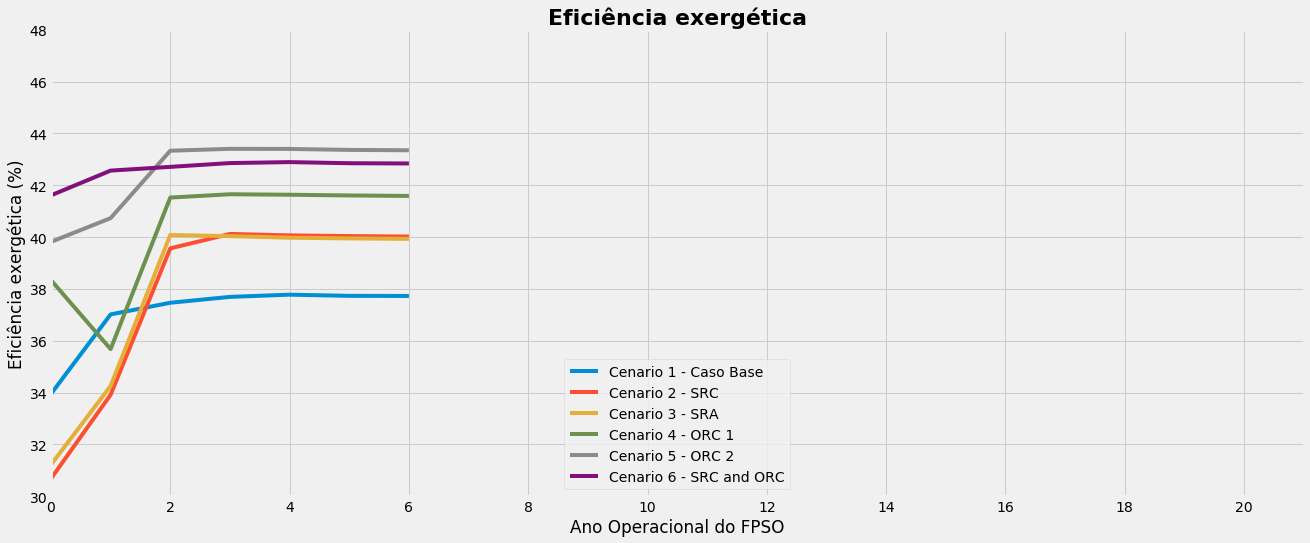

In [55]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('FPSO operational year')
ax1.set_xlim(0,21)
ax1.set_ylabel('Exergetic efficiency (%)')
ax1.set_ylim(30,48)
ax1.plot(eta_exerg)
# ax1.grid(True, color = 'black')
ax1.legend(('Cenario 1 - Caso Base', 'Cenario 2 - SRC', 'Cenario 3 - SRA', 'Cenario 4 - ORC 1', 'Cenario 5 - ORC 2', 'Cenario 6 - SRC and ORC'), loc = 'lower center')
ax1.set_title('Eficiência exergética', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('eta_exerg.png')
plt.show()

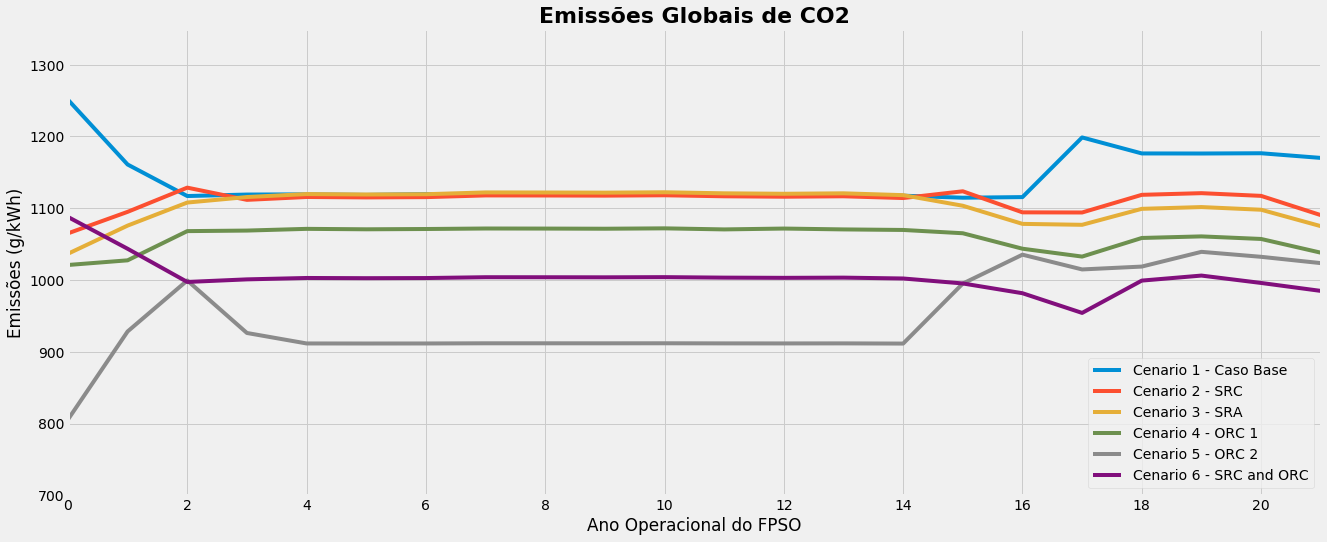

In [30]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax2 = plt.subplots(1, figsize=(20,8))

ax2.set_xlabel('Ano Operacional do FPSO')
ax2.set_xlim(0,21)
ax2.set_ylabel('Emissões (g/kWh)')
ax2.set_ylim(700,1350)
ax2.plot(co2_emit)
# ax2.grid(True, color = 'black')
ax2.legend(('Cenario 1 - Caso Base', 'Cenario 2 - SRC', 'Cenario 3 - SRA', 'Cenario 4 - ORC 1', 'Cenario 5 - ORC 2', 'Cenario 6 - SRC and ORC'), loc = 'lower right')
ax2.set_title('Emissões Globais de CO2', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('co2_emissions.png')

plt.show()

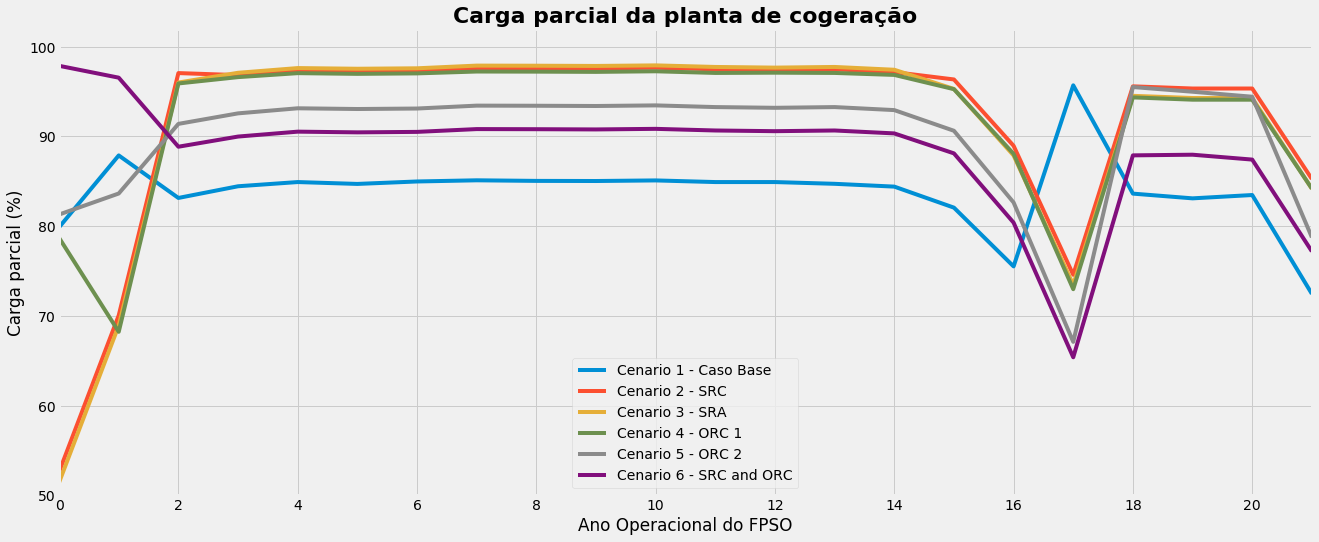

In [31]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax3 = plt.subplots(1, figsize=(20,8))

ax3.set_xlabel('Ano Operacional do FPSO')
ax3.set_xlim(0,21)
ax3.set_ylabel('Carga parcial (%)')
ax3.set_ylim(50,102)
ax3.plot(Carga_Oper)
# ax3.grid(True, color = 'black')
ax3.legend(('Cenario 1 - Caso Base', 'Cenario 2 - SRC', 'Cenario 3 - SRA', 'Cenario 4 - ORC 1', 'Cenario 5 - ORC 2', 'Cenario 6 - SRC and ORC'), loc = 'lower center')
ax3.set_title('Carga parcial da planta de cogeração', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('Operational_load.png')
plt.show()

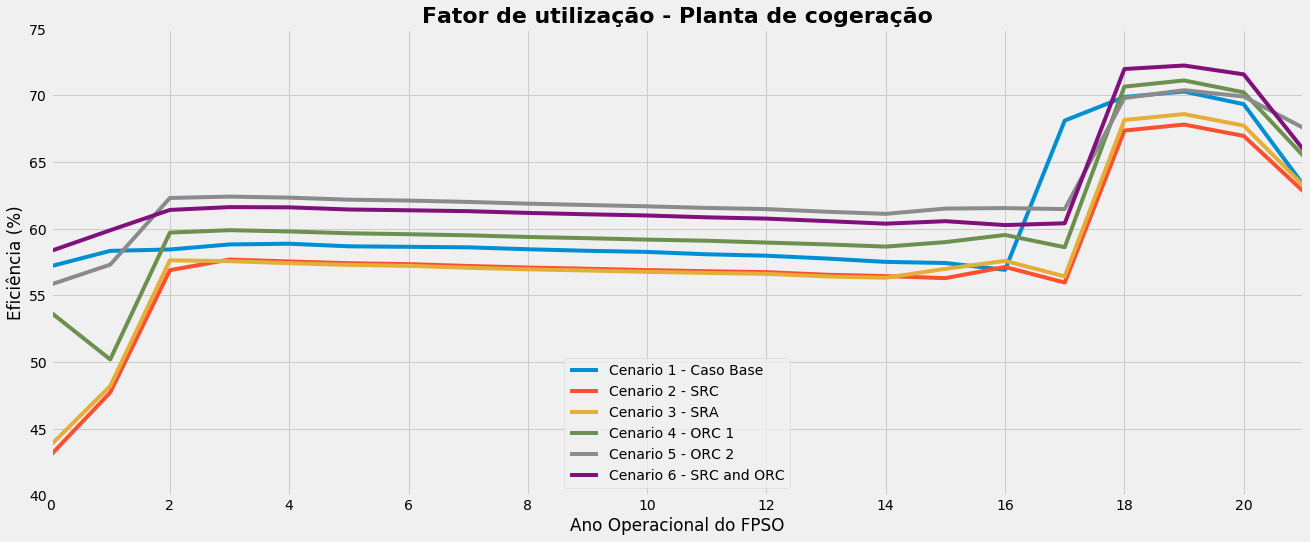

In [32]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax4 = plt.subplots(1, figsize=(20,8))

ax4.set_xlabel('Ano Operacional do FPSO')
ax4.set_xlim(0,21)
ax4.set_ylabel('Eficiência (%)')
ax4.set_ylim(40,75)
ax4.plot(FACoger)
# ax4.grid(True, color = 'black')
ax4.legend(('Cenario 1 - Caso Base', 'Cenario 2 - SRC', 'Cenario 3 - SRA', 'Cenario 4 - ORC 1', 'Cenario 5 - ORC 2', 'Cenario 6 - SRC and ORC'), loc = 'lower center')
ax4.set_title('Fator de utilização - Planta de cogeração', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('First_Law_Efficiency.png')

plt.show()

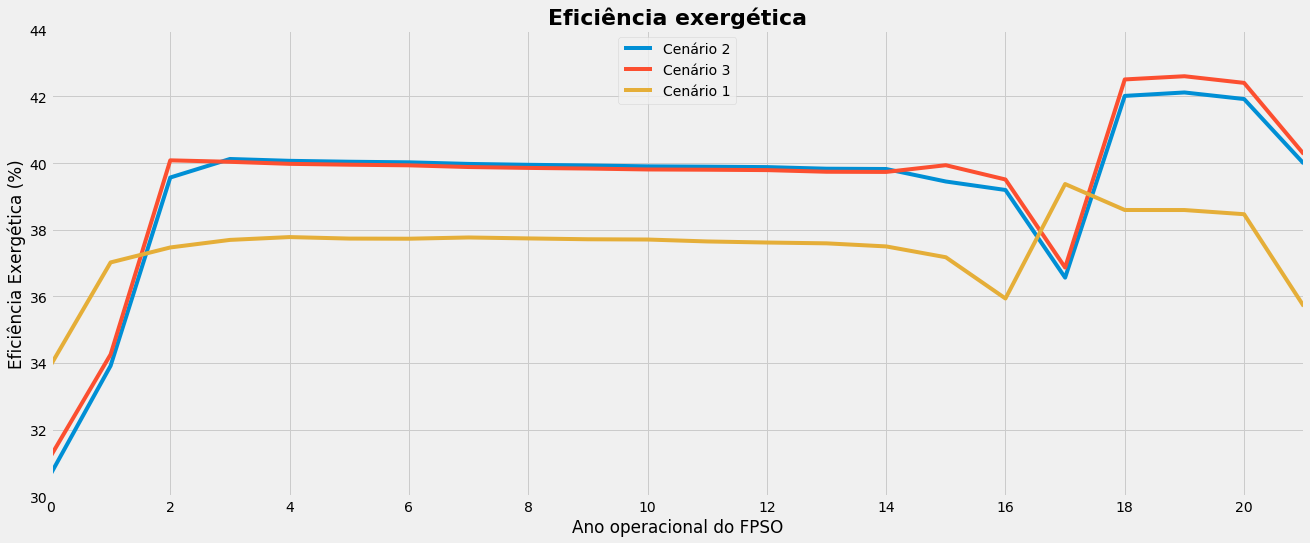

In [34]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

#analise comparativa da eficiencia exergetica dos cenarios 1, 2 e 3 sem sistema de compressao
cur.execute('''
SELECT SRCWithoutCO2.EtaExerg, SRAWithoutCO2.EtaExerg, BaseCase.EtaExergTotal
FROM SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN BaseCase
ON SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = BaseCase.id
''')
EtaExerg = cur.fetchall()


#analise comparativa das emissoes de co2 dos cenarios 1, 2 e 3 sem sistema de compressão
cur.execute('''
SELECT SRCWithoutCO2.CO2Emit, SRAWithoutCO2.CO2Emit, BaseCase.CO2EmitTotal
FROM SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN BaseCase
ON SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = BaseCase.id
''')
CO2Emit = cur.fetchall()


conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('Eficiência Exergética (%)')
ax1.set_ylim(30,44)
ax1.plot(EtaExerg)
ax1.set_title('Eficiência exergética', fontsize = 22, fontweight = 'bold')
ax1.legend(('Cenário 2', 'Cenário 3', 'Cenário 1'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('EtaExergCen123.png')
plt.show()

In [66]:

conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

cur.execute('''
SELECT SRCWithoutCO2.EtaExerg
FROM SRCWithoutCO2
''')
EtaExerg_SRC = cur.fetchall()
#SRC = sum(list(map(sum, list(EtaExerg_SRC))))
EtaExerg_SRC = np.mean(EtaExerg_SRC)

cur.execute('''
SELECT SRAWithoutCO2.EtaExerg
FROM SRAWithoutCO2
''')
EtaExerg_SRA = cur.fetchall()
#SRA = sum(list(map(sum, list(EtaExerg_SRA))))
EtaExerg_SRA = np.mean(EtaExerg_SRA)


cur.execute('''
SELECT BaseCase.EtaExergTotal
FROM BaseCase
''')
EtaExerg_BaseCase = cur.fetchall()
#BaseCase = sum(list(map(sum, list(EtaExerg_BaseCase))))
EtaExerg_BaseCase = np.mean(EtaExerg_BaseCase)

#CO2Emit_BaseCase = sum(list(CO2Emit_BaseCase))
conn.commit()
cur.close()

#media de emissoes ao longo da vida util
print('Eficiência exergetica Caso Base: ', EtaExerg_BaseCase)
print('Eficiência exergetica SRC: ', EtaExerg_SRC)
print('Eficiência exergetica SRA: ', EtaExerg_SRA)
desvio = (EtaExerg_SRC - EtaExerg_BaseCase)/EtaExerg_SRC * 100
print('Eficiência exergetica SRC é', desvio, '% maior que o caso base')
desvio = (EtaExerg_SRA - EtaExerg_BaseCase)/EtaExerg_SRA * 100
print('Eficiência exergetica SRA é', desvio, '% maior que o caso base')

Eficiência exergetica Caso Base:  37.47594032035214
Eficiência exergetica SRC:  39.30325329799695
Eficiência exergetica SRA:  39.453638180686
Eficiência exergetica SRC é 4.649266471124269 % maior que o caso base
Eficiência exergetica SRA é 5.012713532974045 % maior que o caso base


In [39]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

cur.execute('''
SELECT SRCWithoutCO2.CO2Emit
FROM SRCWithoutCO2
''')
CO2Emit_SRC = cur.fetchall()
SRC = sum(list(map(sum, list(CO2Emit_SRC))))
CO2Emit_SRC = np.mean(CO2Emit_SRC)

cur.execute('''
SELECT SRAWithoutCO2.CO2Emit
FROM SRAWithoutCO2
''')
CO2Emit_SRA = cur.fetchall()
#CO2Emit_SRA = sum(list(CO2Emit_SRA))
SRA = sum(list(map(sum, list(CO2Emit_SRA))))
CO2Emit_SRA = np.mean(CO2Emit_SRA)


cur.execute('''
SELECT BaseCase.CO2EmitTotal
FROM BaseCase
''')
CO2Emit_BaseCase = cur.fetchall()
BaseCase = sum(list(map(sum, list(CO2Emit_BaseCase))))
CO2Emit_BaseCase = np.mean(CO2Emit_BaseCase)

#CO2Emit_BaseCase = sum(list(CO2Emit_BaseCase))
conn.commit()
cur.close()

#media de emissoes ao longo da vida util
print('Emissoes medias Caso Base: ', CO2Emit_BaseCase)
print('Emissoes medias SRC: ', CO2Emit_SRC)
print('Emissoes medias SRA: ', CO2Emit_SRA)
desvio = (CO2Emit_SRC - CO2Emit_BaseCase)/CO2Emit_SRC * 100
print('Emissoes SRC são', desvio, '% menores que o caso base')
desvio = (CO2Emit_SRA - CO2Emit_BaseCase)/CO2Emit_SRA * 100
print('Emissoes SRA são', desvio, '% menores que o caso base')

Emissoes medias Caso Base:  1140.0810255272263
Emissoes medias SRC:  1110.8662505139562
Emissoes medias SRA:  1104.2260722510198
Emissoes SRC são -2.629909316243386 % menores que o caso base
Emissoes SRA são -3.2470663550910737 % menores que o caso base


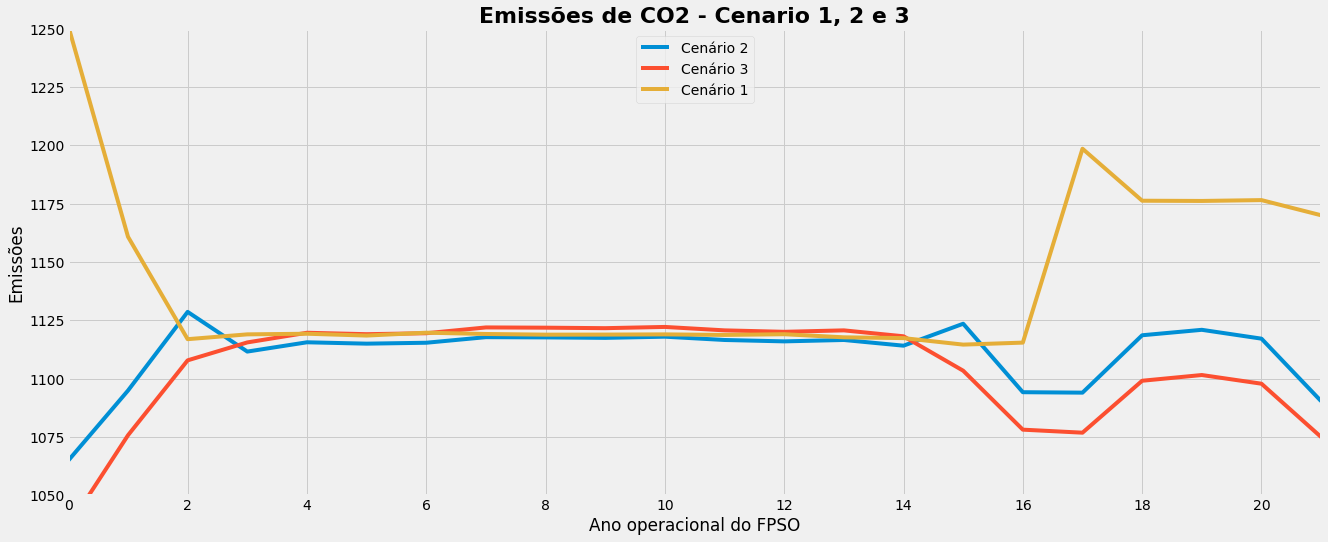

In [40]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax2 = plt.subplots(1, figsize=(20,8))

ax2.set_xlabel('Ano operacional do FPSO')
ax2.set_xlim(0,21)
ax2.set_ylabel('Emissões')
ax2.set_ylim(1050, 1250)
ax2.plot(CO2Emit)
ax2.set_title('Emissões de CO2 - Cenario 1, 2 e 3', fontsize = 22, fontweight = 'bold')
ax2.legend(('Cenário 2', 'Cenário 3', 'Cenário 1'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('EmissõesCen123.png')

plt.show()

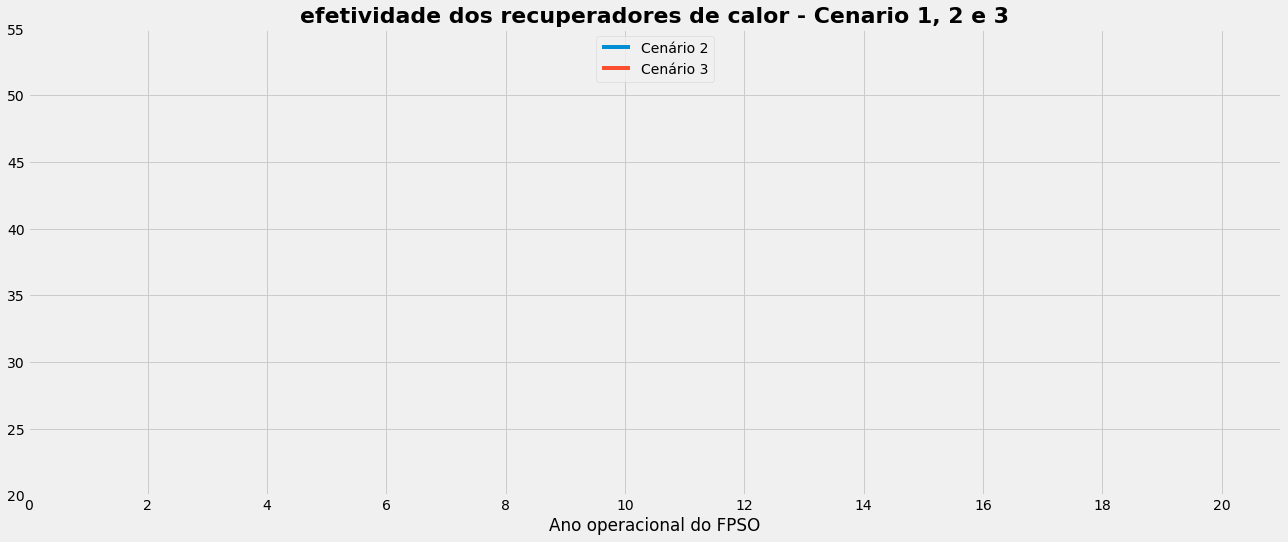

In [41]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

#analise comparativa da efetividade dos recuperadores de calor
cur.execute('''
SELECT SRCWithoutCO2.Epsilon_HRSG, SRAWithoutCO2.Epsilon_HRSG
FROM SRCWithoutCO2 JOIN SRAWithoutCO2
ON SRCWithoutCO2.id = SRAWithoutCO2.id
''')
Epsilon_HRSG = cur.fetchall()

#analise comparativa da eficiencia exergetica dos recuperadores de calor
cur.execute('''
SELECT SRCWithoutCO2.EtaExergHRSG, SRAWithoutCO2.EtaExergHRSG, BaseCase.EtaExergHRSG
FROM SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN BaseCase
ON SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = BaseCase.id
''')
EtaExergHRSG = cur.fetchall()

#analise comparativa da eficiencia da turbina a gás na operação com e sem sistemas de resfriamento
cur.execute('''
SELECT SRCWithoutCO2.EtaOperTurb, SRAWithoutCO2.EtaOperTurb, BaseCase.EtaOperTurb
FROM SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN BaseCase
ON SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = BaseCase.id
''')
EtaOperTurb = cur.fetchall()

conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('')
ax1.set_ylim(20,55)
ax1.plot(Epsilon_HRSG)
ax1.set_title('efetividade dos recuperadores de calor - Cenario 1, 2 e 3', fontsize = 22, fontweight = 'bold')
ax1.legend(('Cenário 2', 'Cenário 3', 'Cenário 1'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('Epsilon_HRSG.png')
plt.show()

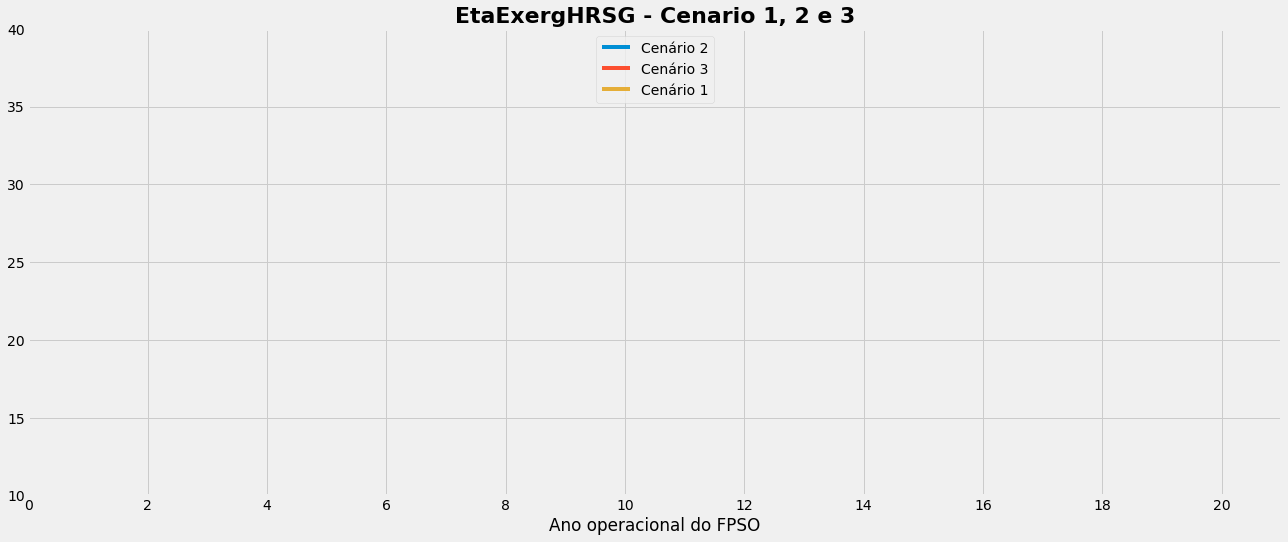

In [42]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('')
ax1.set_ylim(10,40)
ax1.plot(EtaExergHRSG)
ax1.set_title('EtaExergHRSG - Cenario 1, 2 e 3', fontsize = 22, fontweight = 'bold')
ax1.legend(('Cenário 2', 'Cenário 3', 'Cenário 1'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('EtaExergHRSG.png')
plt.show()

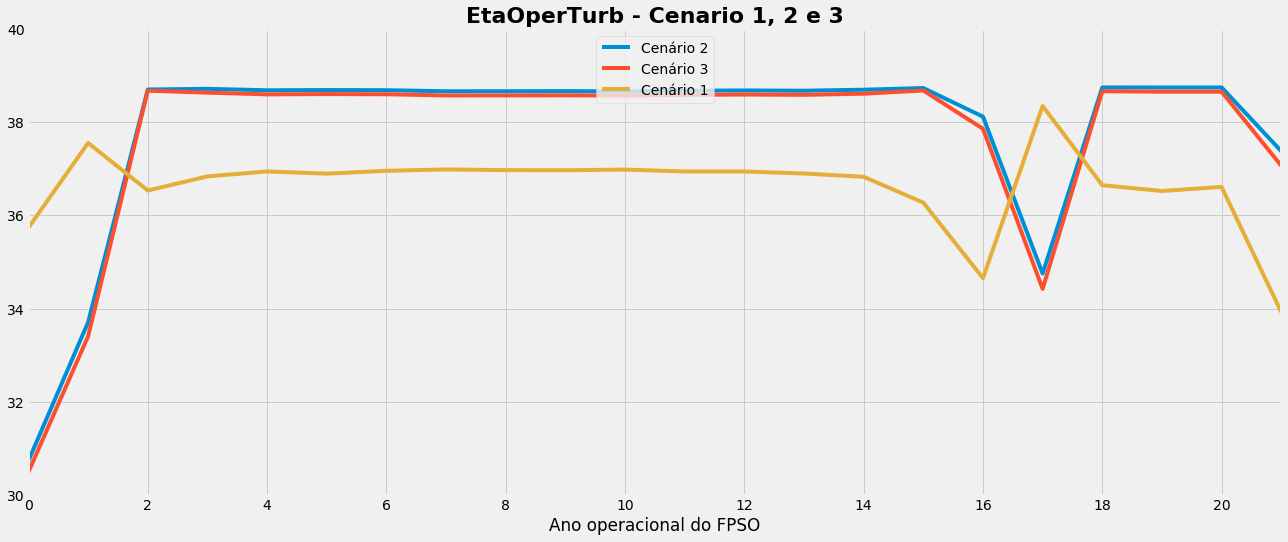

In [45]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('')
ax1.set_ylim(30,40)
ax1.plot(EtaOperTurb)
ax1.set_title('EtaOperTurb - Cenario 1, 2 e 3', fontsize = 22, fontweight = 'bold')
ax1.legend(('Cenário 2', 'Cenário 3', 'Cenário 1'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('EtaOperTurb.png')
plt.show()

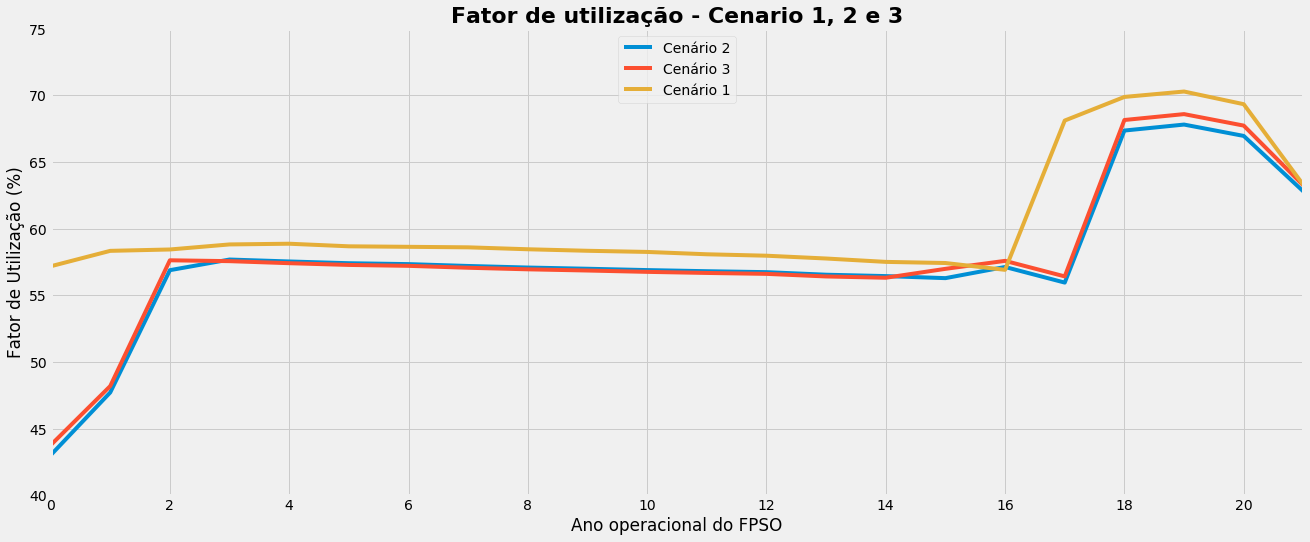

In [64]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('''
SELECT SRCWithoutCO2.CargaOper, SRAWithoutCO2.CargaOper, BaseCase.CargaOper
FROM SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN BaseCase
ON SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = BaseCase.id
''')
CargaOper = cur.fetchall()

cur.execute('''
SELECT SRCWithoutCO2.FACoger, SRAWithoutCO2.FACoger, BaseCase.FACoger
FROM SRCWithoutCO2 JOIN SRAWithoutCO2 JOIN BaseCase
ON SRCWithoutCO2.id = SRAWithoutCO2.id AND SRAWithoutCO2.id = BaseCase.id
''')
FACoger = cur.fetchall()
conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax3 = plt.subplots(1, figsize=(20,8))

ax3.set_xlabel('Ano operacional do FPSO')
ax3.set_xlim(0,21)
ax3.set_ylabel('Fator de Utilização (%)')
ax3.set_ylim(40, 75)
ax3.plot(FACoger)
ax3.set_title('Fator de utilização - Cenario 1, 2 e 3', fontsize = 22, fontweight = 'bold')
ax3.legend(('Cenário 2', 'Cenário 3', 'Cenário 1'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('FACoger.png')

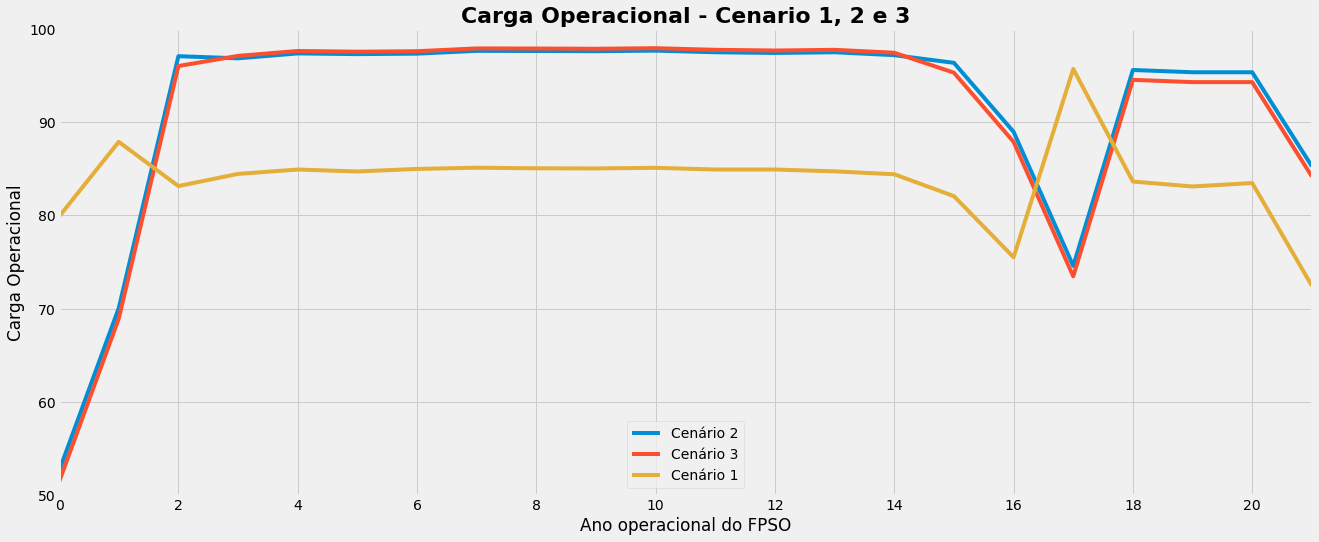

In [63]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax4 = plt.subplots(1, figsize=(20,8))
ax4.set_xlabel('Ano operacional do FPSO')
ax4.set_xlim(0,21)
ax4.set_ylabel('Carga Operacional')
ax4.set_ylim(50, 100)
ax4.plot(CargaOper)
ax4.set_title('Carga Operacional - Cenario 1, 2 e 3', fontsize = 22, fontweight = 'bold')
ax4.legend(('Cenário 2', 'Cenário 3', 'Cenário 1'), loc = 'lower center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('CargaOper.png')

plt.show()

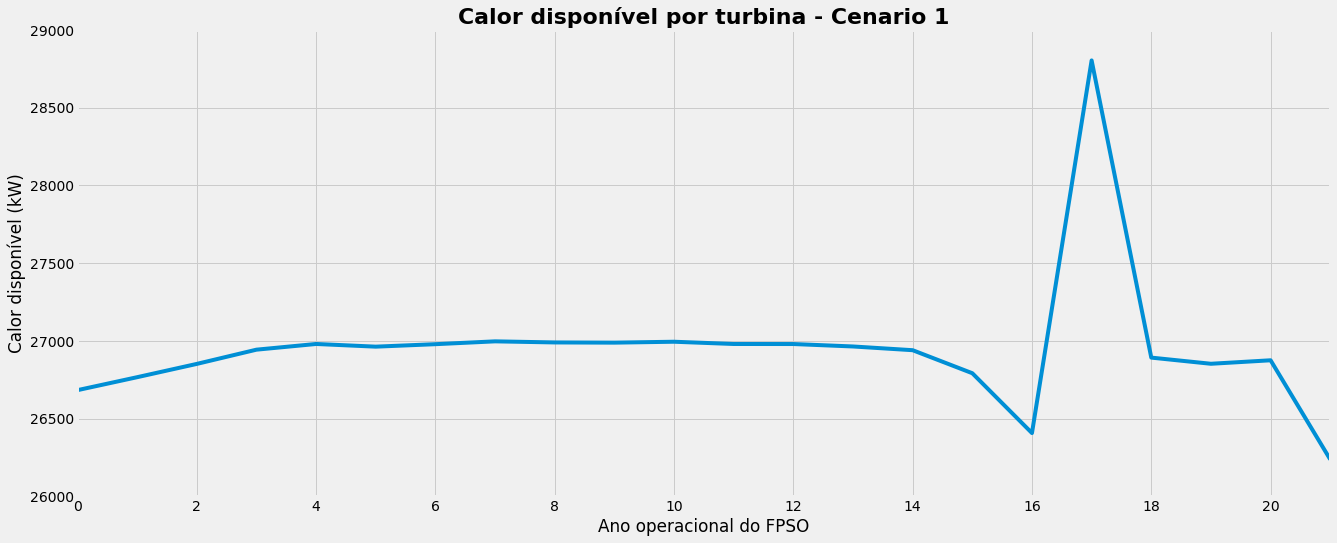

In [47]:
QGasProdDispInd = [26682.466,26765.790,26851.245,26942.797,26979.451,26962.237,26978.111,26996.346,26989.347,26988,26993.870,26979.362,26979.089,26963.400,26939.442,26791.403,26406.705,28802.705,26891.779,26852.155,26874.598,26236.853]
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('Calor disponível (kW)')
ax1.set_ylim(26000,29000)
ax1.plot(QGasProdDispInd)
ax1.set_title('Calor disponível por turbina - Cenario 1', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('QGasProdDispInd.png')

plt.show()

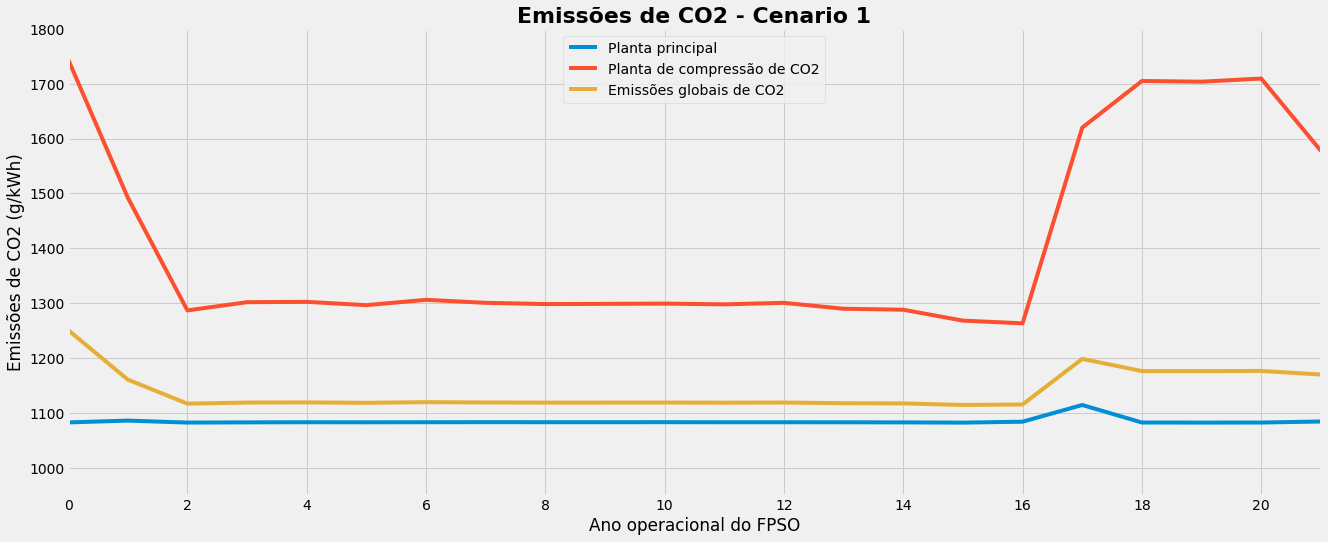

In [57]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
# Gráfico das emissoes de CO2 
cur.execute('''
SELECT BaseCase.CO2Emit, BaseCase.CO2EmitCO2, BaseCase.CO2EmitTotal
FROM BaseCase
''')
co2Emit = cur.fetchall()

#percentual de emissoes planta principal e planta de compressão
cur.execute('''
SELECT BaseCase.RelmCO2mCO2Total, BaseCase.RelmCO2CO2mCO2Total
FROM BaseCase
''')
RelmCO2 = cur.fetchall()
conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('Emissões de CO2 (g/kWh)')
ax1.set_ylim(950,1800)
ax1.plot(co2Emit)
ax1.legend(('Planta principal', 'Planta de compressão de CO2', 'Emissões globais de CO2'), loc = 'upper center')
ax1.set_title('Emissões de CO2 - Cenario 1', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('co2Emit_sc1.png')

plt.show()

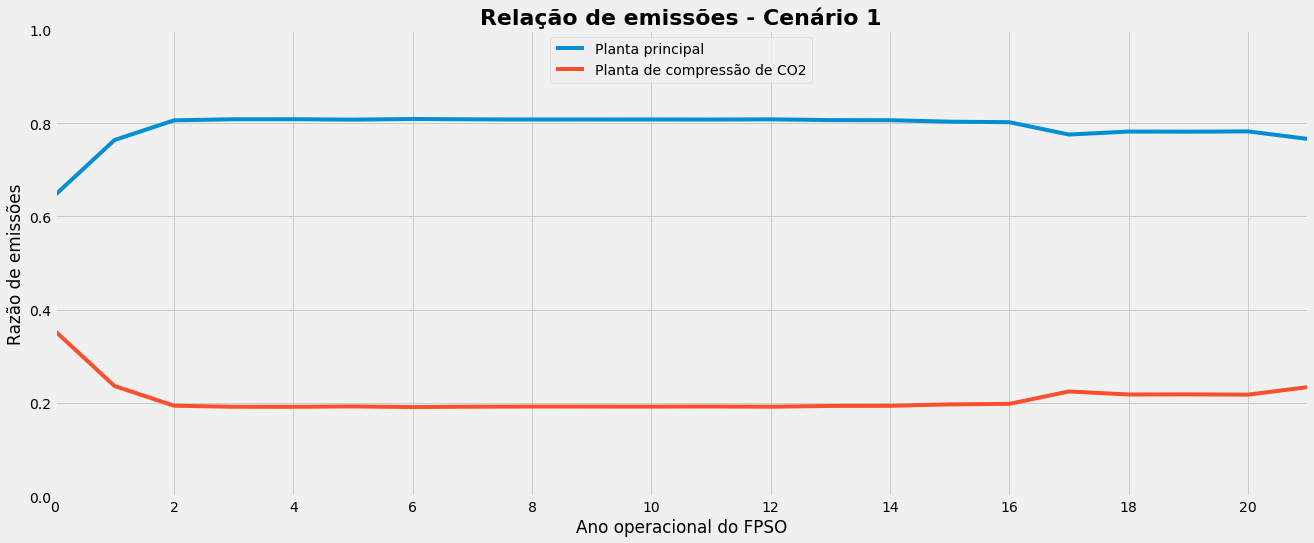

In [50]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('Razão de emissões')
ax1.set_ylim(0,1)
ax1.plot(RelmCO2)
ax1.legend(('Planta principal', 'Planta de compressão de CO2'), loc = 'upper center')
ax1.set_title('Relação de emissões - Cenário 1', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('co2Emit_sc1.png')

plt.show()

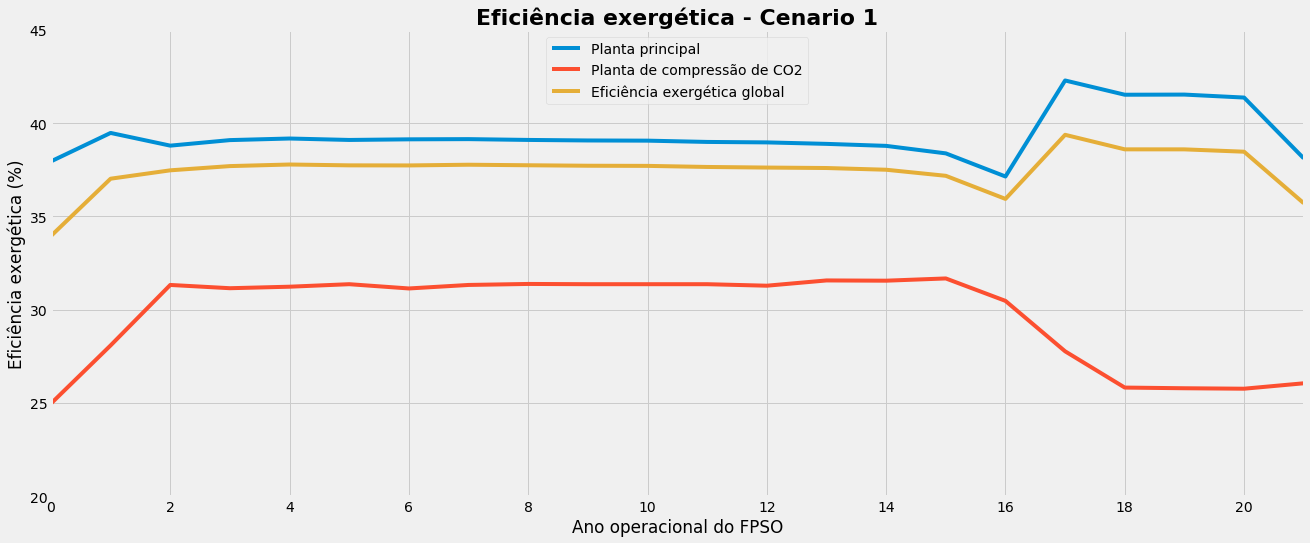

In [51]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
# Gráfico das emissoes de CO2 
cur.execute('''
SELECT BaseCase.EtaExerg, BaseCase.EtaExergCO2, BaseCase.EtaExergTotal
FROM BaseCase
''')
EtaExerg = cur.fetchall()
conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('Eficiência exergética (%)')
ax1.set_ylim(20,45)
ax1.plot(EtaExerg)
plt.savefig('Eta_exerg_sc1.png')
ax1.legend(('Planta principal', 'Planta de compressão de CO2', 'Eficiência exergética global'), loc = 'upper center')
ax1.set_title('Eficiência exergética - Cenario 1', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('Eta_exerg_sc1.png')


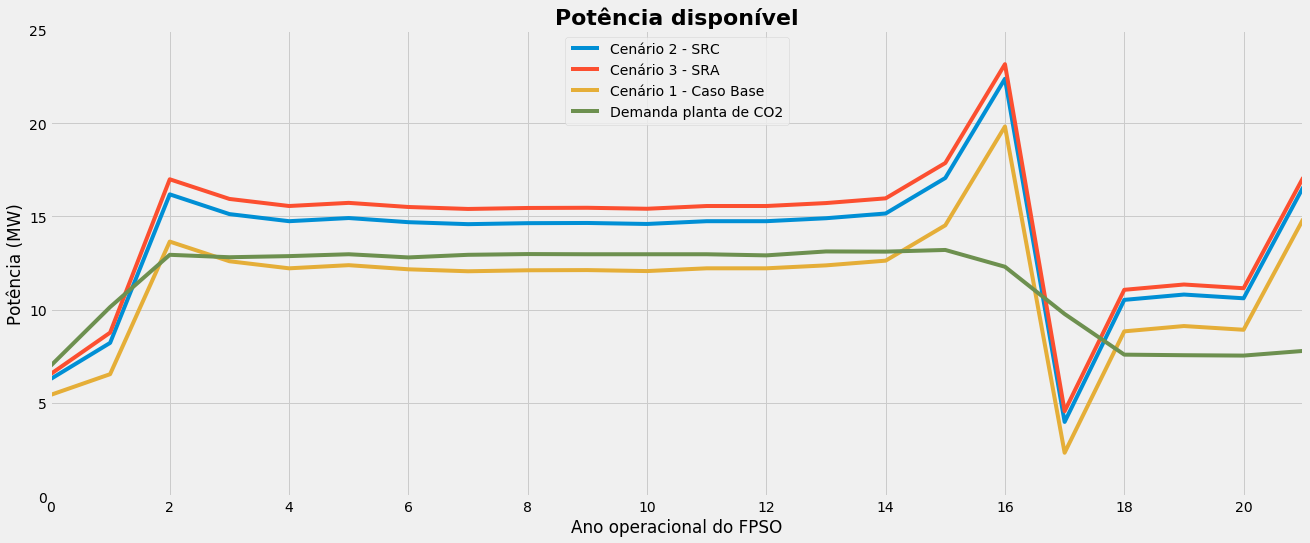

In [52]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
# Gráfico de potencia disponivel 
cur.execute('''
SELECT SRC.WTDispTotal, SRA.WTDispTotal, BaseCase.WTDispTotal, BaseCase.PowerCompCO2
FROM SRC JOIN SRA JOIN BaseCase
ON SRC.id = SRA.id AND SRA.id = BaseCase.id
''')
WTdisp = cur.fetchall()

conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.plot(WTdisp)
ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('Potência (MW)')
ax1.set_ylim(0,25)
ax1.legend(('Cenário 2 - SRC', 'Cenário 3 - SRA', 'Cenário 1 - Caso Base', 'Demanda planta de CO2'), loc = 'upper center')
ax1.set_title('Potência disponível', fontsize = 22, fontweight = 'bold')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('Preliminary.png')

Análise de área ocupada e peso

In [6]:
Cenario = dict()
Cenario[1] = {'Nome':'Cenario 1','Peso': 454903, 'Volume': 679.40, 'Area': 214.96}
Cenario[2] = {'Nome':'Cenario 2','Peso': 441961, 'Volume': 640.59, 'Area': 202.63}
Cenario[3] = {'Nome':'Cenario 3','Peso': 458937, 'Volume': 654.75, 'Area': 214.27}
Cenario[4] = {'Nome':'Cenario 4','Peso': 637696, 'Volume': 1768.47, 'Area': 312.79}
Cenario[5] = {'Nome':'Cenario 5','Peso': 908562, 'Volume': 2529.72, 'Area': 384.05}
Cenario[6] = {'Nome':'Cenario 6','Peso': 943266, 'Volume': 2631.81, 'Area': 418.69}

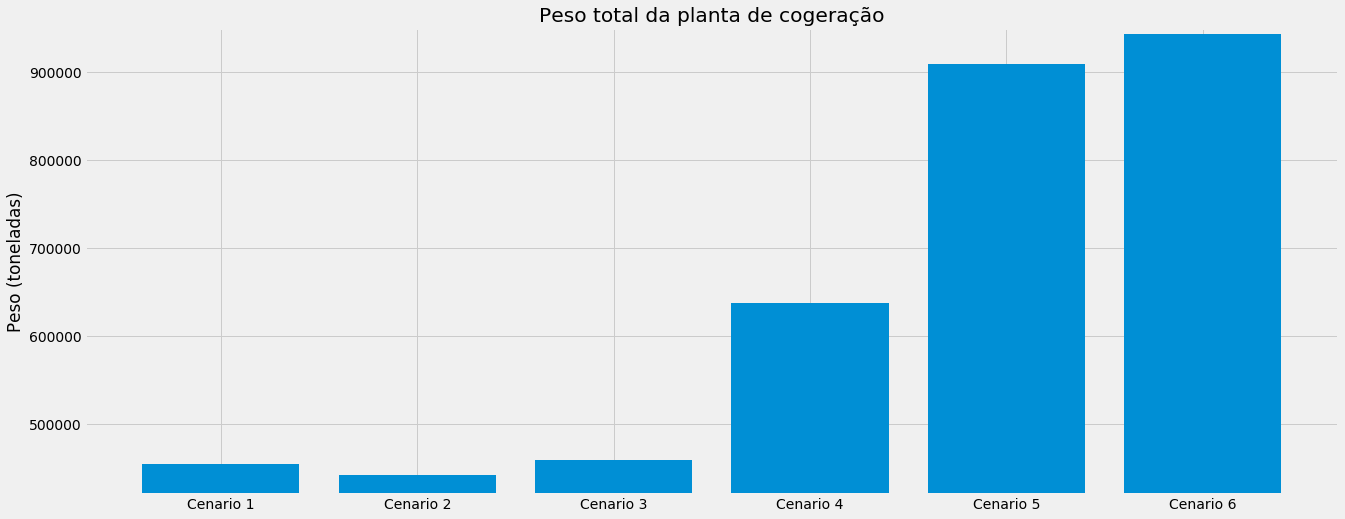

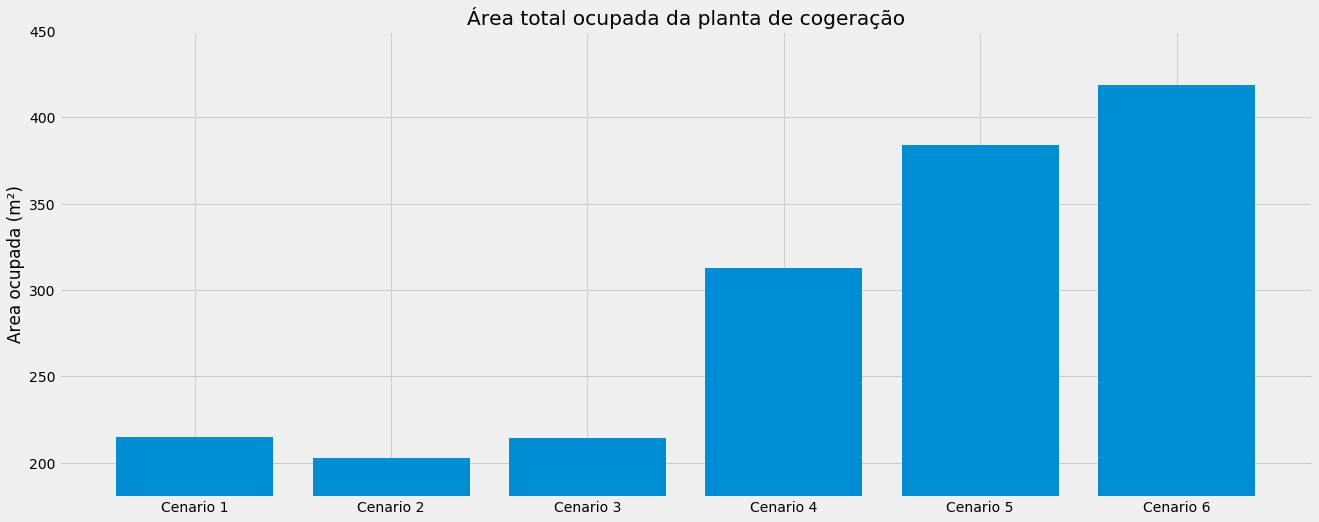

In [7]:
%matplotlib inline
plt.style.use('fivethirtyeight')

peso = list()
volume = list()
area = list()
grupos = list()
for i in range(6):
    peso.append(Cenario[i+1]['Peso'])
    volume.append(Cenario[i+1]['Volume'])
    area.append(Cenario[i+1]['Area'])
    grupos.append(Cenario[i+1]['Nome'])

fig, ax1 = plt.subplots(1, figsize=(20,8))
plt.bar(grupos, peso)
ax1.set_title('Peso total da planta de cogeração')
ax1.set_ylim(420000, 950000)
ax1.set_ylabel('Peso (toneladas)')
plt.savefig('peso.png')

fig, ax1 = plt.subplots(1, figsize=(20,8))
plt.bar(grupos, area)
ax1.set_title('Área total ocupada da planta de cogeração')
ax1.set_ylim(180, 450)
ax1.set_ylabel('Area ocupada (m²)')
plt.savefig('area.png')


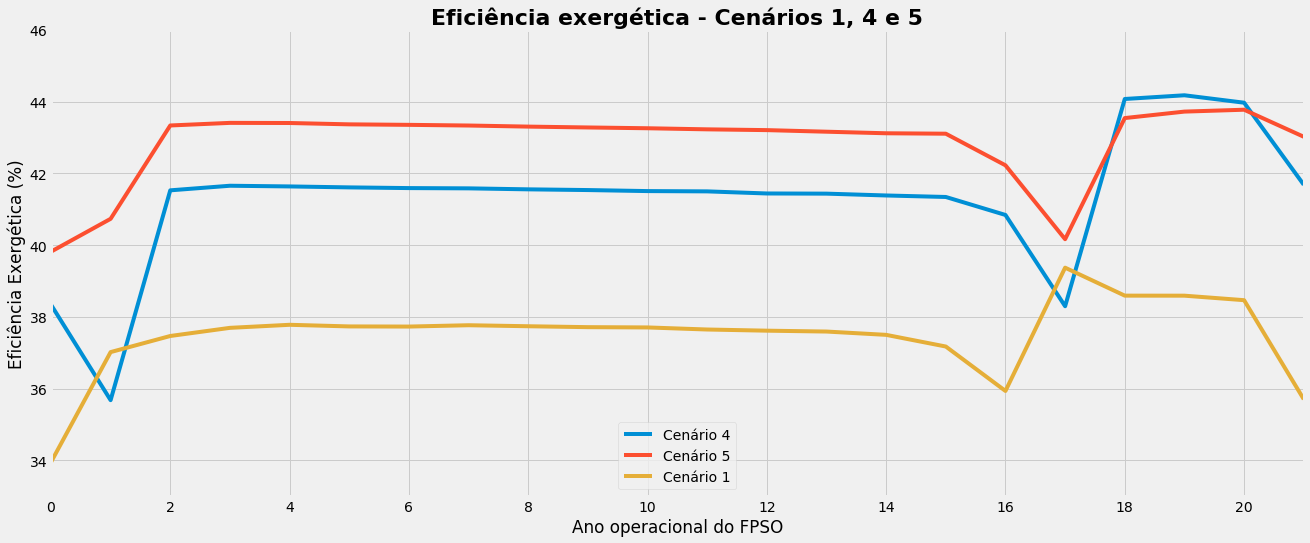

In [65]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

#analise comparativa da eficiencia exergetica dos cenarios 1, 4 e 5 sem turbina de compressao de co2
cur.execute('''
SELECT ORCWithoutCO2.EtaExerg, ORC2WithoutCO2.EtaExerg, BaseCase.EtaExergTotal
FROM ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN BaseCase
ON ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = BaseCase.id
''')
EtaExerg = cur.fetchall()


#analise comparativa das emissoes de co2 dos cenarios 1, 4 e 5 sem turbina de compressão de co2
cur.execute('''
SELECT ORCWithoutCO2.CO2Emit, ORC2WithoutCO2.CO2Emit, BaseCase.CO2EmitTotal
FROM ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN BaseCase
ON ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = BaseCase.id
''')
CO2Emit = cur.fetchall()


conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(1, figsize=(20,8))

ax1.set_xlabel('Ano operacional do FPSO')
ax1.set_xlim(0,21)
ax1.set_ylabel('Eficiência Exergética (%)')
ax1.set_ylim(33,46)
ax1.plot(EtaExerg)
ax1.set_title('Eficiência exergética - Cenários 1, 4 e 5', fontsize = 22, fontweight = 'bold')
ax1.legend(('Cenário 4', 'Cenário 5', 'Cenário 1'), loc = 'lower center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('EtaExergCen145.png')
plt.show()

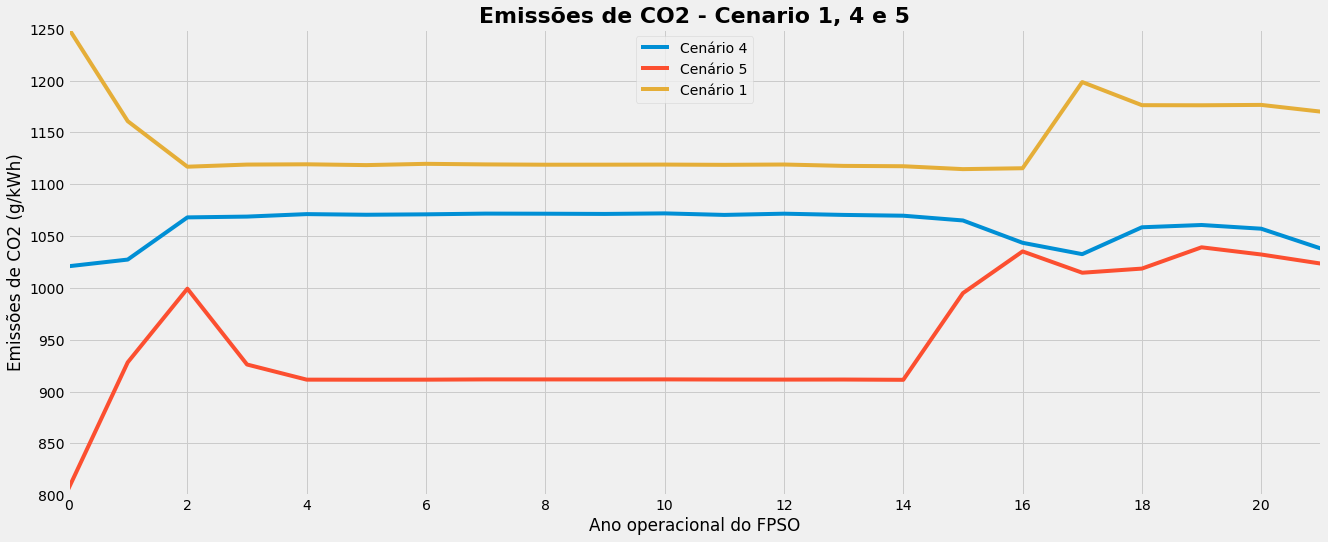

In [66]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax2 = plt.subplots(1, figsize=(20,8))

ax2.set_xlabel('Ano operacional do FPSO')
ax2.set_xlim(0,21)
ax2.set_ylabel('Emissões de CO2 (g/kWh)')
ax2.set_ylim(800, 1250)
ax2.plot(CO2Emit)
ax2.set_title('Emissões de CO2 - Cenario 1, 4 e 5', fontsize = 22, fontweight = 'bold')
ax2.legend(('Cenário 4', 'Cenário 5', 'Cenário 1'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('EmissõesCen145.png')

plt.show()

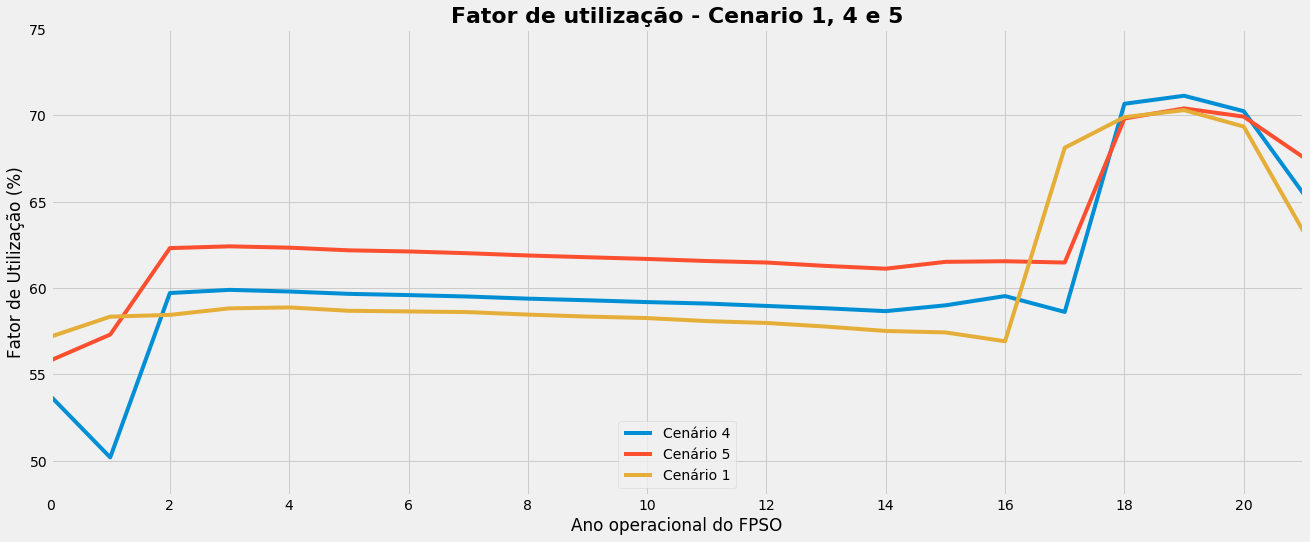

In [67]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()
cur.execute('''
SELECT ORCWithoutCO2.CargaOper, ORC2WithoutCO2.CargaOper, BaseCase.CargaOper
FROM ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN BaseCase
ON ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = BaseCase.id
''')
CargaOper = cur.fetchall()

cur.execute('''
SELECT ORCWithoutCO2.FACoger, ORC2WithoutCO2.FACoger, BaseCase.FACoger
FROM ORCWithoutCO2 JOIN ORC2WithoutCO2 JOIN BaseCase
ON ORCWithoutCO2.id = ORC2WithoutCO2.id AND ORC2WithoutCO2.id = BaseCase.id
''')
FACoger = cur.fetchall()
conn.commit()
cur.close()

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax3 = plt.subplots(1, figsize=(20,8))

ax3.set_xlabel('Ano operacional do FPSO')
ax3.set_xlim(0,21)
ax3.set_ylabel('Fator de Utilização (%)')
ax3.set_ylim(48, 75)
ax3.plot(FACoger)
ax3.set_title('Fator de utilização - Cenario 1, 4 e 5', fontsize = 22, fontweight = 'bold')
ax3.legend(('Cenário 4', 'Cenário 5', 'Cenário 1'), loc = 'lower center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('FACoger145.png')

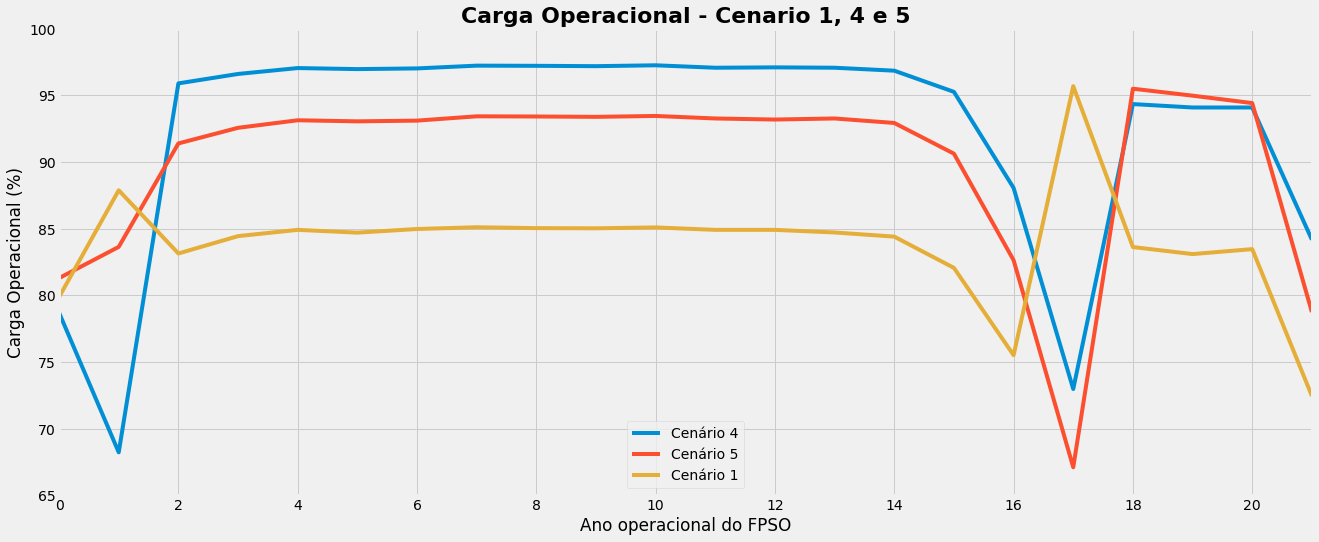

In [68]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax4 = plt.subplots(1, figsize=(20,8))
ax4.set_xlabel('Ano operacional do FPSO')
ax4.set_xlim(0,21)
ax4.set_ylabel('Carga Operacional (%)')
ax4.set_ylim(65, 100)
ax4.plot(CargaOper)
ax4.set_title('Carga Operacional - Cenario 1, 4 e 5', fontsize = 22, fontweight = 'bold')
ax4.legend(('Cenário 4', 'Cenário 5', 'Cenário 1'), loc = 'lower center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('CargaOper145.png')

plt.show()

In [28]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

cur.execute('''
SELECT ORCWithoutCO2.CO2Emit
FROM ORCWithoutCO2
''')
CO2Emit_ORC = cur.fetchall()
ORC = sum(list(map(sum, list(CO2Emit_ORC))))
CO2Emit_ORC = np.mean(CO2Emit_ORC)

cur.execute('''
SELECT ORC2WithoutCO2.CO2Emit
FROM ORC2WithoutCO2
''')
CO2Emit_ORC2 = cur.fetchall()
#CO2Emit_SRA = sum(list(CO2Emit_SRA))
ORC2 = sum(list(map(sum, list(CO2Emit_ORC2))))
CO2Emit_ORC2 = np.mean(CO2Emit_ORC2)


cur.execute('''
SELECT BaseCase.CO2EmitTotal
FROM BaseCase
''')
CO2Emit_BaseCase = cur.fetchall()
BaseCase = sum(list(map(sum, list(CO2Emit_BaseCase))))
CO2Emit_BaseCase = np.mean(CO2Emit_BaseCase)

#CO2Emit_BaseCase = sum(list(CO2Emit_BaseCase))
conn.commit()
cur.close()

#media de emissoes ao longo da vida util
print('Emissoes medias Caso Base: ', CO2Emit_BaseCase)
print('Emissoes medias ORC: ', CO2Emit_ORC)
print('Emissoes medias ORC2: ', CO2Emit_ORC2)
desvio = (CO2Emit_ORC - CO2Emit_BaseCase)/CO2Emit_ORC * 100
print('Emissoes ORC são', desvio, '% menores que o caso base')
desvio = (CO2Emit_ORC2 - CO2Emit_BaseCase)/CO2Emit_ORC2 * 100
print('Emissoes ORC2 são', desvio, '% menores que o caso base')

Emissoes medias Caso Base:  1133.9827084986682
Emissoes medias ORC:  1060.0994558503849
Emissoes medias ORC2:  947.5285411989393
Emissoes ORC são -6.969464255503848 % menores que o caso base
Emissoes ORC2 são -19.677947332731772 % menores que o caso base


In [32]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

cur.execute('''
SELECT ORCWithoutCO2.CargaOper
FROM ORCWithoutCO2
''')
CargaOper_ORC = cur.fetchall()
ORC = sum(list(map(sum, list(CargaOper_ORC))))
CargaOper_ORC = np.mean(CargaOper_ORC)

cur.execute('''
SELECT ORC2WithoutCO2.CargaOper
FROM ORC2WithoutCO2
''')
CargaOper_ORC2 = cur.fetchall()
#CO2Emit_SRA = sum(list(CO2Emit_SRA))
ORC2 = sum(list(map(sum, list(CargaOper_ORC2))))
CargaOper_ORC2 = np.mean(CargaOper_ORC2)


cur.execute('''
SELECT BaseCase.CargaOper
FROM BaseCase
''')
CargaOper_BaseCase = cur.fetchall()
BaseCase = sum(list(map(sum, list(CargaOper_BaseCase))))
CargaOper_BaseCase = np.mean(CargaOper_BaseCase)

#CO2Emit_BaseCase = sum(list(CO2Emit_BaseCase))
conn.commit()
cur.close()

#media de emissoes ao longo da vida util
print('Carga parcial Caso Base: ', CargaOper_BaseCase)
print('Carga parcial ORC: ', CargaOper_ORC)
print('Carga parcial ORC2: ', CargaOper_ORC2)
desvio = (CargaOper_ORC - CargaOper_BaseCase)/CargaOper_BaseCase * 100
print('Carga parcial ORC é', desvio, '% maior que o caso base')
desvio = (CargaOper_ORC2 - CargaOper_BaseCase)/CargaOper_BaseCase * 100
print('Carga parcial ORC2 é', desvio, '% maior que o caso base')

Carga parcial Caso Base:  83.86612672746855
Carga parcial ORC:  92.29505677767025
Carga parcial ORC2:  89.93456925341295
Carga parcial ORC é 10.05045824709702 % maior que o caso base
Carga parcial ORC2 é 7.235868356797266 % maior que o caso base


In [29]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

cur.execute('''
SELECT ORCWithoutCO2.EtaExerg
FROM ORCWithoutCO2
''')
EtaExerg_ORC = cur.fetchall()
#SRC = sum(list(map(sum, list(EtaExerg_SRC))))
EtaExerg_ORC = np.mean(EtaExerg_ORC)

cur.execute('''
SELECT ORC2WithoutCO2.EtaExerg
FROM ORC2WithoutCO2
''')
EtaExerg_ORC2 = cur.fetchall()
#SRA = sum(list(map(sum, list(EtaExerg_SRA))))
EtaExerg_ORC2 = np.mean(EtaExerg_ORC2)


cur.execute('''
SELECT BaseCase.EtaExergTotal
FROM BaseCase
''')
EtaExerg_BaseCase = cur.fetchall()
#BaseCase = sum(list(map(sum, list(EtaExerg_BaseCase))))
EtaExerg_BaseCase = np.mean(EtaExerg_BaseCase)

#CO2Emit_BaseCase = sum(list(CO2Emit_BaseCase))
conn.commit()
cur.close()

#media de emissoes ao longo da vida util
print('Eficiência exergetica Caso Base: ', EtaExerg_BaseCase)
print('Eficiência exergetica ORC: ', EtaExerg_ORC)
print('Eficiência exergetica ORC2: ', EtaExerg_ORC2)
desvio = (EtaExerg_ORC - EtaExerg_BaseCase)/EtaExerg_ORC * 100
print('Eficiência exergetica ORC é', desvio, '% maior que o caso base')
desvio = (EtaExerg_ORC2 - EtaExerg_BaseCase)/EtaExerg_ORC2 * 100
print('Eficiência exergetica ORC2 é', desvio, '% maior que o caso base')

Eficiência exergetica Caso Base:  37.47594032035214
Eficiência exergetica ORC:  41.28708361186122
Eficiência exergetica ORC2:  42.85469985598015
Eficiência exergetica ORC é 9.230836760807666 % maior que o caso base
Eficiência exergetica ORC2 é 12.5511543744424 % maior que o caso base


Eficiência exergetica sistema ORC:  29.07917731650217
Eficiência exergetica sistema ORC2:  36.53598638764626


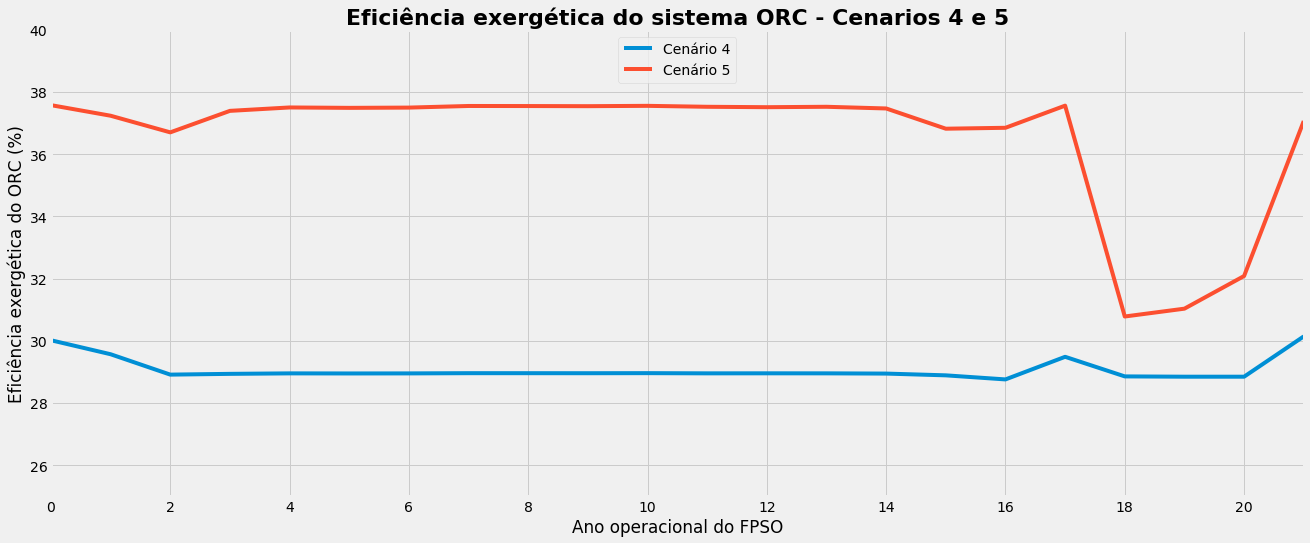

In [69]:
conn = sqlite3.connect('FPSO2.sqlite')
cur = conn.cursor()

#analise comparativa da eficiencia exergetica dos cenarios 1, 4 e 5 sem turbina de compressao de co2
cur.execute('''
SELECT ORCWithoutCO2.EtaExergORC, ORC2WithoutCO2.EtaExergORC
FROM ORCWithoutCO2 JOIN ORC2WithoutCO2
ON ORCWithoutCO2.id = ORC2WithoutCO2.id
''')
EtaExerg = cur.fetchall()

cur.execute('''
SELECT ORCWithoutCO2.EtaExergORC
FROM ORCWithoutCO2
''')
EtaExerg_ORC = cur.fetchall()
#SRC = sum(list(map(sum, list(EtaExerg_SRC))))
EtaExerg_ORC = np.mean(EtaExerg_ORC)

cur.execute('''
SELECT ORC2WithoutCO2.EtaExergORC
FROM ORC2WithoutCO2
''')
EtaExerg_ORC2 = cur.fetchall()
#SRA = sum(list(map(sum, list(EtaExerg_SRA))))
EtaExerg_ORC2 = np.mean(EtaExerg_ORC2)

conn.commit()
cur.close()

#eficiencia exergetica do sistema ORC ao longo da vida util
print('Eficiência exergetica sistema ORC: ', EtaExerg_ORC)
print('Eficiência exergetica sistema ORC2: ', EtaExerg_ORC2)

%matplotlib inline
plt.style.use('fivethirtyeight')
fig, ax2 = plt.subplots(1, figsize=(20,8))

ax2.set_xlabel('Ano operacional do FPSO')
ax2.set_xlim(0,21)
ax2.set_ylabel('Eficiência exergética do ORC (%)')
ax2.set_ylim(25,40)
ax2.plot(EtaExerg)
ax2.set_title('Eficiência exergética do sistema ORC - Cenarios 4 e 5', fontsize = 22, fontweight = 'bold')
ax2.legend(('Cenário 4', 'Cenário 5'), loc = 'upper center')
plt.xticks(np.arange(0, 22, 2.0))
plt.savefig('EtaExerg45.png')

plt.show()
